# Project 2: NLP with Neural Networks

## Importing necessary libraries and loading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import re
import string
import time

from typing import Optional, Tuple, List, Dict, Any, Union, Set

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

# 3.12 Python venv needed for gensim to be installed
from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from category_encoders import TargetEncoder

from sentence_transformers import SentenceTransformer

import joblib

import os
import sys

from collections import Counter

import logging

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings

warnings.filterwarnings("ignore")

# Download once
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')


RANDOM_SEED = 42
FILEPATH = "../data/Train_rev1.csv"
MODELS_DIR = "../models/"
PREPROCESSORS_DIR = "../fitted_preprocessors/"
TFIDF_FEATURES_DIR = "../tfidf_features/"
EMBEDDINGS_DIR = "../embeddings/"
REPORTS_DIR = "../reports/"

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.mps.benchmark = False
torch.use_deterministic_algorithms(True)

/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv_312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def set_seed(seed_value: Optional[int] = 42) -> None:
    """
      Sets seeds for reproducibility across Python's random, NumPy, and PyTorch.

    Args:
        seed_value : Optional[int], default=42
            The integer value used to set the random seeds.
    """
    random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    np.random.seed(seed_value)

    # PyTorch seeds and deterministic settings
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)

    torch.backends.cudnn.deterministic = True
    torch.backends.mps.benchmark = False

    # Apple Silicon GPU (MPS) seed
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed_value)



set_seed()

In [ ]:
def get_device() -> tuple[torch.device, str]:
    """
    Detects and sets up the appropriate PyTorch device (MPS, CUDA, or CPU).

    The function checks for Apple Silicon (MPS) first, then NVIDIA (CUDA),
    and defaults to CPU. It also applies the manual seed for MPS if available.

    Args:
        seed_value : Optional[int], default=42
            The integer value used to set the random seeds.

    Returns:
        tuple[torch.device, str]
            A tuple containing:
            - The selected torch.device object.
            - A string describing the selected device.
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        status = "Using Apple Silicon GPU (MPS)"
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        status = "Using NVIDIA CUDA GPU"
    else:
        device = torch.device("cpu")
        status = "Using CPU"

    return device, status


device, status = get_device()
print(status)

Using Apple Silicon GPU (MPS)


In [4]:
def seed_worker(worker_id: int) -> None:
    """
    Sets separate, deterministic seeds for PyTorch DataLoader workers.

    Parameters
    ----------
    worker_id : int
        The unique ID assigned to the DataLoader worker process.
    """
    worker_seed: int = torch.initial_seed() % 2**32

    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(RANDOM_SEED)

In [ ]:
logger = logging.getLogger(__name__)


def setup_logging(
    log_file: str = None,
    level: int = logging.INFO,
    log_to_console: bool = True,
    detailed: bool = False,
) -> None:
    """
    Configures logging with optional file and console output.
    The log file is cleared on each run.

    Args:
        log_file: The path to the log file. If None, no file logging is performed.
        level: The minimum logging level to capture (e.g., logging.INFO, logging.DEBUG).
        log_to_console: If True, logs will also be printed to the console.
        detailed: If True, use a detailed log format.
    """
    # Always clear existing handlers at the start to prevent duplicates.
    if logger.hasHandlers():
        logger.handlers.clear()

    # Set logger level
    logger.setLevel(level)

    # Add console handler
    if log_to_console:
        console_handler = logging.StreamHandler(sys.stdout)
        formatter = (
            logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
            if detailed
            else logging.Formatter("%(levelname)s - %(message)s")
        )
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    # Add file handler with 'w' mode to clear the file on each run
    if log_file:
        file_handler = logging.FileHandler(log_file, mode="w")  # 'w' mode to overwrite
        formatter = (
            logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
            if detailed
            else logging.Formatter("%(levelname)s - %(message)s")
        )
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)


setup_logging()

In [6]:
df = pd.read_csv(FILEPATH)

## Exploratory Data Analysis (EDA)

In [7]:
df.head()

Id                                              Title  \
0  12612628                        Engineering Systems Analyst   
1  12612830                            Stress Engineer Glasgow   
2  12612844                   Modelling and simulation analyst   
3  12613049  Engineering Systems Analyst / Mathematical Mod...   
4  12613647         Pioneer, Miser Engineering Systems Analyst   

                                     FullDescription  \
0  Engineering Systems Analyst Dorking Surrey Sal...   
1  Stress Engineer Glasgow Salary **** to **** We...   
2  Mathematical Modeller / Simulation Analyst / O...   
3  Engineering Systems Analyst / Mathematical Mod...   
4  Pioneer, Miser  Engineering Systems Analyst Do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Glasgow          NaN   
2  Hampshire, South East, South East          Hampshire          NaN   
3     Surrey, South East, South East             Surrey          NaN   
4     Surrey, South East, South East             Surrey          NaN   

  ContractTime                       Company          Category  \
0    permanent  Gregory Martin International  Engineering Jobs   
1    permanent  Gregory Martin International  Engineering Jobs   
2    permanent  Gregory Martin International  Engineering Jobs   
3    permanent  Gregory Martin International  Engineering Jobs   
4    permanent  Gregory Martin International  Engineering Jobs   

                                SalaryRaw  SalaryNormalized        SourceName  
0              20000 - 30000/annum 20-30K             25000  cv-library.co.uk  
1              25000 - 35000/annum 25-35K             30000  cv-library.co.uk  
2              20000 - 40000/annum 20-40K             30000  cv-library.co.uk  
3  25000 - 30000/annum 25K-30K negotiable             27500  cv-library.co.uk  
4              20000 - 30000/annum 20-30K             25000  cv-library.co.uk

In [8]:
df.shape

(244768, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [10]:
df.isnull().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [11]:
df.isnull().sum() / len(
    df
)  # Calculate the percentage of missing values for each column

Id                    0.000000
Title                 0.000004
FullDescription       0.000000
LocationRaw           0.000000
LocationNormalized    0.000000
ContractType          0.732637
ContractTime          0.261084
Company               0.132493
Category              0.000000
SalaryRaw             0.000000
SalaryNormalized      0.000000
SourceName            0.000004
dtype: float64

In [12]:
# Id column is not useful for prediction, so we will drop it
df = df.drop(columns=["Id"])

In [13]:
# Checking for duplicates
df.duplicated().sum()

0

In [14]:
df.nunique()

Title                 135435
FullDescription       242138
LocationRaw            20986
LocationNormalized      2732
ContractType               2
ContractTime               2
Company                20812
Category                  29
SalaryRaw              97286
SalaryNormalized        8454
SourceName               167
dtype: int64

### Univariate Analysis

#### Inspecting the 'Title' column

In [15]:
df["Title"].value_counts()

Title
Business Development Manager                                       921
Project Manager                                                    749
Management Accountant                                              661
Sales Executive                                                    603
Account Manager                                                    540
                                                                  ... 
Senior Build & Release Engineer (Java eCommerce Deployments)         1
Job Family Recruiter                                                 1
Leasehold Officer  Housing Services [Standard DBS/CRB required]      1
Sales/Retail Consultant                                              1
TEACHER OF ENGLISH                                                   1
Name: count, Length: 135435, dtype: int64

In [16]:
df[df["Title"].isna()]

Title                                    FullDescription  \
1588   NaN  Quality Improvement Manager North West England...   

                LocationRaw LocationNormalized ContractType ContractTime  \
1588  Liverpool, Merseyside          Liverpool    full_time          NaN   

     Company                   Category                  SalaryRaw  \
1588     NaN  Healthcare & Nursing Jobs  40,000 to 45,000 per year   

      SalaryNormalized      SourceName  
1588             42500  careworx.co.uk

We can fill it manually.

In [17]:
df.loc[df["Title"].isnull(), "Title"] = "Quality Improvement Manager"

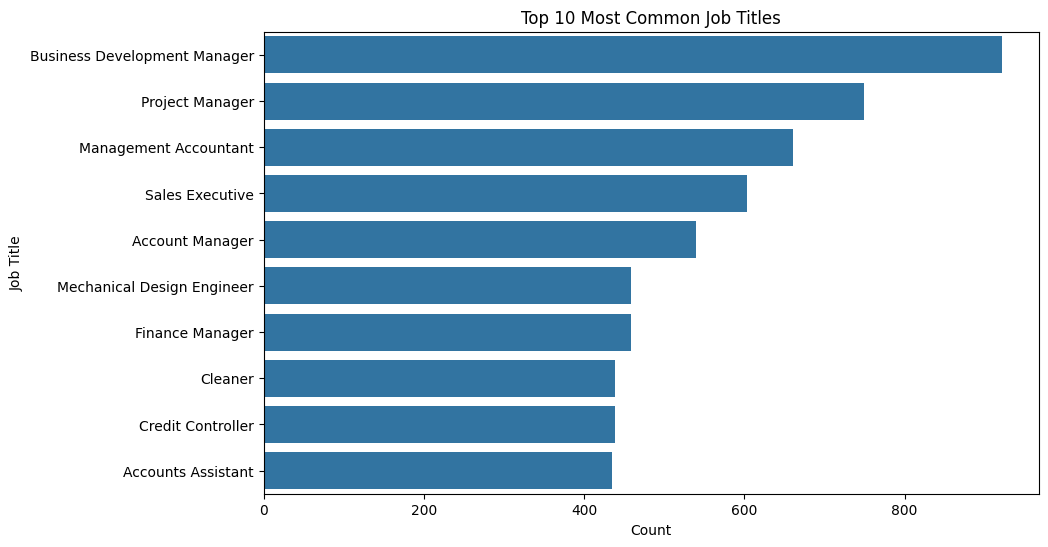

In [18]:
# Plot 10 most common titles
plt.figure(figsize=(10, 6))
sns.countplot(y="Title", data=df, order=df["Title"].value_counts().index[:10])
plt.title("Top 10 Most Common Job Titles")
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.show()

#### Inspecting the 'FullDescription' column

From the description on Kaggle, we now that *** hide salary information in description.

In [19]:
df["FullDescription"].head()

0    Engineering Systems Analyst Dorking Surrey Sal...
1    Stress Engineer Glasgow Salary **** to **** We...
2    Mathematical Modeller / Simulation Analyst / O...
3    Engineering Systems Analyst / Mathematical Mod...
4    Pioneer, Miser  Engineering Systems Analyst Do...
Name: FullDescription, dtype: object

Check for some common words in IT job descriptions:

In [20]:
words = ["python", "java", "c++", "sql", "html", "css", "tensorflow", "pytorch"]
for word in words:
    print(
        f"Number of job descriptions containing '{word}': {df['FullDescription'].str.contains(word, case=False).sum()}"
    )

Number of job descriptions containing 'python': 1332
Number of job descriptions containing 'java': 10498
Number of job descriptions containing 'c++': 244750
Number of job descriptions containing 'sql': 16186
Number of job descriptions containing 'html': 7895
Number of job descriptions containing 'css': 6534
Number of job descriptions containing 'tensorflow': 0
Number of job descriptions containing 'pytorch': 0


#### Inspecting the 'LocationRaw' column

In [21]:
df["LocationRaw"].head(10)

0              Dorking, Surrey, Surrey
1          Glasgow, Scotland, Scotland
2    Hampshire, South East, South East
3       Surrey, South East, South East
4       Surrey, South East, South East
5      Dorking, Surrey, Surrey, Surrey
6                    Aberdeen, Borders
7       MANCHESTER, Greater Manchester
8                LEEDS, West Yorkshire
9                         Aberdeen, UK
Name: LocationRaw, dtype: object

In [22]:
df["LocationRaw"].value_counts()

LocationRaw
London                     15605
London South East           8689
UK                          5538
City London South East      2843
City of London - London     2344
                           ...  
TEDDINGTON, MIDDLESEX          1
SEVENOAKS, KENT                1
ELY, CAMBRIDGESHIRE            1
MORECAMBE, LANCASHIRE          1
Hampshire-wide                 1
Name: count, Length: 20986, dtype: int64

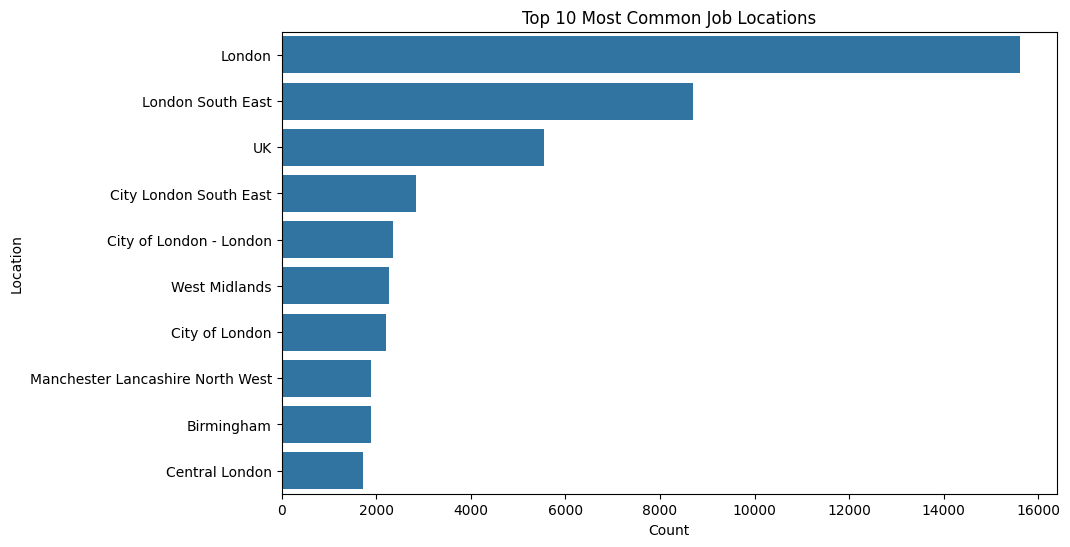

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(
    y="LocationRaw", data=df, order=df["LocationRaw"].value_counts().index[:10]
)
plt.title("Top 10 Most Common Job Locations")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

#### Inspecting the 'LocationNormalized' column

In [24]:
df["LocationNormalized"].head(10)

0       Dorking
1       Glasgow
2     Hampshire
3        Surrey
4        Surrey
5       Dorking
6            UK
7    Manchester
8         Leeds
9      Aberdeen
Name: LocationNormalized, dtype: object

In [25]:
df["LocationNormalized"].value_counts()

LocationNormalized
UK                    41093
London                30522
South East London     11713
The City               6678
Manchester             3516
                      ...  
Oldbrook                  1
Berrycroft                1
Pinchbeck                 1
Peasedown St. John        1
Temple                    1
Name: count, Length: 2732, dtype: int64

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(
    y="LocationNormalized",
    data=df,
    order=df["LocationNormalized"].value_counts().index[:10],
)
plt.title("Top 10 Most Common Job Locations")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

#### Inspecting the 'ContractType' column

In [27]:
df["ContractType"].head(10)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: ContractType, dtype: object

In [28]:
df["ContractType"].isnull().sum() / len(df)

0.7326366191659041

In [29]:
df["ContractType"].value_counts()

ContractType
full_time    57538
part_time     7904
Name: count, dtype: int64

#### Inspecting the 'ContractTime' column

In [30]:
df["ContractTime"].head(10)

0    permanent
1    permanent
2    permanent
3    permanent
4    permanent
5    permanent
6    permanent
7    permanent
8    permanent
9    permanent
Name: ContractTime, dtype: object

In [31]:
df["ContractTime"].isnull().sum() / len(df)

0.2610839652242123

In [32]:
df["ContractTime"].value_counts()

ContractTime
permanent    151521
contract      29342
Name: count, dtype: int64

#### Inspecting the 'Company' column

In [33]:
df["Company"].head(10)

0    Gregory Martin International
1    Gregory Martin International
2    Gregory Martin International
3    Gregory Martin International
4    Gregory Martin International
5    Gregory Martin International
6                   Indigo 21 Ltd
7           Code Blue Recruitment
8           Code Blue Recruitment
9                   Indigo 21 Ltd
Name: Company, dtype: object

In [34]:
df["Company"].isnull().sum() / len(df)

0.132492809517584

In [35]:
df["Company"].value_counts()

Company
UKStaffsearch          4997
CVbrowser              2977
London4Jobs            2345
Hays                   1784
JAM Recruitment Ltd    1122
                       ... 
Your Golf Travel          1
YMCAfit                   1
The Park Club             1
Celtic Manor Resort       1
DMC Healthcare            1
Name: count, Length: 20812, dtype: int64

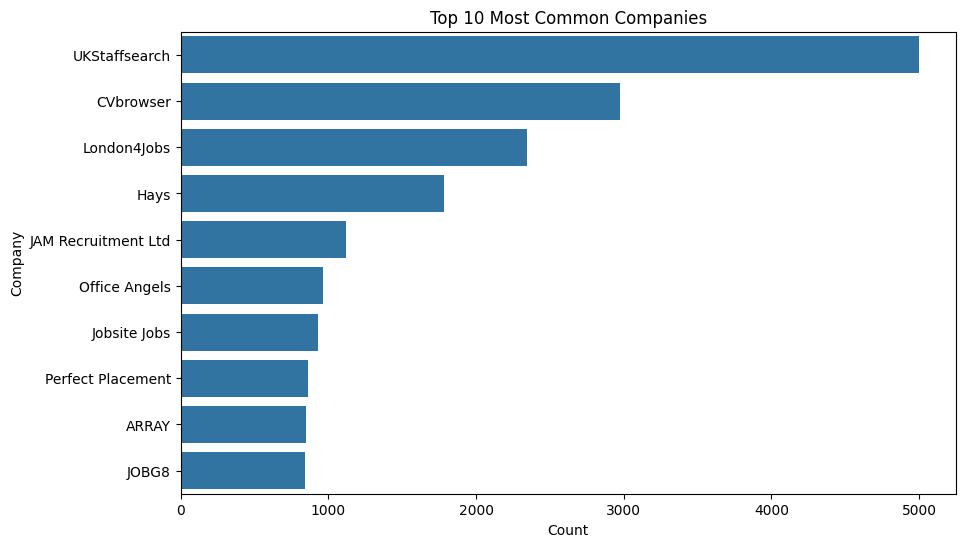

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(y="Company", data=df, order=df["Company"].value_counts().index[:10])
plt.title("Top 10 Most Common Companies")
plt.xlabel("Count")
plt.ylabel("Company")
plt.show()

#### Inspecting the 'Category' column

In [37]:
df["Category"].head(10)

0         Engineering Jobs
1         Engineering Jobs
2         Engineering Jobs
3         Engineering Jobs
4         Engineering Jobs
5         Engineering Jobs
6         Engineering Jobs
7    HR & Recruitment Jobs
8    HR & Recruitment Jobs
9         Engineering Jobs
Name: Category, dtype: object

In [38]:
df["Category"].value_counts()

Category
IT Jobs                             38483
Engineering Jobs                    25174
Accounting & Finance Jobs           21846
Healthcare & Nursing Jobs           21076
Sales Jobs                          17272
Other/General Jobs                  17055
Teaching Jobs                       12637
Hospitality & Catering Jobs         11351
PR, Advertising & Marketing Jobs     8854
Trade & Construction Jobs            8837
HR & Recruitment Jobs                7713
Admin Jobs                           7614
Retail Jobs                          6584
Customer Services Jobs               6063
Legal Jobs                           3939
Manufacturing Jobs                   3765
Logistics & Warehouse Jobs           3633
Social work Jobs                     3455
Consultancy Jobs                     3263
Travel Jobs                          3126
Scientific & QA Jobs                 2489
Charity & Voluntary Jobs             2332
Energy, Oil & Gas Jobs               2255
Creative & Design Jobs   

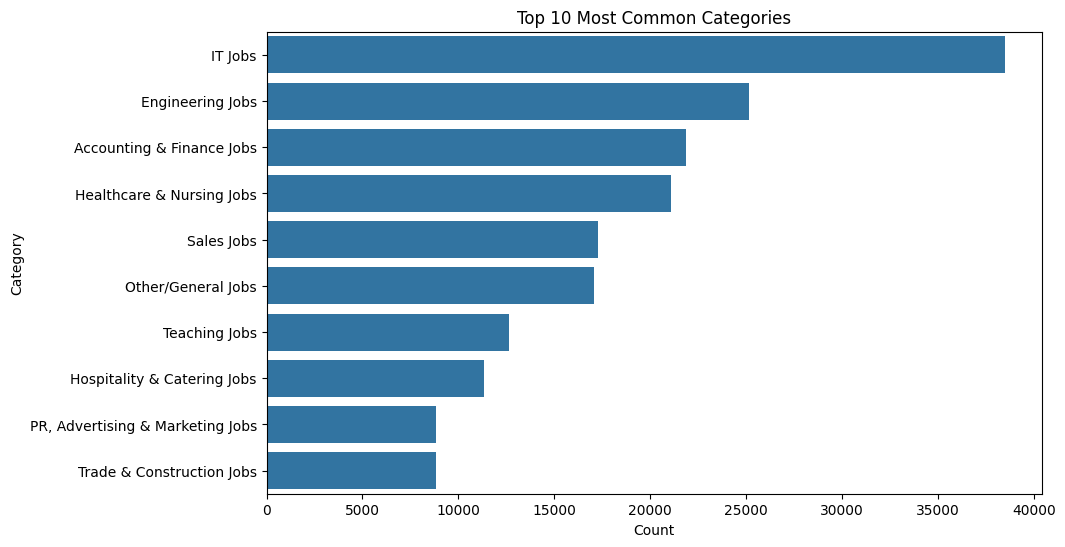

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(y="Category", data=df, order=df["Category"].value_counts().index[:10])
plt.title("Top 10 Most Common Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

#### Inspecting the 'SalaryRow' column

In [40]:
df["SalaryRaw"].head(10)

0                          20000 - 30000/annum 20-30K
1                          25000 - 35000/annum 25-35K
2                          20000 - 40000/annum 20-40K
3              25000 - 30000/annum 25K-30K negotiable
4                          20000 - 30000/annum 20-30K
5                      20000 - 30000/annum 20K to 30K
6                                50000 - 100000/annum
7      18000 - 26000/annum TO 26K BASIC + COMM + BENS
8    18000 - 28000/annum 18 - 28K BASIC + COMM + BENS
9                                70000 - 100000/annum
Name: SalaryRaw, dtype: object

In [41]:
df["SalaryRaw"].value_counts()

SalaryRaw
50,000-74,999 yearly                                   1923
35000                                                   868
40000                                                   834
45000                                                   764
30k - 40k                                               742
                                                       ... 
28,000.00 - 40,000.00 per year Company Car, Pension       1
21294, circa                                              1
36000 - 40000, Company Benfits                            1
7.64 - 8 p/h                                              1
30000 - 34000 per annum + Vehicle                         1
Name: count, Length: 97286, dtype: int64

#### Inspecting the 'SalaryNormalized' column

In [42]:
df["SalaryNormalized"].head(10)

0    25000
1    30000
2    30000
3    27500
4    25000
5    25000
6    75000
7    22000
8    23000
9    85000
Name: SalaryNormalized, dtype: int64

In [43]:
df["SalaryNormalized"].describe()

count    244768.000000
mean      34122.577576
std       17640.543124
min        5000.000000
25%       21500.000000
50%       30000.000000
75%       42500.000000
max      200000.000000
Name: SalaryNormalized, dtype: float64

In [44]:
df[["SalaryRaw", "SalaryNormalized"]].head(10)

SalaryRaw  SalaryNormalized
0                        20000 - 30000/annum 20-30K             25000
1                        25000 - 35000/annum 25-35K             30000
2                        20000 - 40000/annum 20-40K             30000
3            25000 - 30000/annum 25K-30K negotiable             27500
4                        20000 - 30000/annum 20-30K             25000
5                    20000 - 30000/annum 20K to 30K             25000
6                              50000 - 100000/annum             75000
7    18000 - 26000/annum TO 26K BASIC + COMM + BENS             22000
8  18000 - 28000/annum 18 - 28K BASIC + COMM + BENS             23000
9                              70000 - 100000/annum             85000

In [45]:
df["SalaryNormalized"].value_counts()

SalaryNormalized
35000    9178
30000    8319
40000    7688
45000    6735
25000    6309
         ... 
15765       1
23507       1
48300       1
29745       1
37804       1
Name: count, Length: 8454, dtype: int64

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(df["SalaryNormalized"], bins=50, kde=True)
plt.title("Distribution of Normalized Salaries")
plt.xlabel("SalaryNormalized")
plt.ylabel("Frequency")
plt.show()

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(y="SalaryNormalized", data=df)
plt.title("Boxplot of Normalized Salaries")
plt.ylabel("SalaryNormalized")
plt.show()

I will also look how the salary is distributed after some transformations. Let's start with log transformation.

##### Log transformed salary distribution

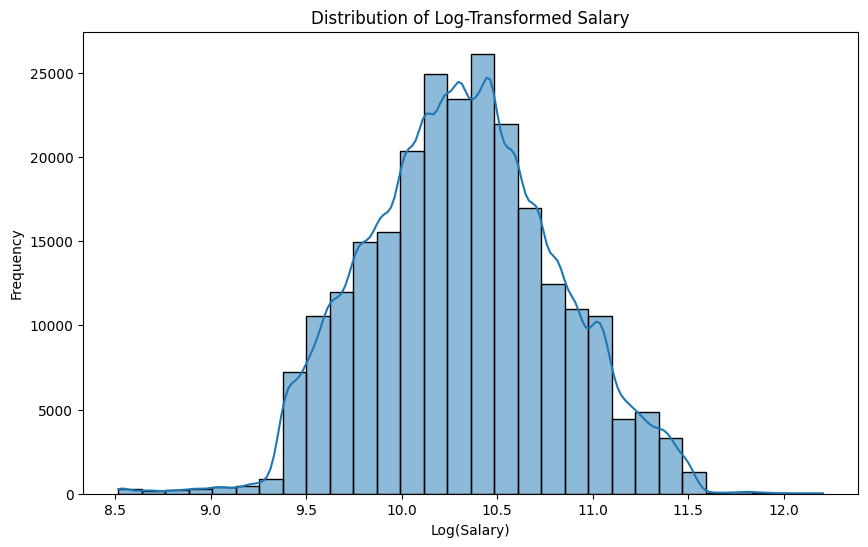

In [48]:
df["Salary_log1p"] = np.log1p(df["SalaryNormalized"])

plt.figure(figsize=(10, 6))
sns.histplot(df["Salary_log1p"], bins=30, kde=True)
plt.title("Distribution of Log-Transformed Salary")
plt.xlabel("Log(Salary)")
plt.ylabel("Frequency")
plt.show()

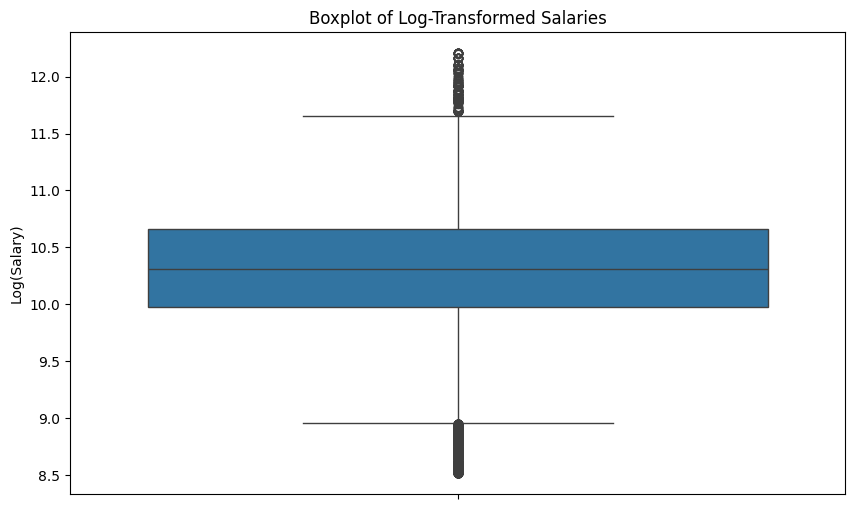

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df["Salary_log1p"])
plt.title("Boxplot of Log-Transformed Salaries")
plt.ylabel("Log(Salary)")
plt.show()

In [50]:
# to inverse if needed
original_salary = np.expm1(df["Salary_log1p"])
np.allclose(original_salary, df["SalaryNormalized"])

True

##### Standardized salary distribution

We know that standardization and normalization don't change the shape of the distribution, so we will only plot it to check values.

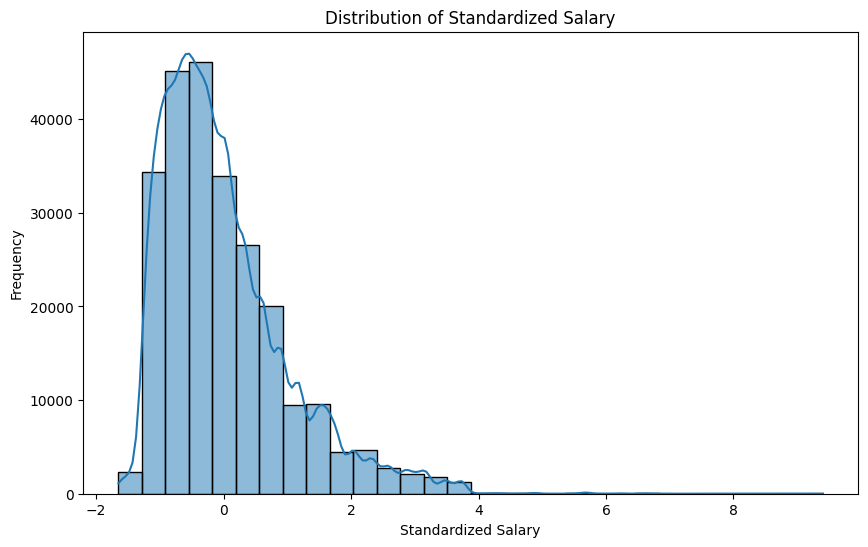

In [51]:
df["Salary_standardized"] = (
    df["SalaryNormalized"] - df["SalaryNormalized"].mean()
) / df["SalaryNormalized"].std()

plt.figure(figsize=(10, 6))
sns.histplot(df["Salary_standardized"], bins=30, kde=True)
plt.title("Distribution of Standardized Salary")
plt.xlabel("Standardized Salary")
plt.ylabel("Frequency")
plt.show()

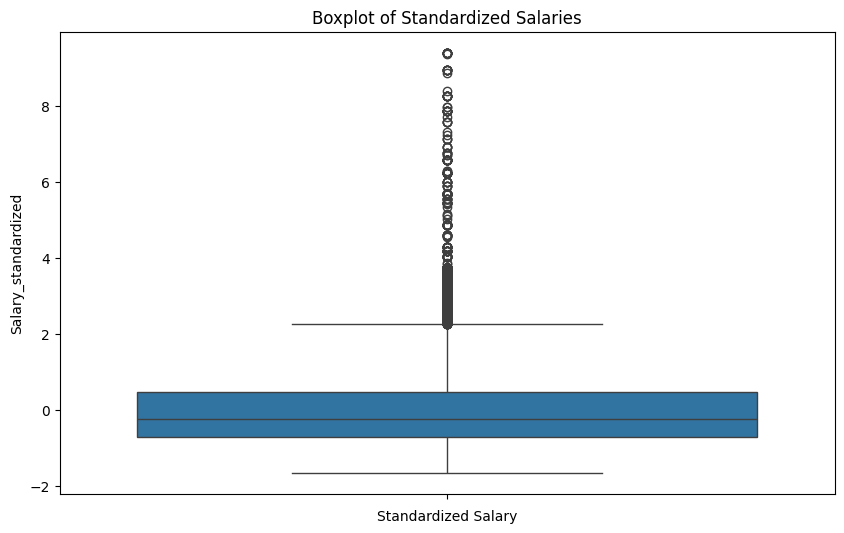

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df["Salary_standardized"])
plt.title("Boxplot of Standardized Salaries")
plt.xlabel("Standardized Salary")
plt.show()

##### Normalized (Min-Max) salary distribution

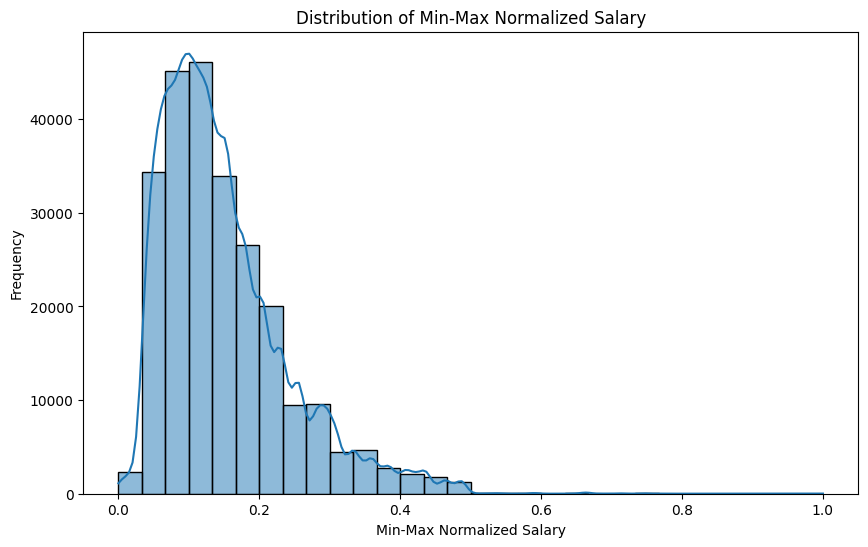

In [53]:
df["Salary_minmax"] = (df["SalaryNormalized"] - df["SalaryNormalized"].min()) / (
    df["SalaryNormalized"].max() - df["SalaryNormalized"].min()
)

plt.figure(figsize=(10, 6))
sns.histplot(df["Salary_minmax"], bins=30, kde=True)
plt.title("Distribution of Min-Max Normalized Salary")
plt.xlabel("Min-Max Normalized Salary")
plt.ylabel("Frequency")
plt.show()

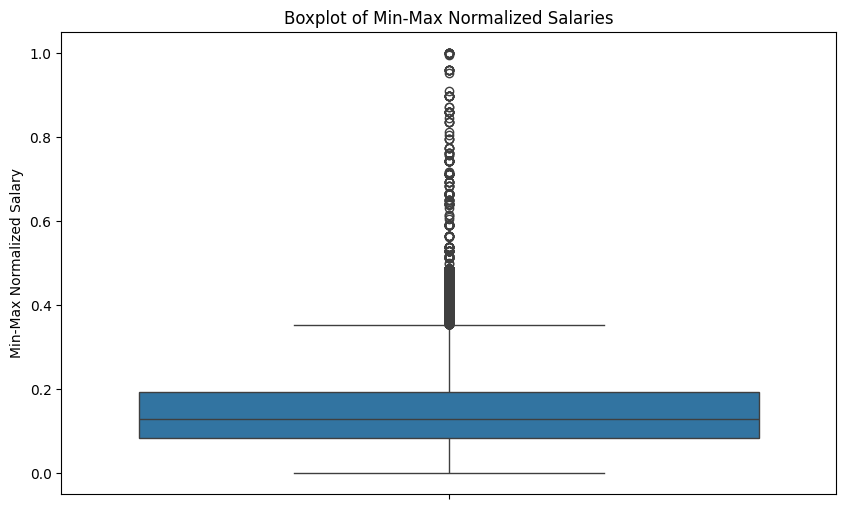

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(y="Salary_minmax", data=df)
plt.title("Boxplot of Min-Max Normalized Salaries")
plt.ylabel("Min-Max Normalized Salary")
plt.show()

#### Inspecting the 'SourceName' column

In [55]:
df["SourceName"].head(10)

0    cv-library.co.uk
1    cv-library.co.uk
2    cv-library.co.uk
3    cv-library.co.uk
4    cv-library.co.uk
5    cv-library.co.uk
6    cv-library.co.uk
7    cv-library.co.uk
8    cv-library.co.uk
9    cv-library.co.uk
Name: SourceName, dtype: object

In [56]:
df["SourceName"].isnull().sum()

1

In [57]:
df.loc[df["SourceName"].isnull()]

Title  \
224434  Senior C++ Engineer / C++ Performance Optimisa...   

                   FullDescription  \
224434   Tier One Investment Bank"   

                                              LocationRaw LocationNormalized  \
224434  Senior C++ Engineer / C++ Performance Optimisa...             London   

       ContractType ContractTime          Company                   Category  \
224434          NaN          NaN  Montash Limited  Accounting & Finance Jobs   

                                SalaryRaw  SalaryNormalized SourceName  \
224434  Up To 120,000 Plus Uncapped Bonus            120000        NaN   

        Salary_log1p  Salary_standardized  Salary_minmax  
224434     11.695255             4.868185       0.589744

In [58]:
df["SourceName"].value_counts()

SourceName
totaljobs.com             48149
cv-library.co.uk          34279
Jobcentre Plus            17929
jobsite.co.uk             12225
cwjobs.co.uk               7011
                          ...  
eastmidlandsjobs.co.uk        2
greatbritishjobs.co.uk        2
broadcastjobs.co.uk           2
jobs.cabincrew.com            1
cvjobstore.com                1
Name: count, Length: 167, dtype: int64

In [59]:
df["SourceName"].nunique()

167

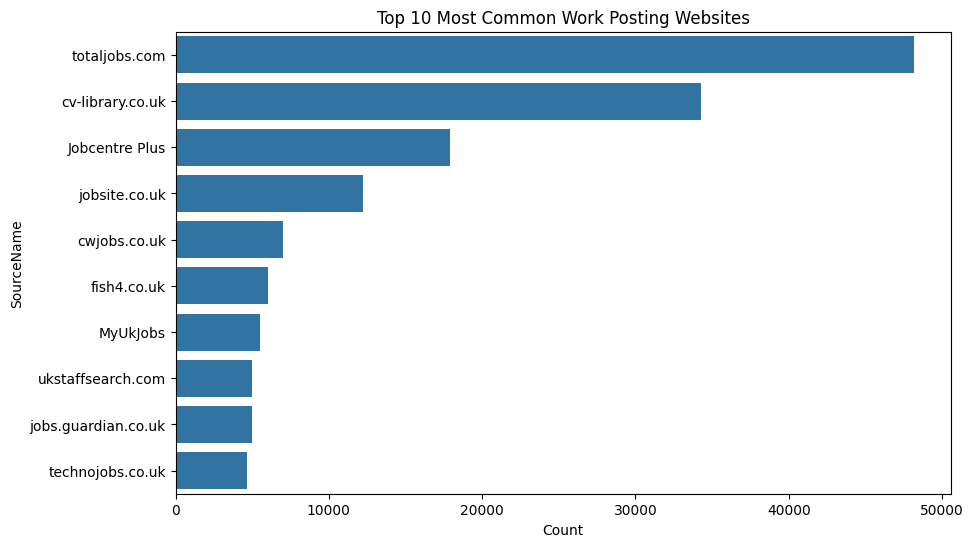

In [60]:
plt.figure(figsize=(10, 6))
sns.countplot(y="SourceName", data=df, order=df["SourceName"].value_counts().index[:10])
plt.title("Top 10 Most Common Work Posting Websites")
plt.xlabel("Count")
plt.ylabel("SourceName")
plt.show()

We have missing values only in categorical columns. As for now we will fill them with 'Unknown' value.

In [61]:
cols_with_na = ["ContractType", "ContractTime", "Company", "SourceName"]

df[cols_with_na] = df[cols_with_na].fillna("Unknown")

df.isnull().sum()

Title                  0
FullDescription        0
LocationRaw            0
LocationNormalized     0
ContractType           0
ContractTime           0
Company                0
Category               0
SalaryRaw              0
SalaryNormalized       0
SourceName             0
Salary_log1p           0
Salary_standardized    0
Salary_minmax          0
dtype: int64

### Bivariate Analysis

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Title                244768 non-null  object 
 1   FullDescription      244768 non-null  object 
 2   LocationRaw          244768 non-null  object 
 3   LocationNormalized   244768 non-null  object 
 4   ContractType         244768 non-null  object 
 5   ContractTime         244768 non-null  object 
 6   Company              244768 non-null  object 
 7   Category             244768 non-null  object 
 8   SalaryRaw            244768 non-null  object 
 9   SalaryNormalized     244768 non-null  int64  
 10  SourceName           244768 non-null  object 
 11  Salary_log1p         244768 non-null  float64
 12  Salary_standardized  244768 non-null  float64
 13  Salary_minmax        244768 non-null  float64
dtypes: float64(3), int64(1), object(10)
memory usage: 26.1+ MB


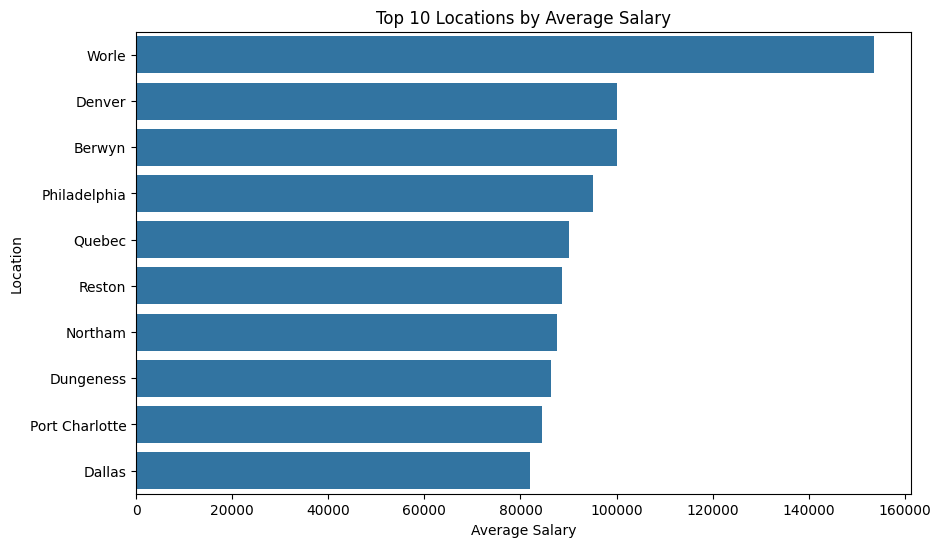

In [63]:
# Avg Salary by Location
salaries_by_location = (
    df.groupby("LocationNormalized")["SalaryNormalized"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=salaries_by_location.values, y=salaries_by_location.index)
plt.title("Top 10 Locations by Average Salary")
plt.xlabel("Average Salary")
plt.ylabel("Location")
plt.show()

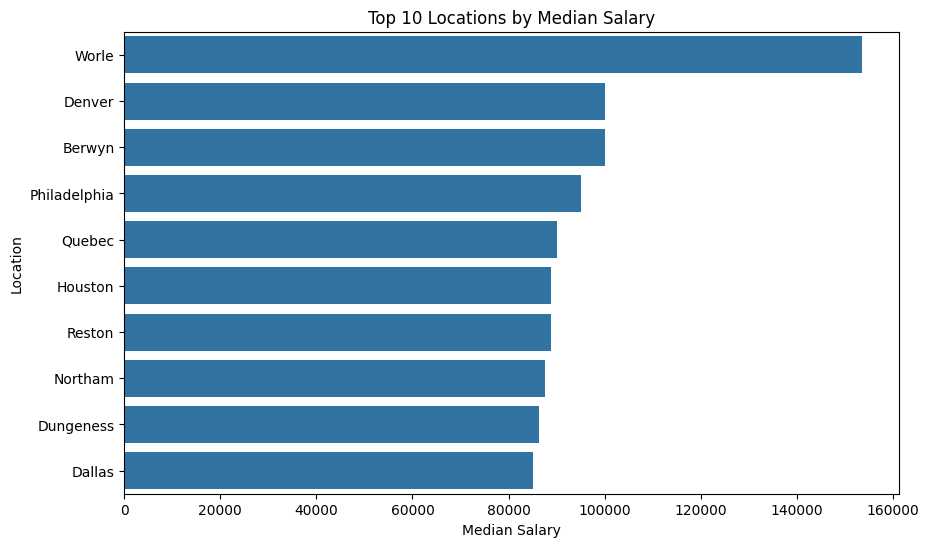

In [64]:
# Median Salary by Location
salaries_by_location_median = (
    df.groupby("LocationNormalized")["SalaryNormalized"]
    .median()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=salaries_by_location_median.values, y=salaries_by_location_median.index)
plt.title("Top 10 Locations by Median Salary")
plt.xlabel("Median Salary")
plt.ylabel("Location")
plt.show()

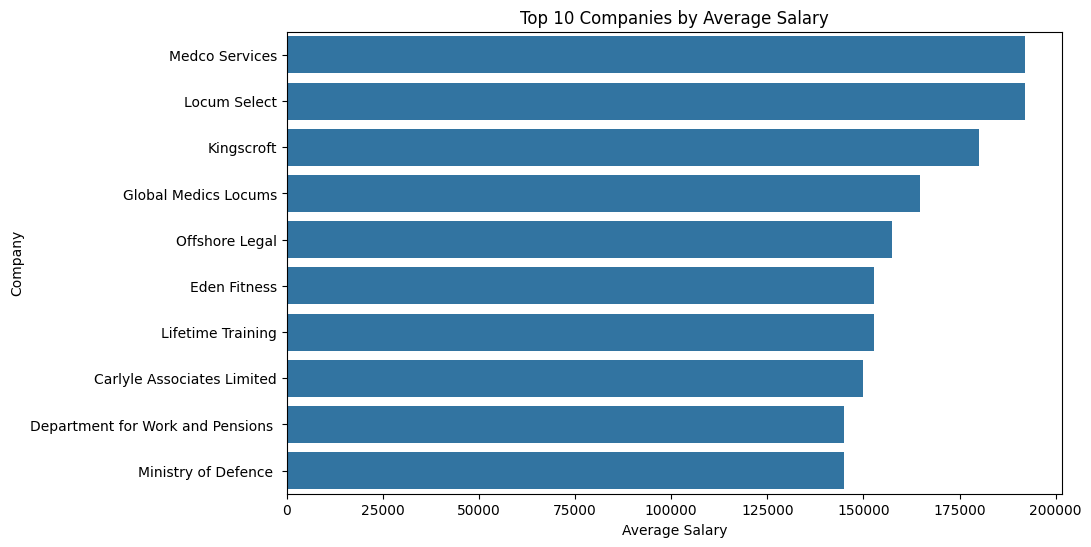

In [65]:
# Highest paying companies
highest_paying_companies = (
    df.groupby("Company")["SalaryNormalized"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=highest_paying_companies.values, y=highest_paying_companies.index)
plt.title("Top 10 Companies by Average Salary")
plt.xlabel("Average Salary")
plt.ylabel("Company")
plt.show()

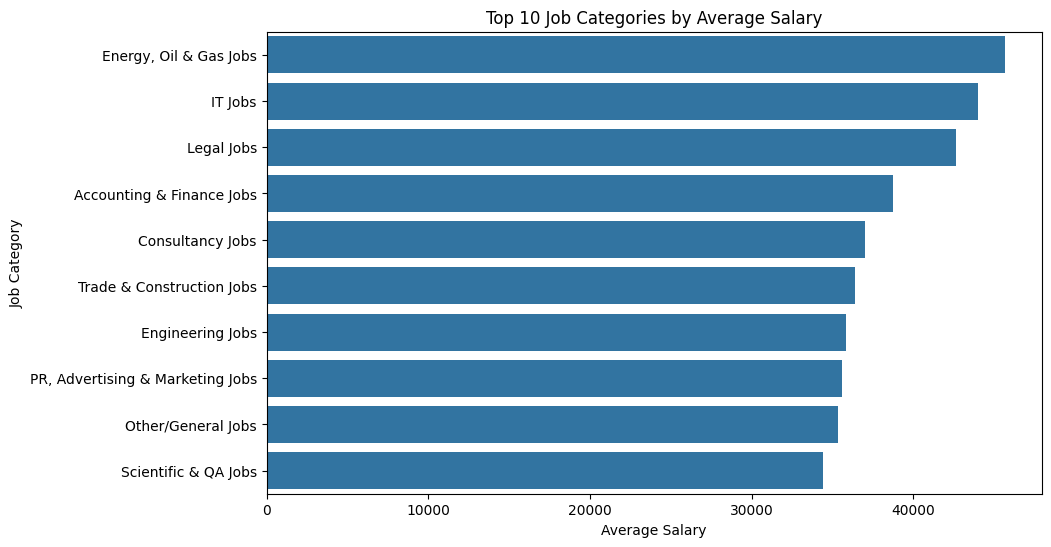

In [66]:
# Highest paying categories
salaries_by_category = (
    df.groupby("Category")["SalaryNormalized"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=salaries_by_category.values, y=salaries_by_category.index)
plt.title("Top 10 Job Categories by Average Salary")
plt.xlabel("Average Salary")
plt.ylabel("Job Category")
plt.show()

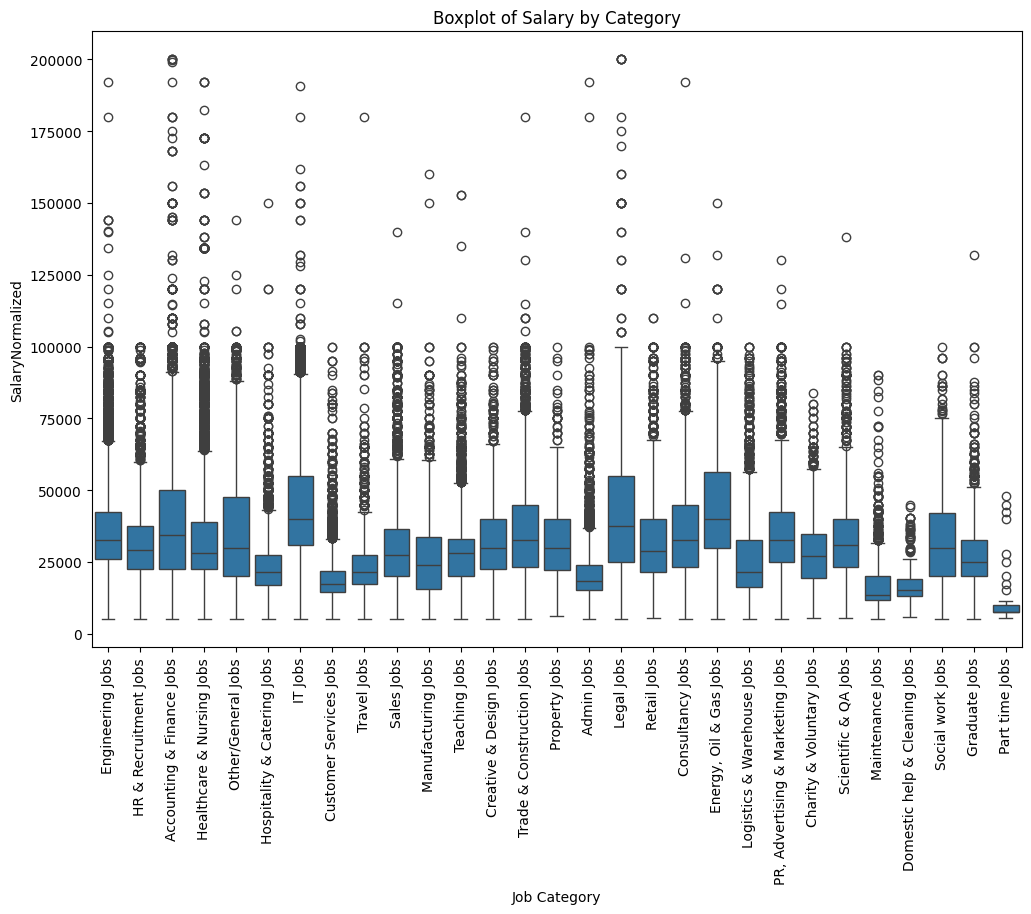

In [67]:
# Boxplot of Salary by Category
plt.figure(figsize=(12, 8))
sns.boxplot(x="Category", y="SalaryNormalized", data=df)
plt.title("Boxplot of Salary by Category")
plt.xlabel("Job Category")
plt.ylabel("SalaryNormalized")
plt.xticks(rotation=90)
plt.show()

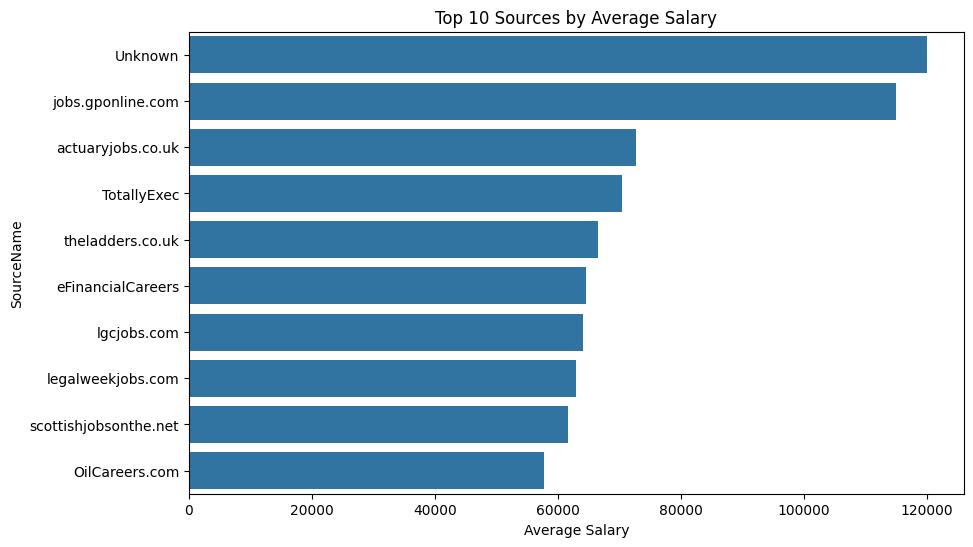

In [68]:
# Salary by SourceName
salaries_by_source = (
    df.groupby("SourceName")["SalaryNormalized"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=salaries_by_source.values, y=salaries_by_source.index)
plt.title("Top 10 Sources by Average Salary")
plt.xlabel("Average Salary")
plt.ylabel("SourceName")
plt.show()

## Functions to keep track of all models

In [69]:
all_models_results = {}

In [ ]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model: PyTorch model

    Returns:
        int: Number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def collect_model_metrics_manual(
    model: nn.Module,
    model_name: str,
    train_losses_scaled: list,
    valid_losses_scaled: list,
    train_losses_real: list,
    valid_losses_real: list,
    test_metrics: dict,
    elapsed_time: float,
    loss_fn: str = "mse",
) -> dict:
    """
    Collect metrics from manually trained models (not using train_model function).
    Use this for models trained with custom training loops.

    Args:
        model: nn.Module, Trained PyTorch model
        model_name: str, Name/identifier for the model
        train_losses_scaled: list, List of training losses (scaled) per epoch
        valid_losses_scaled: list, List of validation losses (scaled) per epoch
        train_losses_real: list, List of training losses (real scale) per epoch - MSE or MAE
        valid_losses_real: list, List of validation losses (real scale) per epoch - MSE or MAE
        test_metrics: dict, Dictionary with test metrics (e.g., {'Test MSE (scaled)': ..., 'Test MSE (real)': ..., 'Test RMSE (real)': ...})
        elapsed_time: float, Training time in seconds
        loss_fn: str, Loss function used ('mse' or 'mae'), default 'mse'

    Returns:
        dict, Dictionary containing all model information and metrics
    """

    # Count trainable parameters
    n_params = count_parameters(model)

    # Find best validation epoch
    best_valid_idx = np.argmin(valid_losses_real)

    # Create history dict in the format expected by other functions
    if loss_fn == "mse":
        history = {
            "train_loss_scaled": train_losses_scaled,
            "valid_loss_scaled": valid_losses_scaled,
            "train_mse_real": train_losses_real,
            "valid_mse_real": valid_losses_real,
            "train_rmse": [np.sqrt(x) for x in train_losses_real],
            "valid_rmse": [np.sqrt(x) for x in valid_losses_real],
        }
    else:  # mae
        history = {
            "train_loss_scaled": train_losses_scaled,
            "valid_loss_scaled": valid_losses_scaled,
            "train_mae_real": train_losses_real,
            "valid_mae_real": valid_losses_real,
        }

    # Build comprehensive results dictionary
    results = {
        "model_name": model_name,
        "n_trainable_params": n_params,
        "training_time_seconds": elapsed_time,
        "training_time_minutes": elapsed_time / 60,
        "epochs_trained": len(train_losses_scaled),
        "best_epoch": best_valid_idx + 1,
        # Test metrics
        **test_metrics,
        # Full training history
        "history": history,
    }

    # Add loss-specific metrics (best epoch only)
    if loss_fn == "mse":
        results["train_mse_real"] = train_losses_real[best_valid_idx]
        results["train_rmse_real"] = np.sqrt(train_losses_real[best_valid_idx])
        results["valid_mse_real"] = valid_losses_real[best_valid_idx]
        results["valid_rmse_real"] = np.sqrt(valid_losses_real[best_valid_idx])
    else:  # mae
        results["train_mae_real"] = train_losses_real[best_valid_idx]
        results["valid_mae_real"] = valid_losses_real[best_valid_idx]

    return results


def collect_model_metrics(
    model: nn.Module,
    history: dict,
    elapsed_time: float,
    test_metrics: dict,
    model_name: str,
    loss_fn: str = "mse",
) -> dict:
    """
    Collect all model metrics into a single dictionary.

    Args:
        model: nn.Module, Trained PyTorch model
        history: dict, History dictionary from train_model function
        elapsed_time: float, Training time in seconds from train_model function
        test_metrics: dict, Test metrics dictionary from evaluate_model function
        model_name: str, Name/identifier for the model
        loss_fn: str, Loss function used ('mse' or 'mae')

    Returns:
        dict, Dictionary containing all model information and metrics
    """

    # Count trainable parameters
    n_params = count_parameters(model)

    # Get number of epochs trained
    epochs_trained = len(history["train_loss_scaled"])

    # Find best validation epoch (minimum validation loss)
    if loss_fn == "mse":
        best_valid_idx = np.argmin(history["valid_rmse"])
        best_train_rmse = history["train_rmse"][best_valid_idx]
        best_valid_rmse = history["valid_rmse"][best_valid_idx]
        best_train_mse = history["train_mse_real"][best_valid_idx]
        best_valid_mse = history["valid_mse_real"][best_valid_idx]
    else:  # mae
        best_valid_idx = np.argmin(history["valid_mae_real"])
        best_train_mae = history["train_mae_real"][best_valid_idx]
        best_valid_mae = history["valid_mae_real"][best_valid_idx]

    # Build comprehensive results dictionary
    results = {
        "model_name": model_name,
        "n_trainable_params": n_params,
        "training_time_seconds": elapsed_time,
        "training_time_minutes": elapsed_time / 60,
        "epochs_trained": epochs_trained,
        "best_epoch": best_valid_idx + 1,
        # Test metrics
        **test_metrics,
        # Full training history
        "history": history,
    }

    # Add loss-specific metrics (best epoch only)
    if loss_fn == "mse":
        results["train_mse_real"] = best_train_mse
        results["train_rmse_real"] = best_train_rmse
        results["valid_mse_real"] = best_valid_mse
        results["valid_rmse_real"] = best_valid_rmse
    else:  # mae
        results["train_mae_real"] = best_train_mae
        results["valid_mae_real"] = best_valid_mae

    return results


def results_to_dataframe(results_dict: dict) -> pd.DataFrame:
    """
    Convert results dictionary to a pandas DataFrame for easy comparison.

    Args:
        results_dict: dict, Dictionary with model results (each value is output from collect_model_metrics)

    Returns:
        pd.DataFrame, pandas DataFrame with key metrics for each model
    """

    summary_data = []
    for model_name, metrics in results_dict.items():
        row = {
            "Model": model_name,
            "Parameters": metrics["n_trainable_params"],
            "Training Time (min)": round(metrics["training_time_minutes"], 2),
            "Epochs": metrics["epochs_trained"],
            "Best Epoch": metrics["best_epoch"],
        }

        # Add loss-specific metrics (best epoch only)
        if "Test RMSE (real)" in metrics:
            row["Train RMSE"] = round(metrics["train_rmse_real"], 2)
            row["Valid RMSE"] = round(metrics["valid_rmse_real"], 2)
            row["Test RMSE"] = round(metrics["Test RMSE (real)"], 2)
        elif "Test MAE (real)" in metrics:
            row["Train MAE"] = round(metrics["train_mae_real"], 2)
            row["Valid MAE"] = round(metrics["valid_mae_real"], 2)
            row["Test MAE"] = round(metrics["Test MAE (real)"], 2)

        summary_data.append(row)

    return pd.DataFrame(summary_data)


def print_model_parameters_summary(
    model: nn.Module, logger: logging.Logger = None
) -> None:
    """
    Prints the parameter count for each named layer and the total sum.
    Args:
        model: The PyTorch model whose parameters are to be summarized.
        logger: Optional logger instance for output
    """
    total_params = 0

    # Print layer-wise details
    for name, param in model.named_parameters():
        num_params = param.numel()
        if logger:
            logger.info(
                f"{name}: {num_params:,} parameters, trainable={param.requires_grad}"
            )
        total_params += num_params

    # Print summed total
    if logger:
        logger.info("-" * 40)
        logger.info(f"Total Parameters: {total_params:,}")


## Phase 1: Baseline with categorical features

In [71]:
# Dictionary to store results for the categorical models
categorical_model_test_results = {}

In the first phase, we will create a baseline model using only categorical features. This will help us understand the performance of a simple model before incorporating text data. We will include columns: Category, Company, LocationNormalized, ContractType and ContractTime. As for now we will fill missing values with 'Unknown' value.


In [72]:
df = pd.read_csv(FILEPATH)
df.loc[df["Title"].isnull(), "Title"] = "Quality Improvement Manager"
cols_with_na = ["ContractType", "ContractTime", "Company", "SourceName"]
df[cols_with_na] = df[cols_with_na].fillna("Unknown")

In [73]:
df_cat = df[
    [
        "Category",
        "Company",
        "LocationNormalized",
        "ContractType",
        "ContractTime",
        "SalaryNormalized",
    ]
]
df_cat.head()

Category                       Company LocationNormalized  \
0  Engineering Jobs  Gregory Martin International            Dorking   
1  Engineering Jobs  Gregory Martin International            Glasgow   
2  Engineering Jobs  Gregory Martin International          Hampshire   
3  Engineering Jobs  Gregory Martin International             Surrey   
4  Engineering Jobs  Gregory Martin International             Surrey   

  ContractType ContractTime  SalaryNormalized  
0      Unknown    permanent             25000  
1      Unknown    permanent             30000  
2      Unknown    permanent             30000  
3      Unknown    permanent             27500  
4      Unknown    permanent             25000

 We need to convert categorical variables into numerical format.

In [74]:
for col in df_cat.columns:
    logger.info(f"{col}: {df_cat[col].nunique()} unique values")

INFO - Category: 29 unique values
INFO - Company: 20812 unique values
INFO - LocationNormalized: 2732 unique values
INFO - ContractType: 3 unique values
INFO - ContractTime: 3 unique values
INFO - SalaryNormalized: 8454 unique values


For columns Category, ContractType and ContractTime we will use One-Hot Encoding as they have a small number of unique values.
For columns Company and LocationNormalized we will use Target Encoding as they have a large number of unique values.

Before transforming our categorical variables, let's split the data into training, validation and test sets to avoid data leakage.

### Splitting the data into training, validation and test sets

In [75]:
X = df_cat.drop(columns=["SalaryNormalized"])
y = df_cat["SalaryNormalized"]

# Split the data into training (80%), validation (10%) and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)
logger.info(f"Train set has {len(X_train)} entries")
logger.info(f"Validation set has {len(X_valid)} entries")
logger.info(f"Test set has {len(X_test)} entries")

INFO - Train set has 195814 entries
INFO - Validation set has 24477 entries
INFO - Test set has 24477 entries


### Creating custom Dataset class

In [ ]:
class SalaryDataset(Dataset):
    def __init__(
        self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]
    ) -> None:
        """
        Custom PyTorch Dataset for salary prediction using given features.

        This class handles the conversion of preprocessed features and scaled targets
        from numpy arrays or pandas data structures into PyTorch tensors.
        Prepared to use both only with categorical features and with mixed features.

        Args:
            X: Union[np.ndarray, pd.DataFrame], Features for the dataset, can be a numpy array or a pandas DataFrame.
            y: Union[np.ndarray, pd.Series], Target values (salaries) for the dataset, can be a numpy array or a pandas Series.
        """

        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves a single sample by its index.

            Args:
                idx: int, The index of the sample to retrieve.
            Returns:
                tuple[torch.Tensor, torch.Tensor]: A tuple containing:
                    - features: torch.Tensor, The input features.
                    - target: torch.Tensor, The target value.
        """
        return self.X[idx], self.y[idx]


### Preprocessing pipeline

Before feeding the data into custom Dataset class, we will create a preprocessing pipeline that will handle the transformations of categorical variables and scaling of the target variable.

In [ ]:
one_hot_cols = ["Category", "ContractType", "ContractTime"]
target_enc_cols = ["Company", "LocationNormalized"]
target_col = "SalaryNormalized"

# One-hot encoding pipeline for columns with few unique values
one_hot_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

# Target encoding pipeline for columns with many unique values, followed by scaling
target_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("target_enc", TargetEncoder()),
        ("scaler", StandardScaler()),
    ]
)

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ("onehot", one_hot_pipeline, one_hot_cols),
        ("target_scaled", target_pipeline, target_enc_cols),
    ]
)

# Fit and transform training data, transform validation and test data
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

# Scale target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create PyTorch datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save preprocessor and scaler for later use
joblib.dump(preprocessor, os.path.join(PREPROCESSORS_DIR, "preprocessor.pkl"))
joblib.dump(target_scaler, os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

['preprocessors/target_scaler.pkl']

### Creating data loaders

In [78]:
batch_size = 32
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [79]:
# Check number of batches
logger.info(f"Number of training batches: {len(train_loader)}")
logger.info(f"Number of validation batches: {len(valid_loader)}")
logger.info(f"Number of test batches: {len(test_loader)}")

INFO - Number of training batches: 6120
INFO - Number of validation batches: 765
INFO - Number of test batches: 765


In [80]:
for X_batch, y_batch in train_loader:
    logger.info(f"Batch X shape: {X_batch.shape}")
    logger.info(f"Batch y shape: {y_batch.shape}")
    logger.info(f"Batch X: {X_batch}")
    logger.info(f"Batch y: {y_batch}")
    break  # Just to check the first batch

INFO - Batch X shape: torch.Size([32, 37])
INFO - Batch y shape: torch.Size([32])
INFO - Batch X: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.8252,  1.4715],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.1705, -1.1909],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000, -0.0582, -0.0568],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  2.6743,  1.1740],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.3381, -1.1879],
        [ 1.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0488,  1.9749]])
INFO - Batch y: tensor([ 0.3334,  0.3334, -0.0829, -0.2803,  0.1535,  0.6781, -0.7152, -0.5168,
         2.6009, -0.6007,  0.5318,  0.9286,  0.1379,  2.0340,  1.6088, -0.9136,
         1.1270,  0.2201, -0.2901,  0.4604, -0.2618, -0.5735, -0.2901,  2.5555,
         0.2427,  0.3901,  0.9003,  2.3174, -0.8570,  0.4043, -0.3751, -0.0917])


### Building simple model

In [ ]:
class SimpleRegressor(nn.Module):
    """
    A simple feed-forward neural network for regression tasks.

    This model consists of two hidden layers with ReLU activation and dropout,
    followed by an output layer with a single neuron.
    """

    def __init__(
        self, input_dim: int, hidden_size: int = 64, dropout_prob: float = 0.3
    ) -> None:
        """
        Initializes the SimpleRegressor model.
        Args:
            input_dim: The number of features in the input data.
            hidden_size: The number of neurons in the first hidden layer. The second
                         hidden layer will have half this number. Defaults to 64.
            dropout_prob: The dropout probability for the dropout layers. Defaults to 0.3.
        """
        super(SimpleRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            x: torch.Tensor, Input features tensor.
            Returns:
                torch.Tensor: Predicted continuous target value.
        """
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Training the model

#### Custom Early Stopping class

In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    This class monitors the validation loss and halts the training process if
    the loss does not decrease for a specified number of epochs. It can also
    restore the model's weights from the best-performing epoch.
    """

    def __init__(
        self,
        patience: int = 5,
        delta: float = 0,
        verbose: bool = False,
        restore_best_weights: bool = True,
        logger: logging.Logger = None,
    ) -> None:
        """
        Initializes the EarlyStopping instance.

        Args:
            patience: int, How many epochs to wait for a validation loss improvement before
                      stopping. Defaults to 5.
            delta: float, Minimum change in the monitored quantity to qualify as an improvement.
                   Defaults to 0.
            verbose: bool, If True, prints a message for each improvement and when early stopping
                     is triggered. Defaults to False.
            restore_best_weights: bool, If True, the model's weights from the best-performing
                                  epoch are restored upon early stopping. Defaults to True.
            logger: Optional[logging.Logger], Optional logger instance. If None and verbose is True, will print to console.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.logger = logger
        self.best_loss = None
        self.best_weights = None
        self.no_improvement_count = 0
        self.stop_training = False

    def _log(self, message: str, level: str = "info") -> None:
        """
        Internal method to handle logging/printing.

        Args:
            message: str, The message to log or print
            level: str, Logging level ('info', 'warning', 'debug'), default 'info'
        """
        if self.verbose:
            if self.logger:
                if level == "info":
                    self.logger.info(message)
                elif level == "warning":
                    self.logger.warning(message)
                elif level == "debug":
                    self.logger.debug(message)
            else:
                print(message)

    def check_early_stop(self, val_loss: float, model: torch.nn.Module) -> None:
        """
        Checks the validation loss and updates the internal state.

        Args:
            val_loss: float, The current validation loss.
            model: torch.nn.Module, The PyTorch model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            # Improvement detected
            improvement = self.best_loss - val_loss if self.best_loss is not None else 0
            self.best_loss = val_loss
            self.no_improvement_count = 0

            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()

            if self.best_loss is not None and improvement > 0:
                self._log(
                    f"Validation loss improved by {improvement:.6f} to {val_loss:.6f}"
                )
            else:
                self._log(f"Initial validation loss: {val_loss:.6f}")
        else:
            # No improvement
            self.no_improvement_count += 1

            if self.no_improvement_count == 1:
                self._log(
                    f"No improvement in validation loss for {self.no_improvement_count} epoch",
                    level="debug",
                )
            else:
                self._log(
                    f"No improvement in validation loss for {self.no_improvement_count} epochs",
                    level="debug",
                )

            if self.no_improvement_count >= self.patience:
                self.stop_training = True

                self._log(
                    f"Early stopping triggered after {self.no_improvement_count} epochs without improvement",
                    level="warning",
                )

                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
                    self._log("Restored best model weights", level="info")

                self._log(f"Best validation loss: {self.best_loss:.6f}", level="info")


#### Fuction to plot training and validation loss from lists of losses

In [ ]:
def plot_losses_from_lists(
    train_losses: list[float],
    valid_losses: list[float],
    train_real_losses: Optional[list[float]] = None,
    valid_real_losses: Optional[list[float]] = None,
    save_path: Optional[str] = None,
    logger: Optional[logging.Logger] = None,
) -> None:
    """
    Plot training and validation losses.

    This function can plot either the scaled losses or both scaled and real-scale
    losses side-by-side, depending on whether the real-scale losses are provided.

    Args:
        train_losses: list[float], A list of scaled training loss values, one for each epoch.
        valid_losses: list[float], A list of scaled validation loss values, one for each epoch.
        train_real_losses: Optional[list[float]], An optional list of real-scale training loss values.
                           Defaults to None.
        valid_real_losses: Optional[list[float]], An optional list of real-scale validation loss values.
                           Defaults to None.
        save_path: Optional[str], path to save the plot image. If None, the plot is shown
                   but not saved.
        logger: Optional[logging.Logger], logger instance for output.
    """
    if train_real_losses is None or valid_real_losses is None:
        # Only plot scaled losses
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        epochs = range(1, len(train_losses) + 1)
        ax.plot(epochs, train_losses, color="blue", label="Train Loss", linewidth=2)
        ax.plot(
            epochs, valid_losses, color="orange", label="Validation Loss", linewidth=2
        )
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel("Loss (Scaled MSE)", fontsize=12)
        ax.set_title("Training and Validation Loss", fontsize=14, fontweight="bold")
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)

    else:
        # Plot both scaled and real losses
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        epochs = range(1, len(train_losses) + 1)

        # Plot 1: Scaled MSE
        axes[0].plot(
            epochs, train_losses, color="blue", label="Train Loss", linewidth=2
        )
        axes[0].plot(
            epochs, valid_losses, color="orange", label="Validation Loss", linewidth=2
        )
        axes[0].set_xlabel("Epoch", fontsize=11)
        axes[0].set_ylabel("Loss (Scaled MSE)", fontsize=11)
        axes[0].set_title("Scaled MSE Loss", fontsize=12, fontweight="bold")
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Real MSE
        axes[1].plot(
            epochs, train_real_losses, color="blue", label="Train Loss", linewidth=2
        )
        axes[1].plot(
            epochs,
            valid_real_losses,
            color="orange",
            label="Validation Loss",
            linewidth=2,
        )
        axes[1].set_xlabel("Epoch", fontsize=11)
        axes[1].set_ylabel("Loss (Real MSE)", fontsize=11)
        axes[1].set_title("Real Scale MSE Loss", fontsize=12, fontweight="bold")
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        if logger:
            logger.info(f"Loss plot saved to {save_path}.")
    plt.show()

#### Training loop

In [84]:
# Set random seed for reproducibility
set_seed()

# model_name
model_name = "cat_unk_bs32_adam_lrs_no_hid128_dr20"

# Define model hyperparameters
input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

# Initialize the model and move to device
model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

# Define loss function and optimizer
lr = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Load target scaler for inverse transformation
target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

# Training loop parameters
n_epochs = 20
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

# Log model architecture
logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {lr}")

logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")


# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss (scaled)
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate scaled loss
        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    # Average training losses
    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    # Validation loop
    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average validation losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time

logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: cat_unk_bs32_adam_lrs_no_hid128_dr20
INFO - Model architecture: SimpleRegressor(input_dim=37, hidden_size=128, dropout_prob=0.2)
INFO - Number of parameters: 13185
INFO - Using device: mps
INFO - Batch size: 32
INFO - Learning rate: 0.001
INFO - Training for a maximum of 20 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/20:
INFO -   Train - MSE: 0.5855, Real MSE: 182213323.86, Real RMSE: 13498.64
INFO -   Valid - MSE: 0.6091, Real MSE: 189575174.81, Real RMSE: 13768.63
INFO - Initial validation loss: 0.609148
INFO - Epoch 2/20:
INFO -   Train - MSE: 0.5715, Real MSE: 177861022.87, Real RMSE: 13336.45
INFO -   Valid - MSE: 0.6058, Real MSE: 188522136.91, Real RMSE: 13730.34
INFO - Validation loss improved by 0.003384 to 0.605765
INFO - Epoch 3/20:
INFO -   Train - MSE: 0.5677, Real MSE: 176676058.50, Real RMSE: 13291.95
INFO -   Valid - MSE: 0.6033, R

- `.reshape(-1, 1)` - StandardScaler expects 2D input, so reshape the 1D arrays
- `.ravel()` - Flatten back to 1D after inverse transform for easier calculation
- `.detach()` - Remove from computation graph (important in training loop)
- `.cpu()` - Move to CPU for numpy operations

#### Plotting training and validation loss

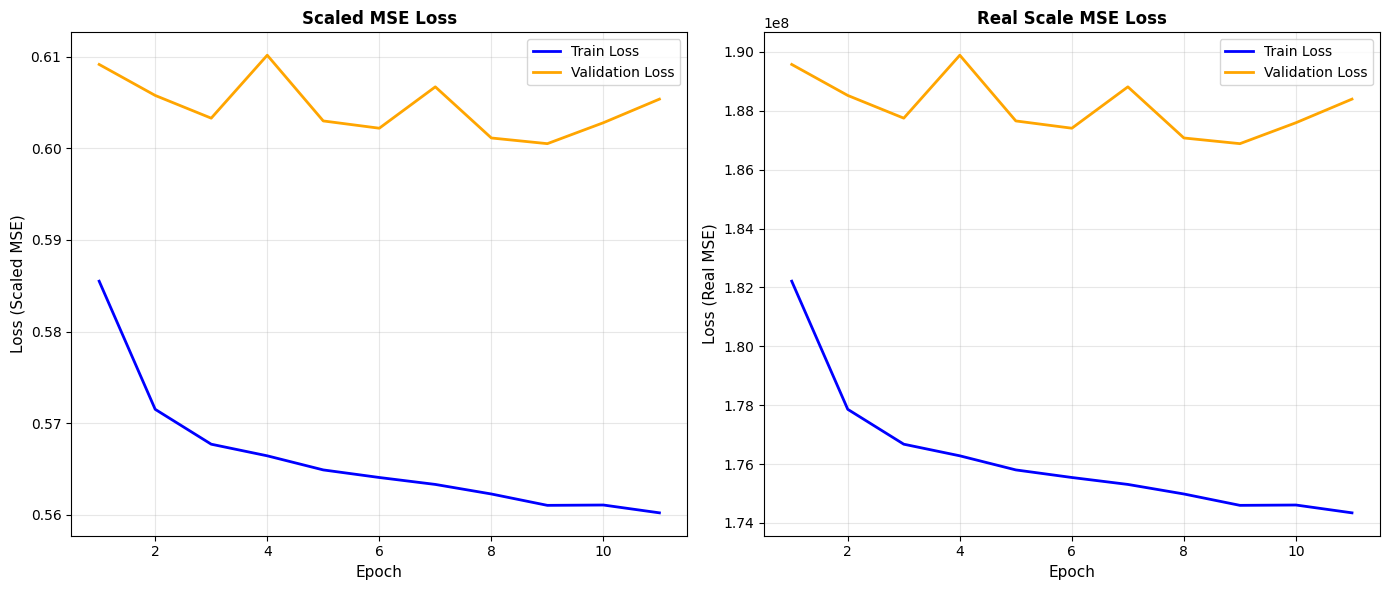

In [85]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

#### Explore model parameters

In [86]:
def print_model_parameters_summary(
    model: nn.Module, logger: logging.Logger = None
) -> None:
    """
    Prints the parameter count for each named layer and the total sum.
    Args:
        model: The PyTorch model whose parameters are to be summarized.
    """
    total_params = 0

    # Print layer-wise details
    for name, param in model.named_parameters():
        num_params = param.numel()
        if logger:
            logger.info(
                f"{name}: {num_params:,} parameters, trainable={param.requires_grad}"
            )
        total_params += num_params

    # Print summed total
    if logger:
        logger.info("-" * 40)
        logger.info(f"Total Parameters: {total_params:,}")

In [ ]:
# print_model_parameters_summary(model, logger)

#### Save the model

In [88]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

#### Evaluate on test set for later comparison

In [89]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    categorical_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [90]:
all_models_results["CategoricalModelv1"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=categorical_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Hyperparameter tuning / other approaches

#### Replacing missing values with most frequent values

In [ ]:
df = pd.read_csv(FILEPATH)
df = df.drop(columns=["Id"])
df_cat = df[
    [
        "Category",
        "Company",
        "LocationNormalized",
        "ContractType",
        "ContractTime",
        "SalaryNormalized",
    ]
]
X = df_cat.drop(columns=["SalaryNormalized"])
y = df_cat["SalaryNormalized"]

# Split the data into training (80%), validation (10%) and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)

one_hot_cols = ["Category", "ContractType", "ContractTime"]
target_enc_cols = ["Company", "LocationNormalized"]
target_col = "SalaryNormalized"

# One-hot encoding pipeline for columns with few unique values
one_hot_pipeline = Pipeline(
    [
        (
            "imputer",
            SimpleImputer(strategy="most_frequent"),
        ),  # fill missing values with most frequent
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

# Target encoding pipeline for columns with many unique values, followed by scaling
target_pipeline = Pipeline(
    [
        (
            "imputer",
            SimpleImputer(strategy="most_frequent"),
        ),  # fill missing values with most frequent
        ("target_enc", TargetEncoder()),
        ("scaler", StandardScaler()),
    ]
)

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ("onehot", one_hot_pipeline, one_hot_cols),
        ("target_scaled", target_pipeline, target_enc_cols),
    ]
)

# Fit and transform training data, transform validation and test data
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

# Scale target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create PyTorch datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save preprocessor and scaler for later use
joblib.dump(preprocessor, os.path.join(PREPROCESSORS_DIR, "preprocessor.pkl"))
joblib.dump(target_scaler, os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

batch_size = 32
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [92]:
# Set random seed for reproducibility
set_seed()

model_name = "cat_mf_bs32_adam_lrs_no_hid128_dr20"

# Define model architecture parameters
input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

# Initialize the regression model and move to device
model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load target scaler for inverse transformation
target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

# Training configuration
n_epochs = 30
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

# Logging
logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {0.001}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss for each epoch
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss in scaled space
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate scaled loss
        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    # Calculate average training losses
    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    # Validation loop
    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Calculate average validation losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping condition
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time

logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: cat_mf_bs32_adam_lrs_no_hid128_dr20
INFO - Model architecture: SimpleRegressor(input_dim=35, hidden_size=128, dropout_prob=0.2)
INFO - Number of parameters: 12929
INFO - Using device: mps
INFO - Batch size: 32
INFO - Learning rate: 0.001
INFO - Training for a maximum of 30 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.5963, Real MSE: 185575972.22, Real RMSE: 13622.63
INFO -   Valid - MSE: 0.6193, Real MSE: 192737026.66, Real RMSE: 13882.98
INFO - Initial validation loss: 0.619308
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.5842, Real MSE: 181816772.99, Real RMSE: 13483.95
INFO -   Valid - MSE: 0.6197, Real MSE: 192851242.05, Real RMSE: 13887.09
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.5810, Real MSE: 180824259.52, Real RMSE: 13447.09
INFO -   Valid - MSE: 0.6158, Real MSE: 191632783.09, Real RMSE: 13843.15
INFO - Validat

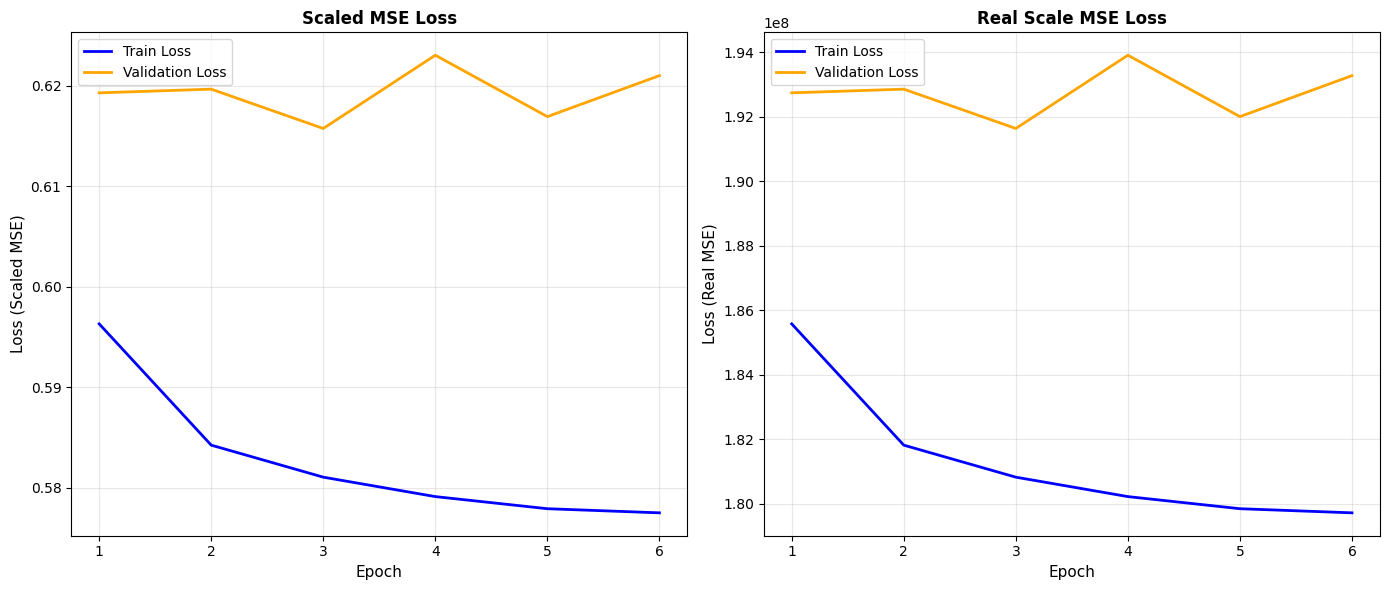

In [93]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [95]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [96]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    categorical_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [97]:
all_models_results["CategoricalModelv2"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=categorical_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

For the next approach we will replace missing values in categorical columns with 'Unknown' value as it gave better results in the previous experiments.

#### Trying batch size 64 

In [ ]:
one_hot_cols = ["Category", "ContractType", "ContractTime"]
target_enc_cols = ["Company", "LocationNormalized"]
target_col = "SalaryNormalized"

one_hot_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

target_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("target_enc", TargetEncoder()),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("onehot", one_hot_pipeline, one_hot_cols),
        ("target_scaled", target_pipeline, target_enc_cols),
    ]
)

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

joblib.dump(preprocessor, os.path.join(PREPROCESSORS_DIR, "preprocessor.pkl"))
joblib.dump(target_scaler, os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [100]:
# Set random seed for reproducibility
set_seed()

model_name = "cat_unk_bs64_adam_lrs_no_hid128_dr20"

# Define model architecture parameters
input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

# Initialize the regression model and move to device
model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load target scaler for inverse transformation
target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

# Training configuration
n_epochs = 30
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {0.001}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss for each epoch
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss in scaled space
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate scaled loss
        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    # Calculate average training losses
    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    # Validation loop
    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Calculate average validation losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping condition
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time

logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: cat_unk_bs64_adam_lrs_no_hid128_dr20
INFO - Model architecture: SimpleRegressor(input_dim=37, hidden_size=128, dropout_prob=0.2)
INFO - Number of parameters: 13185
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 30 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.5868, Real MSE: 182611140.40, Real RMSE: 13513.37
INFO -   Valid - MSE: 0.6049, Real MSE: 188267068.62, Real RMSE: 13721.04
INFO - Initial validation loss: 0.604945
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.5703, Real MSE: 177479159.71, Real RMSE: 13322.13
INFO -   Valid - MSE: 0.6126, Real MSE: 190650212.10, Real RMSE: 13807.61
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.5669, Real MSE: 176421728.47, Real RMSE: 13282.38
INFO -   Valid - MSE: 0.6040, Real MSE: 187973798.55, Real RMSE: 13710.35
INFO - Epoch 

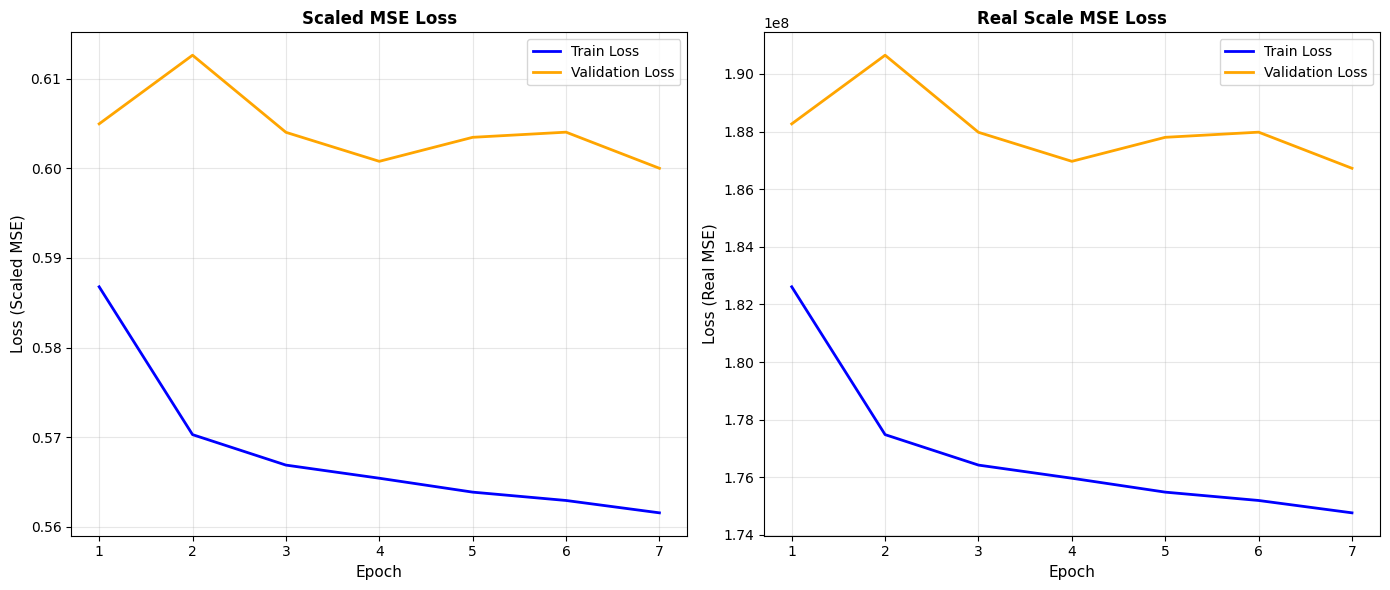

In [101]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [103]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [104]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    categorical_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [105]:
all_models_results["CategoricalModelv3"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=categorical_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Trying less neurons

In [ ]:
set_seed()

model_name = "cat_unk_bs64_adam_lrs_no_hid64_dr20"

input_dim = X_train_processed.shape[1]
hidden_size = 64
dropout_prob = 0.2

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 30
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {0.001}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: cat_unk_bs32_adam_lrs_no_hid64_dr20
INFO - Model architecture: SimpleRegressor(input_dim=37, hidden_size=64, dropout_prob=0.2)
INFO - Number of parameters: 4545
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 30 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.5984, Real MSE: 186234449.11, Real RMSE: 13646.77
INFO -   Valid - MSE: 0.6116, Real MSE: 190328004.45, Real RMSE: 13795.94
INFO - Initial validation loss: 0.611567
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.5770, Real MSE: 179582890.46, Real RMSE: 13400.85
INFO -   Valid - MSE: 0.6051, Real MSE: 188320645.40, Real RMSE: 13723.00
INFO - Validation loss improved by 0.006450 to 0.605117
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.5731, Real MSE: 178367465.03, Real RMSE: 13355.43
INFO -   Valid - MSE: 0.6051, Real

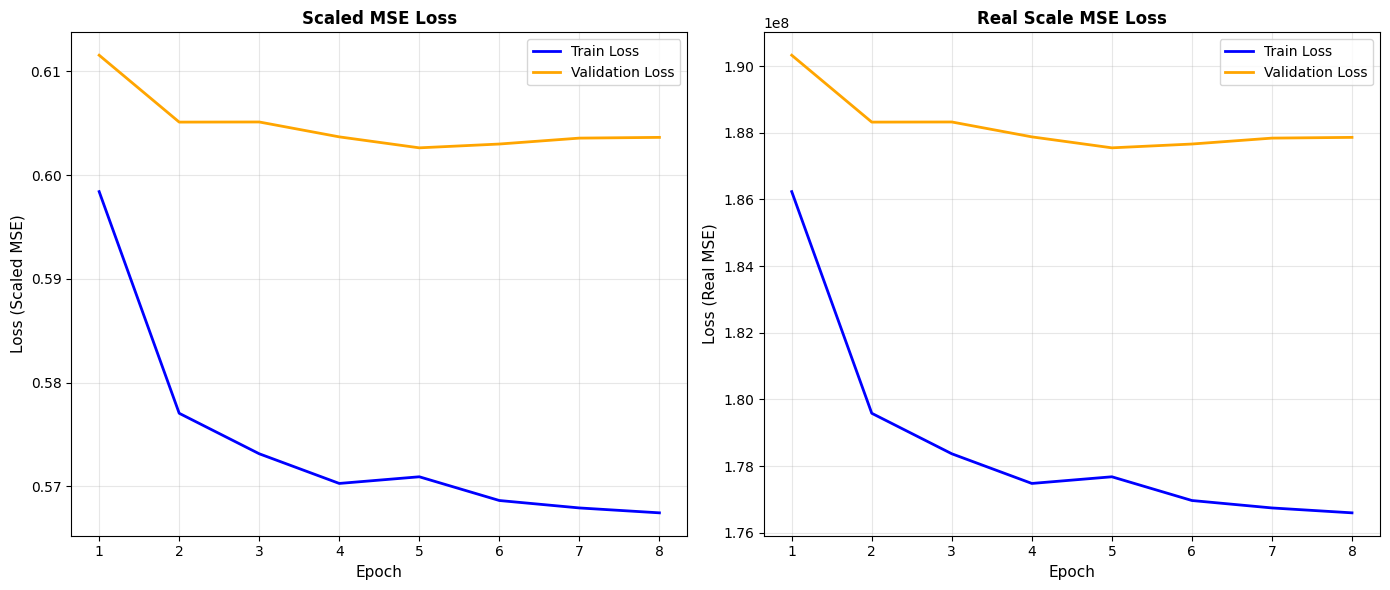

In [107]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [109]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [110]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    categorical_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [111]:
all_models_results["CategoricalModelv4"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=categorical_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Different optimizer

In [112]:
# SGD optimizer with momentum
set_seed()

model_name = "cat_unk_bs64_sgd_lrs_no_hid128_dr20"

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 30
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {0.01}")
logger.info(f"Optimizer other than Adam: SGD with momentum=0.9")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")


# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: cat_unk_bs64_sgd_lrs_no_hid128_dr20
INFO - Model architecture: SimpleRegressor(input_dim=37, hidden_size=128, dropout_prob=0.2)
INFO - Number of parameters: 13185
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.01
INFO - Optimizer other than Adam: SGD with momentum=0.9
INFO - Training for a maximum of 30 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.6016, Real MSE: 187226286.42, Real RMSE: 13683.07
INFO -   Valid - MSE: 0.6098, Real MSE: 189787434.86, Real RMSE: 13776.34
INFO - Initial validation loss: 0.609830
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.5799, Real MSE: 180479996.29, Real RMSE: 13434.28
INFO -   Valid - MSE: 0.6105, Real MSE: 189991312.68, Real RMSE: 13783.73
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.5762, Real MSE: 179331978.06, Real RMSE: 13391.49
INFO -   Valid - MSE: 0.6083, Rea

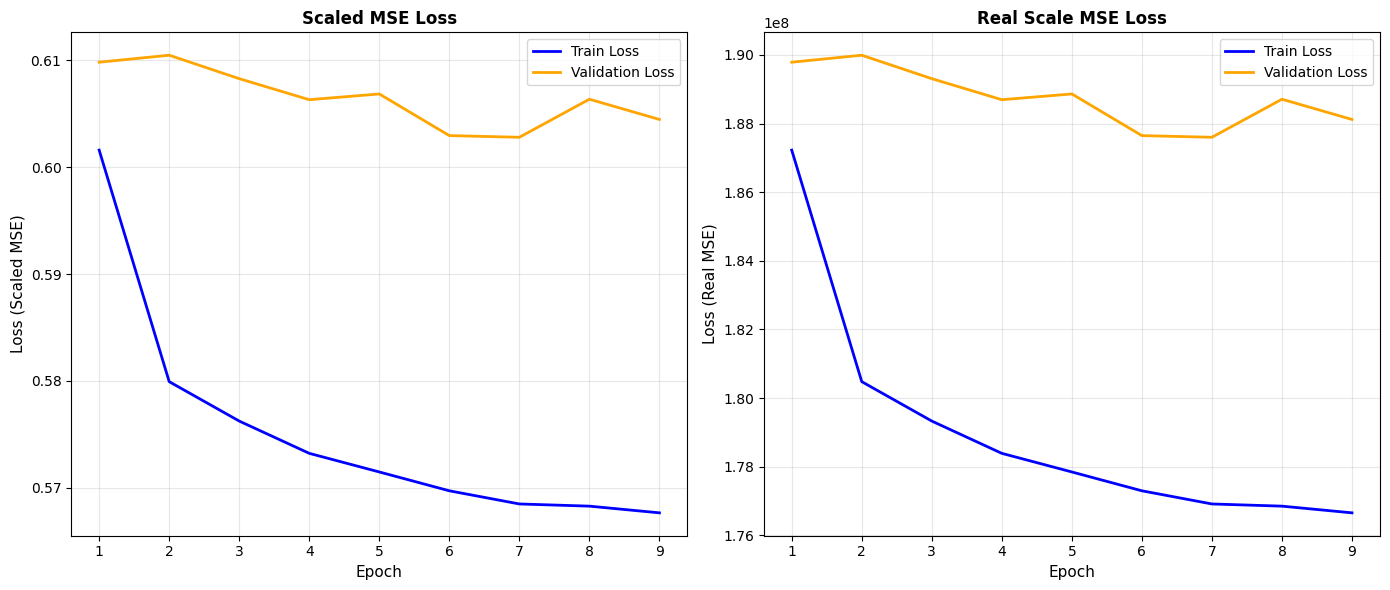

In [113]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [115]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [116]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    categorical_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [117]:
all_models_results["CategoricalModelv5"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=categorical_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Setting learning rate scheduler

In [118]:
set_seed()

model_name = "cat_unk_bs64_adam_lrs_hid128_dr20"

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 30
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=1
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {0.001}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info(
    f"Using learning rate scheduler: ReduceLROnPlateau (factor=0.5, patience=1)"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

    # Step the learning rate scheduler
    lr_scheduler.step(valid_loss_scaled_avg)
    logger.info(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

elapsed_time = time.time() - start_time

logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: cat_unk_bs64_adam_lrs_hid128_dr20
INFO - Model architecture: SimpleRegressor(input_dim=37, hidden_size=128, dropout_prob=0.2)
INFO - Number of parameters: 13185
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 30 epochs with early stopping (patience=3, delta=0.001)
INFO - Using learning rate scheduler: ReduceLROnPlateau (factor=0.5, patience=1)
INFO - ----------------------------
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.5875, Real MSE: 182832471.78, Real RMSE: 13521.56
INFO -   Valid - MSE: 0.6071, Real MSE: 188935452.53, Real RMSE: 13745.38
INFO - Initial validation loss: 0.607093
INFO -   Learning Rate: 0.001000
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.5707, Real MSE: 177616376.21, Real RMSE: 13327.28
INFO -   Valid - MSE: 0.6038, Real MSE: 187906921.19, Real RMSE: 13707.91
INFO - Validation loss improved by 0.003305 to 0.603788
INFO -   Lear

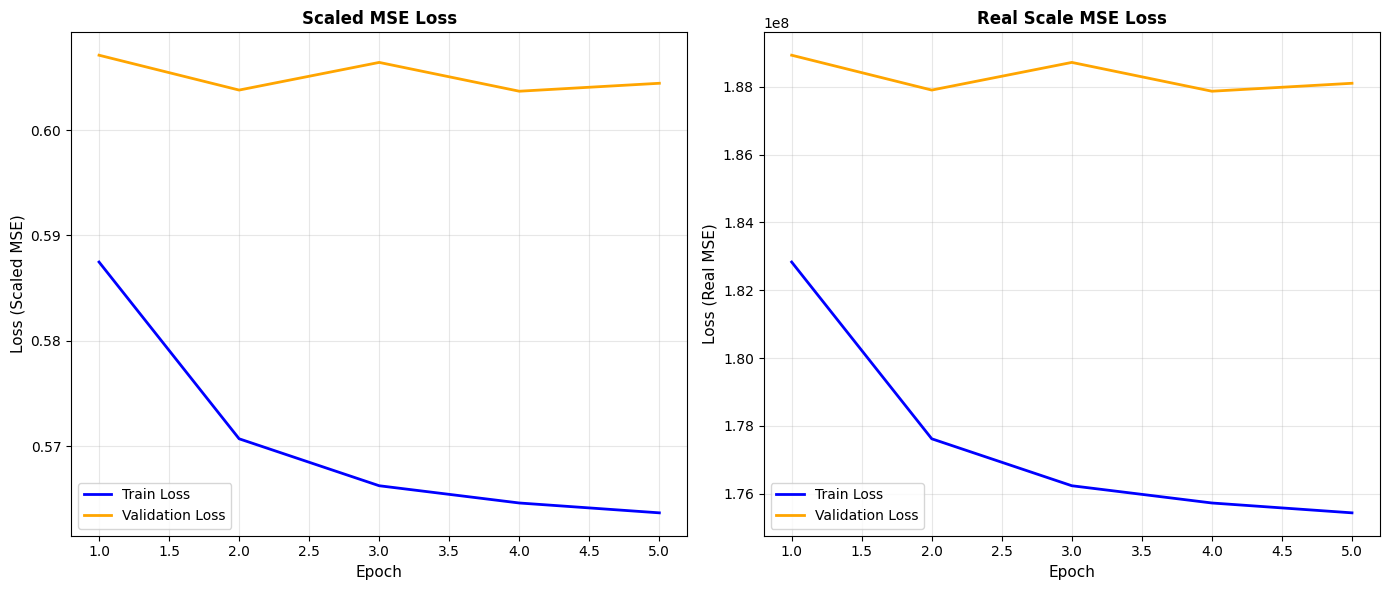

In [119]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [121]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [122]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    categorical_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [123]:
all_models_results["CategoricalModelv6"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=categorical_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Evaluating categorical models on the test set

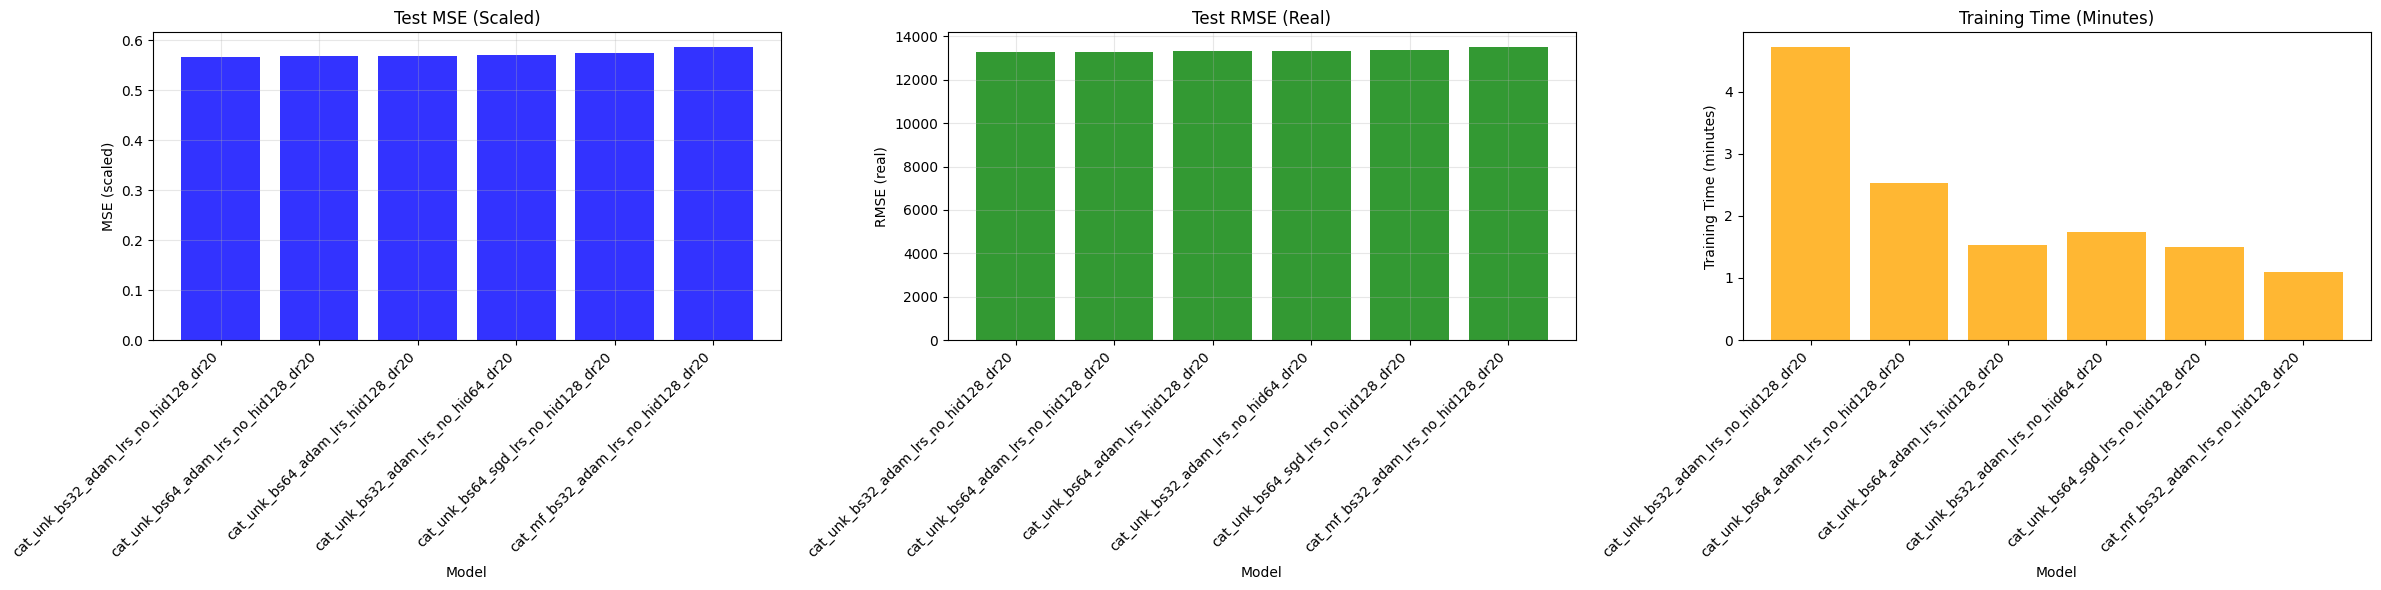

In [124]:
# Extract data
models = list(categorical_model_test_results.keys())
mse_scaled = [categorical_model_test_results[m]["Test MSE (scaled)"] for m in models]
mse_real = [categorical_model_test_results[m]["Test MSE (real)"] for m in models]
rmse_real = [categorical_model_test_results[m]["Test RMSE (real)"] for m in models]
training_times = [
    categorical_model_test_results[m]["Training Time (minutes)"] for m in models
]

# Sort by MSE real
sorted_indices = np.argsort(mse_real)
models_sorted = [models[i] for i in sorted_indices]
mse_scaled_sorted = [mse_scaled[i] for i in sorted_indices]
rmse_real_sorted = [rmse_real[i] for i in sorted_indices]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Left: MSE (scaled only)
ax1.bar(models_sorted, mse_scaled_sorted, alpha=0.8, color="blue")
ax1.set_xlabel("Model")
ax1.set_ylabel("MSE (scaled)")
ax1.set_xticklabels(models_sorted, rotation=45, ha="right")
ax1.set_title("Test MSE (Scaled)")
ax1.grid(alpha=0.3)

# Right: RMSE (real)
ax2.bar(models_sorted, rmse_real_sorted, alpha=0.8, color="green")
ax2.set_xlabel("Model")
ax2.set_ylabel("RMSE (real)")
ax2.set_xticklabels(models_sorted, rotation=45, ha="right")
ax2.set_title("Test RMSE (Real)")
ax2.grid(alpha=0.3)

# Right: Training Time
ax3.bar(models_sorted, training_times, alpha=0.8, color="orange")
ax3.set_xlabel("Model")
ax3.set_ylabel("Training Time (minutes)")
ax3.set_xticklabels(models_sorted, rotation=45, ha="right")
ax3.set_title("Training Time (Minutes)")

plt.tight_layout()
plt.show()

We can see that tuning hyperparameters for such a simple model with a few categorical features does not bring significant improvements.

## Phase 2: Incorporating text data

Text data is present in the **`Title`** and **`FullDescription`** columns.  
We need to preprocess these texts and convert them into a numerical format.

### What we may try to extract from text data and what to do with it:
- **Numbers** — e.g., “5 years experience”, “3+ years”, “2 years of experience”
- **Programming languages** — e.g., “Python”, “Java”, “C++”, “JavaScript”
- **Job seniority levels** — e.g., “Junior”, “Manager”, “Senior”, “Lead”
- **Special characters** — e.g., “+” (C++), “#” (C#), “.” (.NET)
- **Convert all text to lowercase**

### What is not important and may or may not be removed:
- URLs  
- Email addresses  
- Asterisks (`***`) used for salary masking  
- Excessive whitespaces  

### To consider carefully:
- **Stop words** — Usually removed, but in job descriptions they may be meaningful (e.g., “not”, “without”, “no experience required”).  
- **Lemmatization / Stemming** — May alter words with different meanings (e.g., “developer” vs “development”), so should be applied with caution.


When we clean our text data we need to tokenize it.  The text needs to be broken down into individual words or sub-words, called tokens. This is a crucial step in NLP as it allows us to analyze the text at a granular level.

Next step may be vectorization. This is the process of converting text data into numerical format that can be fed into machine learning models. There are several techniques for vectorization, including e.g.:

- TF-IDF (Term Frequency-Inverse Document Frequency)
- Word Embeddings (e.g., Word2Vec, GloVe)

At start I will try TF-IDF as it is simple and effective for many NLP tasks and try Embeddingd from Sentence Transformers.

Later I will create embeddings on my own and also using Word2Vec and Fasttext.

We may also try to include 'SourceName' column as it may contain some useful information about the job offer. It will be also target encoded as it has a large number of unique values.

In [125]:
tfidf_and_embedding_model_test_results = {}

### Custom Text Preprocessor and Tf-Idf Vectorizer

#### Building Text Preprocessor

In [ ]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn compatible transformer for cleaning and preprocessing text data.

    This class handles various text cleaning steps such as converting to lowercase,
    removing URLs, emails, HTML tags, and punctuation. It also includes optional steps
    for removing numbers, stopwords, and lemmatization. It is designed to work with
    pandas DataFrames containing 'Title' and 'FullDescription' columns.
    """

    def __init__(
        self,
        lowercase: bool = True,
        remove_punctuation: bool = False,
        remove_stopwords: bool = False,
        remove_numbers: bool = False,
        lemmatize: bool = False,
    ) -> None:
        """
        Initializes the TextPreprocessor with various preprocessing options.

        Args:
            lowercase: bool, If True, converts all text to lowercase. Defaults to True.
            remove_punctuation: bool, If True, removes all punctuation from the text. Defaults to False.
            remove_stopwords: bool, If True, removes common English stopwords. Defaults to False.
            remove_numbers: bool, If True, removes all numbers from the text. Defaults to False.
            lemmatize: bool, If True, reduces words to their base or root form. Defaults to False.
        """
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.remove_numbers = remove_numbers
        self.lemmatize = lemmatize

        if self.remove_stopwords:
            self.stop_words = set(stopwords.words("english"))
        if self.lemmatize:
            self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text: str) -> str:
        """
        Cleans a single text string based on the initialized parameters.

        Args:
            text: str, The text string to be cleaned.

        Returns:
            The cleaned text string.
        """
        if pd.isnull(text) or text.strip() == "":
            return ""

        text = str(text)

        if self.lowercase:
            text = text.lower()

        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r"\S+@\S+", "", text)

        # Remove HTML tags (just in case)
        text = re.sub(r"<.*?>", "", text)

        # Remove multiple asterisks (e.g., *****)
        text = re.sub(r"\*{2,}", " ", text)

        # Remove extra whitespaces
        text = re.sub(r"\s+", " ", text).strip()

        # Remove special characters
        text = re.sub(r"[^\s\w+#.+-]", "", text)

        # Remove numbers - optional
        if self.remove_numbers:
            text = re.sub(r"\d+", "", text)

        # Remove punctuation - optional
        if self.remove_punctuation:
            text = text.translate(str.maketrans("", "", string.punctuation))

        # Tokenization
        tokens = text.split()

        # Remove stopwords - optional
        if self.remove_stopwords:
            tokens = [word for word in tokens if word not in self.stop_words]

        # Lemmatization - optional
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        # Join tokens back into a single string
        text = " ".join(tokens)

        return text.strip()

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "TextPreprocessor":
        """Fits the transformer. No action needed for this preprocessor."""
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by applying the cleaning steps.

        Args:
            X: pd.DataFrame, The input DataFrame to transform.

        Returns:
            pd.DataFrame, The transformed DataFrame with cleaned text.
        """
        X_copy = X.copy()

        if "Title" in X_copy.columns:
            X_copy["Title"] = X_copy["Title"].apply(self.clean_text)

        if "FullDescription" in X_copy.columns:
            X_copy["FullDescription"] = X_copy["FullDescription"].apply(self.clean_text)

        return X_copy

    def fit_transform(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> pd.DataFrame:
        return self.transform(X)

In [127]:
tp = TextPreprocessor()
sample = df["FullDescription"].sample(1).values[0]
print("Original:")
print(sample)
print("\nCleaned:")
cleaned = tp.clean_text(sample)
print(cleaned)

Original:
Business Account Manager  Plumbing Heating Products  Basic Salary ******** South West THE COMPANY : We are currently recruiting due to internal promotion for a very wellknown construction group, with a history stretching back to the ****'s and a turnover in excess of 300 million. You will be selling plumbing and heating products into plumbing and heating contractors, dealing with every sector from SMEs to 1man bands and right up to larger contractors. This role is an even split between account management and new business development and you will inherit some excellent accounts. Sales career opportunities within the group are excellent. THE PERSON : You will have the following skills; Field sales track record You will have sold a construction or industrial product They seek someone with excellent organisational and account development skills You will receive full product training THE PACKAGE : Basic Salary ********  30% Bonuses Fully Expensed Company Car Mobile, Pension, Lapto

#### Building Tf-Idf Transformer

In [ ]:
class TfidfTransformer(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn compatible transformer for applying TF-IDF vectorization
    and optional Singular Value Decomposition (SVD) for dimensionality reduction.

    This transformer is designed to process a specific text column in a pandas DataFrame,
    convert it into a TF-IDF matrix, and can optionally reduce its dimensions using SVD.
    """

    def __init__(
        self,
        text_column: str = "Title",
        max_features: int = 50,
        use_svd: bool = False,
        n_components: int = 10,
        stop_words: Optional[list[str] | str] = None,
        random_state: int = 42,
    ) -> None:
        """
        Initializes the TfidfTransformer.

        Args:
            text_column: str, The name of the DataFrame column containing the text data.
                         Defaults to 'Title'.
            max_features: int, The maximum number of features (tokens) to be considered by
                          the TfidfVectorizer. Defaults to 50.
            use_svd: bool, If True, applies TruncatedSVD for dimensionality reduction.
                     Defaults to False.
            n_components: int, The number of components to keep after SVD. This is only
                          used if `use_svd` is True. Defaults to 10.
            stop_words: list[str] | str, A list of stop words or a string indicating a language
                        (e.g., 'english'). Passed directly to TfidfVectorizer.
                        Defaults to None.
            random_state: int, Random seed for reproducibility, used in SVD.
                           Defaults to 42.
        """
        self.text_column = text_column
        self.max_features = max_features
        self.use_svd = use_svd
        self.n_components = n_components
        self.stop_words = stop_words
        self.random_state = random_state

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self.vectorizer_ = TfidfVectorizer(
            max_features=self.max_features,
            stop_words=self.stop_words,
            ngram_range=(1, 2),
            min_df=5,
        )

        text_data = X[self.text_column].fillna("")
        tfidf_matrix = self.vectorizer_.fit_transform(text_data)

        if self.use_svd:
            self.svd_ = TruncatedSVD(
                n_components=self.n_components, random_state=self.random_state
            )
            self.svd_.fit(tfidf_matrix)

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame | np.ndarray:
        """
        Transforms the input DataFrame by applying the fitted TF-IDF vectorizer
        and optional SVD.

        Args:
            X: pd.DataFrame, The input DataFrame to transform.

        Returns:
            pd.DataFrame | np.ndarray, The transformed TF-IDF matrix.
        """
        # Check for fitted attribute
        if not hasattr(self, "vectorizer_"):
            raise RuntimeError(
                "This TfidfTransformer instance is not fitted yet. Call 'fit' first."
            )

        text_data = X[self.text_column].fillna("")
        tfidf_matrix = self.vectorizer_.transform(text_data)

        if self.use_svd:
            tfidf_matrix = self.svd_.transform(tfidf_matrix)
            return tfidf_matrix
        else:
            return tfidf_matrix.toarray()


#### Complete preprocessing pipeline

In [129]:
df = pd.read_csv(FILEPATH)
X = df[
    [
        "Title",
        "FullDescription",
        "Category",
        "Company",
        "LocationNormalized",
        "ContractType",
        "ContractTime",
        "SourceName",
    ]
]
X["Title"] = X["Title"].fillna("Quality Improvement Manager")  # based on EDA
y = df["SalaryNormalized"]
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)
print(f"Train set has {len(X_train)} entries")
print(f"Validation set has {len(X_valid)} entries")
print(f"Test set has {len(X_test)} entries")

Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "ContractType", "ContractTime"]
high_cardinality_columns = ["Company", "LocationNormalized", "SourceName"]

one_hot_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

target_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("target_enc", TargetEncoder()),
        ("scaler", StandardScaler()),
    ]
)

title_pipeline = make_pipeline(
    TextPreprocessor(
        lowercase=True,
        remove_punctuation=False,
        remove_stopwords=False,
        remove_numbers=False,
        lemmatize=False,
    ),
    TfidfTransformer(
        text_column="Title", max_features=50, use_svd=False, stop_words="english"
    ),
)

desc_pipeline = make_pipeline(
    TextPreprocessor(
        lowercase=True,
        remove_punctuation=False,
        remove_stopwords=False,
        remove_numbers=False,
        lemmatize=False,
    ),
    TfidfTransformer(
        text_column="FullDescription",
        max_features=800,
        use_svd=False,
        stop_words="english",
    ),
)

preprocessor_with_text = ColumnTransformer(
    [
        ("title_tfidf", title_pipeline, ["Title"]),
        ("desc_tfidf", desc_pipeline, ["FullDescription"]),
        ("onehot", one_hot_pipeline, categorical_columns),
        ("target_scaled", target_pipeline, high_cardinality_columns),
    ]
)


target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

X_train_processed = preprocessor_with_text.fit_transform(X_train, y_train)
X_valid_processed = preprocessor_with_text.transform(X_valid)
X_test_processed = preprocessor_with_text.transform(X_test)

train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save the preprocessor and target scaler for future use
joblib.dump(
    preprocessor_with_text,
    os.path.join(PREPROCESSORS_DIR, "preprocessor_with_text.pkl"),
)
joblib.dump(target_scaler, os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

['preprocessors/target_scaler.pkl']

#### Create dataloaders

In [131]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [132]:
for X_batch, y_batch in train_loader:
    print(f"Batch X shape: {X_batch.shape}")
    print(f"Batch y shape: {y_batch.shape}")
    print(X_batch)
    print(y_batch)
    break  # Just to check the first batch

Batch X shape: torch.Size([64, 888])
Batch y shape: torch.Size([64])
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -1.5387, -1.1958, -0.4201],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.8956,  1.4715, -0.1794],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2444,  1.4822, -0.3717],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1707,  0.9885,  2.2166],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.5641, -0.0574, -0.2698],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.5321, -0.9077, -0.2698]])
tensor([-0.7152, -0.5168, -0.1200,  0.0500, -0.4602, -1.0270, -0.5168,  0.0500,
        -0.4602,  0.6169,  0.1917, -1.0270,  0.3334, -1.0837, -0.1484, -0.2742,
        -0.3751,  0.3334, -0.5210,  0.9003, -1.0270, -1.0554, -1.2254,  0.6169,
         0.3334,  1.0420,  0.4468, -0.2051, -0.9703, -1.0837, -0.0917, -0.6279,
        -0.7436,  0.0500,  0.4468, -0.0917, -0.6586,  0.1067,  1.3254, -0.4035,
        -0.8003, -0.5452, -0.0917, -0.8003, -0.5526, -0.3014,  2.4591,  0.6169,
         1.4671, 

#### Training the model with text data

In [ ]:
set_seed()

model_name = "tfidf_800_50_sr_unk_bs64_adam_lrs_no_hid128_dr30"

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3  

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {0.001}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: tfidf_800_50_sr_unk_bs64_adam_lrs_no_hid128_dr30
INFO - Model architecture: SimpleRegressor(input_dim=888, hidden_size=128, dropout_prob=0.3)
INFO - Number of parameters: 122113
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 25 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.3833, Real MSE: 119280177.15, Real RMSE: 10921.55
INFO -   Valid - MSE: 0.3385, Real MSE: 105355688.77, Real RMSE: 10264.29
INFO - Initial validation loss: 0.338532
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3285, Real MSE: 102236520.92, Real RMSE: 10111.21
INFO -   Valid - MSE: 0.3191, Real MSE: 99315331.83, Real RMSE: 9965.71
INFO - Validation loss improved by 0.019409 to 0.319123
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3023, Real MSE: 94073751.55, Real RMSE: 9699.16
INFO -   Valid - MSE:

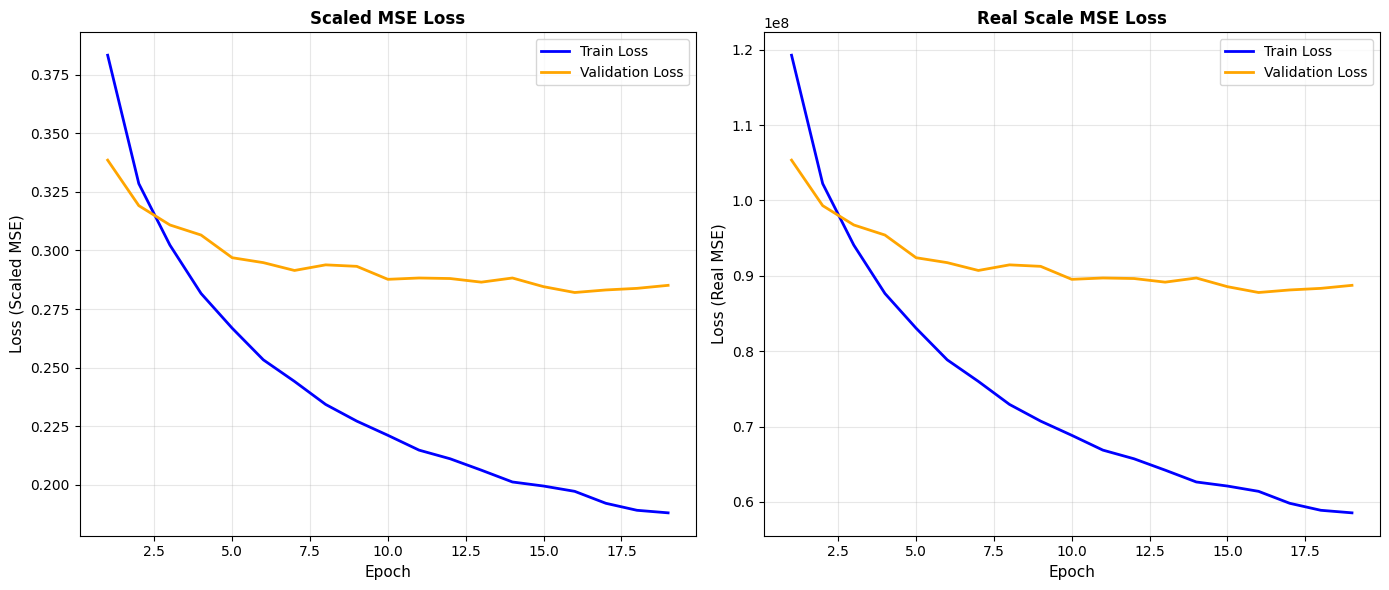

In [134]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

#### Save the model

In [136]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

#### Evaluate on the test set for later comparison

In [137]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    tfidf_and_embedding_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [ ]:
all_models_results["TfIdfModelv1"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Removing redundancy

**TextPreprocessor does:**
- Lowercase 
- Remove URLs, emails 
- Remove special chars
- Remove stopwords (optional)

**TfidfVectorizer ALSO does**
- Lowercase (by default)
- Remove stopwords (optional)
- Tokenization
- Filters by min_df

So if we know that despite TextPreprocessor we will also use TfidfVectorizer, we can simplify TextPreprocessor to only remove URLs and emails.

In [ ]:
class MinimalTextPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn compatible transformer for minimal text cleaning.

    This class performs a streamlined set of text cleaning operations that are not
    typically handled by TF-IDF vectorizers, such as removing URLs, email addresses,
    HTML tags, and multiple asterisks. It is designed to work with pandas DataFrames
    containing 'Title' and 'FullDescription' columns.
    """

    def clean_text(self, text: str) -> str:
        """
        Cleans a single text string by removing specific patterns.

        Args:
            text: str, The text string to be cleaned.

        Returns:
            str, The cleaned text string.
        """
        if pd.isnull(text):
            return ""
        text = str(text).strip()
        if text == "":
            return ""

        # Remove URLs, emails, HTML, asterisks
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r"\S+@\S+", "", text)
        text = re.sub(r"<.*?>", "", text)
        text = re.sub(r"\*{2,}", " ", text)
        text = re.sub(r"\s+", " ", text).strip()

        return text

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "MinimalTextPreprocessor":
        """Fits the transformer. No action needed for this preprocessor."""
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by applying the cleaning steps.

        Args:
            X: pd.DataFrame, The input DataFrame to transform.

        Returns:
            pd.DataFrame, The transformed DataFrame with cleaned text.
        """
        X_copy = X.copy()
        if "Title" in X_copy.columns:
            X_copy["Title"] = X_copy["Title"].apply(self.clean_text)
        if "FullDescription" in X_copy.columns:
            X_copy["FullDescription"] = X_copy["FullDescription"].apply(self.clean_text)
        return X_copy

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "ContractType", "ContractTime"]
high_cardinality_columns = ["Company", "LocationNormalized", "SourceName"]

# Shared text preprocessor
shared_text_prep = MinimalTextPreprocessor()

# Title pipeline
title_pipeline = make_pipeline(TfidfTransformer(text_column="Title", max_features=50))

# Description pipeline
desc_pipeline = make_pipeline(
    TfidfTransformer(text_column="FullDescription", max_features=800)
)

# Categorical pipeline
one_hot_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

# High cardinality pipeline
target_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("target_enc", TargetEncoder()),
        ("scaler", StandardScaler()),
    ]
)

# Clean text first (once for all text columns)
X_train_clean = shared_text_prep.fit_transform(X_train)
X_valid_clean = shared_text_prep.transform(X_valid)
X_test_clean = shared_text_prep.transform(X_test)

# Feature extraction
preprocessor = ColumnTransformer(
    [
        ("title_tfidf", title_pipeline, ["Title"]),
        ("desc_tfidf", desc_pipeline, ["FullDescription"]),
        ("onehot", one_hot_pipeline, categorical_columns),
        ("target_scaled", target_pipeline, high_cardinality_columns),
    ]
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train_clean, y_train)
X_valid_processed = preprocessor.transform(X_valid_clean)
X_test_processed = preprocessor.transform(X_test_clean)

# Scale target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save for later
joblib.dump(shared_text_prep, os.path.join(PREPROCESSORS_DIR, "text_preprocessor.pkl"))
joblib.dump(preprocessor, os.path.join(PREPROCESSORS_DIR, "preprocessor.pkl"))
joblib.dump(target_scaler, os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

print(f"Final feature shape: {X_train_processed.shape}")

Final feature shape: (195814, 888)


- Now we can just repeat the training loop as before
- We may try to experiment with:
    - Different optimizers
    - Different learning rates (for example using learning rate schedulers)
    - Different batch sizes
    - Using stop words in TfidfVectorizer
    - Using SVD to reduce dimensionality of text features
    - Number of features in TfidfVectorizer

#### Building more complex model with text data

Now I will add batch normalization and **try** define learning rate scheduler.

In [ ]:
class SimpleRegressorWithNormalization(nn.Module):
    """
    A simple feed-forward neural network for regression with Batch Normalization.

    This model includes Batch Normalization layers after each linear layer and before the
    activation function, which helps to stabilize and accelerate training.
    """

    def __init__(
        self, input_dim: int, hidden_size: int = 64, dropout_prob: float = 0.3
    ) -> None:
        """
        Initializes the SimpleRegressorWithNormalization model.

        Args:
            input_dim: The number of features in the input data.
            hidden_size: The number of neurons in the first hidden layer. The second
                         hidden layer will have half this number, defaults to 64.
            dropout_prob: The dropout probability for the dropout layers, defaults to 0.3.
        """
        super(SimpleRegressorWithNormalization, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            x: torch.Tensor, Input features tensor.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [143]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [144]:
set_seed()

model_name = "tfidf_800_50_srbn_unk_bs64_adam_lrs_no_hid128_dr30"

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001

model = SimpleRegressorWithNormalization(input_dim, hidden_size, dropout_prob).to(
    device
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressorWithNormalization(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {lr}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Step the scheduler
    ### scheduler.step(valid_loss_scaled_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: tfidf_800_50_srbn_unk_bs64_adam_lrs_no_hid128_dr30
INFO - Model architecture: SimpleRegressorWithNormalization(input_dim=888, hidden_size=128, dropout_prob=0.3)
INFO - Number of parameters: 122497
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 25 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4146, Real MSE: 129040807.00, Real RMSE: 11359.61
INFO -   Valid - MSE: 0.3618, Real MSE: 112597010.82, Real RMSE: 10611.17
INFO - Initial validation loss: 0.361800
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3672, Real MSE: 114276541.37, Real RMSE: 10690.02
INFO -   Valid - MSE: 0.3387, Real MSE: 105395818.46, Real RMSE: 10266.25
INFO - Validation loss improved by 0.023139 to 0.338661
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3466, Real MSE: 107867995.37, Real RMSE: 10385.9

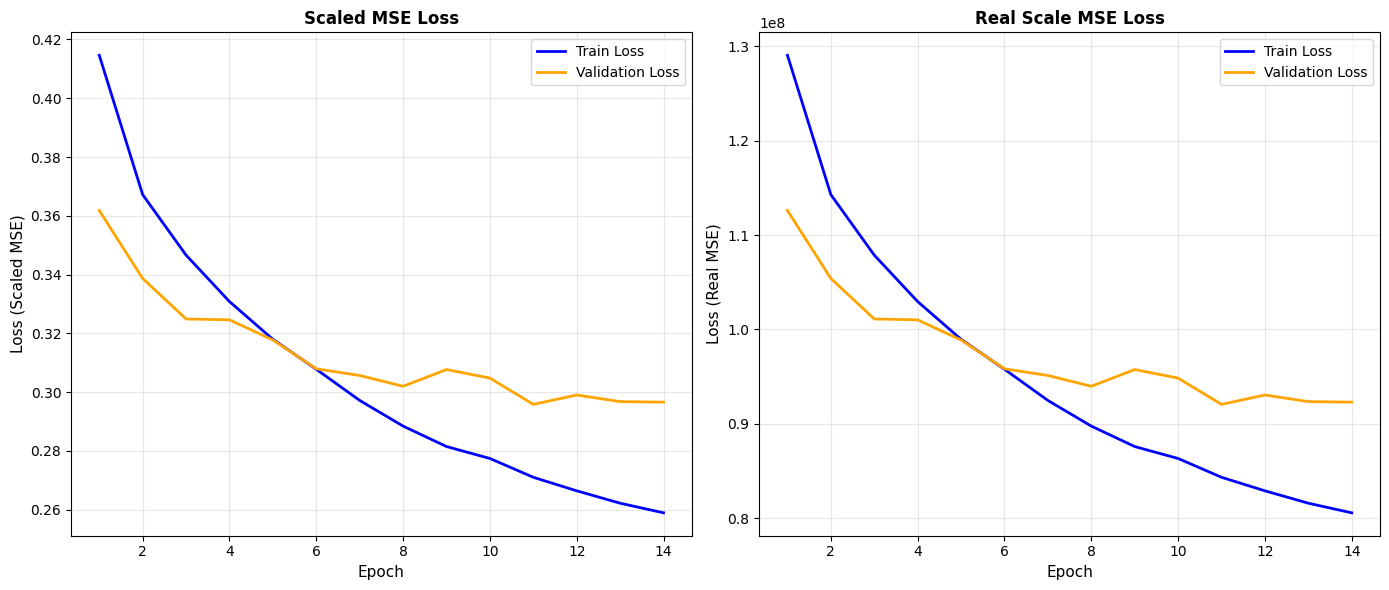

In [145]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [147]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [148]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    tfidf_and_embedding_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [ ]:
all_models_results["TfIdfModelv2"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Using Pretrained Embeddings

Firstly I will try with sentence-transformers library.

How to use it? - Code from the documentation:

In [150]:
# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)
# tensor([[1.0000, 0.6660, 0.1046],
#         [0.6660, 1.0000, 0.1411],
#         [0.1046, 0.1411, 1.0000]])

(3, 384)
tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])


### Pipeline for using pretrained embeddings

In [ ]:
class TextEmbedder(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer to generate text embeddings using a pre-trained model.

    This class leverages the `sentence-transformers` library to convert text data into
    numerical vector representations (embeddings) suitable for machine learning models.
    """

    def __init__(self, model_name: str = "all-MiniLM-L12-v2") -> None:
        """
        Initializes the TextEmbedder.

        Args:
            model_name: str, The name of the pre-trained SentenceTransformer model to use.
                        Defaults to 'all-MiniLM-L12-v2'.
        """
        self.model_name = model_name
        self.model = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "TextEmbedder":
        """
        Fits the transformer. No action needed for this embedder.
        """
        # The model is pre-trained, so we just load it here.
        self.model = SentenceTransformer(self.model_name)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        """
        Transforms the input DataFrame by generating text embeddings.

        Args:
            X: pd.DataFrame, The input DataFrame to transform.

        Returns:
            np.ndarray, The generated text embeddings.
        """
        # Convert input to a list of strings and handle potential NaNs.
        X = [str(x) if x is not None else "" for x in X.iloc[:, 0].tolist()]

        # Generate the embeddings.
        embeddings = self.model.encode(X, show_progress_bar=False)
        return embeddings

    def _check_n_features(self, X: pd.DataFrame, reset: bool) -> None:
        """Ensure compatibility with sklearn's feature validation"""
        pass


In [ ]:
categorical_columns = ["Category", "ContractType", "ContractTime"]
high_cardinality_columns = ["Company", "LocationNormalized", "SourceName"]

one_hot_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

target_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("target_enc", TargetEncoder()),
        ("scaler", StandardScaler()),
    ]
)

# New embedding pipelines
title_embedding_pipeline = Pipeline([("embedder", TextEmbedder())])

desc_embedding_pipeline = Pipeline([("embedder", TextEmbedder())])

preprocessor_with_embeddings = ColumnTransformer(
    [
        ("title_embeddings", title_embedding_pipeline, ["Title"]),
        ("desc_embeddings", desc_embedding_pipeline, ["FullDescription"]),
        ("onehot", one_hot_pipeline, categorical_columns),
        ("target_scaled", target_pipeline, high_cardinality_columns),
    ]
)

# Fit and transform
X_train_processed = preprocessor_with_embeddings.fit_transform(X_train, y_train)
X_valid_processed = preprocessor_with_embeddings.transform(X_valid)
X_test_processed = preprocessor_with_embeddings.transform(X_test)

# Scale target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save for later
joblib.dump(
    preprocessor_with_embeddings,
    os.path.join(PREPROCESSORS_DIR, "preprocessor_with_embeddings.pkl"),
)
joblib.dump(target_scaler, os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

print(f"Final feature shape: {X_train_processed.shape}")

Final feature shape: (195814, 806)


### Training the simplest model with pretrained embeddings

In [153]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [ ]:
set_seed()

model_name = "emb_sr_unk_bs64_adam_lrs_no_hid128_dr30"

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3
lr = 0.001

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressor(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {lr}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30
INFO - Model architecture: SimpleRegressor(input_dim=806, hidden_size=128, dropout_prob=0.3)
INFO - Number of parameters: 111617
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 25 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------


INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4056, Real MSE: 126217112.07, Real RMSE: 11234.64
INFO -   Valid - MSE: 0.3539, Real MSE: 110148732.78, Real RMSE: 10495.18
INFO - Initial validation loss: 0.353933
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3504, Real MSE: 109051387.55, Real RMSE: 10442.77
INFO -   Valid - MSE: 0.3321, Real MSE: 103359817.96, Real RMSE: 10166.60
INFO - Validation loss improved by 0.021814 to 0.332119
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3308, Real MSE: 102950420.57, Real RMSE: 10146.45
INFO -   Valid - MSE: 0.3286, Real MSE: 102273848.75, Real RMSE: 10113.05
INFO - Validation loss improved by 0.003489 to 0.328629
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3170, Real MSE: 98667659.29, Real RMSE: 9933.16
INFO -   Valid - MSE: 0.3219, Real MSE: 100187408.54, Real RMSE: 10009.37
INFO - Validation loss improved by 0.006704 to 0.321925
INFO - Epoch 5/25:
INFO -   Train - MSE: 0.3061, Real MSE: 95270055.50, Real RMSE: 9760.64
INFO -   Valid - MSE: 0.3147, Real

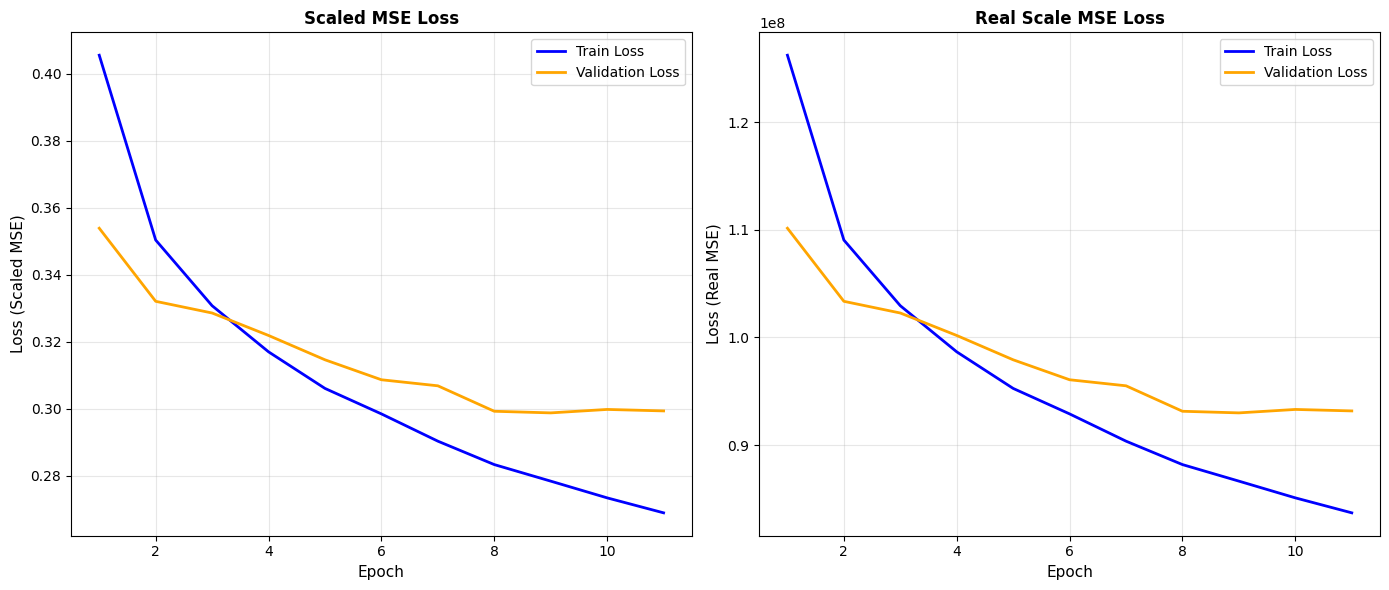

In [155]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [ ]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [158]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    tfidf_and_embedding_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [159]:
all_models_results["EmbeddingModelv1"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Training simple model with batch normalization with embeddings

In [160]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [161]:
set_seed()

model_name = "emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30"

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001

model = SimpleRegressorWithNormalization(input_dim, hidden_size, dropout_prob).to(
    device
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: SimpleRegressorWithNormalization(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {lr}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30
INFO - Model architecture: SimpleRegressorWithNormalization(input_dim=806, hidden_size=128, dropout_prob=0.3)
INFO - Number of parameters: 112001
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 25 epochs with early stopping (patience=3, delta=0.001)


INFO - ----------------------------
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4214, Real MSE: 131139110.91, Real RMSE: 11451.60
INFO -   Valid - MSE: 0.3530, Real MSE: 109867393.79, Real RMSE: 10481.76
INFO - Initial validation loss: 0.353029
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3693, Real MSE: 114941881.10, Real RMSE: 10721.10
INFO -   Valid - MSE: 0.3349, Real MSE: 104219918.91, Real RMSE: 10208.82
INFO - Validation loss improved by 0.018147 to 0.334882
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3519, Real MSE: 109510291.81, Real RMSE: 10464.72
INFO -   Valid - MSE: 0.3235, Real MSE: 100686144.02, Real RMSE: 10034.25
INFO - Validation loss improved by 0.011355 to 0.323528
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3381, Real MSE: 105231202.82, Real RMSE: 10258.23
INFO -   Valid - MSE: 0.3136, Real MSE: 97597039.44, Real RMSE: 9879.12
INFO - Validation loss improved by 0.009926 to 0.313602
INFO - Epoch 5/25:
INFO -   Train - MSE: 0.3285, Real MSE: 102230979.57, Real RMSE: 10110

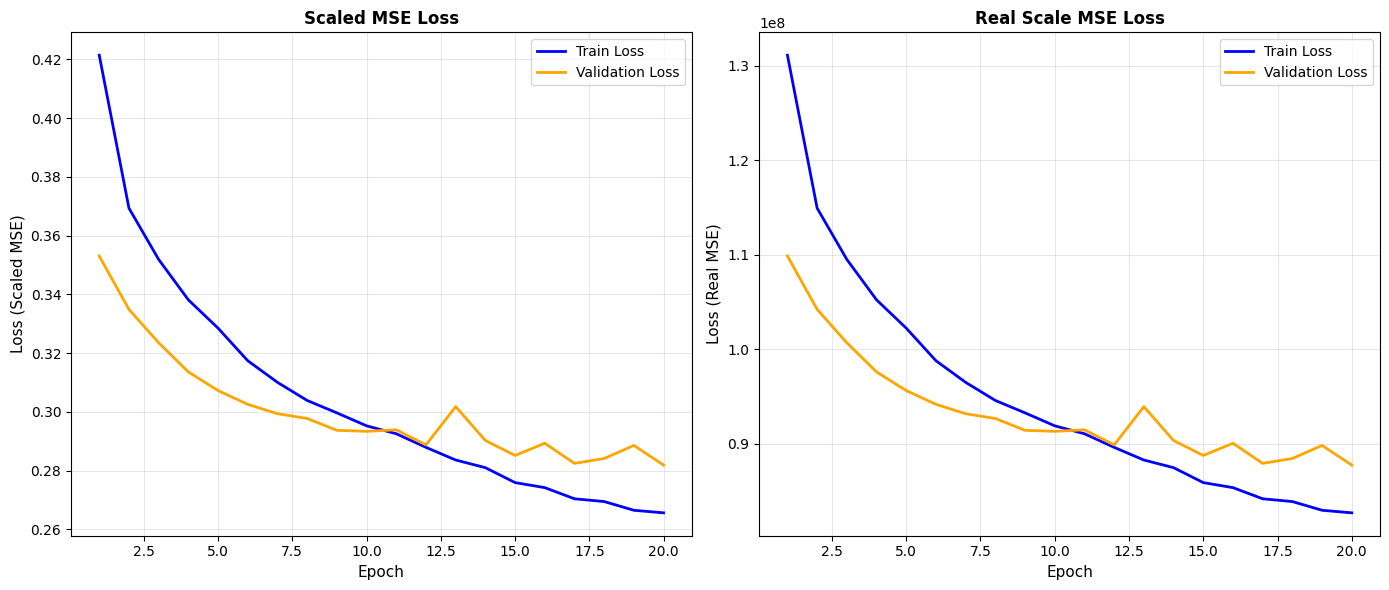

In [162]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [164]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [165]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    tfidf_and_embedding_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [166]:
all_models_results["EmbeddingModelv2"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Building deeper model for embeddings and tabular data

I will add one more layer, more neurons and try with batch normalization before and after activation functions.

In [ ]:
class IntegratedNN(nn.Module):
    """
    An integrated feed-forward neural network with configurable batch normalization placement.

    This model is a multi-layered perceptron designed for regression, featuring
    batch normalization and dropout for improved training stability and generalization.
    The order of batch normalization and activation can be specified.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_size: int = 256,
        dropout_prob: float = 0.3,
        batch_norm_before_activation: bool = True,
    ) -> None:
        """Initializes the IntegratedNN model.

        Args:
            input_dim: int, Dimension of the input features.
            hidden_size: int, Number of neurons in the first hidden layer. Default is 256.
            dropout_prob: float, Dropout probability for regularization. Default is 0.3.
            batch_norm_before_activation: bool, If True, applies batch normalization before activation functions.
                                        If False, applies it after. Default is True.
        """
        super(IntegratedNN, self).__init__()
        self.batch_norm_before_activation = batch_norm_before_activation
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 2 // 2)
        self.bn3 = nn.BatchNorm1d(hidden_size // 2 // 2)
        self.final_dropout = nn.Dropout(p=min(0.2, dropout_prob))
        self.fc4 = nn.Linear(hidden_size // 2 // 2, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            x: torch.Tensor, Input features tensor.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        if self.batch_norm_before_activation:
            x = self.fc1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.final_dropout(x)
            x = self.fc4(x)
        else:
            x = self.fc1(x)
            x = self.relu(x)
            x = self.bn1(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.relu(x)
            x = self.bn2(x)
            x = self.dropout(x)
            x = self.fc3(x)
            x = self.relu(x)
            x = self.bn3(x)
            x = self.final_dropout(x)
            x = self.fc4(x)
        return x


In [169]:
set_seed()
model_name = "emb_int_unk_bs64_adam_lrs_no_hid256_dr30"

input_dim = X_train_processed.shape[1]
hidden_size = 256
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001
batch_norm_before_activation = True

model = IntegratedNN(
    input_dim, hidden_size, dropout_prob, batch_norm_before_activation
).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: IntegratedNN(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob}, batch_norm_before_activation={batch_norm_before_activation})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {lr}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Step the scheduler
    ### scheduler.step(valid_loss_scaled_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: emb_int_unk_bs64_adam_lrs_no_hid256_dr30
INFO - Model architecture: IntegratedNN(input_dim=806, hidden_size=256, dropout_prob=0.3, batch_norm_before_activation=True)
INFO - Number of parameters: 248705
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 25 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4154, Real MSE: 129276507.85, Real RMSE: 11369.98
INFO -   Valid - MSE: 0.3474, Real MSE: 108104294.60, Real RMSE: 10397.32
INFO - Initial validation loss: 0.347364
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3619, Real MSE: 112633804.80, Real RMSE: 10612.91
INFO -   Valid - MSE: 0.3264, Real MSE: 101589093.97, Real RMSE: 10079.14
INFO - Validation loss improved by 0.020935 to 0.326429
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3394, Real MSE: 105618305.74, Real RMSE: 10

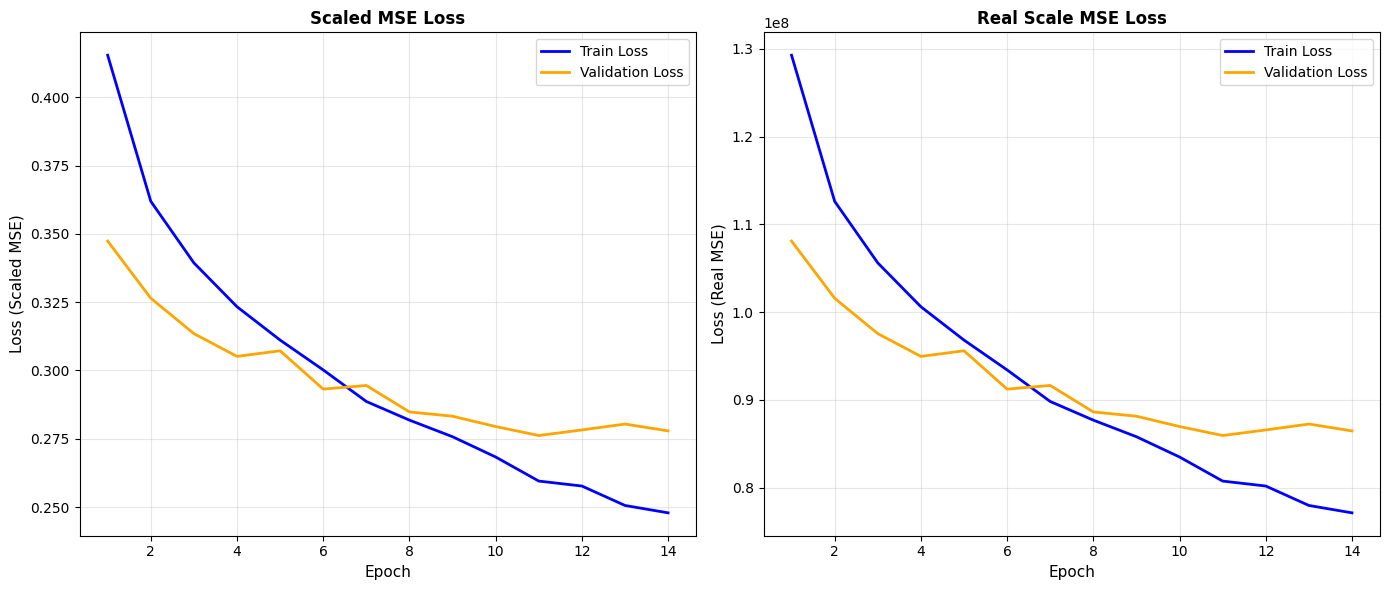

In [170]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [171]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [172]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    tfidf_and_embedding_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [173]:
all_models_results["EmbeddingModelv3"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

Now change order of batch normalization and activation functions.

In [174]:
set_seed()

model_name = "emb_int_unk_bs64_adam_lrs_no_hid256_dr30_batchnorm_after"

input_dim = X_train_processed.shape[1]
hidden_size = 256
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001
batch_norm_before_activation = False

model = IntegratedNN(
    input_dim, hidden_size, dropout_prob, batch_norm_before_activation
).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: IntegratedNN(input_dim={input_dim}, hidden_size={hidden_size}, dropout_prob={dropout_prob}, batch_norm_before_activation={batch_norm_before_activation})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {lr}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(
                predictions.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            y_batch_real = target_scaler.inverse_transform(
                y_batch.detach().cpu().numpy().reshape(-1, 1)
            ).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Step the scheduler
    ### scheduler.step(valid_loss_scaled_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time
logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: emb_int_unk_bs64_adam_lrs_no_hid256_dr30_batchnorm_after
INFO - Model architecture: IntegratedNN(input_dim=806, hidden_size=256, dropout_prob=0.3, batch_norm_before_activation=False)
INFO - Number of parameters: 248705
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 25 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------


INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4268, Real MSE: 132812778.23, Real RMSE: 11524.44
INFO -   Valid - MSE: 0.3592, Real MSE: 111775722.47, Real RMSE: 10572.40
INFO - Initial validation loss: 0.359161
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3771, Real MSE: 117363686.84, Real RMSE: 10833.45
INFO -   Valid - MSE: 0.3511, Real MSE: 109256495.76, Real RMSE: 10452.58
INFO - Validation loss improved by 0.008095 to 0.351066
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3558, Real MSE: 110723403.56, Real RMSE: 10522.52
INFO -   Valid - MSE: 0.3491, Real MSE: 108648957.12, Real RMSE: 10423.48
INFO - Validation loss improved by 0.001952 to 0.349114
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3437, Real MSE: 106970026.84, Real RMSE: 10342.63
INFO -   Valid - MSE: 0.3408, Real MSE: 106075472.38, Real RMSE: 10299.29
INFO - Validation loss improved by 0.008269 to 0.340845
INFO - Epoch 5/25:
INFO -   Train - MSE: 0.3319, Real MSE: 103305427.43, Real RMSE: 10163.93
INFO -   Valid - MSE: 0.3153, 

MSE for validation is high however MAE is relatively low.

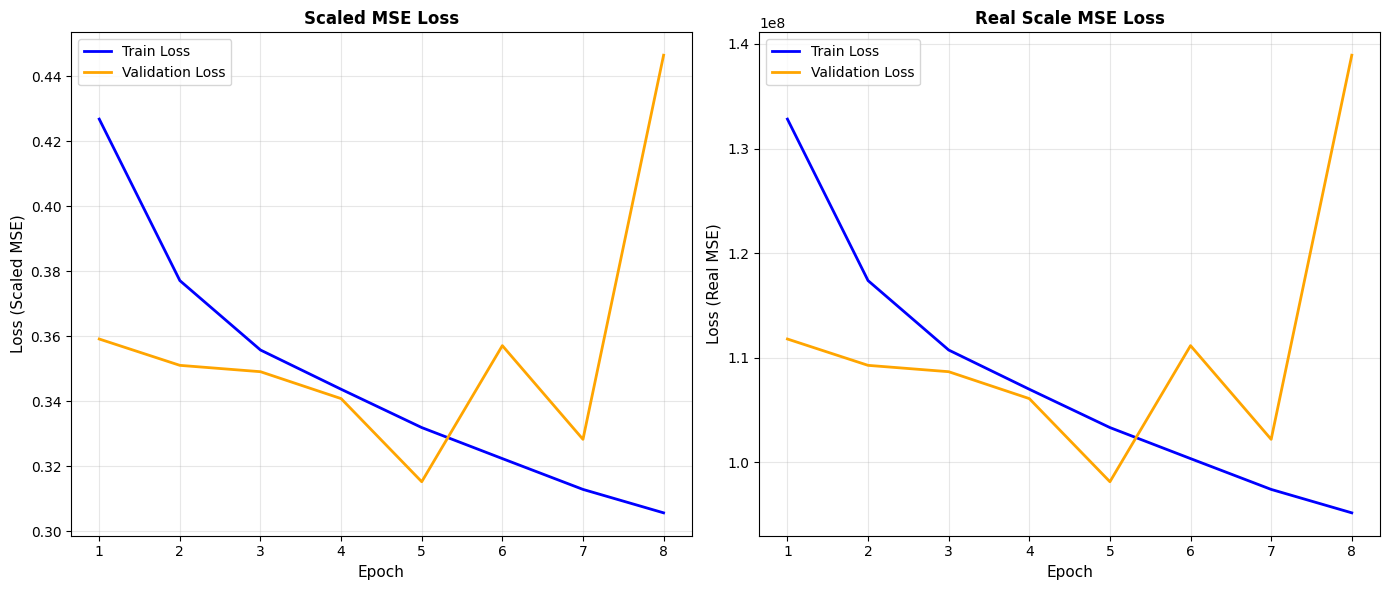

In [175]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [177]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [178]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    tfidf_and_embedding_model_test_results[model_name] = {
        "Test MSE (scaled)": test_loss_scaled_avg,
        "Test MSE (real)": test_loss_real_avg,
        "Test RMSE (real)": np.sqrt(test_loss_real_avg),
        "Training Time (minutes)": elapsed_time / 60,
    }

In [179]:
all_models_results["EmbeddingModelv4"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

Poor performance on validation.

### Building Multi-Input Model with Embeddings and Categorical Features

At first we need to define which columns are representation of embeddings and which are categorical features.

In [180]:
# Get the fitted transformers to find their dimensions
title_embedder = preprocessor_with_embeddings.named_transformers_["title_embeddings"][
    "embedder"
]
desc_embedder = preprocessor_with_embeddings.named_transformers_["desc_embeddings"][
    "embedder"
]
onehot_encoder = preprocessor_with_embeddings.named_transformers_["onehot"]["onehot"]

# Calculate the dimensions of each feature group
embedding_dim = title_embedder.model.get_sentence_embedding_dimension()  # Should be 384
print(
    f"Embedding dimension: {embedding_dim}"
)  # two times 384 because we have title and description
title_dim = embedding_dim
desc_dim = embedding_dim
onehot_dim = onehot_encoder.get_feature_names_out().shape[0]  # Total one-hot features
print(f"One-hot dimension: {onehot_dim}")
target_dim = len(high_cardinality_columns)  # 3
print(f"Target encoded dimension: {target_dim}")

# Define the start and end indices for each slice
# Note: The order is crucial and must match the ColumnTransformer.
title_end_idx = title_dim
desc_end_idx = title_dim + desc_dim
onehot_end_idx = desc_end_idx + onehot_dim
target_end_idx = onehot_end_idx + target_dim

# Now you can slice the processed data
embeddings_features = X_train_processed[:, :desc_end_idx]
tabular_features = X_train_processed[:, desc_end_idx:]

print(f"Total embeddings shape: {embeddings_features.shape}")
print(f"Total tabular shape: {tabular_features.shape}")

tabular_start_index = desc_end_idx

Embedding dimension: 384
One-hot dimension: 35
Target encoded dimension: 3
Total embeddings shape: (195814, 768)
Total tabular shape: (195814, 38)


Now we need to define new custom Dataset class that will handle both types of inputs.

In [ ]:
class MultiInputDataset(Dataset):
    def __init__(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        tabular_start_index: int,
    ) -> None:
        """
        Custom PyTorch Dataset for handling multiple input types (e.g., embeddings and tabular data).

        This class splits the preprocessed feature matrix into its constituent parts
        (e.g., text embeddings and tabular features) and prepares them as PyTorch tensors.

        Args:
            X: Union[np.ndarray, pd.DataFrame], The combined feature matrix from a `ColumnTransformer`, expected
               to be a numpy array or pandas DataFrame.
            y: Union[np.ndarray, pd.Series], The target values, can be a numpy array or pandas Series.
            tabular_start_index: int, The column index where the tabular features begin.
                                 Features before this index are considered embeddings.
        """

        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.tabular_start_index = tabular_start_index

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves a single sample by its index, splitting features into embeddings and tabular data.
        Args:
            idx: int, The index of the sample to retrieve.
        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                - embeddings: torch.Tensor, The embedding features.
                - tabular_features: torch.Tensor, The tabular features.
                - target: torch.Tensor, The target value.
        """
        embeddings = self.X[idx, : self.tabular_start_index]
        tabular_features = self.X[idx, self.tabular_start_index :]

        target = self.y[idx]

        return embeddings, tabular_features, target


In [182]:
multi_input_train_dataset = MultiInputDataset(
    X_train_processed, y_train_scaled, tabular_start_index
)
multi_input_valid_dataset = MultiInputDataset(
    X_valid_processed, y_valid_scaled, tabular_start_index
)
multi_input_test_dataset = MultiInputDataset(
    X_test_processed, y_test_scaled, tabular_start_index
)

In [183]:
batch_size = 64
num_workers = 0

multi_input_train_loader = DataLoader(
    multi_input_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
multi_input_valid_loader = DataLoader(
    multi_input_valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
multi_input_test_loader = DataLoader(
    multi_input_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

### Building multi-input model

In [ ]:
class MultiInputNN(nn.Module):
    """
    A neural network designed to handle multiple input types, such as text embeddings and tabular data.

    The network consists of three main components: a sub-network for processing embeddings,
    a sub-network for processing tabular features, and a combined network that
    concatenates their outputs to produce a final prediction. Each sub-network
    uses a sequence of linear layers, batch normalization, ReLU activation, and dropout.
    """

    def __init__(
        self,
        embedding_dim: int,
        tabular_dim: int,
        embedding_hidden: list[int] = [256, 128],
        tabular_hidden: list[int] = [64, 32],
        combined_hidden: list[int] = [128, 64],
        dropout_prob: float = 0.3,
    ) -> None:
        """
        Initializes the MultiInputNN model.

        Args:
            embedding_dim: int, The dimension of the input text embeddings.
            tabular_dim: int, The number of features in the tabular data.
            embedding_hidden: list[int], A list of integers representing the number of neurons in
                              the hidden layers of the embedding sub-network. Defaults to [256, 128].
            tabular_hidden: list[int], A list of integers representing the number of neurons in
                            the hidden layers of the tabular sub-network. Defaults to [64, 32].
            combined_hidden: list[int], A list of integers representing the number of neurons in
                             the hidden layers of the combined network. Defaults to [128, 64].
            dropout_prob: float, The dropout probability applied in all dropout layers. Defaults to 0.3.
        """
        super(MultiInputNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.tabular_dim = tabular_dim
        self.embedding_hidden = embedding_hidden
        self.tabular_hidden = tabular_hidden
        self.dropout_prob = dropout_prob

        # Embedding layers
        embedding_layers = []
        input_size = embedding_dim
        for hidden_size in embedding_hidden:
            embedding_layers.append(nn.Linear(input_size, hidden_size))
            embedding_layers.append(nn.BatchNorm1d(hidden_size))
            embedding_layers.append(nn.ReLU())
            embedding_layers.append(nn.Dropout(p=dropout_prob))
            input_size = hidden_size

        self.embedding_net = nn.Sequential(*embedding_layers)

        # Tabular layers
        tabular_layers = []
        input_size = tabular_dim
        for hidden_size in tabular_hidden:
            tabular_layers.append(nn.Linear(input_size, hidden_size))
            tabular_layers.append(nn.BatchNorm1d(hidden_size))
            tabular_layers.append(nn.ReLU())
            tabular_layers.append(nn.Dropout(p=dropout_prob))
            input_size = hidden_size

        self.tabular_net = nn.Sequential(*tabular_layers)

        # Combined layers
        combined_input_size = embedding_hidden[-1] + tabular_hidden[-1]
        combined_layers = []
        for hidden_size in combined_hidden:
            combined_layers.append(nn.Linear(combined_input_size, hidden_size))
            combined_layers.append(nn.BatchNorm1d(hidden_size))
            combined_layers.append(nn.ReLU())
            combined_layers.append(nn.Dropout(p=dropout_prob))
            combined_input_size = hidden_size

        combined_layers.append(nn.Linear(combined_input_size, 1))  # Final output layer
        self.combined_net = nn.Sequential(*combined_layers)

    def forward(self, embeddings: torch.Tensor, tabular: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the model.

        Args:
            embeddings: torch.Tensor, Input text embeddings.
            tabular: torch.Tensor, Input tabular features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        embeddings = self.embedding_net(embeddings)
        tabular = self.tabular_net(tabular)
        combined = torch.cat((embeddings, tabular), dim=1)
        output = self.combined_net(combined)
        return output


#### Training multi-input model

In [185]:
set_seed()

model_name = "emb_multi_unk_bs64_adam_lrs_no_hid256_dr30"

input_dim = X_train_processed.shape[1]
embedding_dim = 2 * 384  # 2 * 384 because we have title and description = 768
tabular_dim = input_dim - embedding_dim

dropout_prob = 0.3
lr = 0.001

model = MultiInputNN(
    embedding_dim=embedding_dim, tabular_dim=tabular_dim, dropout_prob=dropout_prob
).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(os.path.join(PREPROCESSORS_DIR, "target_scaler.pkl"))

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(
    patience=patience,
    delta=delta,
    verbose=True,
    restore_best_weights=True,
    logger=logger,
)

logger.info("Starting training:")
logger.info("----------------------------")
logger.info(f"Model name: {model_name}")
logger.info(
    f"Model architecture: MultiInputNN(embedding_dim={embedding_dim}, tabular_dim={tabular_dim}, dropout_prob={dropout_prob})"
)
logger.info(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
logger.info(f"Using device: {device}")
logger.info(f"Batch size: {batch_size}")
logger.info(f"Learning rate: {lr}")
logger.info(
    f"Training for a maximum of {n_epochs} epochs with early stopping (patience={patience}, delta={delta})"
)
logger.info("----------------------------")

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for embeddings_batch, tabular_batch, y_batch in multi_input_train_loader:
        embeddings_batch, tabular_batch, y_batch = (
            embeddings_batch.to(device),
            tabular_batch.to(device),
            y_batch.to(device),
        )

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(embeddings_batch, tabular_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * embeddings_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * embeddings_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(multi_input_train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(multi_input_train_loader.dataset)

    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    for embeddings_batch, tabular_batch, y_batch in multi_input_valid_loader:
        embeddings_batch, tabular_batch, y_batch = (
            embeddings_batch.to(device),
            tabular_batch.to(device),
            y_batch.to(device),
        )

        # Forward pass
        predictions = model(embeddings_batch, tabular_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        valid_loss_scaled += loss.item() * embeddings_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(
            predictions.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        y_batch_real = target_scaler.inverse_transform(
            y_batch.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        valid_loss_real += mse_real * embeddings_batch.size(0)

    valid_loss_scaled_avg = valid_loss_scaled / len(multi_input_valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(multi_input_valid_loader.dataset)

    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
    logger.info(
        f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}"
    )
    logger.info(
        f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}"
    )

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg, model)
    if early_stopping.stop_training:
        logger.info(f"Early stopping at epoch {epoch + 1}")
        break

elapsed_time = time.time() - start_time

logger.info("Training complete.")
logger.info(f"Total training time (seconds): {elapsed_time:.2f}")
logger.info("----------------------------")

INFO - Starting training:
INFO - ----------------------------
INFO - Model name: emb_multi_unk_bs64_adam_lrs_no_hid256_dr30
INFO - Model architecture: MultiInputNN(embedding_dim=768, tabular_dim=38, dropout_prob=0.3)
INFO - Number of parameters: 264609
INFO - Using device: mps
INFO - Batch size: 64
INFO - Learning rate: 0.001
INFO - Training for a maximum of 25 epochs with early stopping (patience=3, delta=0.001)
INFO - ----------------------------
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4384, Real MSE: 136436030.45, Real RMSE: 11680.58
INFO -   Valid - MSE: 0.3627, Real MSE: 112882734.44, Real RMSE: 10624.63
INFO - Initial validation loss: 0.362718
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3784, Real MSE: 117753617.66, Real RMSE: 10851.43
INFO -   Valid - MSE: 0.3395, Real MSE: 105671948.10, Real RMSE: 10279.69
INFO - Validation loss improved by 0.023170 to 0.339548
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3542, Real MSE: 110227402.93, Real RMSE: 10498.92
INFO -   Valid - MSE: 0

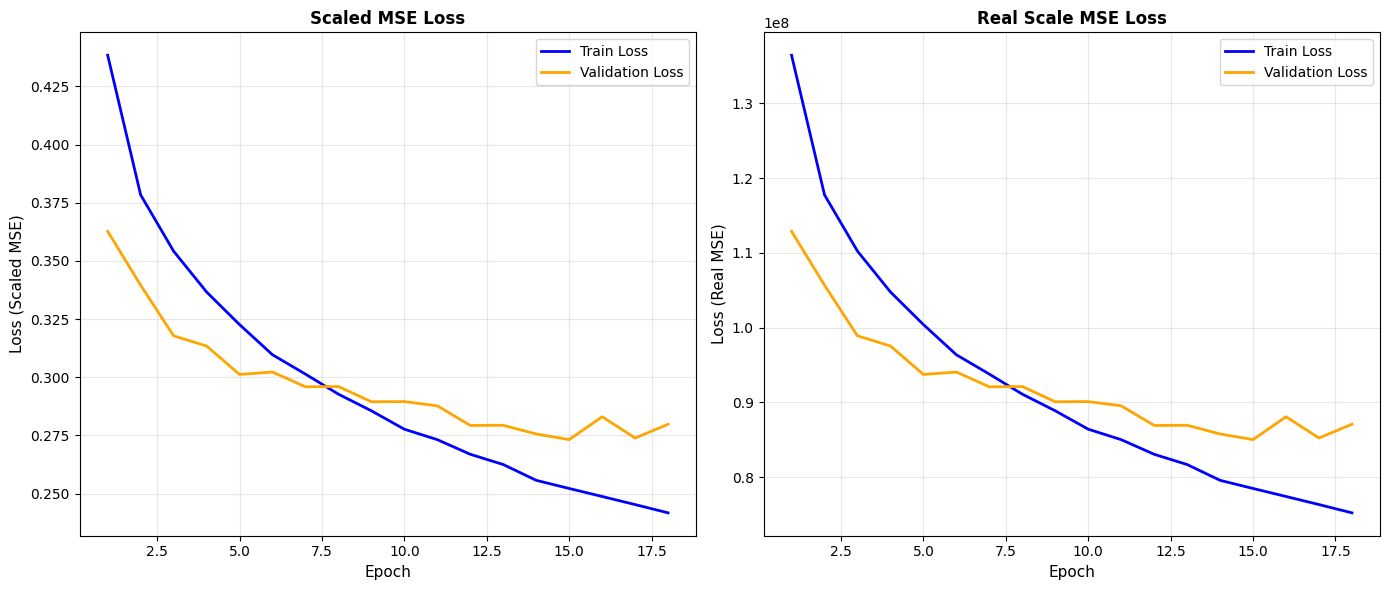

In [186]:
plot_losses_from_lists(
    train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real
)

In [188]:
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [189]:
model.eval()

test_loss_scaled = 0.0
all_predictions_real = []
all_targets_real = []

with torch.no_grad():
    for embeddings_batch, tabular_batch, y_batch in multi_input_test_loader:
        embeddings_batch = embeddings_batch.to(device)
        tabular_batch = tabular_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass (multi-input)
        predictions = model(embeddings_batch, tabular_batch).squeeze()

        # Accumulate loss in scaled domain
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * embeddings_batch.size(0)

        # Store predictions and targets for real-scale metrics
        all_predictions_real.extend(
            target_scaler.inverse_transform(
                predictions.cpu().numpy().reshape(-1, 1)
            ).ravel()
        )
        all_targets_real.extend(
            target_scaler.inverse_transform(
                y_batch.cpu().numpy().reshape(-1, 1)
            ).ravel()
        )

# Average loss over the entire dataset
test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)

# Calculate real-scale metrics over the entire dataset
all_predictions_real = np.array(all_predictions_real)
all_targets_real = np.array(all_targets_real)

mse_real = np.mean((all_predictions_real - all_targets_real) ** 2)
rmse_real = np.sqrt(mse_real)

tfidf_and_embedding_model_test_results[model_name] = {
    "Test MSE (scaled)": test_loss_scaled_avg,
    "Test MSE (real)": mse_real,
    "Test RMSE (real)": rmse_real,
    "Training Time (minutes)": elapsed_time / 60,
}

In [190]:
all_models_results["EmbeddingModelv5"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Combine everything together

**List of models I have created:**

- `SimpleRegressor`
- `SimpleRegressorWithNormalization`
- `IntegratedNN`
- `MultiInputNN`



### Function to load data and handle missing values in 'Title' column

In [ ]:
def load_data(
    file_path: str = "data/Train_rev1.csv", logger: logging.Logger = None
) -> pd.DataFrame:
    """
    Loads data from a CSV and handles missing values in 'Title'.

    Args:
        file_path: str, Path to the raw CSV data file. Defaults to "data/Train_rev1.csv".
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        pd.DataFrame: Loaded dataset with imputed Title values.
    """
    # Load data from the specified path
    df = pd.read_csv(file_path)

    # Impute missing value in 'Title' based on EDA findings.
    df.loc[df["Title"].isnull(), "Title"] = "Quality Improvement Manager"

    if logger:
        logger.info(f"Data successfully loaded from {file_path}. Shape: {df.shape}")

    return df


### Function to select features, split into train, val, test sets

In [ ]:
def split_data(
    df: pd.DataFrame,
    test_size: float = 0.2,
    valid_size: float = 0.5,
    random_state: int = 42,
    log: bool = False,
    logger: logging.Logger = None,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits data into training, validation, and test sets.

    Args:
        df: pd.DataFrame, Input dataframe.
        test_size: float, Proportion of the dataset to include in the test split, default is 0.2.
        valid_size: float, Proportion of the temporary split to include in the validation split, default is 0.5.
        random_state: int, Seed for reproducible train/test splits, default is 42.
        log: bool, Whether to apply log transformation to the target variable, default is False.
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
    tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
        A tuple containing:
        - X_train (pd.DataFrame): Training features.
        - X_valid (pd.DataFrame): Validation features.
        - X_test (pd.DataFrame): Test features.
        - y_train (pd.Series): Training target.
        - y_valid (pd.Series): Validation target.
        - y_test (pd.Series): Test target.
    """
    # Separate features (X) and target (y)
    X = df[
        [
            "Title",
            "FullDescription",
            "Category",
            "Company",
            "LocationNormalized",
            "ContractType",
            "ContractTime",
            "SourceName",
        ]
    ]

    if log:
        y = np.log1p(
            df["SalaryNormalized"]
        )  # log(1 + x) to handle zero salaries if any
    else:
        y = df["SalaryNormalized"]

    # Split data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp, y_temp, test_size=valid_size, random_state=random_state
    )

    if logger:
        logger.info(f"Data split into train, validation, and test sets.")
        logger.info(f"Training set shape: {X_train.shape}, {y_train.shape}")
        logger.info(f"Validation set shape: {X_valid.shape}, {y_valid.shape}")
        logger.info(f"Test set shape: {X_test.shape}, {y_test.shape}")
        if log:
            logger.info("Target variable 'SalaryNormalized' has been log-transformed.")

    return X_train, X_valid, X_test, y_train, y_valid, y_test


### Function to prepare target variable

In [ ]:
def preprocess_target(
    y_train: pd.Series,
    y_valid: pd.Series,
    y_test: pd.Series,
    log: Optional[bool] = False,
    save_artifacts: Optional[bool] = True,
    preprocessor_dir: Optional[str] = "fitted_preprocessors",
    artifact_prefix: Optional[str] = "",
    logger: Optional[logging.Logger] = None,
) -> dict[str, Any]:
    """
    Preprocess target values for salary prediction.

    Args:
        y_train: (pd.Series), Training target values.
        y_valid: (pd.Series), Validation target values.
        y_test: (pd.Series), Test target values.
        log: Optional[bool], If True, indicates that y is already log-transformed,
            so skips StandardScaler and artifact saving. Defaults to False.
        save_artifacts: Optional[bool], Whether to save the target scaler. Defaults to True.
        preprocessor_dir: Optional[str], Directory to save preprocessor artifacts.
            Defaults to "fitted_preprocessors".
        artifact_prefix: Optional[str], Prefix for saved artifact filenames. Defaults to "".
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        dict, dict containing:
            - y_train_scaled: Scaled training targets
            - y_valid_scaled: Scaled validation targets
            - y_test_scaled: Scaled test targets
            - target_scaler: Fitted StandardScaler (None if log=True)
    """

    if log:
        # y is already log-transformed, don't apply StandardScaler
        y_train_scaled = y_train.values
        y_valid_scaled = y_valid.values
        y_test_scaled = y_test.values
        target_scaler = None
        if logger:
            logger.info("Log mode: Skipping StandardScaler fitting and artifact saving")
    else:
        # Fit StandardScaler on training targets
        target_scaler = StandardScaler()
        y_train_scaled = target_scaler.fit_transform(
            y_train.values.reshape(-1, 1)
        ).ravel()
        y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
        y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

    # Save target scaler artifact (skip if log=True)
    if save_artifacts and not log:
        # Create directory if it doesn't exist
        os.makedirs(preprocessor_dir, exist_ok=True)

        scaler_path = os.path.join(
            preprocessor_dir, f"{artifact_prefix}target_scaler.pkl"
        )
        joblib.dump(target_scaler, scaler_path)

        if logger:
            logger.info(f"Target scaler saved to: {scaler_path}")

    return (y_train_scaled, y_valid_scaled, y_test_scaled, target_scaler)


### Function to preprocess categorcial data

In [ ]:
def preprocess_categorical_data(
    X_train: pd.DataFrame,
    X_valid: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    categorical_columns: Optional[list[str]] = ["Category", "ContractType", "ContractTime"],
    high_cardinality_columns: Optional[list[str]] = [
        "Company",
        "LocationNormalized",
        "SourceName",
    ],
    categorical_na_strategy: Optional[str] = "constant",
    categorical_fill_value: Optional[str] = "unknown",
    high_card_na_strategy: Optional[str] = "constant",
    high_card_fill_value: Optional[str] = "unknown",
    logger: logging.Logger = None,
) -> tuple[ColumnTransformer, np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocesses categorical features using one-hot encoding and target encoding.

    Args:
        X_train (pd.DataFrame): Training feature dataframe.
        X_valid (pd.DataFrame): Validation feature dataframe.
        X_test (pd.DataFrame): Test feature dataframe.
        y_train (pd.Series): Training target series.
        categorical_columns: Optional[list[str]]: Columns to apply one-hot encoding, default: ["Category", "ContractType", "ContractTime"].
        high_cardinality_columns: Optional[list[str]]: Columns to apply target encoding, default: ["Company", "LocationNormalized", "SourceName"].
        categorical_na_strategy: Optional[str]: Imputation strategy for categorical_columns.
            If "constant", uses `categorical_fill_value`; otherwise uses "most_frequent", default: "constant".
        categorical_fill_value: Optional[str]: Fill value used when categorical_na_strategy is "constant", default: "unknown".
        high_card_na_strategy: Optional[str]: Imputation strategy for high_cardinality_columns.
            If "constant", uses `high_card_fill_value`; otherwise uses "most_frequent", default: "constant".
        high_card_fill_value: Optional[str]: Fill value used when high_card_na_strategy is "constant", default: "unknown".
        logger: Optional[logging.Logger]: Logger for informational messages. Default: None.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, ColumnTransformer]:
            A tuple containing:
            - X_train_cat (np.ndarray): Transformed training categorical features.
            - X_valid_cat (np.ndarray): Transformed validation categorical features.
            - X_test_cat (np.ndarray): Transformed test categorical features.
            - categorical_preprocessor (ColumnTransformer): Fitted ColumnTransformer used for preprocessing.
    """
    # Setup categorical imputer
    if categorical_na_strategy == "constant":
        cat_imputer = SimpleImputer(
            strategy="constant", fill_value=categorical_fill_value
        )
    else:
        cat_imputer = SimpleImputer(strategy="most_frequent")

    one_hot_pipeline = Pipeline(
        [
            ("imputer", cat_imputer),
            ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
        ]
    )

    # Setup high cardinality imputer
    if high_card_na_strategy == "constant":
        high_card_imputer = SimpleImputer(
            strategy="constant", fill_value=high_card_fill_value
        )
    else:
        high_card_imputer = SimpleImputer(strategy="most_frequent")

    target_pipeline = Pipeline(
        [
            ("imputer", high_card_imputer),
            ("target_enc", TargetEncoder()),
            ("scaler", StandardScaler()),
        ]
    )

    # Combine into ColumnTransformer
    categorical_preprocessor = ColumnTransformer(
        [
            ("onehot", one_hot_pipeline, categorical_columns),
            ("target_scaled", target_pipeline, high_cardinality_columns),
        ]
    )

    # Fit and transform
    X_train_cat = categorical_preprocessor.fit_transform(X_train, y_train)
    X_valid_cat = categorical_preprocessor.transform(X_valid)
    X_test_cat = categorical_preprocessor.transform(X_test)

    if logger:
        logger.info("Categorical features preprocessed successfully.")

    return X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor


### Function to preprocess text data using Tf-idf and save them

In [ ]:
def preprocess_text_data_tfidf(
    X_train: pd.DataFrame,
    X_valid: pd.DataFrame,
    X_test: pd.DataFrame,
    title_column: str = "Title",
    desc_column: str = "FullDescription",
    title_max_features: int = 50,
    desc_max_features: int = 800,
    title_use_svd: bool = False,
    title_n_components: int = 10,
    desc_use_svd: bool = False,
    desc_n_components: int = 50,
    title_stop_words: Optional[Union[str, list[str]]] = None,
    desc_stop_words: Optional[Union[str, list[str]]] = None,
    save_features: bool = True,
    feature_prefix: str = "",
    features_dir: str = "tfidf_features",
    logger: logging.Logger = None,
) -> tuple[dict[str, np.ndarray], int, int, Any]:
    """
    Generates TF-IDF features and optionally saves them to disk.

    Args:
        X_train: pd.DataFrame, Training data.
        X_valid: pd.DataFrame, Validation data.
        X_test: pd.DataFrame, Test data.
        title_column: str, Name of the title column, default is "Title".
        desc_column: str, Name of the description column.
        title_max_features: int, Max TF-IDF features for title, default is 50.
        desc_max_features: int, Max TF-IDF features for description, default is 800.
        title_use_svd: bool, Whether to apply SVD to title features, default is False.
        title_n_components: int, Number of SVD components for title, default is 10.
        desc_use_svd: bool, Whether to apply SVD to description features, default is False.
        desc_n_components: int, Number of SVD components for description, default is 50.
        title_stop_words: Optional[Union[str, list[str]]], Stop words for title vectorizer.
        desc_stop_words: Optional[Union[str, list[str]]], Stop words for description vectorizer.
        save_features: bool, Whether to save features to disk, default is True.
        feature_prefix: str, Prefix for saved feature files.
        features_dir: str, Directory to save features, default is 'tfidf_features'.
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        tuple, Tuple of (dict with all features, title_dim, desc_dim, text_preprocessor).
    """
    # Step 1: Clean text
    text_preprocessor = MinimalTextPreprocessor()
    X_train_clean = text_preprocessor.fit_transform(X_train)
    X_valid_clean = text_preprocessor.transform(X_valid)
    X_test_clean = text_preprocessor.transform(X_test)

    # Step 2: Build TF-IDF pipelines
    title_pipeline = make_pipeline(
        TfidfTransformer(
            text_column=title_column,
            max_features=title_max_features,
            use_svd=title_use_svd,
            n_components=title_n_components,
            stop_words=title_stop_words,
        )
    )

    desc_pipeline = make_pipeline(
        TfidfTransformer(
            text_column=desc_column,
            max_features=desc_max_features,
            use_svd=desc_use_svd,
            n_components=desc_n_components,
            stop_words=desc_stop_words,
        )
    )
    if logger:
        logger.info("Text preprocessing pipelines created.")

    # Generate title TF-IDF features
    title_train = title_pipeline.fit_transform(X_train_clean[[title_column]])
    title_valid = title_pipeline.transform(X_valid_clean[[title_column]])
    title_test = title_pipeline.transform(X_test_clean[[title_column]])

    # Generate description TF-IDF features
    desc_train = desc_pipeline.fit_transform(X_train_clean[[desc_column]])
    desc_valid = desc_pipeline.transform(X_valid_clean[[desc_column]])
    desc_test = desc_pipeline.transform(X_test_clean[[desc_column]])

    # Combine TF-IDF features
    text_train = np.hstack([title_train, desc_train])
    text_valid = np.hstack([title_valid, desc_valid])
    text_test = np.hstack([title_test, desc_test])

    if logger:
        logger.info("TF-IDF features generated successfully.")

    # Calculate dimensions
    title_dim = title_n_components if title_use_svd else title_max_features
    desc_dim = desc_n_components if desc_use_svd else desc_max_features

    print(f"Title TF-IDF dimension: {title_dim}")
    print(f"Description TF-IDF dimension: {desc_dim}")

    features = {
        "X_train_text": text_train,
        "X_valid_text": text_valid,
        "X_test_text": text_test,
        "title_train": title_train,
        "title_valid": title_valid,
        "title_test": title_test,
        "desc_train": desc_train,
        "desc_valid": desc_valid,
        "desc_test": desc_test,
    }

    # Save features if requested
    if save_features:
        os.makedirs(features_dir, exist_ok=True)
        for name, array in features.items():
            filepath = os.path.join(features_dir, f"{feature_prefix}{name}.npy")
            np.save(filepath, array)
        if logger:
            logger.info(f"TF-IDF features saved to directory: {features_dir}")

    return features, title_dim, desc_dim, text_preprocessor


### Function to load saved pre-trained embeddings

In [ ]:
def load_tfidf_features(
    feature_prefix: str = "",
    features_dir: str = "tfidf_features",
    logger: logging.Logger = None,
) -> dict[str, np.ndarray]:
    """
    Loads pre-computed TF-IDF features from disk.

    Args:
        feature_prefix: str, Prefix used when saving features.
        features_dir: str, Directory where features are stored, default is 'tfidf_features'.
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        dict, Dictionary containing all loaded features.
    """
    feature_names = [
        "X_train_text",
        "X_valid_text",
        "X_test_text",
        "title_train",
        "title_valid",
        "title_test",
        "desc_train",
        "desc_valid",
        "desc_test",
    ]

    features = {}
    for name in feature_names:
        filepath = os.path.join(features_dir, f"{feature_prefix}{name}.npy")
        features[name] = np.load(filepath)

    if logger:
        logger.info(f"TF-IDF features loaded from directory: {features_dir}")
    return features

### Function to preprocess text data with pretrained embeddings and save them

In [ ]:
def preprocess_text_data_embeddings(
    X_train: pd.DataFrame,
    X_valid: pd.DataFrame,
    X_test: pd.DataFrame,
    title_column: str = "Title",
    desc_column: str = "FullDescription",
    embedding_model_name: str = "all-MiniLM-L12-v2",
    save_embeddings: bool = True,
    embedding_prefix: str = "",
    embeddings_dir: str = "embeddings",
    logger: logging.Logger = None,
) -> tuple[dict[str, np.ndarray], int]:
    """
    Generates text embeddings using SentenceTransformers and optionally saves them to disk.

    Args:
        X_train: pd.DataFrame, Training data.
        X_valid: pd.DataFrame, Validation data.
        X_test: pd.DataFrame, Test data.
        title_column: str, Name of the title column, default is "Title".
        desc_column: str, Name of the description column, default is "FullDescription".
        embedding_model_name: str, SentenceTransformer model name, default is "all-MiniLM-L12-v2".
        save_embeddings: bool, Whether to save embeddings to disk, default is True.
        embedding_prefix: str, Prefix for saved embedding files, default is "".
        embeddings_dir: str, Directory to save embeddings, default is "embeddings".
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        tuple, Tuple of (dict with all embeddings, embedding dimension).
    """
    # Build embedding pipelines
    title_embedding_pipeline = Pipeline(
        [("embedder", TextEmbedder(model_name=embedding_model_name))]
    )

    desc_embedding_pipeline = Pipeline(
        [("embedder", TextEmbedder(model_name=embedding_model_name))]
    )

    if logger:
        logger.info("Text embedding pipelines created.")
        logger.info("Using embedding model: " + embedding_model_name)

    # Generate title embeddings
    title_train = title_embedding_pipeline.fit_transform(X_train[[title_column]])
    title_valid = title_embedding_pipeline.transform(X_valid[[title_column]])
    title_test = title_embedding_pipeline.transform(X_test[[title_column]])

    # Generate description embeddings
    desc_train = desc_embedding_pipeline.fit_transform(X_train[[desc_column]])
    desc_valid = desc_embedding_pipeline.transform(X_valid[[desc_column]])
    desc_test = desc_embedding_pipeline.transform(X_test[[desc_column]])

    # Combine embeddings
    text_train = np.hstack([title_train, desc_train])
    text_valid = np.hstack([title_valid, desc_valid])
    text_test = np.hstack([title_test, desc_test])

    if logger:
        logger.info("Embeddings generated successfully.")

    # Get embedding dimension
    embedding_dim = title_embedding_pipeline[
        "embedder"
    ].model.get_sentence_embedding_dimension()

    embeddings = {
        "X_train_text": text_train,
        "X_valid_text": text_valid,
        "X_test_text": text_test,
        "title_train": title_train,
        "title_valid": title_valid,
        "title_test": title_test,
        "desc_train": desc_train,
        "desc_valid": desc_valid,
        "desc_test": desc_test,
    }

    # Save embeddings if requested
    if save_embeddings:
        os.makedirs(embeddings_dir, exist_ok=True)
        for name, array in embeddings.items():
            filepath = os.path.join(embeddings_dir, f"{embedding_prefix}{name}.npy")
            np.save(filepath, array)
        if logger:
            logger.info(f"Embeddings saved to directory: {embeddings_dir}")

    return embeddings, embedding_dim

### Function to load saved pre-trained embeddings

In [ ]:
def load_embeddings(
    embedding_prefix: str = "",
    embeddings_dir: str = "embeddings",
    logger: logging.Logger = None,
) -> dict[str, np.ndarray]:
    """
    Loads pre-computed embeddings from disk.

    Args:
        embedding_prefix: str, Prefix used when saving embeddings, default is "".
        embeddings_dir: str, Directory where embeddings are stored, default is "embeddings".
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        dict[str, np.ndarray], Dictionary containing all loaded embeddings.
    """
    embedding_names = [
        "X_train_text",
        "X_valid_text",
        "X_test_text",
        "title_train",
        "title_valid",
        "title_test",
        "desc_train",
        "desc_valid",
        "desc_test",
    ]

    embeddings = {}
    for name in embedding_names:
        filepath = os.path.join(embeddings_dir, f"{embedding_prefix}{name}.npy")
        embeddings[name] = np.load(filepath)

    if logger:
        logger.info(f"Embeddings loaded from directory: {embeddings_dir}")
    return embeddings


### Function to merge preprocessed text data with categorical data

In [ ]:
def combine_features(
    text_embeddings: dict[str, np.ndarray],
    categorical_train: np.ndarray,
    categorical_valid: np.ndarray,
    categorical_test: np.ndarray,
    logger: logging.Logger = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, Optional[int]]:
    """
    Combines text embeddings and categorical features.

    Args:
        text_embeddings: dict[str, np.ndarray], Dictionary with text embeddings.
        categorical_train: np.ndarray, Processed categorical features for training.
        categorical_valid: np.ndarray, Processed categorical features for validation.
        categorical_test: np.ndarray, Processed categorical features for test.
        multi_input: bool, Whether to track tabular start index for multi-input models.
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, Optional[int]],
            Tuple of (X_train, X_valid, X_test, tabular_start_index).
    """
    X_train = np.hstack([text_embeddings["X_train_text"], categorical_train])
    X_valid = np.hstack([text_embeddings["X_valid_text"], categorical_valid])
    X_test = np.hstack([text_embeddings["X_test_text"], categorical_test])

    tabular_start_index = text_embeddings["X_train_text"].shape[1]

    if logger:
        logger.info("Features combined successfully.")

    return X_train, X_valid, X_test, tabular_start_index

### Function to create datasets

In [ ]:
def create_datasets(
    X_train: np.ndarray,
    X_valid: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_valid: np.ndarray,
    y_test: np.ndarray,
    multi_input: bool = False,
    tabular_start_index: Optional[int] = None,
    logger: logging.Logger = None,
) -> tuple[Dataset, Dataset, Dataset]:
    """
    Creates PyTorch datasets.

    Args:
        X_train: np.ndarray, Training features.
        X_valid: np.ndarray, Validation features.
        X_test: np.ndarray, Test features.
        y_train: np.ndarray, Training targets.
        y_valid: np.ndarray, Validation targets.
        y_test: np.ndarray, Test targets.
        multi_input: bool, Whether to create MultiInputDataset or standard SalaryDataset, default False.
        tabular_start_index: Optional[int], Index where tabular features start in X (required if multi_input is True).
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        tuple[Dataset, Dataset, Dataset]
            Tuple of (train_dataset, valid_dataset, test_dataset).
    """
    if multi_input:
        train_dataset = MultiInputDataset(
            X_train, y_train, tabular_start_index=tabular_start_index
        )
        valid_dataset = MultiInputDataset(
            X_valid, y_valid, tabular_start_index=tabular_start_index
        )
        test_dataset = MultiInputDataset(
            X_test, y_test, tabular_start_index=tabular_start_index
        )

        if logger:
            logger.info(
                f"MultiInputDataset created with tabular_start_index={tabular_start_index}."
            )
    else:
        train_dataset = SalaryDataset(X_train, y_train)
        valid_dataset = SalaryDataset(X_valid, y_valid)
        test_dataset = SalaryDataset(X_test, y_test)
        if logger:
            logger.info("Standard SalaryDataset created.")

    return train_dataset, valid_dataset, test_dataset

### Function to create dataloaders

In [ ]:
def create_dataloaders(
    train_dataset: Dataset,
    valid_dataset: Dataset,
    test_dataset: Dataset,
    batch_size: int = 64,
    num_workers: int = 0,
    seed_worker: Optional[callable] = None,
    generator: Optional[torch.Generator] = None,
    logger: logging.Logger = None,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    Creates PyTorch dataloaders.

    Args:
        train_dataset: Dataset, Training dataset.
        valid_dataset: Dataset, Validation dataset.
        test_dataset: Dataset, Test dataset.
        batch_size: int, Batch size for dataloaders, default 64.
        num_workers: int, Number of worker processes.
        seed_worker: Optional[callable], Function to seed workers for reproducibility.
        generator: Optional[torch.Generator], Random generator for reproducibility.
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        tuple[DataLoader, DataLoader, DataLoader]
            Tuple of (train_loader, valid_loader, test_loader).
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=generator,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=generator,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=generator,
    )

    if logger:
        logger.info(f"DataLoaders created with batch_size={batch_size}")

    return train_loader, valid_loader, test_loader


### Function to train single/multi input model

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    target_scaler: Optional[object] = None,
    device: torch.device = "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu",
    n_epochs: int = 20,
    lr: float = 0.001,
    loss_fn: str = "mse",
    optimizer_fn: str = "adam",
    patience: int = 2,
    delta: float = 0.001,
    early_stopping=None,
    use_lr_scheduler: bool = False,
    scheduler_patience: int = 0,
    scheduler_factor: float = 0.5,
    seed: Optional[int] = 42,
    log: bool = False,
    multi_input: bool = False,
    logger: logging.Logger = None,
) -> tuple[nn.Module, dict, float]:
    """
    Train a PyTorch regression model with early stopping.
    Supports both single-input and multi-input architectures.

    Args:
        model: nn.Module, PyTorch model to train
        train_loader: DataLoader, DataLoader for training data
        valid_loader: DataLoader, DataLoader for validation data
        target_scaler: Optional[object], Fitted scaler for inverse transforming predictions (None if log=True)
        device: torch.device, torch device (mps, cuda or cpu)
        n_epochs: int, Maximum number of epochs
        lr: float, Learning rate
        loss_fn: str, Loss function ('mse' for Mean Squared Error, 'mae' for Mean Absolute Error), default 'mse'
        optimizer_fn: str, Optimizer function ('adam' or 'sgd'), default 'adam'
        patience: int, Early stopping patience, default 2
        delta: float, Minimum change to qualify as improvement, default 0.001
        early_stopping:  EarlyStopping object (if None, creates one)
        use_lr_scheduler: bool, Whether to use ReduceLROnPlateau scheduler, default False
        scheduler_patience: int, Patience for learning rate scheduler, default 0
        scheduler_factor: float, Factor to reduce learning rate by, default 0.5
        seed: Optional[int], Random seed for reproducibility (None to skip seeding), default 42
        log: bool, If True, y is log-transformed; real metrics computed using expm1, default False
        multi_input: bool, If True, expects (embeddings, tabular, target) batches;
                     if False, expects (features, target) batches, default False
        logger: Optional logger for logging information

    Returns:
        tuple[nn.Module, dict, float]
            - trained_model: The trained PyTorch model
            - history_dict: Dictionary containing training history
            - elapsed_time: Total training time in seconds
    """
    # Set seed for reproducibility
    if seed is not None:
        set_seed(seed)

    # Move model to device
    model = model.to(device)

    # Setup loss function
    if loss_fn == "mse":
        loss_function = nn.MSELoss()
    elif loss_fn == "mae":
        loss_function = nn.L1Loss()
    else:
        logger.error("Unsupported loss function. Use 'mse' or 'mae'.")
        raise ValueError("Unsupported loss function. Use 'mse' or 'mae'.")

    # Setup optimizer
    if optimizer_fn == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_fn == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        logger.error("Unsupported optimizer. Use 'adam' or 'sgd'.")
        raise ValueError("Unsupported optimizer. Use 'adam' or 'sgd'.")

    # Initialize learning rate scheduler if requested
    scheduler = None
    if use_lr_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=scheduler_factor, patience=scheduler_patience
        )

    # Initialize early stopping if not provided
    if early_stopping is None:
        early_stopping = EarlyStopping(
            patience=patience,
            delta=delta,
            verbose=True,
            restore_best_weights=True,
            logger=logger,
        )

    # Initialize history dict based on loss function
    if loss_fn == "mse":
        history = {
            "train_loss_scaled": [],
            "valid_loss_scaled": [],
            "train_mse_real": [],
            "valid_mse_real": [],
            "train_rmse": [],
            "valid_rmse": [],
        }
    else:  # mae
        history = {
            "train_loss_scaled": [],
            "valid_loss_scaled": [],
            "train_mae_real": [],
            "valid_mae_real": [],
        }

    # Logger info
    if logger:
        logger.info(f"Starting training for {n_epochs} epochs on device: {device}")
        logger.info(
            f"Using loss function: {loss_fn}, optimizer: {optimizer_fn} with lr={lr}"
        )
        if use_lr_scheduler:
            logger.info(
                f"Learning rate scheduler with patience {scheduler_patience} and factor {scheduler_factor} enabled."
            )
        logger.info(f"Early stopping patience: {patience}, delta: {delta}")
        if log:
            logger.info("Log mode: Real metrics will be computed using expm1.")
        else:
            logger.info(
                "Real metrics will be computed using target_scaler inverse transform."
            )
        if multi_input:
            logger.info("Multi-input architecture detected.")
        else:
            logger.info("Single-input architecture detected.")

    start_time = time.time()

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss_scaled = 0.0
        train_loss_real = 0.0

        for batch in train_loader:
            # Unpack batch based on architecture type
            if multi_input:
                embeddings_batch, tabular_batch, y_batch = batch
                embeddings_batch = embeddings_batch.to(device)
                tabular_batch = tabular_batch.to(device)
                y_batch = y_batch.to(device)
                batch_size = embeddings_batch.size(0)
            else:
                X_batch, y_batch = batch
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                batch_size = X_batch.size(0)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            if multi_input:
                predictions = model(embeddings_batch, tabular_batch).squeeze()
            else:
                predictions = model(X_batch).squeeze()

            # Compute loss
            loss = loss_function(predictions, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss_scaled += loss.item() * batch_size

            # Compute metric in real scale
            if log:
                predictions_real = np.expm1(predictions.detach().cpu().numpy())
                y_batch_real = np.expm1(y_batch.detach().cpu().numpy())
            else:
                if target_scaler is None:
                    raise ValueError("target_scaler must be provided when log=False")
                predictions_real = target_scaler.inverse_transform(
                    predictions.detach().cpu().numpy().reshape(-1, 1)
                ).ravel()
                y_batch_real = target_scaler.inverse_transform(
                    y_batch.detach().cpu().numpy().reshape(-1, 1)
                ).ravel()

            if loss_fn == "mse":
                metric_real = np.mean((predictions_real - y_batch_real) ** 2)
            else:  # mae
                metric_real = np.mean(np.abs(predictions_real - y_batch_real))

            train_loss_real += metric_real * batch_size

        # Calculate average training losses
        train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
        train_loss_real_avg = train_loss_real / len(train_loader.dataset)

        if loss_fn == "mse":
            train_rmse = np.sqrt(train_loss_real_avg)

        # Validation phase
        model.eval()
        valid_loss_scaled = 0.0
        valid_loss_real = 0.0

        with torch.no_grad():
            for batch in valid_loader:
                # Unpack batch based on architecture type
                if multi_input:
                    embeddings_batch, tabular_batch, y_batch = batch
                    embeddings_batch = embeddings_batch.to(device)
                    tabular_batch = tabular_batch.to(device)
                    y_batch = y_batch.to(device)
                    batch_size = embeddings_batch.size(0)
                else:
                    X_batch, y_batch = batch
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)
                    batch_size = X_batch.size(0)

                # Forward pass
                if multi_input:
                    predictions = model(embeddings_batch, tabular_batch).squeeze()
                else:
                    predictions = model(X_batch).squeeze()

                # Compute loss
                loss = loss_function(predictions, y_batch)
                valid_loss_scaled += loss.item() * batch_size

                # Compute metric in real scale
                if log:
                    predictions_real = np.expm1(predictions.detach().cpu().numpy())
                    y_batch_real = np.expm1(y_batch.detach().cpu().numpy())
                else:
                    if target_scaler is None:
                        logger.error("target_scaler must be provided when log=False")
                        raise ValueError(
                            "target_scaler must be provided when log=False"
                        )
                    predictions_real = target_scaler.inverse_transform(
                        predictions.detach().cpu().numpy().reshape(-1, 1)
                    ).ravel()
                    y_batch_real = target_scaler.inverse_transform(
                        y_batch.detach().cpu().numpy().reshape(-1, 1)
                    ).ravel()

                if loss_fn == "mse":
                    metric_real = np.mean((predictions_real - y_batch_real) ** 2)
                else:  # mae
                    metric_real = np.mean(np.abs(predictions_real - y_batch_real))

                valid_loss_real += metric_real * batch_size

        # Calculate average validation losses
        valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
        valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)

        if loss_fn == "mse":
            valid_rmse = np.sqrt(valid_loss_real_avg)

        # Store metrics
        history["train_loss_scaled"].append(train_loss_scaled_avg)
        history["valid_loss_scaled"].append(valid_loss_scaled_avg)

        if loss_fn == "mse":
            history["train_mse_real"].append(train_loss_real_avg)
            history["valid_mse_real"].append(valid_loss_real_avg)
            history["train_rmse"].append(train_rmse)
            history["valid_rmse"].append(valid_rmse)
        else:  # mae
            history["train_mae_real"].append(train_loss_real_avg)
            history["valid_mae_real"].append(valid_loss_real_avg)

        # Log epoch results
        if logger:
            logger.info(f"Epoch {epoch + 1}/{n_epochs}:")
            if loss_fn == "mse":
                logger.info(
                    f"  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {train_rmse:.2f}"
                )
                logger.info(
                    f"  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {valid_rmse:.2f}"
                )
            else:  # mae
                logger.info(
                    f"  Train - MAE: {train_loss_scaled_avg:.4f}, Real MAE: {train_loss_real_avg:.2f}"
                )
                logger.info(
                    f"  Valid - MAE: {valid_loss_scaled_avg:.4f}, Real MAE: {valid_loss_real_avg:.2f}"
                )

        # Step the learning rate scheduler if enabled
        if scheduler is not None:
            scheduler.step(valid_loss_scaled_avg)
            current_lr = optimizer.param_groups[0]["lr"]
            if logger:
                logger.info(f"  Learning Rate: {current_lr:.6f}")

        # Check early stopping
        early_stopping.check_early_stop(valid_loss_scaled_avg, model)
        if early_stopping.stop_training:
            if logger:
                logger.info("Early stopping triggered. Restoring best model weights.")
            break

    elapsed_time = time.time() - start_time
    if logger:
        logger.info(f"Training completed in {elapsed_time / 60:.2f} minutes.")

    return model, history, elapsed_time


### Function to evaluate single/multi input model on test set and store results in dictionary

In [ ]:
def evaluate_model(
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    training_time: float = None,
    target_scaler: object = None,
    device: torch.device = torch.device(
        "mps"
        if torch.backends.mps.is_available()
        else "cuda"
        if torch.cuda.is_available()
        else "cpu"
    ),
    loss_fn: str = "mse",
    model_name: str = None,
    results_dict: dict = None,
    log: bool = False,
    multi_input: bool = False,
    logger: logging.Logger = None,
) -> dict:
    """
    Evaluates a PyTorch regression model and stores results in a dictionary.
    Supports both single-input and multi-input architectures.

    Args:
        model: nn.Module, The trained PyTorch model.
        test_loader: torch.utils.data.DataLoader, DataLoader for the test data.
        training_time: float, Training time in seconds (optional).
        target_scaler: object, The fitted scaler for inverse transforming predictions (None if log=True).
        device: torch.device, The device to run the model on (mps, cuda or cpu).
        loss_fn: str, The metric to calculate ('mse' or 'mae'), default 'mse'.
        model_name: str, Name/identifier for the model (optional).
        results_dict: dict, Dictionary to store results (optional, will update in-place).
        log: bool, If True, y is log-transformed; real metrics computed using expm1.
        multi_input: bool, If True, expects (embeddings, tabular, target) batches;
                     if False, expects (features, target) batches.
        logger: Optional logger for logging information.

    Returns:
        dict, A dictionary containing the calculated metrics.
    """
    model.eval()

    # Select the appropriate loss function
    if loss_fn == "mse":
        loss_function = nn.MSELoss()
    elif loss_fn == "mae":
        loss_function = nn.L1Loss()
    else:
        logger.error("Unsupported loss function. Use 'mse' or 'mae'.")
        raise ValueError("Unsupported loss function. Use 'mse' or 'mae'.")

    # Metrics for evaluation
    test_loss_scaled = 0.0
    all_predictions_real = []
    all_targets_real = []

    with torch.no_grad():
        for batch in test_loader:
            # Unpack batch based on architecture type
            if multi_input:
                embeddings_batch, tabular_batch, y_batch = batch
                embeddings_batch = embeddings_batch.to(device)
                tabular_batch = tabular_batch.to(device)
                y_batch = y_batch.to(device)
                batch_size = embeddings_batch.size(0)
            else:
                X_batch, y_batch = batch
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                batch_size = X_batch.size(0)

            # Forward pass
            if multi_input:
                predictions = model(embeddings_batch, tabular_batch).squeeze()
            else:
                predictions = model(X_batch).squeeze()

            # Accumulate loss in scaled domain
            loss = loss_function(predictions, y_batch)
            test_loss_scaled += loss.item() * batch_size

            # Inverse transform to real scale
            if log:
                # For log1p-transformed targets: use expm1 to get back to original scale
                predictions_real = np.expm1(predictions.cpu().numpy())
                y_batch_real = np.expm1(y_batch.cpu().numpy())
            else:
                # For scaled targets: inverse transform using scaler
                if target_scaler is None:
                    logger.error("target_scaler must be provided when log=False")
                    raise ValueError("target_scaler must be provided when log=False")
                predictions_real = target_scaler.inverse_transform(
                    predictions.cpu().numpy().reshape(-1, 1)
                ).ravel()
                y_batch_real = target_scaler.inverse_transform(
                    y_batch.cpu().numpy().reshape(-1, 1)
                ).ravel()

            # Store predictions and targets for real-scale metrics
            all_predictions_real.extend(predictions_real)
            all_targets_real.extend(y_batch_real)

    # Average loss over the entire dataset
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)

    # Calculate real-scale metrics over the entire dataset
    all_predictions_real = np.array(all_predictions_real)
    all_targets_real = np.array(all_targets_real)

    # Build metrics dictionary based on loss function
    metrics = {}
    if loss_fn == "mse":
        mse_real = np.mean((all_predictions_real - all_targets_real) ** 2)
        metrics["Test MSE (scaled)"] = test_loss_scaled_avg
        metrics["Test MSE (real)"] = mse_real
        metrics["Test RMSE (real)"] = np.sqrt(mse_real)
    elif loss_fn == "mae":
        mae_real = np.mean(np.abs(all_predictions_real - all_targets_real))
        metrics["Test MAE (scaled)"] = test_loss_scaled_avg
        metrics["Test MAE (real)"] = mae_real

    if training_time is not None:
        metrics["Training Time (minutes)"] = training_time / 60

    # Store in results_dict if provided
    if results_dict is not None and model_name is not None:
        results_dict[model_name] = metrics

    if logger:
        logger.info("Evaluation metrics stored successfully.")

    return metrics


### Function to plot training and validation curves from dict for given loss function

In [ ]:
def plot_losses_curves(
    history_dict: dict,
    loss_fn: str = "mse",
    save_path: Optional[str] = None,
    logger: Optional[logging.Logger] = None,
) -> None:
    """
    Plot training and validation losses from a history dictionary.
    Left plot shows scaled losses, right plot shows real-scale losses.

    Args:
        history_dict: dict, Dictionary containing loss histories
        loss_fn: str, 'mse' or 'mae' - determines which losses to plot
        save_path: Optional[str], path to save the plot image. If None, the plot is shown
                   but not saved.
        logger: Optional[logging.Logger], logger instance for output.
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    if loss_fn == "mse":
        # Plot 1: Scaled MSE (left)
        epochs = range(1, len(history_dict["train_loss_scaled"]) + 1)
        axes[0].plot(
            epochs,
            history_dict["train_loss_scaled"],
            color="blue",
            label="Train Loss",
            linewidth=2,
        )
        axes[0].plot(
            epochs,
            history_dict["valid_loss_scaled"],
            color="orange",
            label="Validation Loss",
            linewidth=2,
        )
        axes[0].set_xlabel("Epoch", fontsize=11)
        axes[0].set_ylabel("Loss (Scaled MSE)", fontsize=11)
        axes[0].set_title("Scaled MSE Loss", fontsize=12, fontweight="bold")
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Real MSE (right)
        axes[1].plot(
            epochs,
            history_dict["train_mse_real"],
            color="blue",
            label="Train Loss",
            linewidth=2,
        )
        axes[1].plot(
            epochs,
            history_dict["valid_mse_real"],
            color="orange",
            label="Validation Loss",
            linewidth=2,
        )
        axes[1].set_xlabel("Epoch", fontsize=11)
        axes[1].set_ylabel("Loss (Real MSE)", fontsize=11)
        axes[1].set_title("Real Scale MSE Loss", fontsize=12, fontweight="bold")
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)

    else:  # mae
        # Plot 1: Scaled MAE (left)
        epochs = range(1, len(history_dict["train_loss_scaled"]) + 1)
        axes[0].plot(
            epochs,
            history_dict["train_loss_scaled"],
            color="blue",
            label="Train Loss",
            linewidth=2,
        )
        axes[0].plot(
            epochs,
            history_dict["valid_loss_scaled"],
            color="orange",
            label="Validation Loss",
            linewidth=2,
        )
        axes[0].set_xlabel("Epoch", fontsize=11)
        axes[0].set_ylabel("Loss (Scaled MAE)", fontsize=11)
        axes[0].set_title("Scaled MAE Loss", fontsize=12, fontweight="bold")
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Real MAE (right)
        axes[1].plot(
            epochs,
            history_dict["train_mae_real"],
            color="blue",
            label="Train Loss",
            linewidth=2,
        )
        axes[1].plot(
            epochs,
            history_dict["valid_mae_real"],
            color="orange",
            label="Validation Loss",
            linewidth=2,
        )
        axes[1].set_xlabel("Epoch", fontsize=11)
        axes[1].set_ylabel("Loss (Real MAE)", fontsize=11)
        axes[1].set_title("Real Scale MAE Loss", fontsize=12, fontweight="bold")
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        if logger:
            logger.info(f"Loss curves plot saved to {save_path}.")
    plt.show()

### Complete process for TF-IDF approach with single input model

In [205]:
df = load_data(logger=logger)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)


In [ ]:
X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
    preprocess_categorical_data(X_train, X_valid, X_test, y_train, logger=logger)
)

features, title_dim, desc_dim, text_preprocessor = preprocess_text_data_tfidf(
    X_train,
    X_valid,
    X_test,
    save_features=True,
    feature_prefix="tfidf_",
    features_dir="./tfidf_features/",
    logger=logger,
)

y_train, y_valid, y_test, target_scaler = preprocess_target(
    y_train, y_valid, y_test, logger=logger
)

INFO - Categorical features preprocessed successfully.
INFO - Text preprocessing pipelines created.
INFO - TF-IDF features generated successfully.
Title TF-IDF dimension: 50
Description TF-IDF dimension: 800
INFO - TF-IDF features saved to directory: ./tfidf_features/
INFO - Target scaler saved to: preprocessors/target_scaler.pkl


In [207]:
X_train, X_valid, X_test, tabular_start_index = combine_features(
    text_embeddings=features,
    categorical_train=X_train_cat,
    categorical_valid=X_valid_cat,
    categorical_test=X_test_cat,
    logger=logger,
)
train_dataset, valid_dataset, test_dataset = create_datasets(
    X_train, X_valid, X_test, y_train, y_valid, y_test, multi_input=False, logger=logger
)
train_loader, valid_loader, test_loader = create_dataloaders(
    train_dataset,
    valid_dataset,
    test_dataset,
    batch_size=64,
    num_workers=0,
    seed_worker=seed_worker,
    generator=g,
    logger=logger,
)

INFO - Features combined successfully.
INFO - Standard SalaryDataset created.
INFO - DataLoaders created with batch_size=64


In [208]:
hidden_size = 256
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architecture detected.


INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4148, Real MSE: 129077920.14, Real RMSE: 11361.25
INFO -   Valid - MSE: 0.3570, Real MSE: 111108929.66, Real RMSE: 10540.82
INFO - Initial validation loss: 0.357018
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3623, Real MSE: 112765905.64, Real RMSE: 10619.13
INFO -   Valid - MSE: 0.3471, Real MSE: 108020512.14, Real RMSE: 10393.29
INFO - Validation loss improved by 0.009924 to 0.347095
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3386, Real MSE: 105381521.67, Real RMSE: 10265.55
INFO -   Valid - MSE: 0.3187, Real MSE: 99168557.32, Real RMSE: 9958.34
INFO - Validation loss improved by 0.028443 to 0.318651
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3198, Real MSE: 99518137.48, Real RMSE: 9975.88
INFO -   Valid - MSE: 0.3121, Real MSE: 97123211.35, Real RMSE: 9855.11
INFO - Validation loss improved by 0.006572 to 0.312079
INFO - Epoch 5/25:
INFO -   Train - MSE: 0.2999, Real MSE: 93345989.28, Real RMSE: 9661.57
INFO -   Valid - MSE: 0.3043, Real MSE

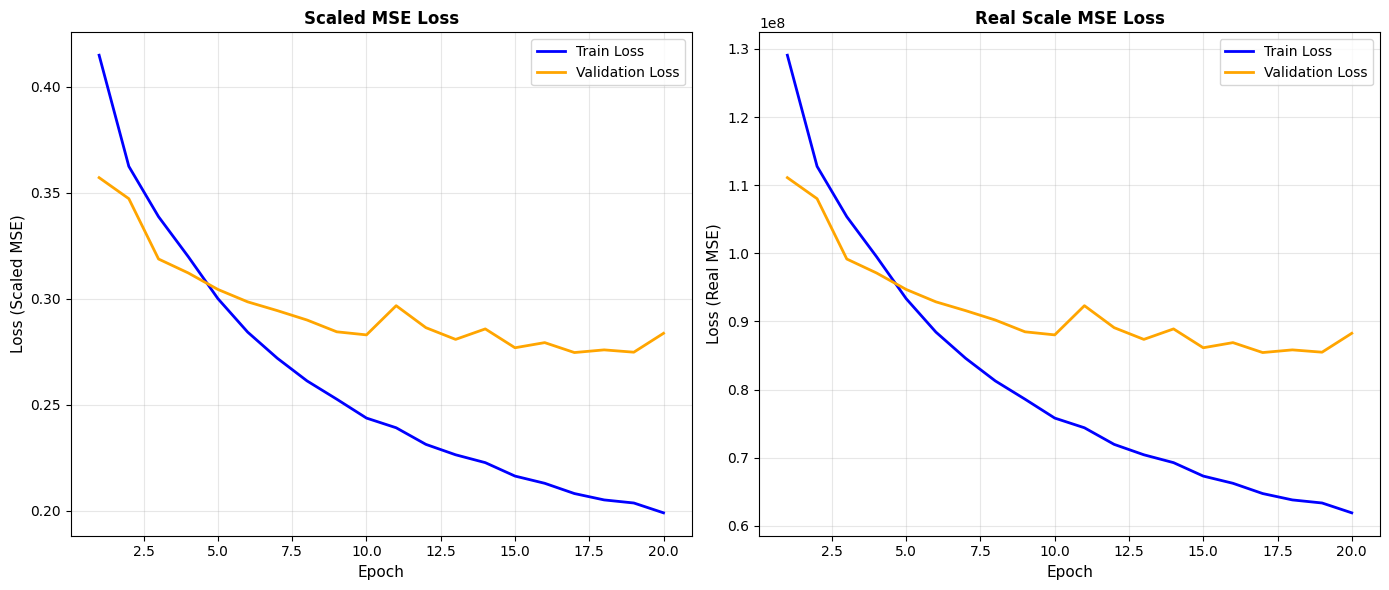

In [209]:
plot_losses_curves(history, loss_fn="mse")

In [211]:
model_name = "tfidf_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [212]:
evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [213]:
all_models_results["TfIdfModelv3"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Complete process for pretrained embeddings approach with single input model

In [ ]:
# We have already run this type of model before, so the code is commented out to avoid redundancy.  
# df = load_data(logger=logger)
# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
#     preprocess_categorical_data(X_train, X_valid, X_test, y_train, logger=logger)
# )

# embeddings, embeddings_dim = preprocess_text_data_embeddings(
#     X_train,
#     X_valid,
#     X_test,
#     save_embeddings=True,
#     embedding_prefix="emb_",
#     embeddings_dir="./embeddings/",
#     logger=logger,
# )

# y_train, y_valid, y_test, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )
# X_train, X_valid, X_test, tabular_start_index = combine_features(
#     text_embeddings=embeddings,
#     categorical_train=X_train_cat,
#     categorical_valid=X_valid_cat,
#     categorical_test=X_test_cat,
#     logger=logger,
# )
# train_dataset, valid_dataset, test_dataset = create_datasets(
#     X_train, X_valid, X_test, y_train, y_valid, y_test, multi_input=False, logger=logger
# )
# train_loader, valid_loader, test_loader = create_dataloaders(
#     train_dataset,
#     valid_dataset,
#     test_dataset,
#     batch_size=64,
#     num_workers=0,
#     seed_worker=seed_worker,
#     generator=g,
#     logger=logger,
# )
# hidden_size = 256
# dropout_rate = 0.3

# model = IntegratedNN(
#     input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
# ).to(device)

# loss_fn = "mse"
# n_epochs = 25
# optimizer_fn = "adam"
# patience = 3
# lr = 0.001

# model, history, elapsed_time = train_model(
#     model,
#     train_loader,
#     valid_loader,
#     target_scaler=target_scaler,
#     device=device,
#     n_epochs=n_epochs,
#     lr=lr,
#     loss_fn=loss_fn,
#     optimizer_fn=optimizer_fn,
#     patience=patience,
#     delta=0.001,
#     early_stopping=None,
#     use_lr_scheduler=False,
#     seed=RANDOM_SEED,
#     logger=logger,
#     multi_input=False,
# )

# plot_losses_curves(history, loss_fn="mse")

# evaluate, save, etc.

### Complete process for pretrained embeddings approach with multi-input model

In [ ]:
# We have already trained and evaluated the same embedding-based model, so this part is commented out.
# df = load_data(logger=logger)
# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
#     preprocess_categorical_data(X_train, X_valid, X_test, y_train, logger=logger)
# )

# embeddings = load_embeddings(
#     embedding_prefix="emb_", embeddings_dir="./embeddings/", logger=logger
# )


# y_train, y_valid, y_test, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# X_train, X_valid, X_test, tabular_start_index = combine_features(
#     text_embeddings=embeddings,
#     categorical_train=X_train_cat,
#     categorical_valid=X_valid_cat,
#     categorical_test=X_test_cat,
#     logger=logger,
# )
# train_dataset, valid_dataset, test_dataset = create_datasets(
#     X_train,
#     X_valid,
#     X_test,
#     y_train,
#     y_valid,
#     y_test,
#     multi_input=True,
#     tabular_start_index=tabular_start_index,
#     logger=logger,
# )
# train_loader, valid_loader, test_loader = create_dataloaders(
#     train_dataset,
#     valid_dataset,
#     test_dataset,
#     batch_size=64,
#     num_workers=0,
#     seed_worker=seed_worker,
#     generator=g,
#     logger=logger,
# )

# embedding_hidden_size = 256
# dropout_rate = 0.3

# model = MultiInputNN(
#     embedding_dim=tabular_start_index,
#     tabular_dim=X_train.shape[1] - tabular_start_index,
#     dropout_prob=dropout_rate,
# ).to(device)

# loss_fn = "mse"
# n_epochs = 25
# optimizer_fn = "adam"
# patience = 3
# lr = 0.001

# model, history, elapsed_time = train_model(
#     model,
#     train_loader,
#     valid_loader,
#     target_scaler=target_scaler,
#     device=device,
#     n_epochs=n_epochs,
#     lr=lr,
#     loss_fn=loss_fn,
#     optimizer_fn=optimizer_fn,
#     patience=patience,
#     delta=0.001,
#     early_stopping=None,
#     use_lr_scheduler=False,
#     seed=RANDOM_SEED,
#     logger=logger,
#     multi_input=True,
# )

# plot_losses_curves(history, loss_fn="mse")

# evaluation, saving model, etc.

### Complete process for multi-input model with TF-IDF

In [ ]:
df = load_data(logger=logger)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
    preprocess_categorical_data(X_train, X_valid, X_test, y_train, logger=logger)
)

embeddings = load_tfidf_features(
    feature_prefix="tfidf_", features_dir="./tfidf_features/", logger=logger
)


y_train, y_valid, y_test, target_scaler = preprocess_target(
    y_train, y_valid, y_test, logger=logger
)

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Categorical features preprocessed successfully.
INFO - TF-IDF features loaded from directory: ./tfidf_features/
INFO - Target scaler saved to: preprocessors/target_scaler.pkl


In [231]:
X_train, X_valid, X_test, tabular_start_index = combine_features(
    text_embeddings=embeddings,
    categorical_train=X_train_cat,
    categorical_valid=X_valid_cat,
    categorical_test=X_test_cat,
    logger=logger,
)
train_dataset, valid_dataset, test_dataset = create_datasets(
    X_train,
    X_valid,
    X_test,
    y_train,
    y_valid,
    y_test,
    multi_input=True,
    tabular_start_index=tabular_start_index,
    logger=logger,
)
train_loader, valid_loader, test_loader = create_dataloaders(
    train_dataset,
    valid_dataset,
    test_dataset,
    batch_size=64,
    num_workers=0,
    seed_worker=seed_worker,
    generator=g,
    logger=logger,
)

INFO - Features combined successfully.
INFO - MultiInputDataset created with tabular_start_index=38.
INFO - DataLoaders created with batch_size=64


In [232]:
embedding_hidden_size = 256
dropout_rate = 0.3

model = MultiInputNN(
    embedding_dim=tabular_start_index,
    tabular_dim=X_train.shape[1] - tabular_start_index,
    dropout_prob=dropout_rate,
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
)

INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.


INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4486, Real MSE: 139601930.79, Real RMSE: 11815.33
INFO -   Valid - MSE: 0.3701, Real MSE: 115188481.96, Real RMSE: 10732.59
INFO - Initial validation loss: 0.370127
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3985, Real MSE: 124020583.06, Real RMSE: 11136.45
INFO -   Valid - MSE: 0.3604, Real MSE: 112149524.22, Real RMSE: 10590.07
INFO - Validation loss improved by 0.009765 to 0.360362
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3816, Real MSE: 118764527.95, Real RMSE: 10897.91
INFO -   Valid - MSE: 0.3532, Real MSE: 109933224.40, Real RMSE: 10484.90
INFO - Validation loss improved by 0.007121 to 0.353241
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3683, Real MSE: 114632495.08, Real RMSE: 10706.66
INFO -   Valid - MSE: 0.3404, Real MSE: 105943804.64, Real RMSE: 10292.90
INFO - Validation loss improved by 0.012819 to 0.340422
INFO - Epoch 5/25:
INFO -   Train - MSE: 0.3557, Real MSE: 110713887.26, Real RMSE: 10522.07
INFO -   Valid - MSE: 0.3362, 

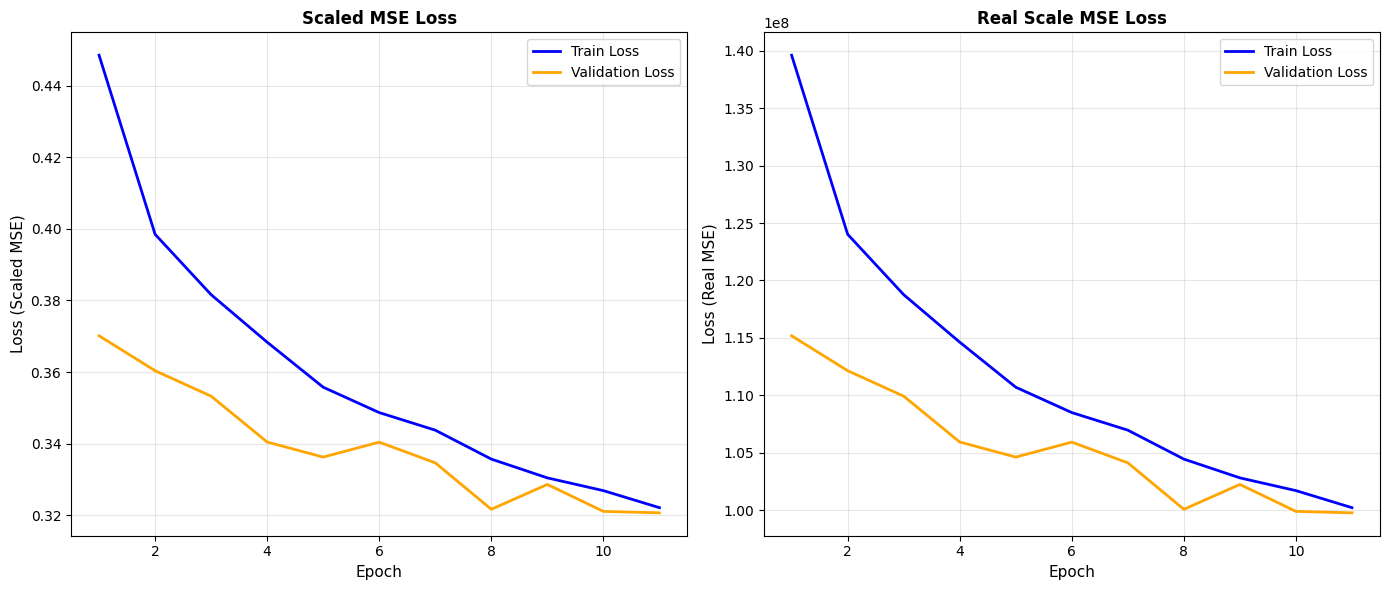

In [233]:
plot_losses_curves(history, loss_fn="mse")

In [234]:
model_name = "tfidf_800_50_multi_unk_bs64_adam_lrs_no_hid256_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [235]:
evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [236]:
all_models_results["TfIdfModelv4"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Results summary


We can see that pretrained embeddings give better results than TF-IDF approach. However, the difference is not very large. The single input model works better than multi-input model in this case. The best model is the one with pretrained embeddings and single input.


### Tuning hyperparameters for single-input model with TF-IDF

#### Validation Score for single-input tf-idf without fine tuning: 0.275847

#### Filling missing values with most frequent value instead of 'Unknown'

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Categorical features preprocessed successfully.
INFO - TF-IDF features loaded from directory: ./tfidf_features/
INFO - Target scaler saved to: preprocessors/target_scaler.pkl
INFO - Features combined successfully.
INFO - Standard SalaryDataset created.
INFO - DataLoaders created with batch_size=64
INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architecture detected.
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4091, Real MSE: 127317874.18, Real RMSE: 11283.52
INFO -   Valid - MSE: 0.3615, Real MSE: 112

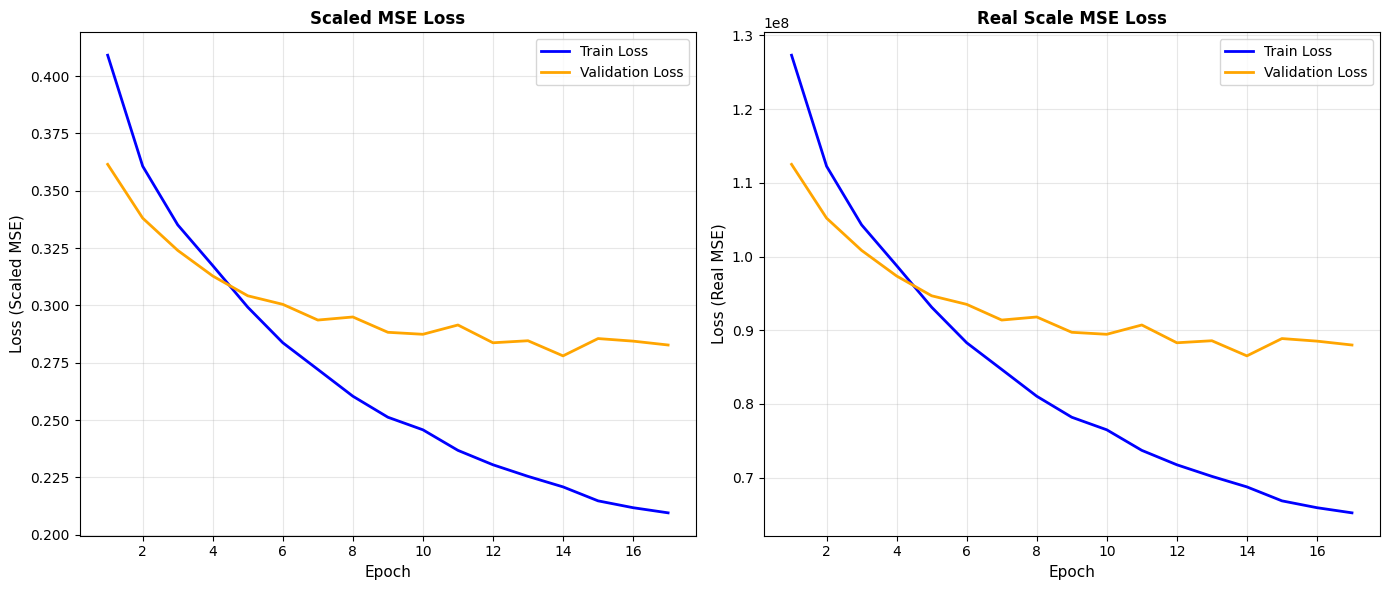

In [ ]:
df = load_data(logger=logger)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
    preprocess_categorical_data(
        X_train,
        X_valid,
        X_test,
        y_train,
        categorical_fill_value="most_frequent",
        high_card_na_strategy="most_frequent",
        logger=logger,
    )
)

embeddings = load_tfidf_features(
    feature_prefix="tfidf_", features_dir="./tfidf_features/", logger=logger
)


y_train, y_valid, y_test, target_scaler = preprocess_target(
    y_train, y_valid, y_test, logger=logger
)

X_train, X_valid, X_test, tabular_start_index = combine_features(
    text_embeddings=embeddings,
    categorical_train=X_train_cat,
    categorical_valid=X_valid_cat,
    categorical_test=X_test_cat,
    logger=logger,
)

train_dataset, valid_dataset, test_dataset = create_datasets(
    X_train, X_valid, X_test, y_train, y_valid, y_test, multi_input=False, logger=logger
)

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dataset,
    valid_dataset,
    test_dataset,
    batch_size=64,
    num_workers=0,
    seed_worker=seed_worker,
    generator=g,
    logger=logger,
)

hidden_size = 256
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

plot_losses_curves(history, "mse")

In [239]:
model_name = "tfidf_800_50_int_mf_bs64_adam_lrs_no_hid256_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [240]:
evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [241]:
all_models_results["TfIdfModelv5"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Using Simpler Model with one less layer and less neurons

INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architecture detected.
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4319, Real MSE: 134408965.71, Real RMSE: 11593.49
INFO -   Valid - MSE: 0.3722, Real MSE: 115841365.09, Real RMSE: 10762.96
INFO - Initial validation loss: 0.372225
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3890, Real MSE: 121049023.43, Real RMSE: 11002.23
INFO -   Valid - MSE: 0.3538, Real MSE: 110099403.16, Real RMSE: 10492.83
INFO - Validation loss improved by 0.018450 to 0.353775
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3733, Real MSE: 116185372.24, Real RMSE: 10778.93
INFO -   Valid - MSE: 0.3468, Real MSE: 107935334.62, Real RMSE: 10389.19
INFO - Validation loss improved by 0.006954 to 0.346821
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3604, Real MSE: 112

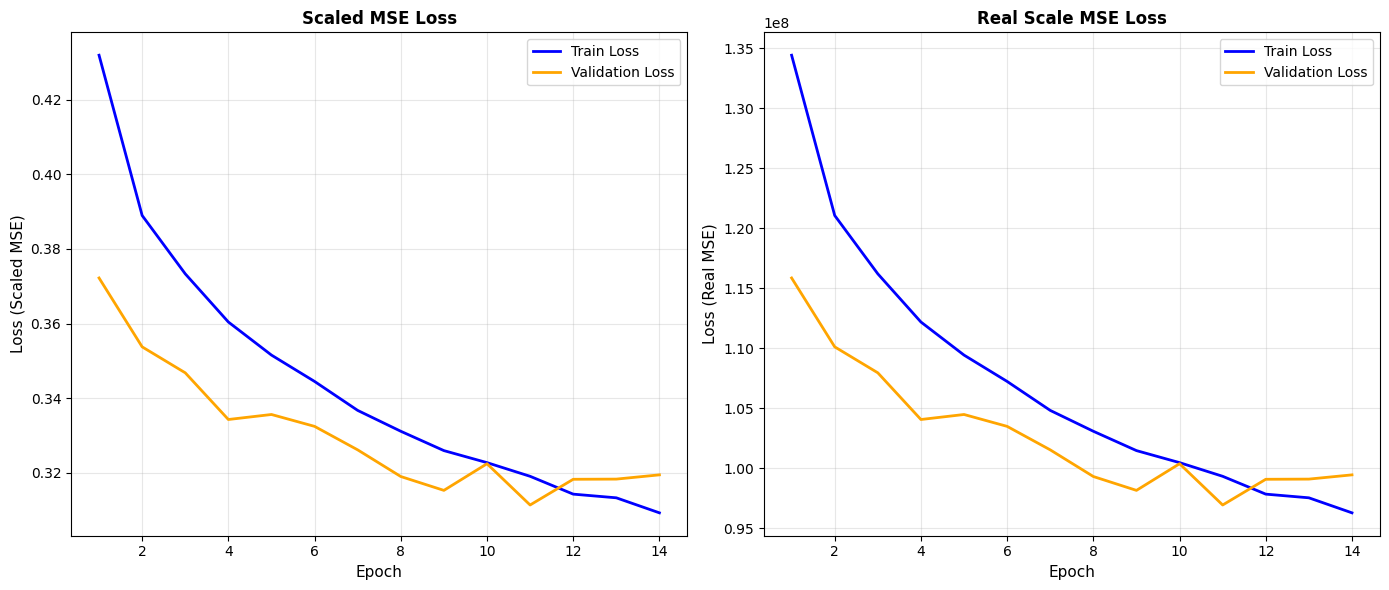

In [242]:
hidden_size = 64
model = SimpleRegressorWithNormalization(
    input_dim=X_train.shape[1], hidden_size=hidden_size
)
loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

plot_losses_curves(history, "mse")

In [243]:
all_models_results["TfIdfModelv6"] = collect_model_metrics_manual(
    model=model,
    model_name=model_name,
    train_losses_scaled=train_losses_scaled,
    valid_losses_scaled=valid_losses_scaled,
    train_losses_real=train_losses_real,
    valid_losses_real=valid_losses_real,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

In [245]:
model_name = "tfidf_800_50_srbn_unk_bs64_adam_lrs_no_hid64_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


#### More complex model but with 2 times fewer neurons in each layer

INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architecture detected.
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4264, Real MSE: 132691571.45, Real RMSE: 11519.18
INFO -   Valid - MSE: 0.3659, Real MSE: 113874186.65, Real RMSE: 10671.18
INFO - Initial validation loss: 0.365904
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3797, Real MSE: 118162617.28, Real RMSE: 10870.26
INFO -   Valid - MSE: 0.3512, Real MSE: 109306963.27, Real RMSE: 10455.00
INFO - Validation loss improved by 0.014676 to 0.351228
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3576, Real MSE: 111282587.93, Real RMSE: 10549.06
INFO -   Valid - MSE: 0.3288, Real MSE: 102311936.91, Real RMSE: 10114.94
INFO - Validation loss improved by 0.022477 to 0.328752
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3400, Real MSE: 105

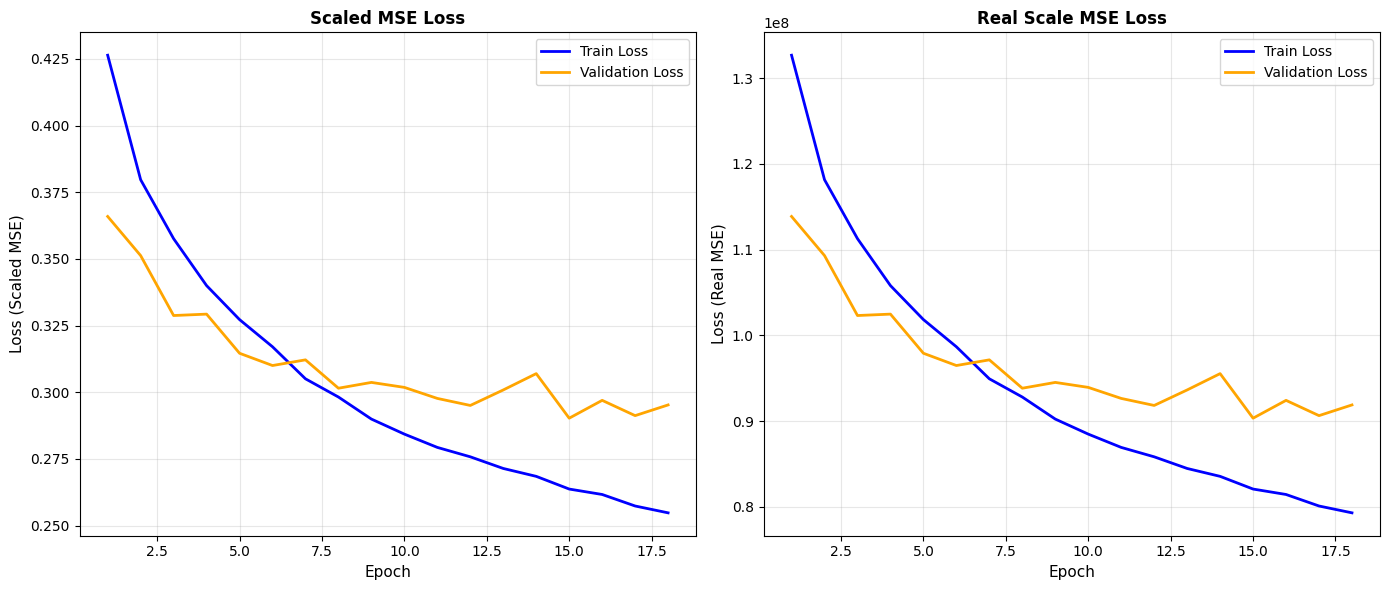

In [246]:
hidden_size = 128
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

plot_losses_curves(history, "mse")

In [248]:
model_name = "tfidf_800_50_int_unk_bs64_adam_lrs_no_hid128_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [249]:
all_models_results["TfIdfModelv7"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Using learning rate scheduler

INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architecture detected.
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4112, Real MSE: 127976511.30, Real RMSE: 11312.67
INFO -   Valid - MSE: 0.3564, Real MSE: 110901754.39, Real RMSE: 10530.99
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.356353
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.3606, Real MSE: 112213699.02, Real RMSE: 10593.10
INFO -   Valid - MSE: 0.3427, Real MSE: 106640578.46, Real RMSE: 10326.69
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.013692 to 0.342661
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.3349, Real MSE: 104235032.33, Real RMSE: 10209.56
INFO -   Valid - MSE: 0.3274, Real MSE: 101881971.01, R

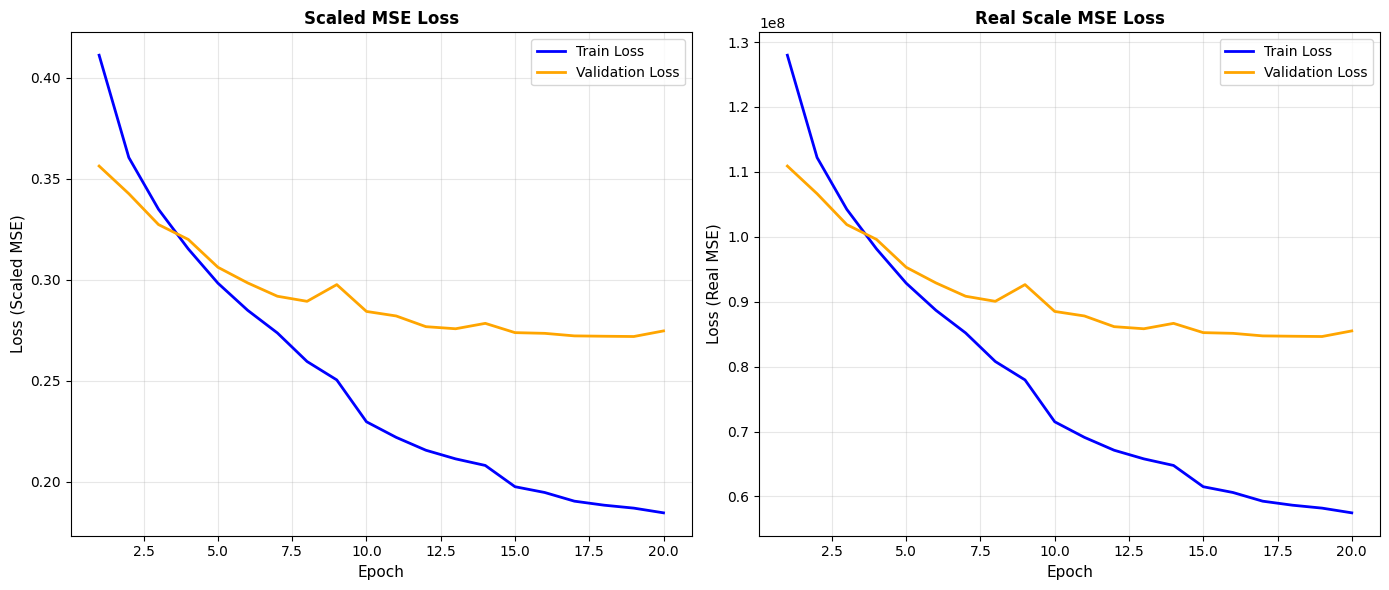

In [250]:
hidden_size = 256
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

plot_losses_curves(history, "mse")

In [251]:
model_name = "tfidf_800_50_int_unk_bs64_adam_lrs_hid256_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [252]:
all_models_results["TfIdfModelv8"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Using other optimizer - SGD with momentum=0.9

INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: sgd with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architecture detected.
INFO - Epoch 1/25:
INFO -   Train - MSE: 0.4900, Real MSE: 152483725.25, Real RMSE: 12348.43
INFO -   Valid - MSE: 0.4062, Real MSE: 126411599.69, Real RMSE: 11243.29
INFO - Initial validation loss: 0.406189
INFO - Epoch 2/25:
INFO -   Train - MSE: 0.4235, Real MSE: 131805347.97, Real RMSE: 11480.65
INFO -   Valid - MSE: 0.3968, Real MSE: 123474161.31, Real RMSE: 11111.89
INFO - Validation loss improved by 0.009439 to 0.396751
INFO - Epoch 3/25:
INFO -   Train - MSE: 0.4089, Real MSE: 127242251.49, Real RMSE: 11280.17
INFO -   Valid - MSE: 0.3726, Real MSE: 115964838.87, Real RMSE: 10768.70
INFO - Validation loss improved by 0.024129 to 0.372622
INFO - Epoch 4/25:
INFO -   Train - MSE: 0.3963, Real MSE: 1233

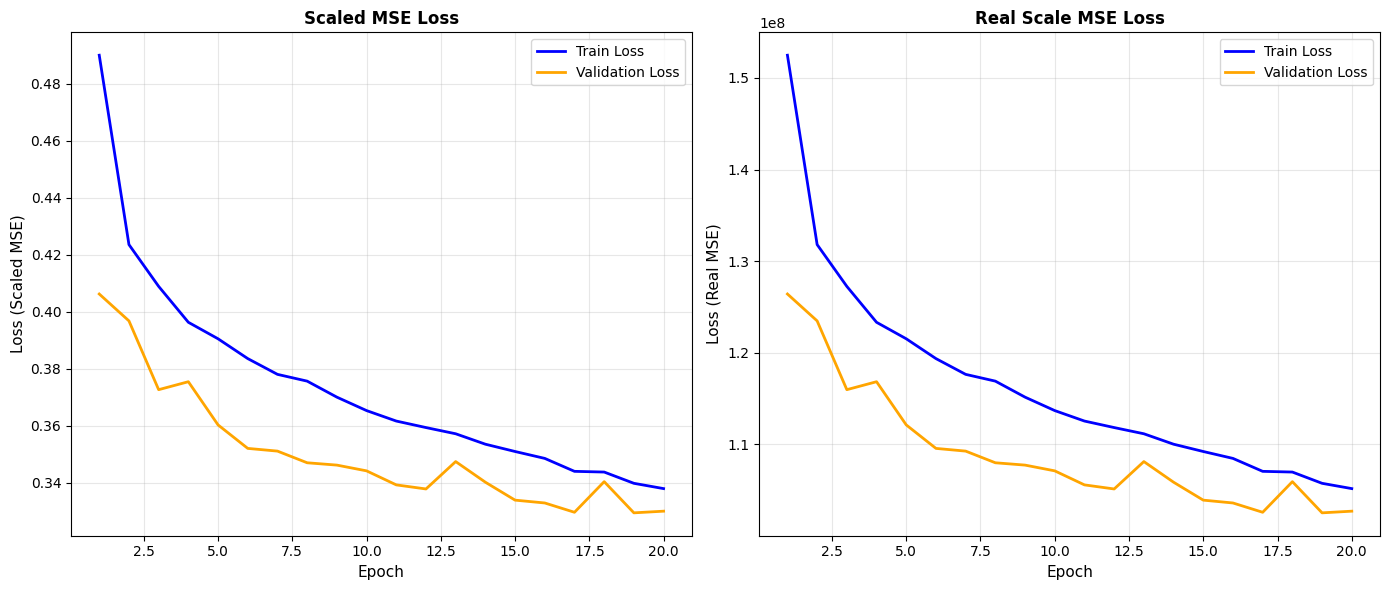

In [253]:
hidden_size = 256
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "sgd"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

plot_losses_curves(history, "mse")

In [255]:
model_name = "tfidf_800_50_int_unk_bs64_sgd_lrs_no_hid256_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

evaluation_metrics = evaluate_model(
    model,
    test_loader,
    target_scaler=target_scaler,
    training_time=elapsed_time,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [256]:
all_models_results["TfIdfModelv9"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

Ok, so the best model for single-input with TF-IDF is the one with filling missing values with most frequent value, IntegratedNN model, batch size of 64, Adam optimizer and learning rate scheduler.

Now I will try to modify TfidfVectorizer parameters.

#### Adding svd to reduce dimensionality of text features

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Categorical features preprocessed successfully.
INFO - Text preprocessing pipelines created.
INFO - TF-IDF features generated successfully.
Title TF-IDF dimension: 10
Description TF-IDF dimension: 200
INFO - TF-IDF features saved to directory: ./tfidf_features/
INFO - Target scaler saved to: preprocessors/target_scaler.pkl
INFO - Features combined successfully.
INFO - Standard SalaryDataset created.
INFO - DataLoaders created with batch_size=64
INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architect

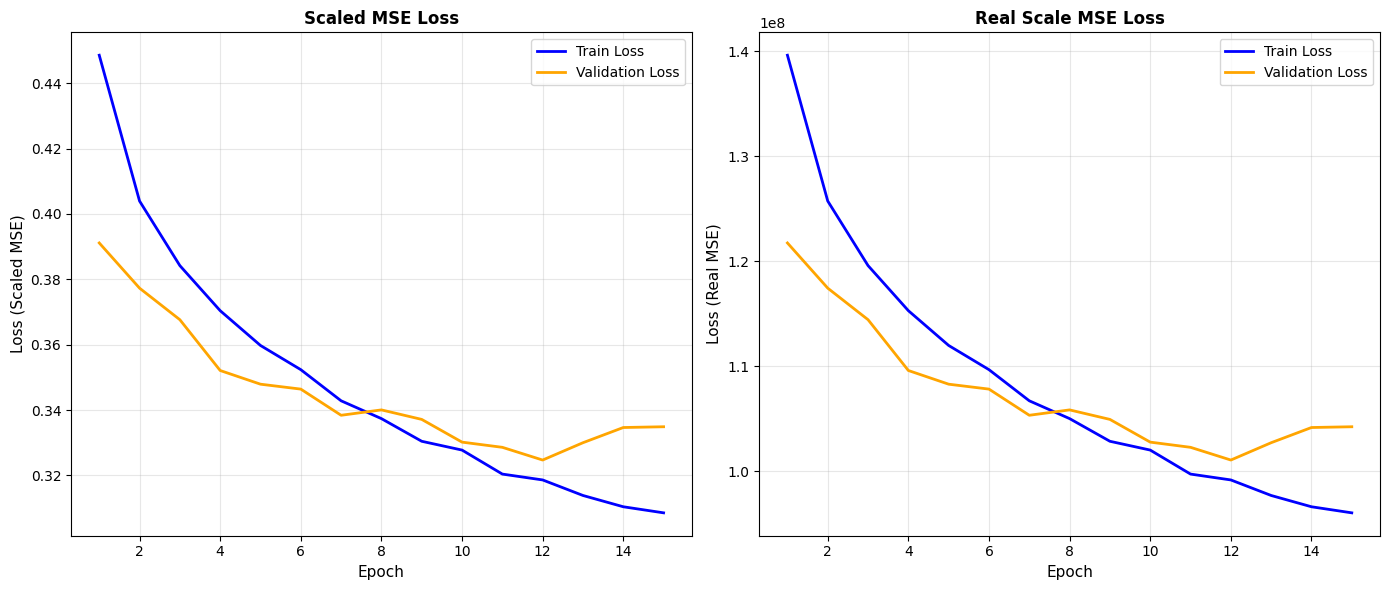

In [ ]:
df = load_data(logger=logger)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
    preprocess_categorical_data(X_train, X_valid, X_test, y_train, logger=logger)
)

embeddings, title_dim, desc_dim, text_preprocessor = preprocess_text_data_tfidf(
    X_train,
    X_valid,
    X_test,
    save_features=True,
    desc_use_svd=True,
    desc_n_components=200,
    title_use_svd=True,
    title_n_components=10,
    feature_prefix="tfidf_svd_",
    features_dir="./tfidf_features/",
    logger=logger,
)


y_train, y_valid, y_test, target_scaler = preprocess_target(
    y_train, y_valid, y_test, logger=logger
)

X_train, X_valid, X_test, tabular_start_index = combine_features(
    text_embeddings=embeddings,
    categorical_train=X_train_cat,
    categorical_valid=X_valid_cat,
    categorical_test=X_test_cat,
    logger=logger,
)

train_dataset, valid_dataset, test_dataset = create_datasets(
    X_train, X_valid, X_test, y_train, y_valid, y_test, multi_input=False, logger=logger
)

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dataset,
    valid_dataset,
    test_dataset,
    batch_size=64,
    num_workers=0,
    seed_worker=seed_worker,
    generator=g,
    logger=logger,
)

hidden_size = 256
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

plot_losses_curves(history, "mse")

In [259]:
model_name = "tfidf_svd_200_10_int_unk_bs64_adam_lrs_no_hid256_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [260]:
all_models_results["TfIdfModelv10"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Using remove stop words for title and description in TfidfVectorizer

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Categorical features preprocessed successfully.
INFO - Text preprocessing pipelines created.
INFO - TF-IDF features generated successfully.
Title TF-IDF dimension: 50
Description TF-IDF dimension: 800
INFO - TF-IDF features saved to directory: ./tfidf_features/
INFO - Target scaler saved to: preprocessors/target_scaler.pkl
INFO - Features combined successfully.
INFO - Standard SalaryDataset created.
INFO - DataLoaders created with batch_size=64
INFO - Starting training for 25 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Single-input architect

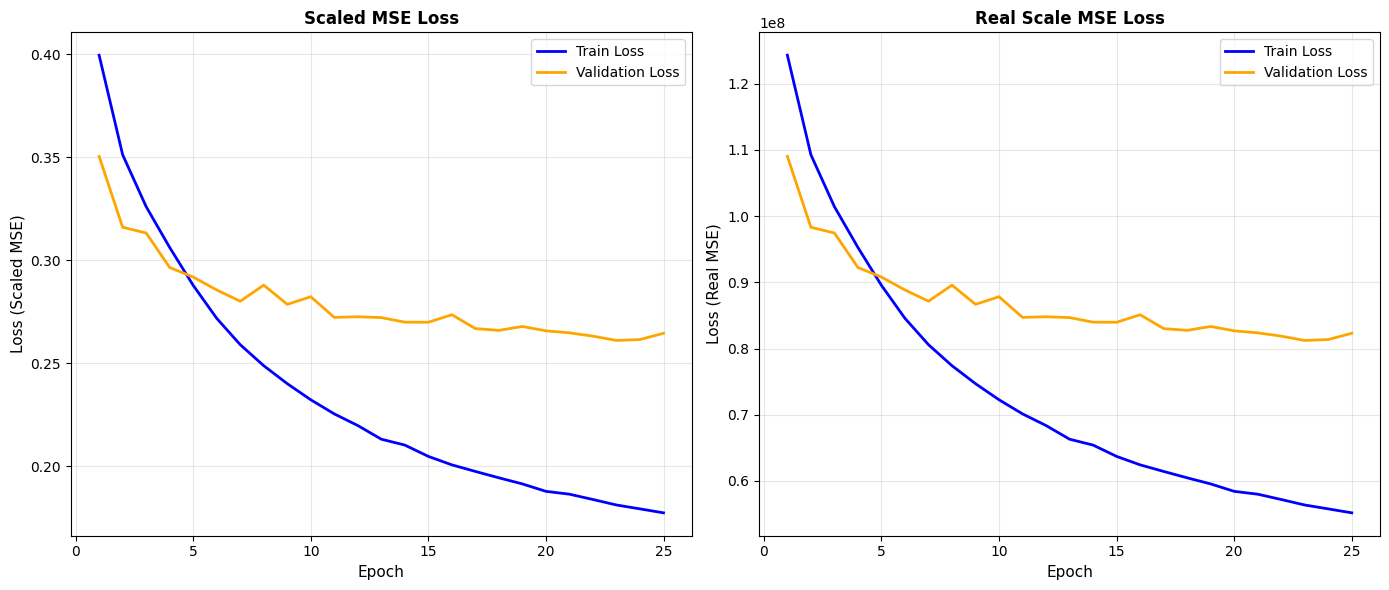

In [ ]:
df = load_data(logger=logger)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
    preprocess_categorical_data(X_train, X_valid, X_test, y_train, logger=logger)
)

embeddings, title_dim, desc_dim, text_preprocessor = preprocess_text_data_tfidf(
    X_train,
    X_valid,
    X_test,
    save_features=True,
    title_stop_words="english",
    desc_stop_words="english",
    feature_prefix="tfidf_stop_words_",
    features_dir="./tfidf_features/",
    logger=logger,
)


y_train, y_valid, y_test, target_scaler = preprocess_target(
    y_train, y_valid, y_test, logger=logger
)

X_train, X_valid, X_test, tabular_start_index = combine_features(
    text_embeddings=embeddings,
    categorical_train=X_train_cat,
    categorical_valid=X_valid_cat,
    categorical_test=X_test_cat,
    logger=logger,
)

train_dataset, valid_dataset, test_dataset = create_datasets(
    X_train, X_valid, X_test, y_train, y_valid, y_test, multi_input=False, logger=logger
)

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dataset,
    valid_dataset,
    test_dataset,
    batch_size=64,
    num_workers=0,
    seed_worker=seed_worker,
    generator=g,
    logger=logger,
)

hidden_size = 256
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 25
optimizer_fn = "adam"
patience = 3
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
)

plot_losses_curves(history, "mse")

In [263]:
model_name = "tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    log=False,
    multi_input=False,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [264]:
all_models_results["TfIdfModelv11"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Compare results of best models on the test set

In [ ]:
def plot_top_models_comparison(
    results_dict: dict,
    top_n: int = 10,
    figsize: tuple = (16, 6),
    save_path: Optional[str] = None,
    logger: Optional[logging.Logger] = None,
) -> None:
    """
    Creates side-by-side bar plots comparing models by Test MSE (scaled) and Test RMSE (real).

    Args:
        results_dict: dict, Dictionary with model names as keys and metrics as values
        top_n: int, Number of top models to display (default: 10)
        figsize: tuple, Figure size as (width, height) tuple
        save_path: Optional[str], path to save the plot image. If None, the plot is shown
                   but not saved.
        logger: Optional[logging.Logger], logger instance for output (default: None, no output)
    """
    # Extract data from results dictionary
    model_names = list(results_dict.keys())
    mse_scaled = [results_dict[name]["Test MSE (scaled)"] for name in model_names]
    rmse_real = [float(results_dict[name]["Test RMSE (real)"]) for name in model_names]

    # Create dataframe-like structure for sorting
    data = list(zip(model_names, mse_scaled, rmse_real))

    # Sort by MSE (scaled) and get top N
    data_sorted_mse = sorted(data, key=lambda x: x[1])[:top_n]
    top_names_mse = [x[0] for x in data_sorted_mse]
    top_mse_scaled = [x[1] for x in data_sorted_mse]
    top_mse_real = [results_dict[x]["Test MSE (real)"] for x in top_names_mse]
    top_mse_time = [results_dict[x]["Training Time (minutes)"] for x in top_names_mse]

    # Sort by RMSE (real) and get top N
    data_sorted_rmse = sorted(data, key=lambda x: x[2])[:top_n]
    top_names_rmse = [x[0] for x in data_sorted_rmse]
    top_rmse_real = [x[2] for x in data_sorted_rmse]
    top_rmse_time = [results_dict[x]["Training Time (minutes)"] for x in top_names_rmse]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Left plot: Top 10 by Test MSE (scaled)
    y_pos_1 = np.arange(len(top_names_mse))
    bars1 = ax1.barh(y_pos_1, top_mse_scaled, color="steelblue", alpha=0.8)
    ax1.set_yticks(y_pos_1)
    # Add training time to labels
    labels_mse = [
        f"{name} ({time:.2f}min)" for name, time in zip(top_names_mse, top_mse_time)
    ]
    ax1.set_yticklabels(labels_mse, fontsize=9)
    ax1.invert_yaxis()  # Best model at top
    ax1.set_xlabel("Test MSE (scaled)", fontsize=11, fontweight="bold")
    ax1.set_title(
        f"Top {top_n} Models by Test MSE (Scaled)",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )
    ax1.grid(axis="x", alpha=0.3, linestyle="--")

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, top_mse_scaled)):
        ax1.text(val, i, f" {val:.4f}", va="center", fontsize=8)

    # Right plot: Top 10 by Test RMSE (real)
    y_pos_2 = np.arange(len(top_names_rmse))
    bars2 = ax2.barh(y_pos_2, top_rmse_real, color="coral", alpha=0.8)
    ax2.set_yticks(y_pos_2)
    # Add training time to labels
    labels_rmse = [
        f"{name} ({time:.2f}min)" for name, time in zip(top_names_rmse, top_rmse_time)
    ]
    ax2.set_yticklabels(labels_rmse, fontsize=9)
    ax2.invert_yaxis()  # Best model at top
    ax2.set_xlabel("Test RMSE (real)", fontsize=11, fontweight="bold")
    ax2.set_title(
        f"Top {top_n} Models by Test RMSE (Real Scale)",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )
    ax2.grid(axis="x", alpha=0.3, linestyle="--")

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars2, top_rmse_real)):
        ax2.text(val, i, f" {val:.1f}", va="center", fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        if logger:
            logger.info(f"Top models comparison plot saved to {save_path}.")
    plt.show()

    # Print summary statistics only if logger is provided
    if logger is not None:
        logger.info(f"\n{'=' * 70}")
        logger.info(f"TOP {top_n} MODELS SUMMARY")
        logger.info(f"{'=' * 70}")

        # Best model by scaled MSE
        best_mse_name = top_names_mse[0]
        best_mse_metrics = results_dict[best_mse_name]
        logger.info(f"\nBest Model (by scaled MSE): {best_mse_name}")
        logger.info(f"  All Metrics:")
        for metric_name, metric_value in best_mse_metrics.items():
            if isinstance(metric_value, (np.floating, np.integer)):
                metric_value = float(metric_value)
            if "scaled" in metric_name.lower():
                logger.info(f"    - {metric_name}: {metric_value:.6f}")
            elif "time" in metric_name.lower():
                logger.info(f"    - {metric_name}: {metric_value:.2f} min")
            else:
                logger.info(f"    - {metric_name}: {metric_value:,.2f}")

        # Best model by real RMSE
        best_rmse_name = top_names_rmse[0]
        best_rmse_metrics = results_dict[best_rmse_name]
        logger.info(f"\nBest Model (by real RMSE): {best_rmse_name}")
        logger.info(f"  All Metrics:")
        for metric_name, metric_value in best_rmse_metrics.items():
            if isinstance(metric_value, (np.floating, np.integer)):
                metric_value = float(metric_value)
            if "scaled" in metric_name.lower():
                logger.info(f"    - {metric_name}: {metric_value:.6f}")
            elif "time" in metric_name.lower():
                logger.info(f"    - {metric_name}: {metric_value:.2f} min")
            else:
                logger.info(f"    - {metric_name}: {metric_value:,.2f}")

        logger.info(f"{'=' * 70}\n")

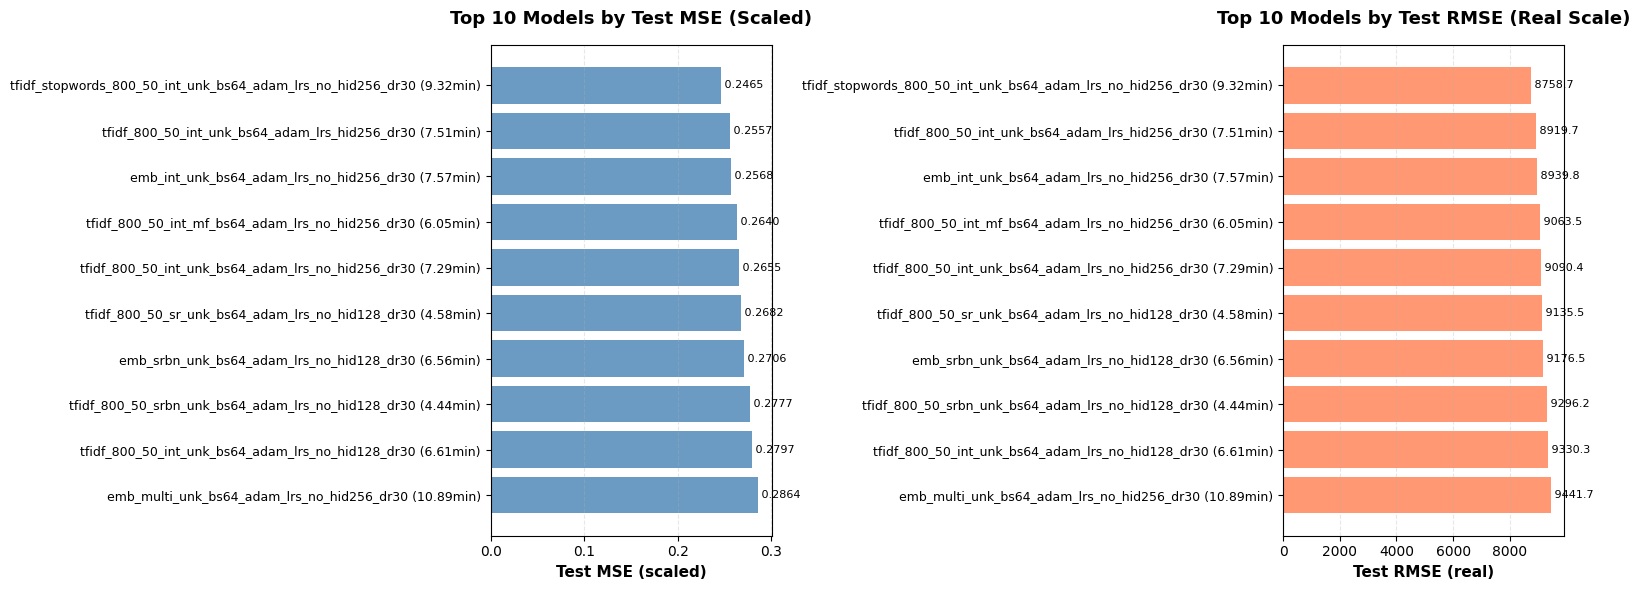

INFO - 
INFO - TOP 10 MODELS SUMMARY
INFO - ======================================================================
INFO - 
Best Model (by scaled MSE): tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30
INFO -   All Metrics:
INFO -     - Test MSE (scaled): 0.246504
INFO -     - Test MSE (real): 76,715,512.00
INFO -     - Test RMSE (real): 8,758.74
INFO -     - Training Time (minutes): 9.32 min
INFO - 
Best Model (by real RMSE): tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30
INFO -   All Metrics:
INFO -     - Test MSE (scaled): 0.246504
INFO -     - Test MSE (real): 76,715,512.00
INFO -     - Test RMSE (real): 8,758.74
INFO -     - Training Time (minutes): 9.32 min
INFO - ======================================================================



In [266]:
plot_top_models_comparison(
    tfidf_and_embedding_model_test_results, top_n=10, figsize=(16, 6), logger=logger
)

In [267]:
pandas_df = results_to_dataframe(all_models_results)
pandas_df.head()

Model  Parameters  Training Time (min)  Epochs  Best Epoch  \
0  CategoricalModelv1       13185                 4.72      11           9   
1  CategoricalModelv2       12929                 2.54       6           3   
2  CategoricalModelv3       13185                 1.53       7           7   
3  CategoricalModelv4        4545                 1.74       8           5   
4  CategoricalModelv5       13185                 1.50       9           7   

   Train RMSE  Valid RMSE  Test RMSE  
0    13213.59    13670.57   13284.84  
1    13447.09    13843.15   13512.25  
2    13219.85    13664.74   13300.22  
3    13329.56    13694.84   13322.27  
4    13300.99    13696.73   13366.86

### Trying to predict log of salary instead of standardized salary

I updated functions to include option to log-transform the target variable and perform propere transformations when evaluating the model.

In [268]:
LOG = True

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Target variable 'SalaryNormalized' has been log-transformed.
INFO - Categorical features preprocessed successfully.
INFO - TF-IDF features loaded from directory: ./tfidf_features/
INFO - Log mode: Skipping StandardScaler fitting and artifact saving
INFO - Features combined successfully.
INFO - Standard SalaryDataset created.
INFO - DataLoaders created with batch_size=64
INFO - Starting training for 40 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 2 and factor 0.5 enabled.
INFO - Early stopping patience: 6, delta: 0.001
INFO - Log mode: Real metrics will be computed using expm1.
INFO - Single-input architecture detected.
INFO - 

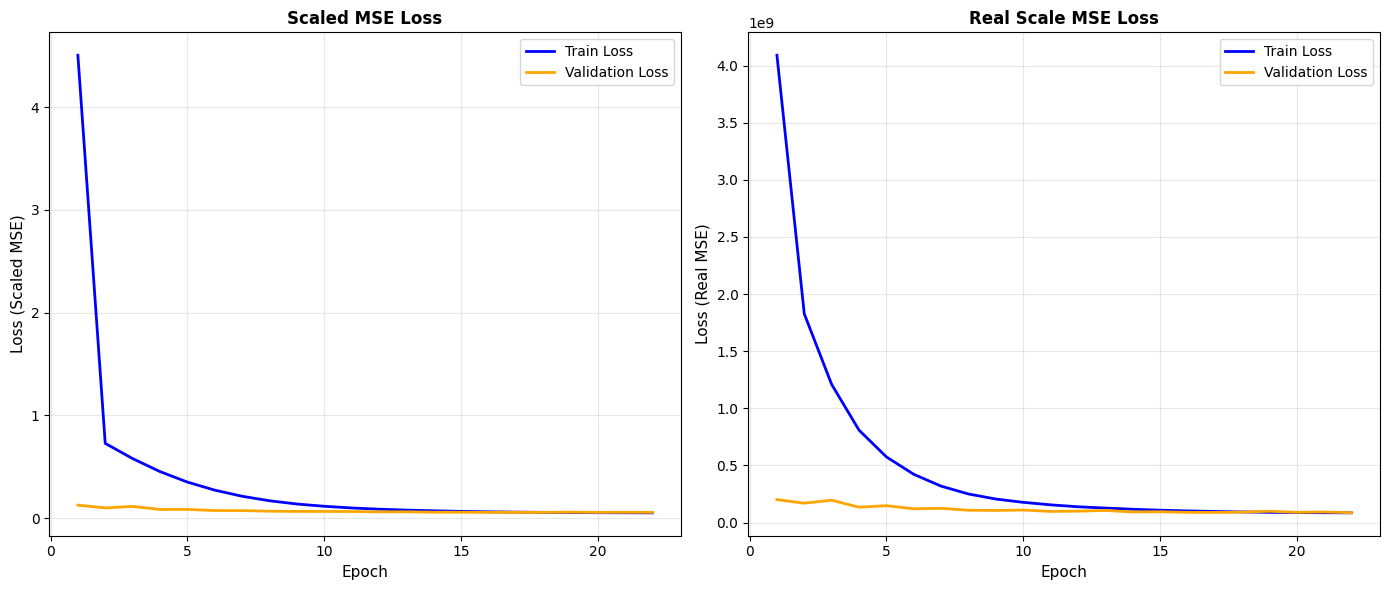

In [ ]:
df = load_data(logger=logger)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(
    df, logger=logger, log=LOG
)

X_train_cat, X_valid_cat, X_test_cat, categorical_preprocessor = (
    preprocess_categorical_data(X_train, X_valid, X_test, y_train, logger=logger)
)

embeddings = load_tfidf_features("tfidf_stop_words_", logger=logger)


y_train, y_valid, y_test, target_scaler = preprocess_target(
    y_train, y_valid, y_test, logger=logger, log=LOG
)

X_train, X_valid, X_test, tabular_start_index = combine_features(
    text_embeddings=embeddings,
    categorical_train=X_train_cat,
    categorical_valid=X_valid_cat,
    categorical_test=X_test_cat,
    logger=logger,
)

train_dataset, valid_dataset, test_dataset = create_datasets(
    X_train, X_valid, X_test, y_train, y_valid, y_test, multi_input=False, logger=logger
)

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dataset,
    valid_dataset,
    test_dataset,
    batch_size=64,
    num_workers=0,
    seed_worker=seed_worker,
    generator=g,
    logger=logger,
)

hidden_size = 256
dropout_rate = 0.3

model = IntegratedNN(
    input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_prob=dropout_rate
).to(device)

loss_fn = "mse"
n_epochs = 40
optimizer_fn = "adam"
patience = 6
lr = 0.001

model, history, elapsed_time = train_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=False,
    log=LOG,
)

plot_losses_curves(history, "mse")

In [270]:
model_name = "tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_hid256_dr30_logy"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

In [271]:
# Show results on test set
evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str=loss_fn,
    model_name=model_name,
    results_dict=tfidf_and_embedding_model_test_results,
    multi_input=False,
    logger=logger,
    log=LOG,
)
print(evaluation_metrics)

INFO - Evaluation metrics stored successfully.
{'Test MSE (scaled)': 0.05582588867041568, 'Test MSE (real)': 81674900.0, 'Test RMSE (real)': 9037.416, 'Training Time (minutes)': 8.200174295902253}


In [272]:
all_models_results["TfIdfModelLog"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=tfidf_and_embedding_model_test_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

## Self-taught embeddings

In [273]:
# Dictionary to hold models results on test set for self-taught embeddings, trained Word2Vec embeddings, and Ready-to-use embeddings
embeddings_models_results = {}

### Quick check of data

In [274]:
df = load_data()

In [275]:
df["Title_length"] = df["Title"].apply(
    lambda x: len(x.split()) if isinstance(x, str) else 0
)
df["Desc_length"] = df["FullDescription"].apply(
    lambda x: len(x.split()) if isinstance(x, str) else 0
)
df["Text_length"] = df["Title_length"] + df["Desc_length"]
df[["Title_length", "Desc_length", "Text_length"]].describe()

Title_length    Desc_length    Text_length
count  244768.000000  244768.000000  244768.000000
mean        4.213917     244.837230     249.051146
std         2.238596     130.211868     130.573126
min         1.000000       4.000000      13.000000
25%         3.000000     154.000000     158.000000
50%         4.000000     226.000000     231.000000
75%         5.000000     312.000000     317.000000
max        24.000000    2113.000000    2118.000000

In [276]:
df.drop(columns=["Title_length", "Desc_length", "Text_length"], inplace=True)

### Optional function to clean tokens

In [ ]:
def clean_tokens(
    tokens: list[str],
    remove_urls: bool = True,
    remove_emails: bool = True,
    remove_numbers: bool = False,
    remove_special_chars: bool = True,
    remove_stopwords: bool = False,
    lemmatize: bool = False,
    min_token_length: int = 1,
    max_token_length: Optional[int] = None,
    stop_words: Optional[set[str]] = None,
) -> list[str]:
    """
    Clean a list of tokens with multiple configurable options.

    Args:
        tokens: list[str], List of tokens to be cleaned.
        remove_urls: bool, Whether to remove tokens that are URLs, default is True.
        remove_emails: bool, Whether to remove tokens that are email addresses, default is True.
        remove_numbers: bool, Whether to remove tokens that are pure numbers, default is False.
        remove_special_chars: bool, Whether to remove special characters from tokens, default is True.
        remove_stopwords: bool, Whether to remove common English stopwords, default is False.
        lemmatize: bool, Whether to lemmatize tokens, default is False.
        min_token_length: int, Minimum length of tokens to keep, default is 1.
        max_token_length: Optional[int], Maximum length of tokens to keep, default is None (no limit).
        stop_words: Optional[set[str]], Set of stopwords to use if remove_stopwords is True,
                    default is None (uses NLTK English stopwords).
    Returns:
        list[str]: Cleaned list of tokens
    """
    if not tokens:
        return []

    # Initialize lemmatizer and stopwords if needed
    lemmatizer = None
    if lemmatize:
        lemmatizer = WordNetLemmatizer()

    if remove_stopwords and stop_words is None:
        stop_words = set(stopwords.words("english"))

    cleaned_tokens = []

    for token in tokens:
        if not token or not isinstance(token, str):
            continue

        # Skip empty tokens
        if not token.strip():
            continue

        # 1. Remove URLs
        if remove_urls:
            if re.match(r"http\S+|www\S+|https\S+", token):
                continue

        # 2. Remove emails
        if remove_emails:
            if re.match(r"\S+@\S+", token):
                continue

        # 3. Remove pure numbers
        if remove_numbers:
            if token.isdigit():
                continue

        # 4. Remove special characters from token
        if remove_special_chars:
            token = re.sub(r"[^\w+#.+-]", "", token)
            if not token:  # Skip if token becomes empty
                continue

        # 5. Filter by token length
        if len(token) < min_token_length:
            continue
        if max_token_length and len(token) > max_token_length:
            continue

        # 6. Remove stopwords
        if remove_stopwords:
            if token in stop_words:
                continue

        # 7. Lemmatization
        if lemmatize:
            token = lemmatizer.lemmatize(token)

        cleaned_tokens.append(token)

    return cleaned_tokens


### Function to build vocabulary

In [ ]:
def build_vocab(
    texts: list[str],
    min_freq: int = 20,
    clean_tokens_use: bool = False,
    clean_tokens_config: Optional[dict] = None,
) -> dict[str, int]:
    """
    Build a vocabulary dictionary mapping tokens to indices.

    Args:
        texts: list[str], List of text documents.
        min_freq: int, Minimum frequency for a token to be included in the vocabulary, default is 20.
        clean_tokens_use: bool, Whether to clean tokens using clean_tokens(), default is False.
        clean_tokens_config: dict, Dictionary of cleaning parameters to pass to clean_tokens().
    Returns:
        dict[str, int], Vocabulary mapping tokens to indices.
    """
    all_tokens = []

    # Default cleaning config
    if clean_tokens_config is None and clean_tokens_use:
        clean_tokens_config = {
            "remove_urls": True,
            "remove_emails": True,
            "remove_numbers": False,
            "remove_special_chars": True,
            "remove_stopwords": False,
            "lemmatize": False,
            "min_token_length": 1,
            "max_token_length": None,
            "stop_words": None,
        }

    for text in texts:
        # 1. Tokenize first
        tokens = word_tokenize(text.lower())

        # 2. Clean the tokens if required
        if clean_tokens_use:
            tokens = clean_tokens(tokens, **clean_tokens_config)

        all_tokens.extend(tokens)

    # Count token frequencies
    token_counts = Counter(all_tokens)

    # Initialize vocabulary with special tokens
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2

    # Add tokens that meet the minimum frequency threshold
    for token, count in token_counts.items():
        if count >= min_freq:
            vocab[token] = idx
            idx += 1

    return vocab

In [279]:
text1 = "This is, a sample sentence."
text2 = "This sentence is another example."
texts = [text1, text2]
vocab = build_vocab(texts, min_freq=1)
print(vocab)

{'<PAD>': 0, '<UNK>': 1, 'this': 2, 'is': 3, ',': 4, 'a': 5, 'sample': 6, 'sentence': 7, '.': 8, 'another': 9, 'example': 10}


### Function to convert text to sequences of indices

In [ ]:
def text_to_sequence(
    text: str,
    vocab: dict[str, int],
    max_length: int = 320,
    clean_tokens_use: bool = False,
    clean_tokens_config: Optional[dict] = None,
) -> list[int]:
    """
    Convert a text string to a sequence of token indices based on the provided vocabulary.
    Args:
        text: str, Input text document.
        vocab: dict[str, int], Vocabulary mapping tokens to indices.
        max_length: int, Maximum length of the output sequence (for padding/truncation), default is 320.
        clean_tokens_use: bool, Whether to clean tokens using clean_tokens(), default is False.
        clean_tokens_config: dict, Dictionary of cleaning parameters to pass to clean_tokens().
    Returns:
    """
    # Default cleaning config (should match build_vocab)
    if clean_tokens_config is None and clean_tokens_use:
        clean_tokens_config = {
            "remove_urls": True,
            "remove_emails": True,
            "remove_numbers": False,
            "remove_special_chars": True,
            "remove_stopwords": False,
            "lemmatize": False,
            "min_token_length": 1,
            "max_token_length": None,
            "stop_words": None,
        }

    # 1. Tokenize first
    tokens = word_tokenize(text.lower())

    # 2. Clean the tokens if required
    if clean_tokens_use:
        tokens = clean_tokens(tokens, **clean_tokens_config)

    # 3. Map tokens to indices (using <UNK> for unseen words)
    sequence = [vocab.get(token, vocab["<UNK>"]) for token in tokens]

    # 4. Pad or truncate the sequence to max_length
    if len(sequence) < max_length:
        sequence += [vocab["<PAD>"]] * (max_length - len(sequence))
    else:
        sequence = sequence[:max_length]

    return sequence


In [281]:
text3 = "This is an example."
sequence = text_to_sequence(text3, vocab, max_length=10)
sequence

[2, 3, 1, 10, 8, 0, 0, 0, 0, 0]

### Dataset for self-taught embeddings

I will concatenate Title and FullDescription into one text input.

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset


class TokensDataset(Dataset):
    """
    Custom PyTorch Dataset for handling multiple inputs of text indices, categorical features, and targets.
    """

    def __init__(
        self, text_indices: np.ndarray, categorical: np.ndarray, targets: np.ndarray
    ) -> None:
        """Initializes the TokensDataset.

        Args:
            text_indices: np.ndarray, Indices of text tokens.
            categorical: np.ndarray, Categorical features.
            targets: np.ndarray, Target values.
        """
        self.text_idx = torch.tensor(text_indices, dtype=torch.long)
        self.categorical = torch.tensor(categorical, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.targets)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Retrieves a single sample by its index.

        Args:
            idx: int, The index of the sample to retrieve.
        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                - text_indices: torch.Tensor, The text token indices.
                - categorical: torch.Tensor, The categorical features.
                - target: torch.Tensor, The target value.
        """
        return (self.text_idx[idx], self.categorical[idx], self.targets[idx])


### Model with self-taught embeddings

In [ ]:
class SelfTaughtNN(nn.Module):
    """
    Neural Network model combining self-taught text embeddings with categorical features for regression.

    This model includes an embedding layer for text input, processes categorical features through
    a fully connected layer, and combines both to predict a continuous target variable.
    """

    def __init__(
        self,
        vocab_size: int,
        embedding_size: int,
        categorical_dim: int,
        cat_hidden_size: int = 128,
        reg_hidden_size: int = 256,
        dropout: float = 0.3,
    ) -> None:
        """
        Initializes the SelfTaughtNN model.

        Args:
            vocab_size: int, Size of the vocabulary for the embedding layer.
            embedding_size: int, Dimension of the word embeddings.
            categorical_dim: int, Number of categorical features.
            cat_hidden_size: int, Number of neurons in the hidden layer for categorical features.
            reg_hidden_size: int, Number of neurons in the hidden layer for regression.
            dropout: float, Dropout rate for regularization.
        """
        super(SelfTaughtNN, self).__init__()

        # Trainable embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)

        # Layers for categorical features
        self.cat_layer = nn.Linear(categorical_dim, cat_hidden_size)
        self.batch_norm_cat = nn.BatchNorm1d(cat_hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        regressor_input_dim = embedding_size + cat_hidden_size

        # Final regression layers
        self.regressor = nn.Sequential(
            nn.Linear(regressor_input_dim, reg_hidden_size),
            nn.BatchNorm1d(reg_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(reg_hidden_size, reg_hidden_size // 2),
            nn.BatchNorm1d(reg_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(reg_hidden_size // 2, 1),
        )

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # Embed text and average word vectors
        text_emb = self.embedding(text_seq)
        text_mask = (
            (text_seq != 0).unsqueeze(-1).float()
        )  # Create mask for non-padding tokens
        text_feat = (text_emb * text_mask).sum(dim=1) / (
            text_mask.sum(dim=1) + 1e-9
        )  # Average only non-padding vectors

        # Process categorical features
        cat_feat = self.cat_layer(cat_features)
        cat_feat = self.batch_norm_cat(cat_feat)
        cat_feat = self.relu(cat_feat)
        cat_feat = self.dropout(cat_feat)

        # Concatenate all features
        combined = torch.cat((text_feat, cat_feat), dim=1)

        # Final regression layer
        output = self.regressor(combined)
        return output


### Prepare data for self-taught training

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df)
X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
    X_train, X_valid, X_test, y_train
)
y_train, y_valid, y_test, target_scaler = preprocess_target(y_train, y_valid, y_test)

In [285]:
# Concatenate Title and Description for each sample
X_train_combined = (X_train["Title"] + " " + X_train["FullDescription"]).tolist()
X_valid_combined = (X_valid["Title"] + " " + X_valid["FullDescription"]).tolist()
X_test_combined = (X_test["Title"] + " " + X_test["FullDescription"]).tolist()

vocab = build_vocab(X_train_combined, min_freq=20)

In [286]:
X_train_combined[1]

'Statistical / Mathematical Modeller in Pharmaceutical Biosciences Statistical / Mathematical Modeller in Pharmaceutical Biosciences Ref: **** Based Cheshire Excellent Remuneration and Benefits Our client is seeking a talented Ph.D.qualified mathematical/statistical modeller to participate in the development of cutting edge models for application in the pharmaceutical, agrochemical and chemical industries. The position will entail making significant contributions to several projects in simulation modelling and high content screening. The primary requirements are a strong background in statistics or mathematics, a desire to work in a pharmaceutical/biological modelling environment, adaptability and a good team ethic. Job purpose The position is primarily involved with providing rigorous mathematical and statistical support for research and development projects being performed at the company’s UK and USA sites. These projects include: (PBPK and PBPK/PD models) of novel chemicals from app

In [287]:
print(f"Vocab size: {len(vocab)}")

Vocab size: 22927


In [288]:
# Max text length
max_text_length = 320

# Now convert to sequences
X_train_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_train_combined
]
X_valid_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_valid_combined
]
X_test_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_test_combined
]

In [289]:
train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test)

In [290]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

### Train self-taught embeddings model

In [291]:
embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout = 0.3
vocab_size = len(vocab)

model = SelfTaughtNN(
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4165, Real MSE: 129620390.77, Real RMSE: 11385.10
INFO -   Valid - MSE: 0.3391, Real MSE: 105526502.53, Real RMSE: 10272.61
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.339081
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3224, Real MSE: 100331548.66, Real RMSE: 10016.56
INFO -   Valid - MSE: 0.3027, Real MSE: 94217228.98, Real RMSE: 9706.56
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.036339 to 0.302741
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2941, Real MSE: 91537411.14, Real RMSE: 9567.52
INFO -   Valid - MSE: 0.2854, Real MSE: 88807279.49, Real RM

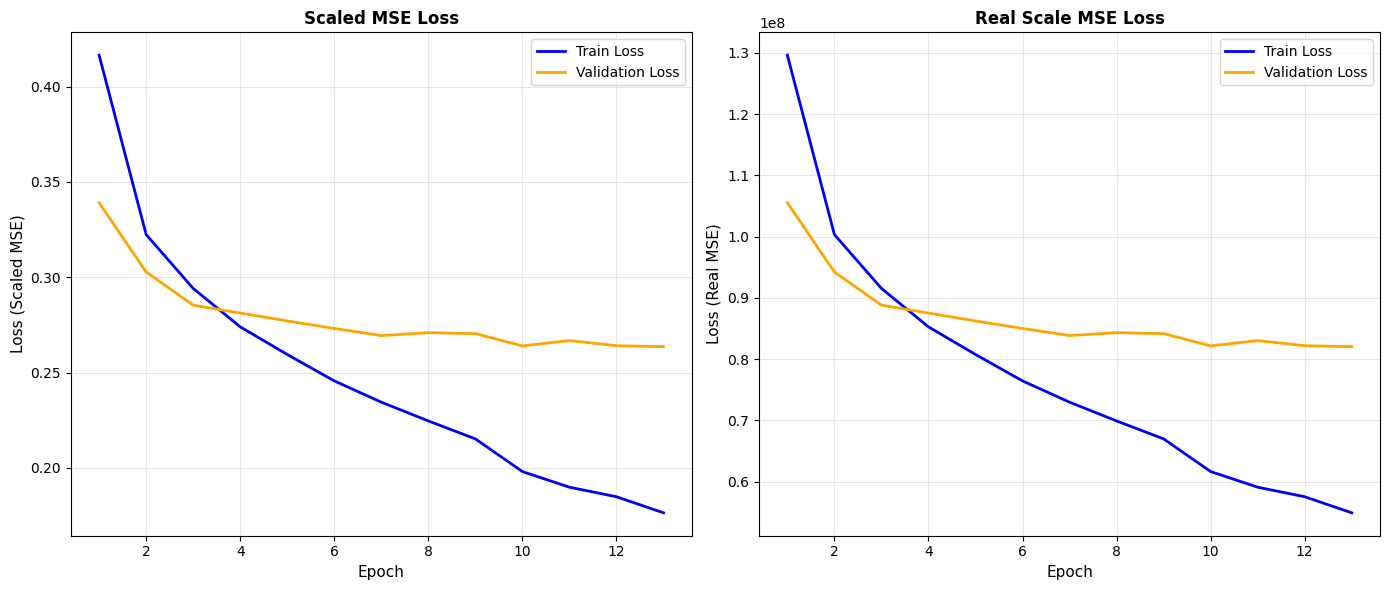

In [292]:
plot_losses_curves(history, "mse")

In [293]:
model_name = "selftaught_e256_mlen320_mf20_base_learn_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [294]:
all_models_results["SelfTaughtModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

## Word2Vec and other ready made embeddings

### Approach 1: Training own embeddings

#### Functions

##### Function to train Word2Vec model

In [ ]:
def train_word2vec_model(
    texts: list[str],
    vector_size: int = 256,
    window: int = 5,
    min_count: int = 20,
    sg: int = 1,  # 1=Skip-gram, 0=CBOW
    epochs: int = 10,
    logger: Optional[logging.Logger] = None,
) -> Word2Vec:
    """
    Train Word2Vec model on given corpus.

    Args:
        texts: list[str], List of text documents.
        vector_size: int, Dimensionality of word vectors, default is 256.
        window: int, Maximum distance between current and predicted word, default is 5.
        min_count: int, Ignores words with total frequency lower than this, default is 20.
        sg: int, Training algorithm: 1 for skip-gram; 0 for CBOW, default is 1.
        epochs: int, Number of iterations (epochs) over the corpus, default is 10.
        logger: Optional[logging.Logger], Optional logger for logging information.

    Returns:
        Word2Vec, Trained Word2Vec model.
    """
    # Tokenize texts
    tokenized = [word_tokenize(text.lower()) for text in texts]

    # Train Word2Vec
    w2v_model = Word2Vec(
        sentences=tokenized,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        epochs=epochs,
        workers=4,
    )

    if logger:
        logger.info(f"Word2Vec trained with {len(w2v_model.wv)} words")
    return w2v_model

In [ ]:
def build_vocab_from_w2v(
    w2v_model: Word2Vec, logger: Optional[logging.Logger] = None
) -> dict[str, int]:
    """Build vocabulary from Word2Vec model.
    Args:
        w2v_model: Word2Vec, Trained Word2Vec model.
        logger: Optional[logging.Logger], Optional logger for logging information.
    Returns:
        dict[str, int], Vocabulary mapping tokens to indices.
    """
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for idx, word in enumerate(w2v_model.wv.index_to_key, start=2):
        vocab[word] = idx
    if logger:
        logger.info(f"Vocabulary built from Word2Vec: {len(vocab)} words")
    return vocab

##### Function to encode text using Word2Vec embeddings with different methods

In [ ]:
def encode_text_with_w2v(
    text: str,
    w2v_model: Word2Vec,
    method: str = "mean",
    logger: Optional[logging.Logger] = None,
) -> np.ndarray:
    """
    Convert text to a fixed-size vector using Word2Vec.

    Args:
        text: str, Input text document.
        w2v_model: Word2Vec, Trained Word2Vec model.
        method: str, Aggregation method: 'mean', 'max', 'sum', or 'mean+max', default is 'mean'.
        logger: Optional[logging.Logger], Optional logger for logging information.
    Returns:
        np.ndarray, Fixed-size vector representation of the text.
    """
    tokens = word_tokenize(text.lower())

    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]

    if not vectors:
        if method == "mean+max":
            return np.zeros(2 * w2v_model.vector_size)
        return np.zeros(w2v_model.vector_size)

    vectors = np.array(vectors)

    if method == "mean":
        return np.mean(vectors, axis=0)
    elif method == "max":
        return np.max(vectors, axis=0)
    elif method == "mean+max":
        mean_vec = np.mean(vectors, axis=0)
        max_vec = np.max(vectors, axis=0)
        return np.concatenate([mean_vec, max_vec])  # Double the size
    elif method == "sum":
        return np.sum(vectors, axis=0)
    else:
        logger.error(f"Unknown aggregation method: {method}")
        raise ValueError("Method must be 'mean', 'max', 'sum', or 'mean+max'")

#### First idea - encode text and use as input (dataset)

First way: Encode text with Word2Vec and use as direct input (no embedding layer)

##### Dataset and model

In [ ]:
class PreEncodedDataset(Dataset):
    """Custom Dataset for pre-encoded text embeddings and categorical features."""

    def __init__(
        self, text_embeddings: np.ndarray, categorical: np.ndarray, targets: np.ndarray
    ) -> None:
        """Initializes the PreEncodedDataset.

        Args:
            text_embeddings: np.ndarray, Pre-encoded text embeddings.
            categorical: np.ndarray, Categorical features.
            targets: np.ndarray, Target values.
        """
        self.text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)
        self.categorical = torch.tensor(categorical, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.targets)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves a single sample by its index.

            Args:
                idx: int, The index of the sample to retrieve.
            Returns:
                tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                    - text_embeddings: torch.Tensor, The text embeddings.
                    - categorical: torch.Tensor, The categorical features.
                    - target: torch.Tensor, The target value.
        """
        return (self.text_embeddings[idx], self.categorical[idx], self.targets[idx])


In [ ]:
class PreEncodedModel(nn.Module):
    """
    Model for pre-encoded text embeddings combined with categorical features.
    It processes categorical features through a hidden layer, combines them with
    the pre-encoded text vectors, and predicts a continuous target variable.
    """

    def __init__(
        self,
        text_vector_dim: int,
        categorical_dim: int,
        cat_hidden_size: int = 128,
        reg_hidden_size: int = 256,
        dropout: float = 0.3,
    ) -> None:
        """
        Initializes the PreEncodedModel model.
            Args:
                text_vector_dim: int, Dimension of the pre-encoded text vectors.
                categorical_dim: int, Dimension of the categorical features.
                cat_hidden_size: int, Hidden layer size for categorical features processing, default 128.
                reg_hidden_size: int, Hidden layer size for regression layers, default 256.
                dropout: float, Dropout rate for regularization, default 0.3.
        """
        super(PreEncodedModel, self).__init__()

        # Process categorical features
        self.cat_layer = nn.Linear(categorical_dim, cat_hidden_size)
        self.batch_norm_cat = nn.BatchNorm1d(cat_hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        # Combine text vectors and categorical features
        combined_dim = text_vector_dim + cat_hidden_size

        self.regressor = nn.Sequential(
            nn.Linear(combined_dim, reg_hidden_size),
            nn.BatchNorm1d(reg_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(reg_hidden_size, reg_hidden_size // 2),
            nn.BatchNorm1d(reg_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(reg_hidden_size // 2, 1),
        )

    def forward(self, text_vectors, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.

        Args:
            text_vectors: torch.Tensor, Pre-encoded text embeddings.
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # No embedding needed

        # Process categorical features
        cat_feat = self.cat_layer(cat_features)
        cat_feat = self.batch_norm_cat(cat_feat)
        cat_feat = self.relu(cat_feat)
        cat_feat = self.dropout(cat_feat)

        # Concatenate pre-encoded text with categorical features
        combined = torch.cat((text_vectors, cat_feat), dim=1)

        return self.regressor(combined)


##### Prepare data

In [ ]:
# Load data
df = load_data(logger=logger)

# Split data
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# Combine Title and Description
X_train_combined = (X_train["Title"] + " " + X_train["FullDescription"]).tolist()
X_valid_combined = (X_valid["Title"] + " " + X_valid["FullDescription"]).tolist()
X_test_combined = (X_test["Title"] + " " + X_test["FullDescription"]).tolist()

# Prepare categorical and target
X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
    X_train, X_valid, X_test, y_train, logger=logger
)
y_train_processed, y_valid_processed, y_test_processed, target_scaler = (
    preprocess_target(y_train, y_valid, y_test, logger=logger)
)

# Train Word2Vec on training data
logger.info("Training Word2Vec model...")
w2v_model = train_word2vec_model(
    texts=X_train_combined,
    vector_size=256,  # Same as in the previous self-taught model
    window=5,
    min_count=20,  # Same as in the previous self-taught model
    sg=1,  # Skip-gram
    epochs=10,
)

logger.info(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Categorical features preprocessed successfully.
INFO - Target scaler saved to: preprocessors/target_scaler.pkl
INFO - Training Word2Vec model...
INFO - Word2Vec vocabulary size: 22925


In [301]:
logger.info("Encoding texts with Word2Vec...")
X_train_encoded = np.array(
    [encode_text_with_w2v(text, w2v_model, method="mean") for text in X_train_combined]
)
X_valid_encoded = np.array(
    [encode_text_with_w2v(text, w2v_model, method="mean") for text in X_valid_combined]
)
X_test_encoded = np.array(
    [encode_text_with_w2v(text, w2v_model, method="mean") for text in X_test_combined]
)

logger.info(f"Encoded text shape: {X_train_encoded.shape}")

INFO - Encoding texts with Word2Vec...
INFO - Encoded text shape: (195814, 256)


In [302]:
# Create datasets
train_dataset = PreEncodedDataset(X_train_encoded, X_train_cat, y_train_processed)
valid_dataset = PreEncodedDataset(X_valid_encoded, X_valid_cat, y_valid_processed)
test_dataset = PreEncodedDataset(X_test_encoded, X_test_cat, y_test_processed)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### Train the model

In [ ]:
# Initialize model
cat_hidden_size = 128
reg_hidden_size = 256
dropout_rate = 0.3
model = PreEncodedModel(
    text_vector_dim=X_train_encoded.shape[1],
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_rate,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

logger.info(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Train model
logger.info("Training model...")
model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
)

INFO - Model parameters: 137601
INFO - Training model...


INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4739, Real MSE: 147491441.51, Real RMSE: 12144.61
INFO -   Valid - MSE: 0.3948, Real MSE: 122851788.30, Real RMSE: 11083.85
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.394751
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3979, Real MSE: 123820466.30, Real RMSE: 11127.46
INFO -   Valid - MSE: 0.3655, Real MSE: 113736626.93, Real RMSE: 10664.74
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.029289 to 0.365462
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.3757, Real MSE: 116908311.02, Real RMSE: 10812.41
INFO -   Valid - MSE: 0.3465, Real MSE: 107839145.50, Re

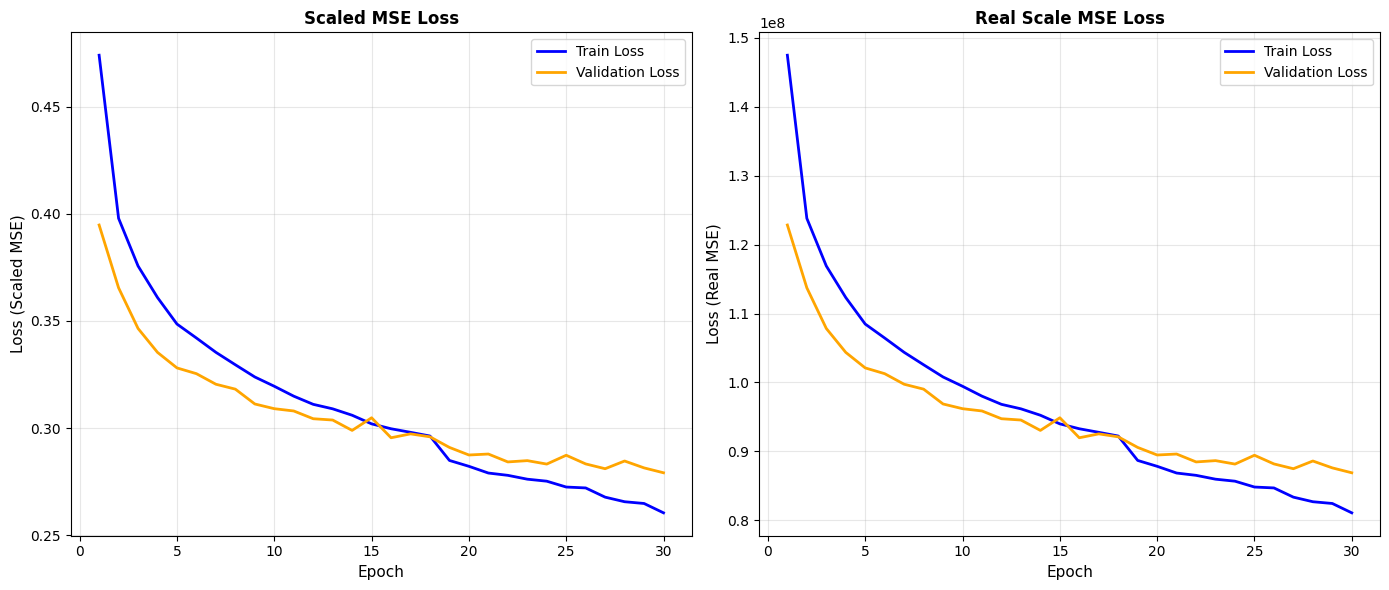

In [304]:
plot_losses_curves(history, "mse")

In [ ]:
model_name = "word2vec_e256_mlen320_mf20_base_pass_emb_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["Word2vecModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Second idea - include this matrix into the model (initialise the layer and make it not trainable)

##### Function to create embedding matrix from Word2Vec model


In [ ]:
def create_embedding_matrix_w2v(
    vocab: dict[str, int], w2v_model: Word2Vec, logger: Optional[logging.Logger] = None
) -> np.ndarray:
    """
    Create embedding matrix from Word2Vec for vocabulary.
    Words not in Word2Vec get small random values.
    Args:
        vocab: dict[str, int], Vocabulary mapping tokens to indices.
        w2v_model: Word2Vec, Trained Word2Vec model.
        logger: Optional[logging.Logger], Optional logger for logging information.
    Returns:
        np.ndarray, Embedding matrix.
    """

    vocab_size = len(vocab)
    embedding_dim = w2v_model.vector_size

    # Initialize with small random values
    embedding_matrix = np.random.uniform(-0.1, 0.1, (vocab_size, embedding_dim))

    # Set PAD to zeros
    embedding_matrix[vocab["<PAD>"]] = np.zeros(embedding_dim)

    # Fill with Word2Vec vectors
    found = 0
    for word, idx in vocab.items():
        if word in w2v_model.wv:
            embedding_matrix[idx] = w2v_model.wv[word]
            found += 1

    if logger:
        logger.info(
            f"Embedding matrix created: {found}/{vocab_size} words found in Word2Vec."
        )
    return embedding_matrix

##### Dataset and model

In [ ]:
class EmbeddingMatrixNN(nn.Module):
    """
    Neural Network model using a pre-trained embedding matrix combined with categorical features for regression.
    This model includes an embedding layer initialized with a given embedding matrix, processes categorical features through
    a fully connected layer, and combines both to predict a continuous target variable.
    """

    def __init__(
        self,
        embedding_matrix: np.ndarray,
        categorical_dim: int,
        cat_hidden_size=128,
        reg_hidden_size=256,
        dropout=0.3,
        requires_grad=False,
    ) -> None:
        """
        Initializes the EmbeddingMatrixNN model.

        Args:
            embedding_matrix: np.ndarray, Pre-trained embedding matrix.
            categorical_dim: int, Dimension of the categorical features.
            cat_hidden_size: int, Hidden layer size for categorical features processing, default 128.
            reg_hidden_size: int, Hidden layer size for regression layers, default 256.
            dropout: float, Dropout rate for regularization, default 0.3.
            requires_grad: bool, If True, allows fine-tuning of the embedding layer.
        """
        super(EmbeddingMatrixNN, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape

        # Frozen/Trainable embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            requires_grad=requires_grad,
        )

        # Layers for categorical features
        self.cat_layer = nn.Linear(categorical_dim, cat_hidden_size)
        self.batch_norm_cat = nn.BatchNorm1d(cat_hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        regressor_input_dim = embedding_dim + cat_hidden_size

        # Final regression layers
        self.regressor = nn.Sequential(
            nn.Linear(regressor_input_dim, reg_hidden_size),
            nn.BatchNorm1d(reg_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(reg_hidden_size, reg_hidden_size // 2),
            nn.BatchNorm1d(reg_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(reg_hidden_size // 2, 1),
        )

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.

        Args:
            text_seq: torch.Tensor, Input text sequences (token indices).
            cat_features: torch.Tensor, Input categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # Embed text and average word vectors
        text_emb = self.embedding(text_seq)
        text_mask = (
            (text_seq != 0).unsqueeze(-1).float()
        )  # Create mask for non-padding tokens
        text_feat = (text_emb * text_mask).sum(dim=1) / (
            text_mask.sum(dim=1) + 1e-9
        )  # Average only non-padding vectors

        # Process categorical features
        cat_feat = self.cat_layer(cat_features)
        cat_feat = self.batch_norm_cat(cat_feat)
        cat_feat = self.relu(cat_feat)
        cat_feat = self.dropout(cat_feat)

        # Concatenate all features
        combined = torch.cat((text_feat, cat_feat), dim=1)

        # Final regression layer
        output = self.regressor(combined)
        return output


##### Prepare data

In [ ]:
vocab = build_vocab_from_w2v(w2v_model)
logger.info(f"Vocab size for frozen embeddings: {len(vocab)}")

embedding_matrix = create_embedding_matrix_w2v(vocab, w2v_model, logger=logger)

INFO - Vocab size for frozen embeddings: 22927
INFO - Embedding matrix created: 22925/22927 words found in Word2Vec.


In [310]:
max_text_length = 320

X_train_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_train_combined
]
X_valid_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_valid_combined
]
X_test_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_test_combined
]

In [311]:
train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

##### Train the model

In [312]:
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3
model = EmbeddingMatrixNN(
    embedding_matrix,
    X_train_cat.shape[1],
    cat_hidden_size,
    reg_hidden_size,
    dropout_prob,
    requires_grad=False,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4728, Real MSE: 147141844.77, Real RMSE: 12130.20
INFO -   Valid - MSE: 0.3938, Real MSE: 122557308.05, Real RMSE: 11070.56
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.393805
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.4010, Real MSE: 124809365.55, Real RMSE: 11171.81
INFO -   Valid - MSE: 0.3655, Real MSE: 113759467.58, Real RMSE: 10665.81
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.028269 to 0.365535
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.3747, Real MSE: 116616629.51, Real RMSE: 10798.92
INFO -   Valid - MSE: 0.3421, Real MSE: 106466820.45, Re

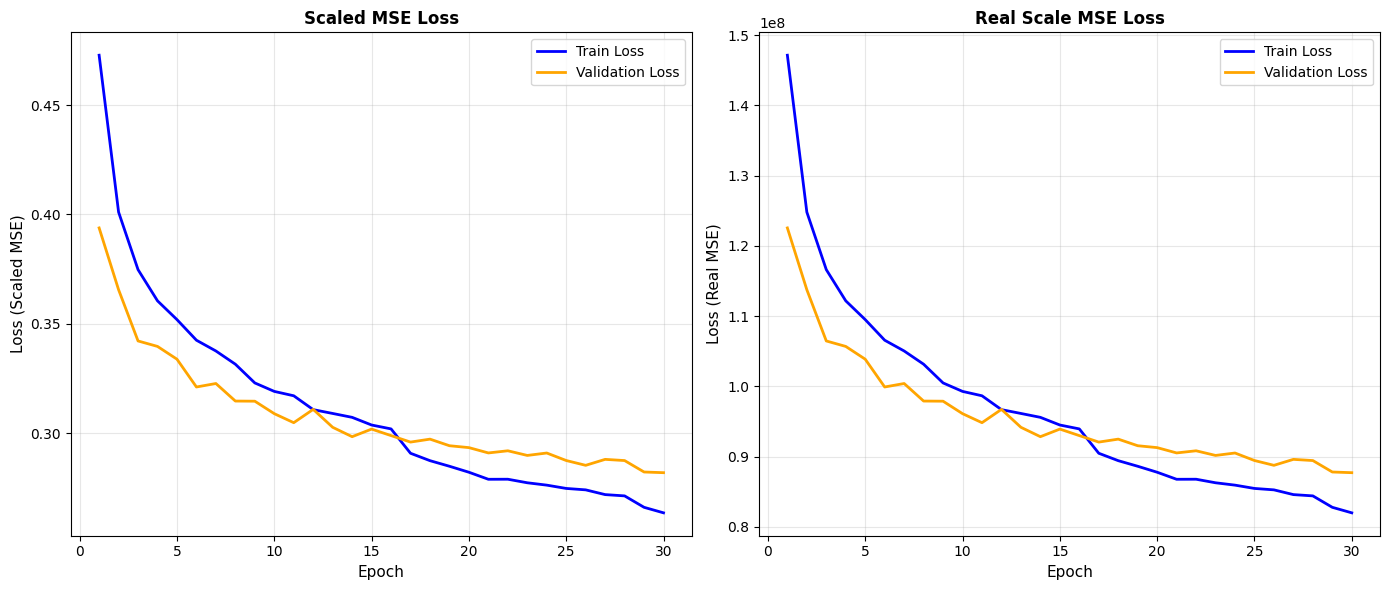

In [313]:
plot_losses_curves(history, "mse")

In [ ]:
model_name = "word2vec_e256_mlen320_mf20_base_froz_tok_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["Word2vecModelv2"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Third idea - start with second idea and then train embedding matrix

In [316]:
# We only need to set the layer to be trainable

cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3
model = EmbeddingMatrixNN(
    embedding_matrix,
    X_train_cat.shape[1],
    cat_hidden_size,
    reg_hidden_size,
    dropout_prob,
    requires_grad=True,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.3890, Real MSE: 121070195.38, Real RMSE: 11003.19
INFO -   Valid - MSE: 0.3092, Real MSE: 96237239.16, Real RMSE: 9810.06
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.309232
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3081, Real MSE: 95883727.77, Real RMSE: 9792.02
INFO -   Valid - MSE: 0.2878, Real MSE: 89568887.73, Real RMSE: 9464.08
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.021427 to 0.287805
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2776, Real MSE: 86382811.31, Real RMSE: 9294.24
INFO -   Valid - MSE: 0.2756, Real MSE: 85764203.31, Real RMSE: 

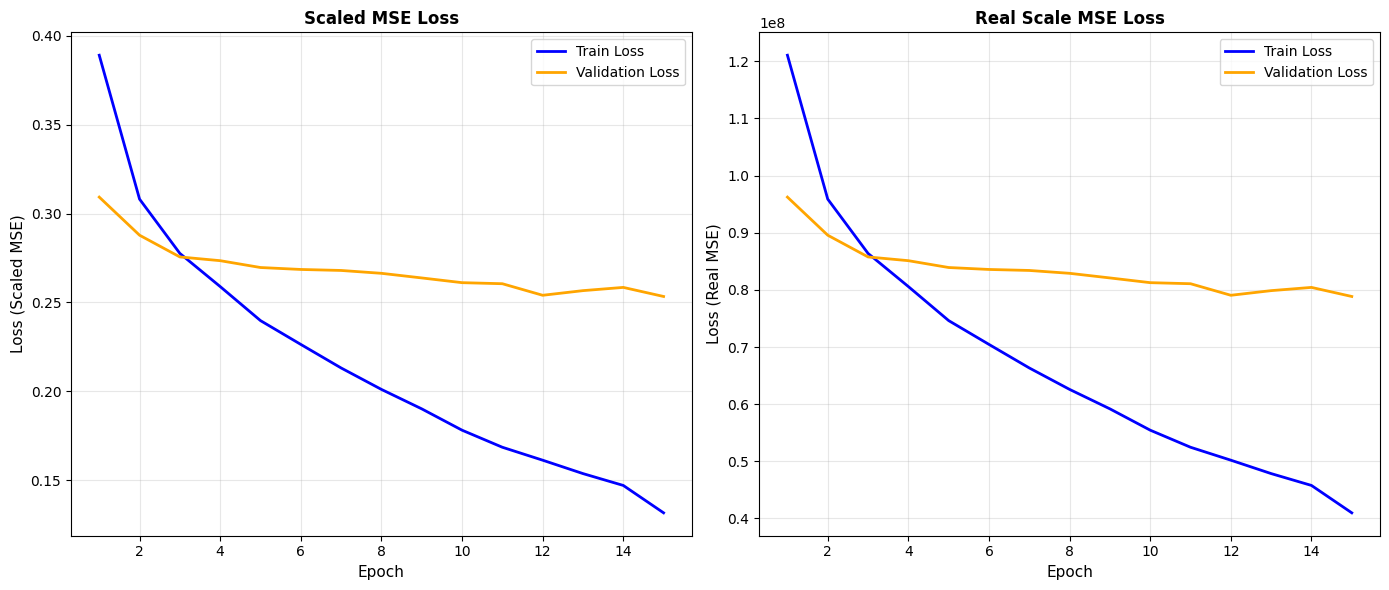

In [317]:
plot_losses_curves(history, "mse")

In [ ]:
model_name = "word2vec_e256_mlen320_mf20_base_unfroz_tok_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["Word2vecModelv3"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

The best model is better by 500 units for test RMSE than previous best model with tf-idf.

### Approach 2: Using pretrained embeddings

#### Functions

##### Function to load pretrained embeddings

In [ ]:
def load_pretrained_embeddings(
    model_name: str = "fasttext", logger: Optional[logging.Logger] = None
) -> object:
    """
    Load pre-trained embeddings.

    Args:
        model_name: str, The name of the pre-trained model to use ('word2vec', 'glove', or 'fasttext'), default is 'fasttext'.
        logger: Logger object for logging information

    Returns:
        object, Loaded embedding model
    """
    if logger:
        logger.info(f"Loading {model_name} pre-trained embeddings...")

    if model_name == "word2vec":
        # Google's Word2Vec (3M words, 300-dim)
        model = api.load("word2vec-google-news-300")

    elif model_name == "glove":
        # GloVe trained on Wikipedia (400K words, 100-dim)
        model = api.load("glove-wiki-gigaword-100")
        # For 300-dim: api.load('glove-wiki-gigaword-300')

    elif model_name == "fasttext":
        # FastText with subword info (1M words, 300-dim)
        model = api.load("fasttext-wiki-news-subwords-300")

    else:
        if logger:
            logger.error(f"Unknown model name: {model_name}")
        raise ValueError(f"Unknown model: {model_name}")

    if logger:
        logger.info(
            f"Loaded {len(model)} words with {model.vector_size}-dimensional vectors"
        )
    return model


##### Function to create embedding matrix from pretrained downloaded model

In [ ]:
def create_embedding_matrix_from_pretrained(
    vocab: Dict[str, int],
    premodel,
    embedding_dim: int = None,
    logger: Optional[logging.Logger] = None,
) -> np.ndarray:
    """
    Create embedding matrix from pre-trained model for your vocabulary.

    Args:
        vocab: Your vocabulary dictionary
        premodel: Pre-trained gensim model
        embedding_dim: Embedding dimension (auto-detected if None)

    Returns:
        Embedding matrix of shape (vocab_size, embedding_dim)
    """
    if embedding_dim is None:
        embedding_dim = premodel.vector_size

    vocab_size = len(vocab)

    # Initialize with small random values
    embedding_matrix = np.random.uniform(-0.1, 0.1, (vocab_size, embedding_dim))

    # Set PAD token to zeros
    embedding_matrix[vocab["<PAD>"]] = np.zeros(embedding_dim)

    # Fill with pre-trained vectors where available
    found = 0
    missing = []

    for word, idx in vocab.items():
        if word in ["<PAD>", "<UNK>"]:
            continue

        try:
            embedding_matrix[idx] = premodel[word]
            found += 1
        except KeyError:
            # Word not in pre-trained model - keep random initialization
            missing.append(word)

    coverage = (found / vocab_size) * 100
    if logger:
        logger.info(
            f"Embedding matrix created: {found}/{vocab_size} words found in pre-trained model."
        )
        logger.info(f"Coverage: {coverage:.1f}%")
        logger.info(f"Missing from pre-trained: {len(missing)} words")

    return embedding_matrix

##### Function to encode text using pretrained embeddings with different methods

In [ ]:
def encode_text_pretrained(text: str, model: object, method="mean") -> np.ndarray:
    """
    Encode text using pre-trained embeddings.

    Args:
        text: str, Input text
        model: object, Pre-trained embedding model (Word2Vec, GloVe, FastText)
        method: str, Aggregation method ('mean', 'max', 'sum', 'mean+max')

    Returns:
        np.ndarray, Fixed-size vector representing the text
    """
    tokens = word_tokenize(text.lower())

    # Get vectors for tokens in vocabulary
    vectors = []
    for token in tokens:
        try:
            vectors.append(model[token])
        except KeyError:
            # Token not in vocabulary - skip it
            continue

    if not vectors:
        if method == "mean+max":
            return np.zeros(2 * model.vector_size)
        return np.zeros(model.vector_size)

    vectors = np.array(vectors)

    if method == "mean":
        return np.mean(vectors, axis=0)
    elif method == "max":
        return np.max(vectors, axis=0)
    elif method == "mean+max":
        mean_vec = np.mean(vectors, axis=0)
        max_vec = np.max(vectors, axis=0)
        return np.concatenate([mean_vec, max_vec])  # Double the size
    elif method == "sum":
        return np.sum(vectors, axis=0)
    else:
        return np.mean(vectors, axis=0)

#### First idea

##### Prepare model and data

In [324]:
# Load model
embedding_model = load_pretrained_embeddings("fasttext", logger=logger)

embedding_dim = embedding_model.vector_size

INFO - Loading fasttext pre-trained embeddings...
INFO - Loaded 999999 words with 300-dimensional vectors


In [ ]:
# Load data
df = load_data()

# Data split
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df)

# Combine Title and Description
X_train_combined = (X_train["Title"] + " " + X_train["FullDescription"]).tolist()
X_valid_combined = (X_valid["Title"] + " " + X_valid["FullDescription"]).tolist()
X_test_combined = (X_test["Title"] + " " + X_test["FullDescription"]).tolist()

# Prepare categorical and targets
X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
    X_train, X_valid, X_test, y_train
)
y_train_processed, y_valid_processed, y_test_processed, target_scaler = (
    preprocess_target(y_train, y_valid, y_test)
)

In [326]:
X_train_encoded = np.array(
    [
        encode_text_pretrained(text, embedding_model, method="mean")
        for text in X_train_combined
    ]
)
X_valid_encoded = np.array(
    [
        encode_text_pretrained(text, embedding_model, method="mean")
        for text in X_valid_combined
    ]
)
X_test_encoded = np.array(
    [
        encode_text_pretrained(text, embedding_model, method="mean")
        for text in X_test_combined
    ]
)

logger.info(f"Encoded shape: {X_train_encoded.shape}")

INFO - Encoded shape: (195814, 300)


In [327]:
train_dataset = PreEncodedDataset(X_train_encoded, X_train_cat, y_train_processed)
valid_dataset = PreEncodedDataset(X_valid_encoded, X_valid_cat, y_valid_processed)
test_dataset = PreEncodedDataset(X_test_encoded, X_test_cat, y_test_processed)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### Train the model

In [ ]:
cat_hidden_size = 128
reg_hidden_size = 256
dropout_rate = 0.3
model = PreEncodedModel(
    text_vector_dim=embedding_dim,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_rate,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
)

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.5649, Real MSE: 175790111.29, Real RMSE: 13258.59
INFO -   Valid - MSE: 0.5009, Real MSE: 155897373.95, Real RMSE: 12485.89
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.500934
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.4819, Real MSE: 149976264.35, Real RMSE: 12246.48
INFO -   Valid - MSE: 0.4500, Real MSE: 140041355.79, Real RMSE: 11833.91
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.050949 to 0.449985
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.4499, Real MSE: 140011609.38, Real RMSE: 11832.65
INFO -   Valid - MSE: 0.4270, Real MSE: 132876501.35, Re

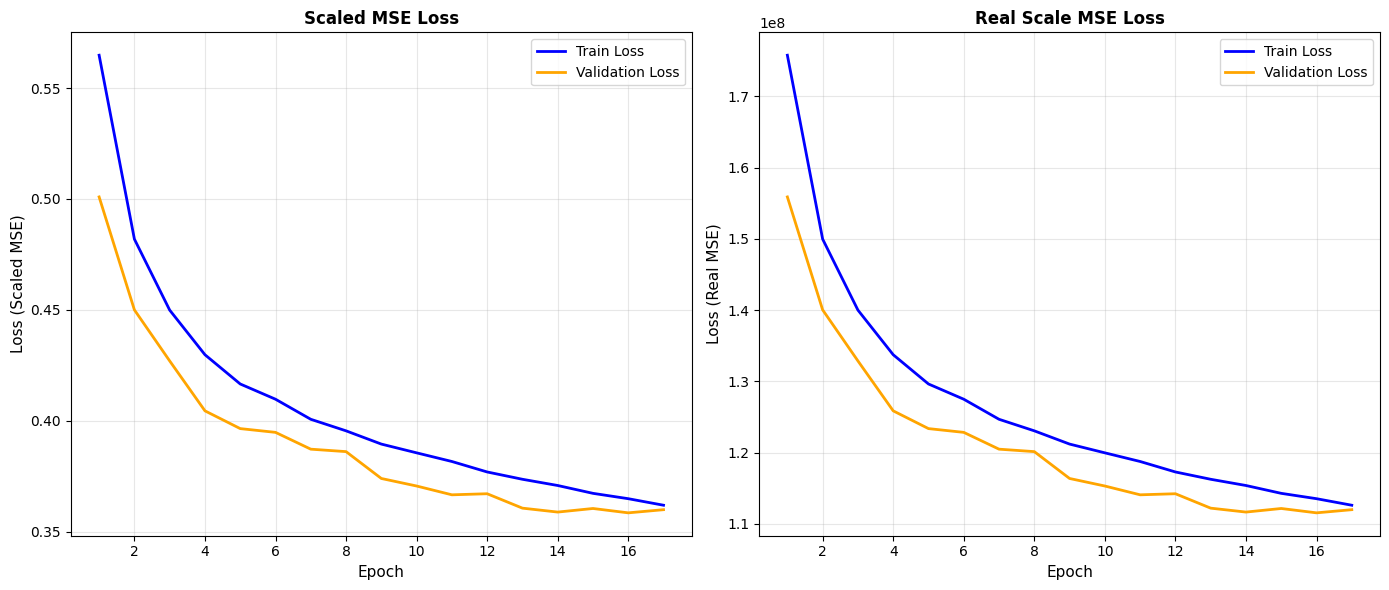

In [329]:
plot_losses_curves(history, "mse")

In [ ]:
model_name = "fasttext_e300_mlen320_mf20_base_pass_emb_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["FastTextModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Second idea

In [332]:
vocab = build_vocab(X_train_combined, min_freq=20)

embedding_size = embedding_model.vector_size
embedding_matrix = create_embedding_matrix_from_pretrained(
    vocab, embedding_model, embedding_dim=embedding_size
)

In [333]:
train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

In [334]:
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3
model = EmbeddingMatrixNN(
    embedding_matrix,
    X_train_cat.shape[1],
    cat_hidden_size,
    reg_hidden_size,
    dropout_prob,
    requires_grad=False,
).to(device)
loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.5835, Real MSE: 181606988.21, Real RMSE: 13476.16
INFO -   Valid - MSE: 0.5673, Real MSE: 176538926.61, Real RMSE: 13286.80
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.567260
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.5372, Real MSE: 167191778.69, Real RMSE: 12930.27
INFO -   Valid - MSE: 0.5177, Real MSE: 161113624.73, Real RMSE: 12693.05
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.049565 to 0.517695
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.5067, Real MSE: 157688681.27, Real RMSE: 12557.42
INFO -   Valid - MSE: 0.4927, Real MSE: 153324655.09, Re

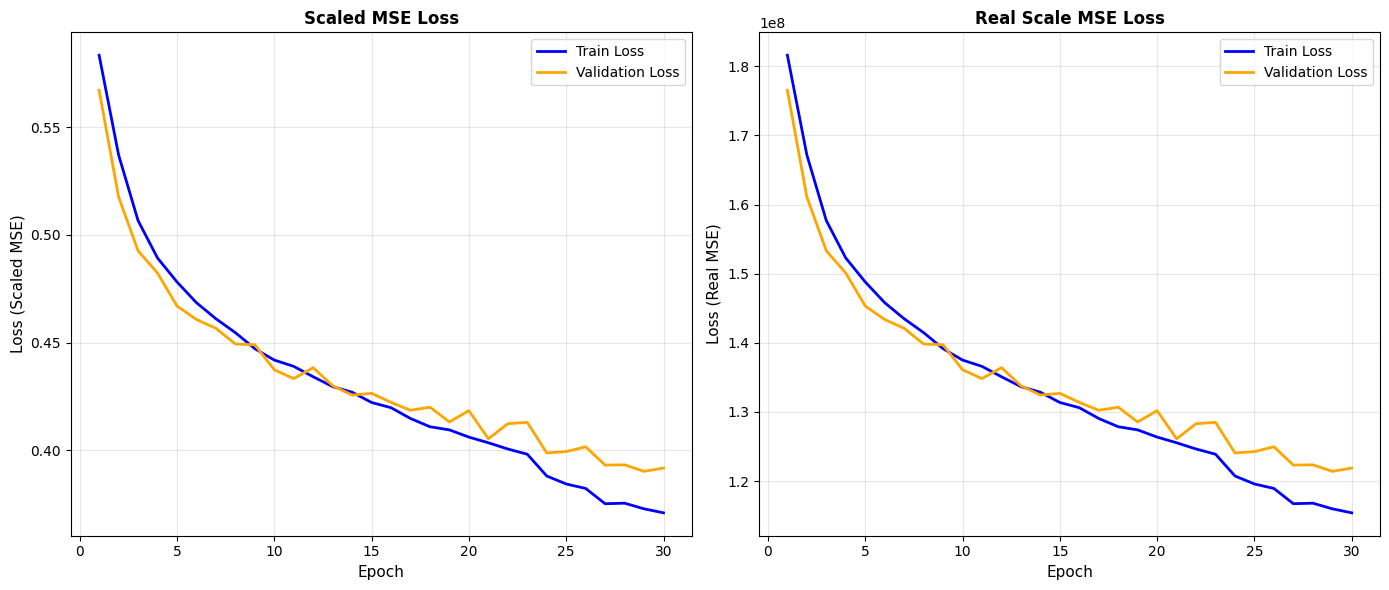

In [335]:
plot_losses_curves(history, "mse")

In [ ]:
model_name = "fasttext_e300_mlen320_mf20_base_froz_tok_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["FastTextModelv2"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Third idea

In [338]:
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3
model = EmbeddingMatrixNN(
    embedding_matrix,
    X_train_cat.shape[1],
    cat_hidden_size,
    reg_hidden_size,
    dropout_prob,
    requires_grad=True,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.3815, Real MSE: 118735136.23, Real RMSE: 10896.57
INFO -   Valid - MSE: 0.3196, Real MSE: 99449880.31, Real RMSE: 9972.46
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.319555
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3055, Real MSE: 95061424.01, Real RMSE: 9749.94
INFO -   Valid - MSE: 0.2948, Real MSE: 91737975.52, Real RMSE: 9577.99
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.024780 to 0.294775
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2827, Real MSE: 87994873.37, Real RMSE: 9380.56
INFO -   Valid - MSE: 0.3034, Real MSE: 94424235.15, Real RMSE: 

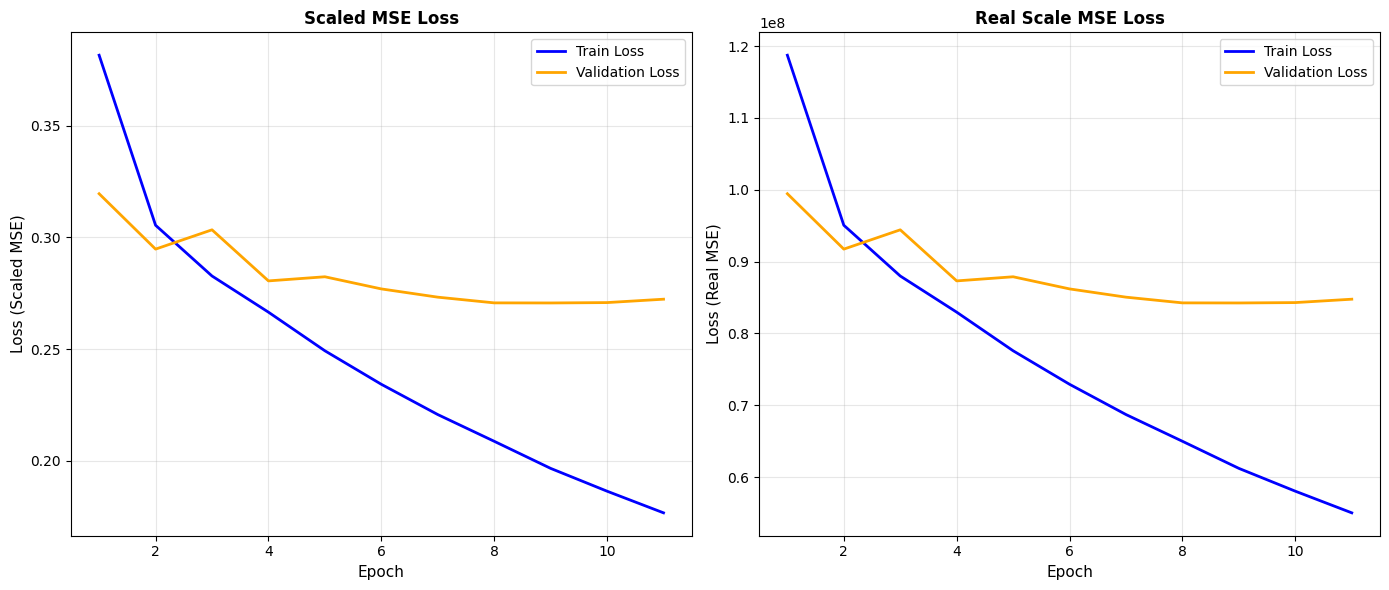

In [339]:
plot_losses_curves(history, "mse")

In [ ]:
model_name = "fasttext_e300_mlen320_mf20_base_unfroz_tok_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["FastTextModelv3"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

## Hyperparameter tuning 

**Try with:**
- Initial cleaning of text data
- Different embedding dimensions - 128, 300
- Min frequency for vocabulary - smaller or larger
- New more complex models with different layers
- Hidden units
- Sequence length
- Mean-max pooling instead of just mean

### Hyperparameter Tuning for self-taught embeddings

In [342]:
# Dictionary to store results
modified_selftaught_results = {}

#### Self-taught embeddings with initial cleaning (including removing stop words)

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Categorical features preprocessed successfully.
INFO - Target scaler saved to: preprocessors/target_scaler.pkl
INFO - Vocab size: 21995
INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4106, Real MSE: 127787102.69, Real RMSE: 11304.30
INFO -   Valid - MSE: 0.3276, Real MSE: 101950062.60, Real RMSE: 10097.03
INFO -   Learning Rate: 0.001000
INFO - Initial validation los

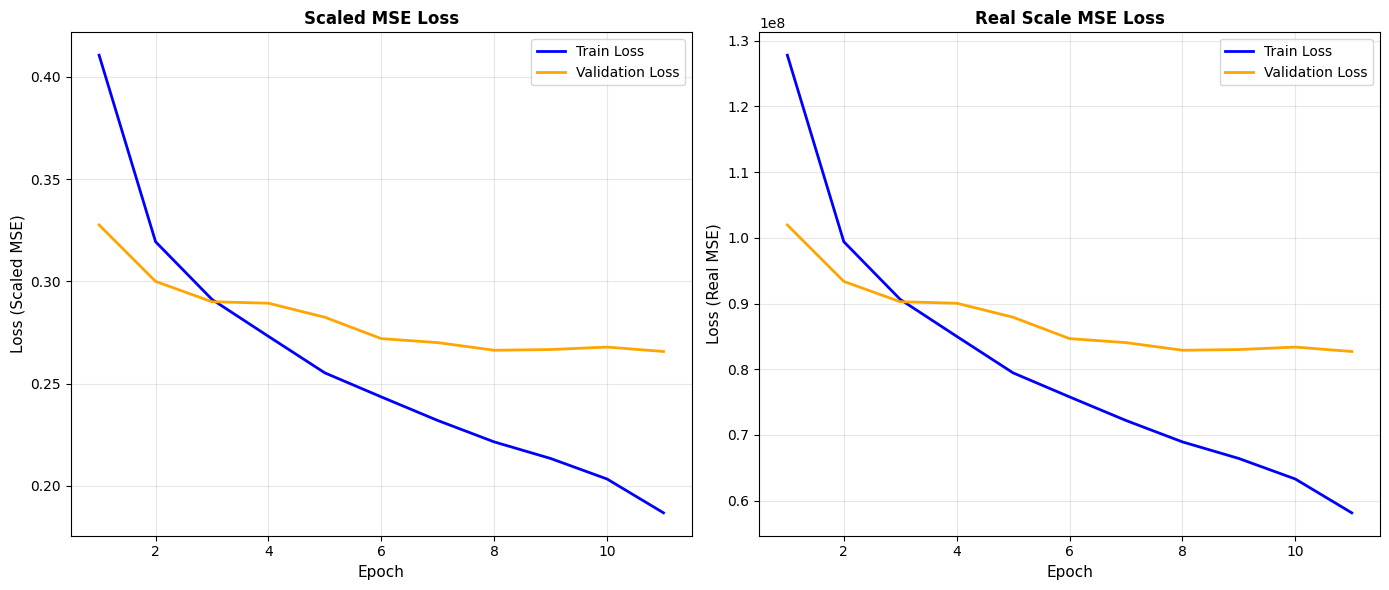

In [ ]:
df = load_data(logger=logger)

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
    X_train, X_valid, X_test, y_train, logger=logger
)
y_train_processed, y_valid_processed, y_test_processed, target_scaler = (
    preprocess_target(y_train, y_valid, y_test, logger=logger)
)

vocab_cleaned = build_vocab(
    X_train_combined,
    min_freq=20,
    clean_tokens_use=True,
    clean_tokens_config={"remove_stopwords": True},
)
logger.info(f"Vocab size: {len(vocab_cleaned)}")

max_text_length = 320
X_train_seq_cleaned = [
    text_to_sequence(
        text, vocab_cleaned, max_length=max_text_length, clean_tokens_use=True
    )
    for text in X_train_combined
]
X_valid_seq_cleaned = [
    text_to_sequence(
        text, vocab_cleaned, max_length=max_text_length, clean_tokens_use=True
    )
    for text in X_valid_combined
]
X_test_seq_cleaned = [
    text_to_sequence(
        text, vocab_cleaned, max_length=max_text_length, clean_tokens_use=True
    )
    for text in X_test_combined
]

train_dataset = TokensDataset(X_train_seq_cleaned, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq_cleaned, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq_cleaned, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab_cleaned),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e256_mlen320_mf20_base_learn_chid128_rhid256_dr30_lrs_cleaned"
torch.save(model.dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelv2"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Self-taught embeddings with embedding dimension 300

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4126, Real MSE: 128407979.58, Real RMSE: 11331.72
INFO -   Valid - MSE: 0.3250, Real MSE: 101159276.06, Real RMSE: 10057.80
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.325048
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3231, Real MSE: 100566104.76, Real RMSE: 10028.27
INFO -   Valid - MSE: 0.2994, Real MSE: 93162861.33, Real RMSE: 9652.09
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.025694 to 0.299354
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2930, Real MSE: 91170067.87, Real RMSE: 9548.30
INFO -   Valid - MSE: 0.2929, Real MSE: 91169971.24, Real RM

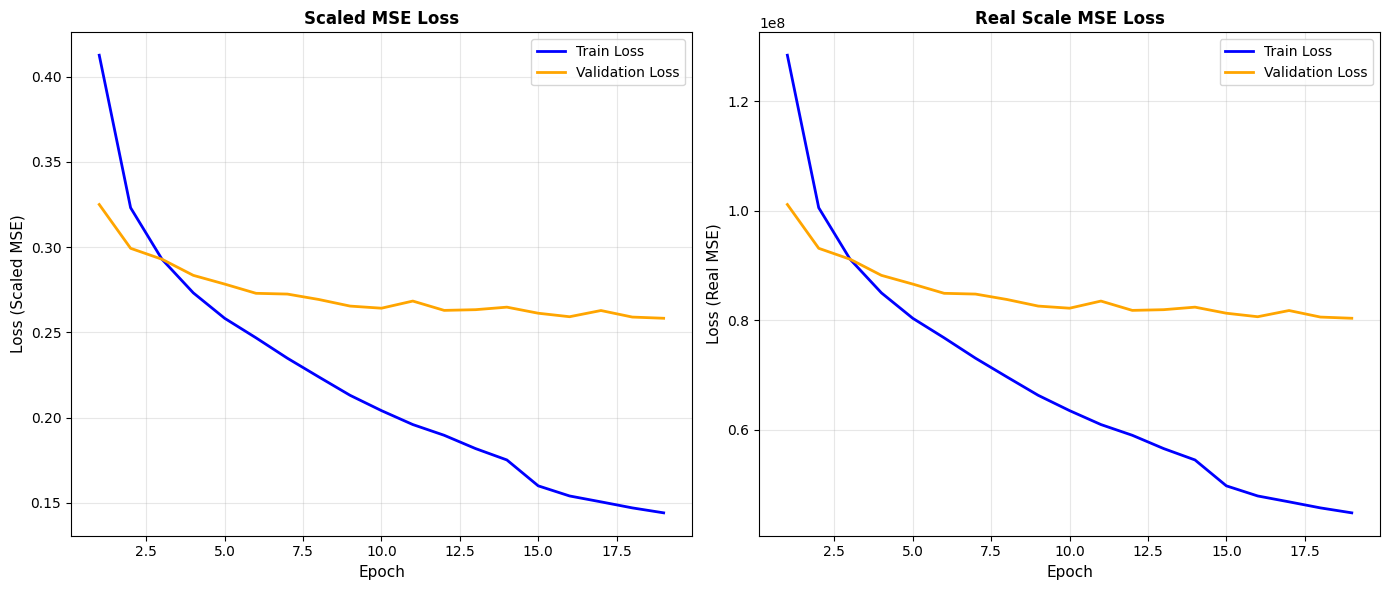

In [ ]:
train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 300
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e300_mlen320_mf20_base_learn_chid128_rhid256_dr30_lrs"
torch.save(models.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelv3"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Self-taught embeddings with embedding dimension 128

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4324, Real MSE: 134553740.40, Real RMSE: 11599.73
INFO -   Valid - MSE: 0.3369, Real MSE: 104848001.40, Real RMSE: 10239.53
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.336901
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3322, Real MSE: 103382537.21, Real RMSE: 10167.72
INFO -   Valid - MSE: 0.3093, Real MSE: 96266140.85, Real RMSE: 9811.53
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.027575 to 0.309325
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.3040, Real MSE: 94611443.26, Real RMSE: 9726.84
INFO -   Valid - MSE: 0.2932, Real MSE: 91253312.64, Real RM

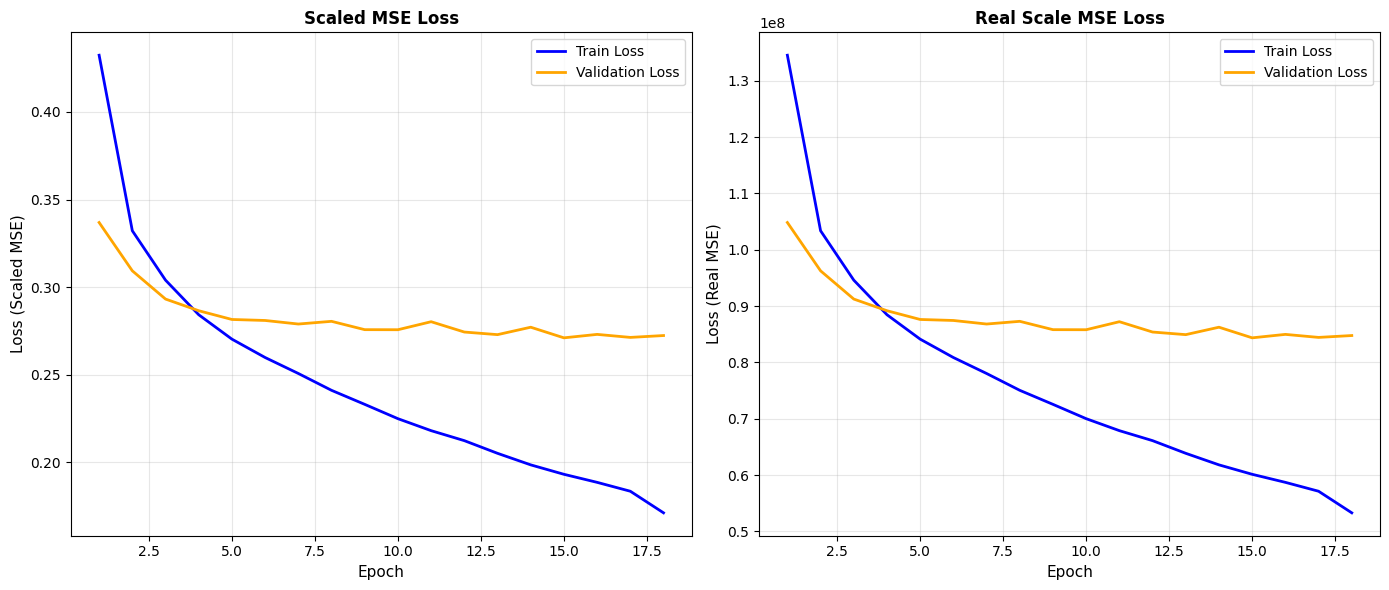

In [ ]:
train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 128
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e128_mlen320_mf20_base_learn_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelv4"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Larger vocabulary with min frequency 15

INFO - Vocab size: 26763
INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4314, Real MSE: 134260615.98, Real RMSE: 11587.09
INFO -   Valid - MSE: 0.3326, Real MSE: 103519601.85, Real RMSE: 10174.46
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.332632
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3332, Real MSE: 103692026.91, Real RMSE: 10182.93
INFO -   Valid - MSE: 0.3087, Real MSE: 96057918.29, Real RMSE: 9800.91
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.023976 to 0.308656
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.3053, Real MSE: 95027988.71, Real RMSE: 9748.23
INFO -   Valid - MSE: 0.2939, Real 

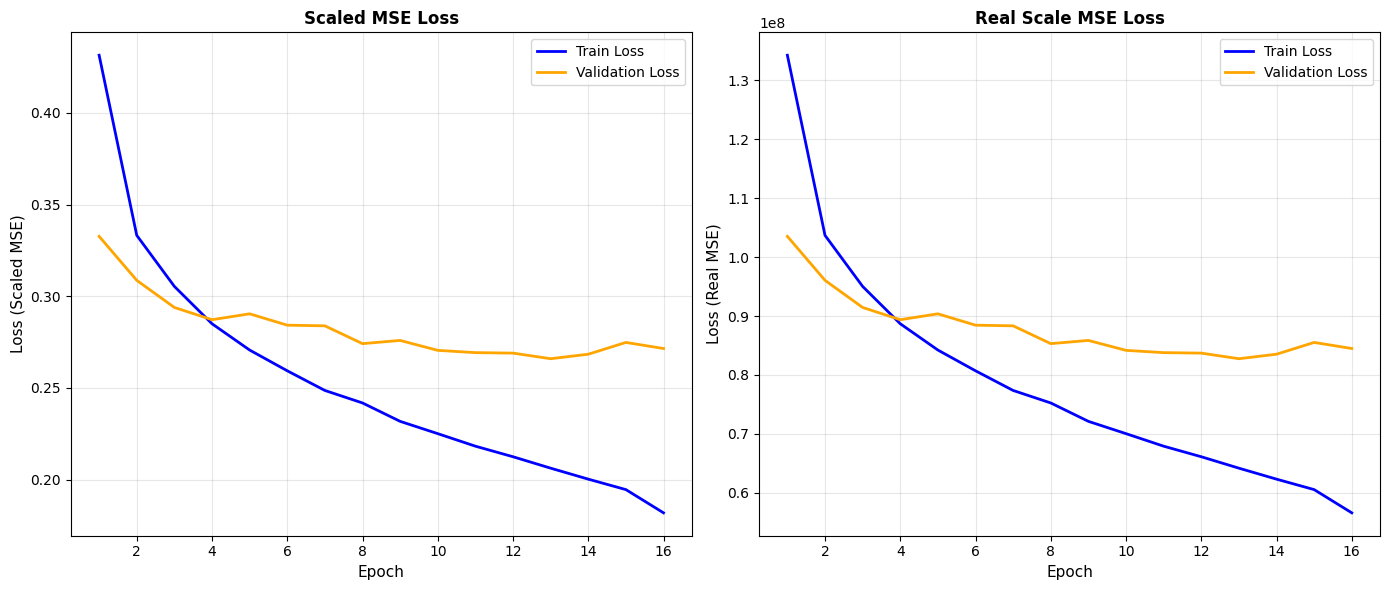

In [ ]:
vocab_min_15 = build_vocab(X_train_combined, min_freq=15, clean_tokens_use=False)
logger.info(f"Vocab size: {len(vocab_min_15)}")

max_text_length = 320
X_train_seq_min15 = [
    text_to_sequence(
        text, vocab_min_15, max_length=max_text_length, clean_tokens_use=False
    )
    for text in X_train_combined
]
X_valid_seq_min15 = [
    text_to_sequence(
        text, vocab_min_15, max_length=max_text_length, clean_tokens_use=False
    )
    for text in X_valid_combined
]
X_test_seq_min15 = [
    text_to_sequence(
        text, vocab_min_15, max_length=max_text_length, clean_tokens_use=False
    )
    for text in X_test_combined
]

train_dataset = TokensDataset(X_train_seq_min15, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq_min15, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq_min15, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 128
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab_min_15),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e300_mlen320_mf15_base_learn_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelv5"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Smaller max sequence length - 250

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4171, Real MSE: 129812163.92, Real RMSE: 11393.51
INFO -   Valid - MSE: 0.3338, Real MSE: 103885090.43, Real RMSE: 10192.40
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.333807
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3224, Real MSE: 100326483.59, Real RMSE: 10016.31
INFO -   Valid - MSE: 0.3054, Real MSE: 95058018.58, Real RMSE: 9749.77
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.028363 to 0.305443
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2959, Real MSE: 92081118.22, Real RMSE: 9595.89
INFO -   Valid - MSE: 0.2936, Real MSE: 91365838.78, Real RM

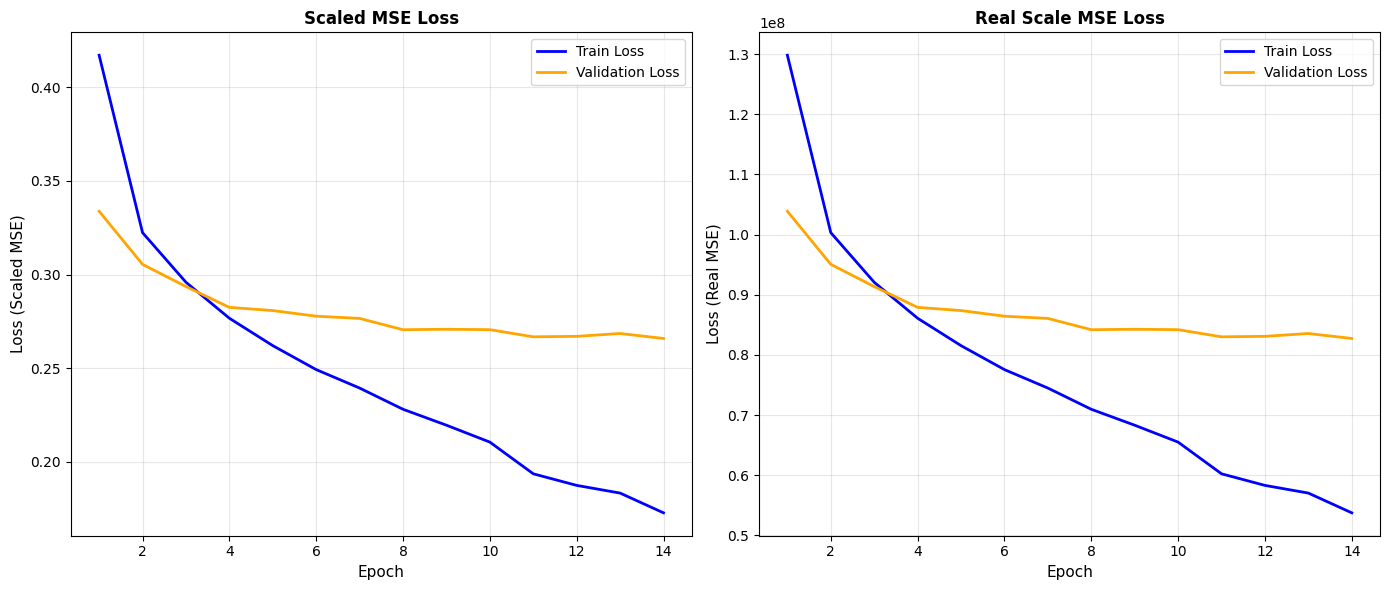

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20, clean_tokens_use=False)
# logger.info(f"Vocab size: {len(vocab)}")

max_text_length = 250
X_train_seq_maxlen_250 = [
    text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
    for text in X_train_combined
]
X_valid_seq_maxlen_250 = [
    text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
    for text in X_valid_combined
]
X_test_seq_maxlen_250 = [
    text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
    for text in X_test_combined
]

train_dataset = TokensDataset(X_train_seq_maxlen_250, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq_maxlen_250, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq_maxlen_250, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e256_mlen250_mf20_base_learn_chid128_rhid256_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelv6"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Compare results

**Summary of hyperparameter tuning for self-taught embeddings:**

- bigger embedding dimension (300) gives better results
- larger vocabulary (min freq 15) does not improve results
- smaller max sequence length (250) does not improve results

## Mitigating overfitting

Before we start to try with different hyperparameters for word2vec and fasttext embeddings, we need to find a way to mitigate overfitting. We want to keep good performance on the validation set while reducing overfitting on the training set. We may try:
- higher dropout rate
- less neurons
- more strict early stopping
- bigger size of vocabulary
- experiment with learning rate

#### Increase dropout rate to 0.45

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4401, Real MSE: 136952638.16, Real RMSE: 11702.68
INFO -   Valid - MSE: 0.3432, Real MSE: 106805782.27, Real RMSE: 10334.69
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.343191
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3396, Real MSE: 105686415.40, Real RMSE: 10280.39
INFO -   Valid - MSE: 0.3054, Real MSE: 95049232.61, Real RMSE: 9749.32
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.037776 to 0.305415
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.3103, Real MSE: 96570971.66, Real RMSE: 9827.05
INFO -   Valid - MSE: 0.2990, Real MSE: 93044905.90, Real RM

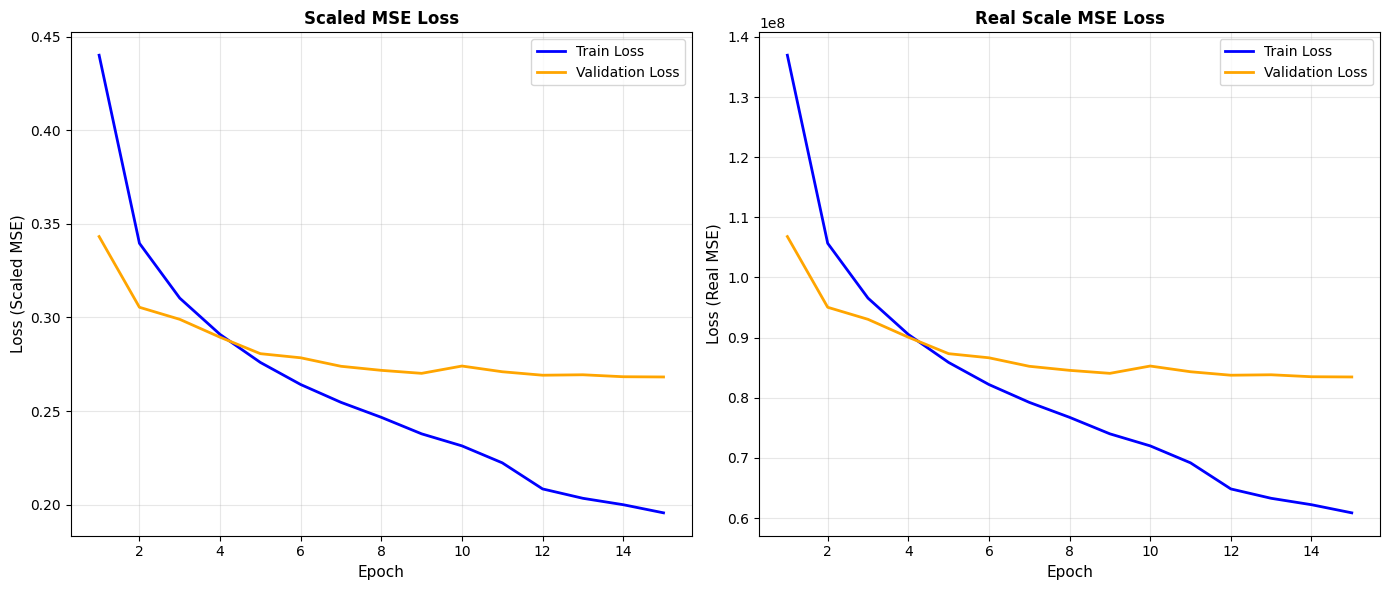

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20, clean_tokens_use=False)
# logger.info(f"Vocab size: {len(vocab)}")

# max_text_length = 320
# X_train_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#               for text in X_test_combined]

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.45

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e300_mlen320_mf20_base_learn_chid128_rhid256_dr45_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelOverfittingMitigationv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

The gap is smaller, but performance on validation is worse than in baseline.

#### Decrease number of neurons in hidden layers

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4242, Real MSE: 132002030.78, Real RMSE: 11489.21
INFO -   Valid - MSE: 0.3337, Real MSE: 103860811.04, Real RMSE: 10191.21
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.333729
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3295, Real MSE: 102535799.36, Real RMSE: 10126.00
INFO -   Valid - MSE: 0.3039, Real MSE: 94568428.52, Real RMSE: 9724.63
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.029859 to 0.303870
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.3021, Real MSE: 94030137.03, Real RMSE: 9696.91
INFO -   Valid - MSE: 0.2946, Real MSE: 91686357.67, Real RM

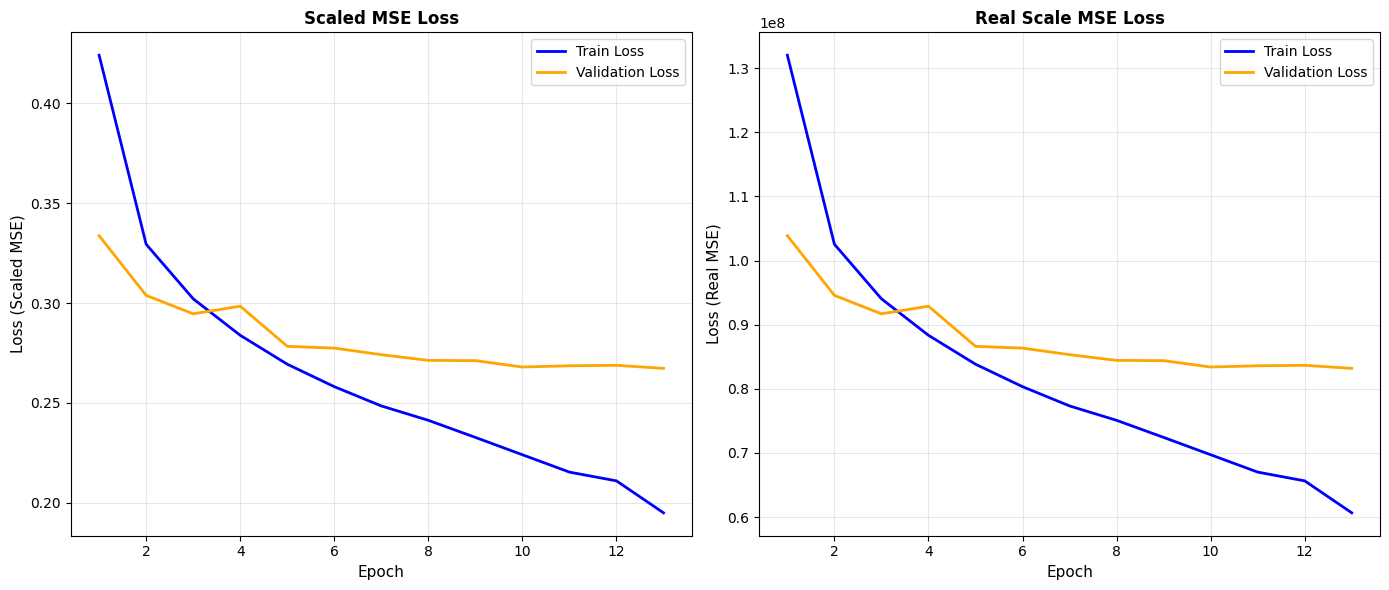

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20, clean_tokens_use=False)
# logger.info(f"Vocab size: {len(vocab)}")

# max_text_length = 320
# X_train_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#               for text in X_test_combined]

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128 // 2
reg_hidden_size = 256 // 2
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

Smaller gap but worse performance on validation.

In [ ]:
model_name = "selftaught_e256_mlen320_mf20_base_learn_chid64_rhid128_dr30_lrs"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelOverfittingMitigationv2"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Start with larger learning rate = 0.01 and use learning rate scheduler to reduce it by factor 0.1 each time (patience=0) validation loss does not improve

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.01
INFO - Learning rate scheduler with patience 0 and factor 0.1 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.3781, Real MSE: 117674328.92, Real RMSE: 10847.78
INFO -   Valid - MSE: 0.3396, Real MSE: 105674791.73, Real RMSE: 10279.82
INFO -   Learning Rate: 0.010000
INFO - Initial validation loss: 0.339557
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3070, Real MSE: 95553845.18, Real RMSE: 9775.16
INFO -   Valid - MSE: 0.2895, Real MSE: 90098777.19, Real RMSE: 9492.04
INFO -   Learning Rate: 0.010000
INFO - Validation loss improved by 0.050049 to 0.289508
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2751, Real MSE: 85605206.45, Real RMSE: 9252.31
INFO -   Valid - MSE: 0.2789, Real MSE: 86803368.76, Real RMSE:

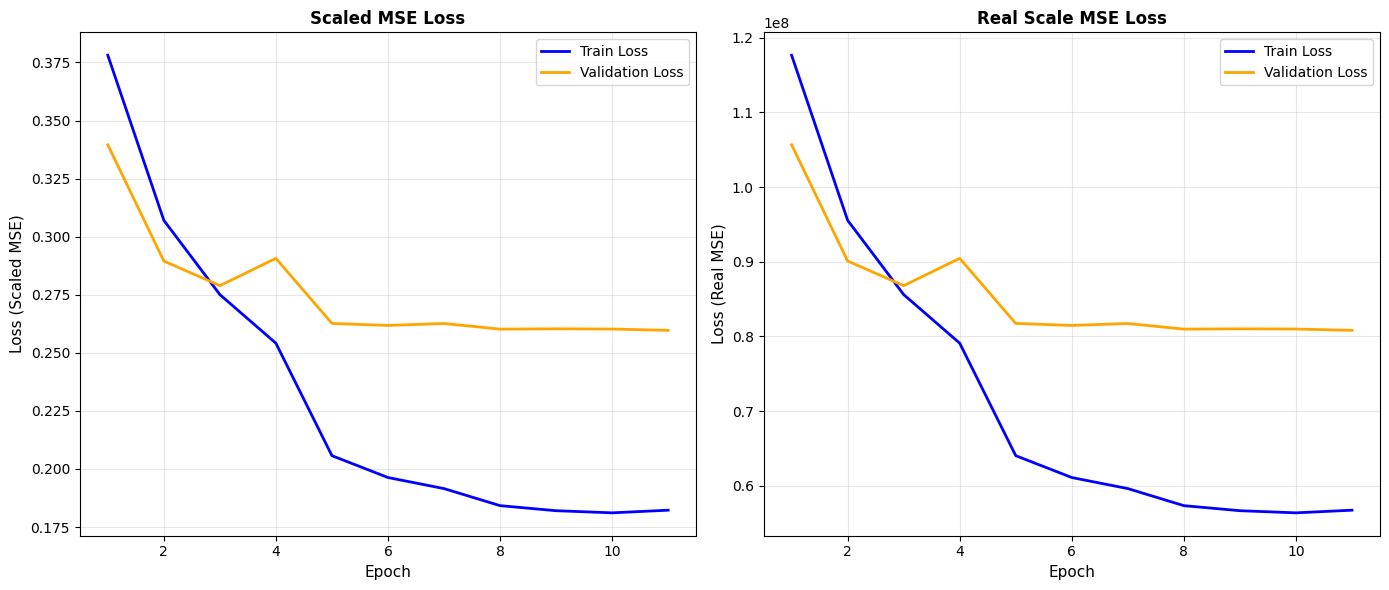

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20, clean_tokens_use=False)
# logger.info(f"Vocab size: {len(vocab)}")

# max_text_length = 320
# X_train_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#               for text in X_test_combined]

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001 * 10
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5 / 5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = (
    "selftaught_e256_mlen320_mf20_base_learn_chid64_rhid128_dr30_lrs_01_0_lr_001"
)
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelOverfittingMitigationv3"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

We can see that it makes sense to use larger learning rate at start, let's say for first 3 epochs, and then reduce it to 0.001 for the rest of training. It performed similar to baseline but the gap is significant.

#### Bigger vocabulary with min frequency 10

INFO - Vocab size: 33827
INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 1 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4174, Real MSE: 129907843.10, Real RMSE: 11397.71
INFO -   Valid - MSE: 0.3297, Real MSE: 102597414.65, Real RMSE: 10129.04
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.329669
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3248, Real MSE: 101076557.02, Real RMSE: 10053.68
INFO -   Valid - MSE: 0.3054, Real MSE: 95054828.23, Real RMSE: 9749.61
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.024236 to 0.305433
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2960, Real MSE: 92134317.22, Real RMSE: 9598.66
INFO -   Valid - MSE: 0.2889, Real 

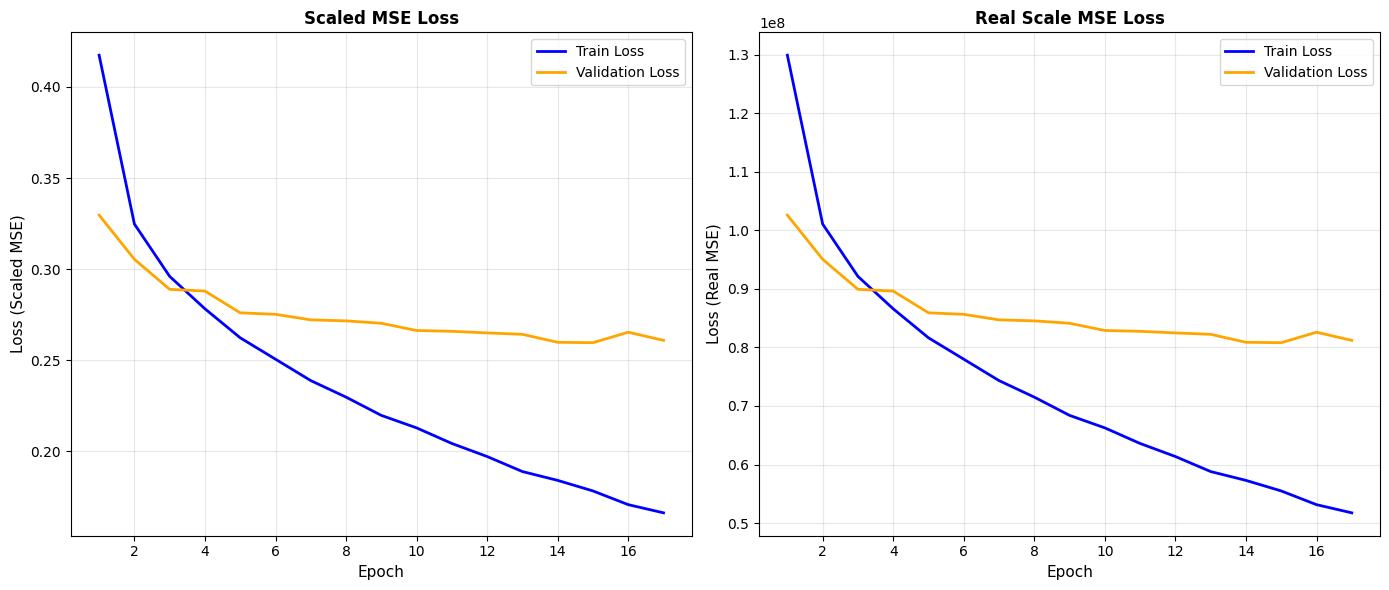

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

min_vocab_freq = 10

vocab_min_10 = build_vocab(
    X_train_combined, min_freq=min_vocab_freq, clean_tokens_use=False
)
logger.info(f"Vocab size: {len(vocab_min_10)}")

max_text_length = 320
X_train_seq_min_10 = [
    text_to_sequence(
        text, vocab_min_10, max_length=max_text_length, clean_tokens_use=False
    )
    for text in X_train_combined
]
X_valid_seq_min_10 = [
    text_to_sequence(
        text, vocab_min_10, max_length=max_text_length, clean_tokens_use=False
    )
    for text in X_valid_combined
]
X_test_seq_min_10 = [
    text_to_sequence(
        text, vocab_min_10, max_length=max_text_length, clean_tokens_use=False
    )
    for text in X_test_combined
]

train_dataset = TokensDataset(X_train_seq_min_10, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq_min_10, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq_min_10, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.3

model = SelfTaughtNN(
    vocab_size=len(vocab_min_10),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=1,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e256_mlen320_mf10_base_learn_chid64_rhid128_dr30"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelOverfittingMitigationv4"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### More strict early stopping with patience=2, dropout=0.4, hidden sizes as in baseline, min_freq=10 and learning rate 0.005 at the start

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.005
INFO - Learning rate scheduler with patience 0 and factor 0.25 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.3903, Real MSE: 121476638.79, Real RMSE: 11021.64
INFO -   Valid - MSE: 0.3144, Real MSE: 97840144.11, Real RMSE: 9891.42
INFO -   Learning Rate: 0.005000
INFO - Initial validation loss: 0.314383
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3138, Real MSE: 97660131.01, Real RMSE: 9882.31
INFO -   Valid - MSE: 0.2991, Real MSE: 93068741.46, Real RMSE: 9647.21
INFO -   Learning Rate: 0.005000
INFO - Validation loss improved by 0.015332 to 0.299051
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2860, Real MSE: 88999733.14, Real RMSE: 9433.97
INFO -   Valid - MSE: 0.2872, Real MSE: 89392041.06, Real RMSE:

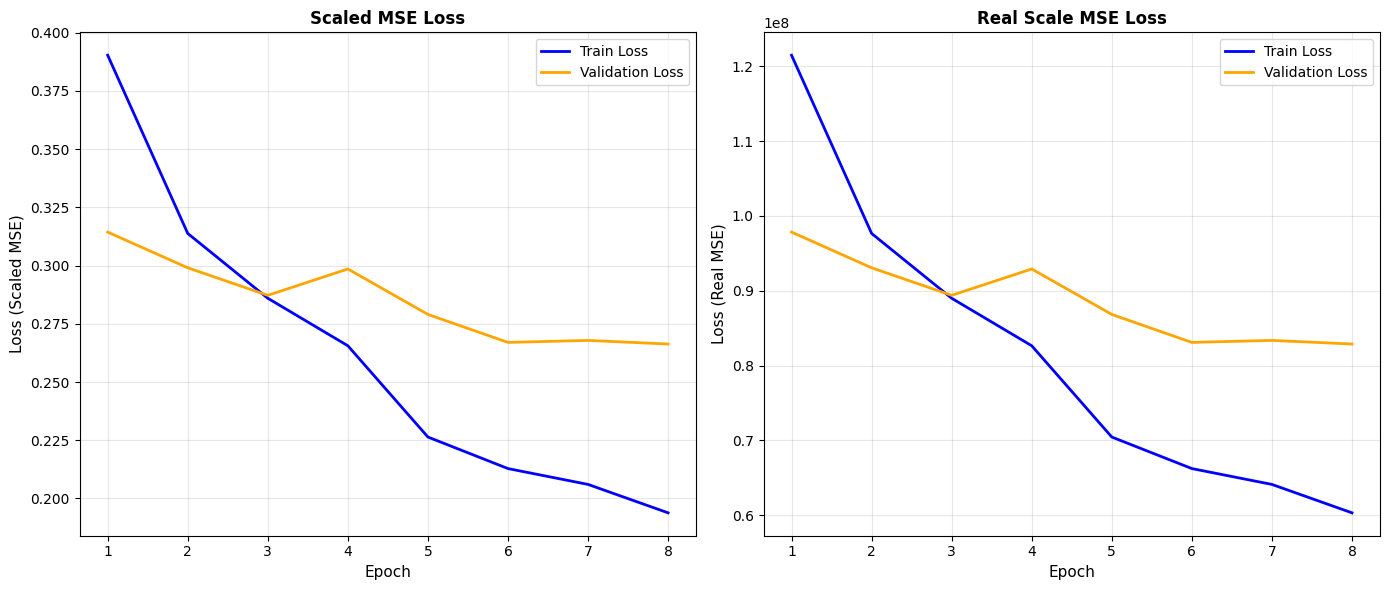

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# min_vocab_freq = 10

# vocab_min_10 = build_vocab(X_train_combined, min_freq=min_vocab_freq, clean_tokens_use=False)
# logger.info(f"Vocab size: {len(vocab_min_10)}")

# max_text_length = 320
# X_train_seq_min_10 = [text_to_sequence(text, vocab_min_10, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_train_combined]
# X_valid_seq_min_10 = [text_to_sequence(text, vocab_min_10, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_valid_combined]
# X_test_seq_min_10 = [text_to_sequence(text, vocab_min_10, max_length=max_text_length, clean_tokens_use=False)
#               for text in X_test_combined]

train_dataset = TokensDataset(X_train_seq_min_10, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq_min_10, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq_min_10, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.4

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.005
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.25,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e256_mlen320_mf10_base_learn_chid64_rhid128_dr40_lr_0005_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelOverfittingMitigationv5"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Dropout probability = 0.35, learning rate = 0.003, patience=2

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.003
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.3916, Real MSE: 121877138.43, Real RMSE: 11039.80
INFO -   Valid - MSE: 0.3095, Real MSE: 96314588.86, Real RMSE: 9814.00
INFO -   Learning Rate: 0.003000
INFO - Initial validation loss: 0.309481
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3100, Real MSE: 96478052.86, Real RMSE: 9822.32
INFO -   Valid - MSE: 0.2940, Real MSE: 91489353.60, Real RMSE: 9565.01
INFO -   Learning Rate: 0.003000
INFO - Validation loss improved by 0.015505 to 0.293976
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2807, Real MSE: 87357133.73, Real RMSE: 9346.50
INFO -   Valid - MSE: 0.2791, Real MSE: 86865097.06, Real RMSE: 

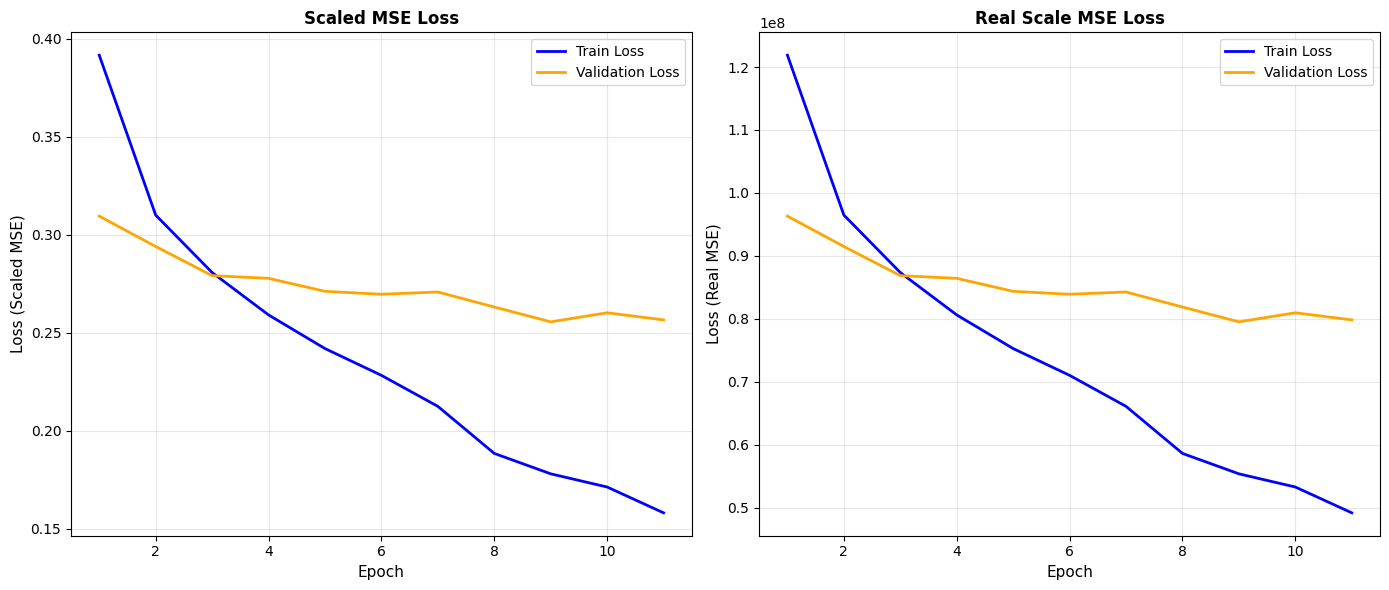

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20, clean_tokens_use=False)
# logger.info(f"Vocab size: {len(vocab)}")

# max_text_length = 320
# X_train_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab, max_length=max_text_length, clean_tokens_use=False)
#               for text in X_test_combined]

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_size = 256
cat_hidden_size = 128
reg_hidden_size = 256
dropout_prob = 0.35

model = SelfTaughtNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    reg_hidden_size=reg_hidden_size,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.003
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "selftaught_e256_mlen320_mf20_base_learn_chid64_rhid128_dr35_lr_0003_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))

test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=embeddings_models_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["SelfTaughtModelOverfittingMitigationv6"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=embeddings_models_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Conclusions after overfitting mitigation attempts

- Higher learning rate (e.g. 0.005, 0.003), especially at the start of training, generally helps the model to converge better.
- Decreasing the number of neurons leads to worse performance both on training and validation.
- Larger vocabulary doesn't help much in mitigating overfitting.
- Increasing dropout probability can help reduce overfitting but only a little.
- More strict early stopping helps to reduce overfitting but may lead to worse performance on validation.
- Generally, mitigating overfitting in this case is quite challenging, and the improvements are marginal.
- We should go with the model which achieved best validation performance, even if it has some overfitting, as it still generalizes better to unseen data.

As we saw tuning hyperparameters for self-taught embeddings does not bring significant improvements. It is logical that if the embeddings size is higher then it performs better as it can capture more information, but it also increases training time and model size. In order to save time and not perform unnecessary experiments, I will now try to use word2vec and fasttext embeddings with similar hyperparameters as the best self-taught model with new architectures. 

## Compare top self-taught, word2vec and fasttext models

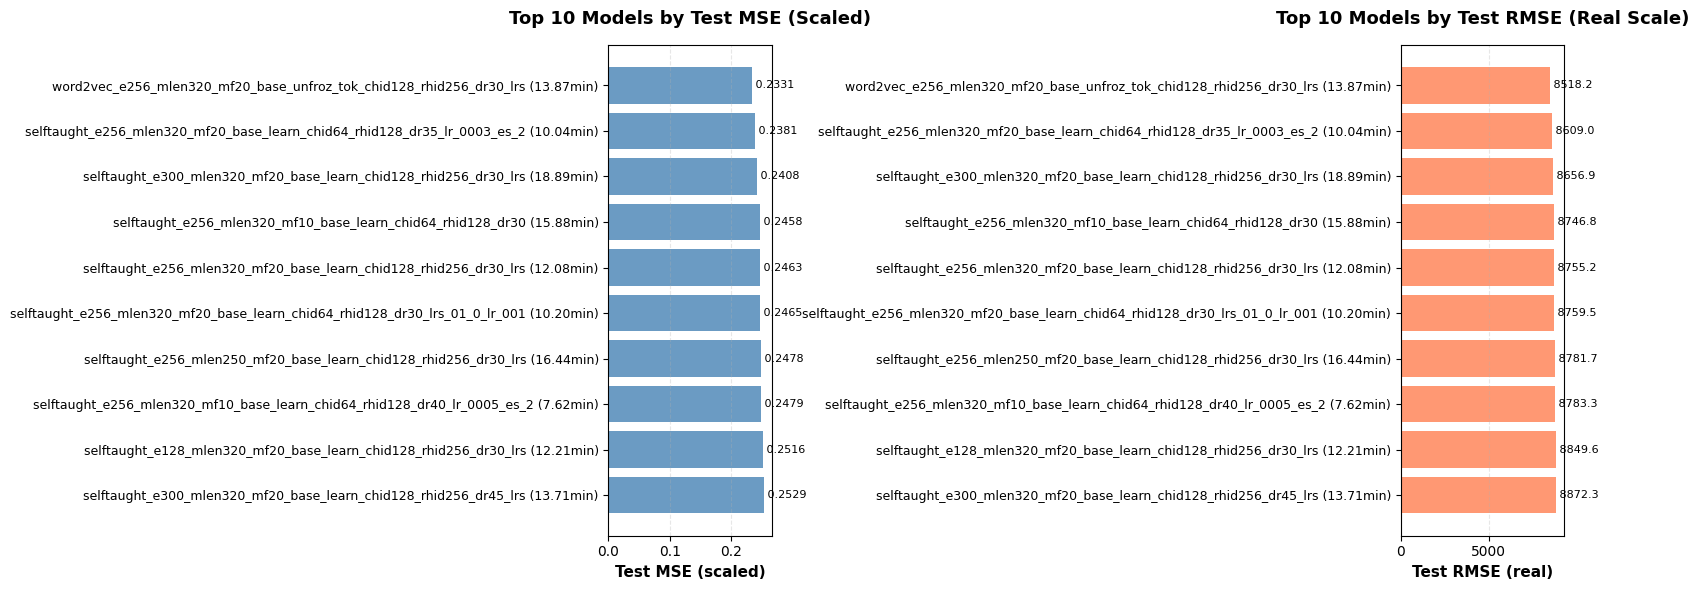

INFO - 
INFO - TOP 10 MODELS SUMMARY
INFO - ======================================================================
INFO - 
Best Model (by scaled MSE): word2vec_e256_mlen320_mf20_base_unfroz_tok_chid128_rhid256_dr30_lrs
INFO -   All Metrics:
INFO -     - Test MSE (scaled): 0.233149
INFO -     - Test MSE (real): 72,559,104.00
INFO -     - Test RMSE (real): 8,518.16
INFO -     - Training Time (minutes): 13.87 min
INFO - 
Best Model (by real RMSE): word2vec_e256_mlen320_mf20_base_unfroz_tok_chid128_rhid256_dr30_lrs
INFO -   All Metrics:
INFO -     - Test MSE (scaled): 0.233149
INFO -     - Test MSE (real): 72,559,104.00
INFO -     - Test RMSE (real): 8,518.16
INFO -     - Training Time (minutes): 13.87 min
INFO - ======================================================================



In [396]:
plot_top_models_comparison(embeddings_models_results, top_n=10, logger=logger)

## New model architectures

#### Models for self-taught embeddings

##### Residual connections
- Better gradient flow
- Helps with vanishing gradients

In [ ]:
class ResidualBlock(nn.Module):
    """
    Residual block: output = F(x) + x
    If dimensions don't match, uses a projection layer.
    This block consists of two linear layers with Batch Normalization and ReLU activation,
    along with dropout for regularization.
    """

    def __init__(self, input_dim, output_dim, dropout=0.3) -> None:
        """Initializes the ResidualBlock.
        Args:
            input_dim: int, Dimension of the input features.
            output_dim: int, Dimension of the output features.
            dropout: float, Dropout rate for regularization. Default is 0.3.
        """
        super(ResidualBlock, self).__init__()

        self.fc1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout)

        # Projection layer if dimensions don't match
        self.projection = None
        if input_dim != output_dim:
            self.projection = nn.Linear(input_dim, output_dim)

    def forward(self, x) -> torch.Tensor:
        """Defines the forward pass of the ResidualBlock.
        Args:
            x: torch.Tensor, Input features tensor.
        """
        identity = x

        # First layer
        out = self.fc1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout(out)

        # Second layer
        out = self.fc2(out)
        out = self.bn2(out)

        # Projection if needed
        if self.projection is not None:
            identity = self.projection(identity)

        # Residual connection
        out = out + identity
        out = F.relu(out)

        return out


In [ ]:
class SelfTaughtNNWithResiduals(nn.Module):
    """
    Self-taught NN with Residual Connections.
    This model extends the SelfTaughtNN by incorporating residual blocks in the regression layers.
    As an additional argument, it takes num_residual_blocks to specify how many residual blocks to use (1, 2, or 3).
    """

    def __init__(
        self,
        vocab_size: int,
        categorical_dim: int,
        embedding_size: int = 300,
        cat_hidden_size: int = 128,
        emb_hidden_size: int = 256,
        dropout: float = 0.3,
        num_residual_blocks: int = 2,
    ) -> None:
        """
        Initializes the SelfTaughtNNWithResiduals model.
        Args:
            vocab_size: int, Size of the vocabulary for the embedding layer.
            categorical_dim: int, Number of categorical features.
            embedding_size: int, Dimension of the word embeddings, default 300.
            cat_hidden_size: int, Number of neurons in the hidden layer for categorical features, default 128.
            emb_hidden_size: int, Number of neurons in the hidden layers for regression, default 256.
            dropout: float, Dropout rate for regularization, default 0.3.
            num_residual_blocks: int, Number of residual blocks to use in regression (1, 2, or 3), default 2.
        """
        super(SelfTaughtNNWithResiduals, self).__init__()

        # Trainable embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)

        # Layers for categorical features
        self.cat_layer = nn.Linear(categorical_dim, cat_hidden_size)
        self.batch_norm_cat = nn.BatchNorm1d(cat_hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Combined dimension
        regressor_input_dim = embedding_size + cat_hidden_size

        # Build regressor with flexible number of residual blocks
        self.num_blocks = num_residual_blocks

        if num_residual_blocks == 1:
            # Simpler: Just one block
            self.res_block1 = ResidualBlock(
                regressor_input_dim, emb_hidden_size, dropout
            )
            self.output_layer = nn.Linear(emb_hidden_size, 1)

        elif num_residual_blocks == 2:
            # Standard: Two blocks (RECOMMENDED - matches original depth)
            self.res_block1 = ResidualBlock(
                regressor_input_dim, emb_hidden_size, dropout
            )
            self.res_block2 = ResidualBlock(
                emb_hidden_size, emb_hidden_size // 2, dropout
            )
            self.output_layer = nn.Linear(emb_hidden_size // 2, 1)

        elif num_residual_blocks == 3:
            # Deeper: Three blocks (for larger datasets)
            self.res_block1 = ResidualBlock(
                regressor_input_dim, emb_hidden_size, dropout
            )
            self.res_block2 = ResidualBlock(
                emb_hidden_size, emb_hidden_size // 2, dropout
            )
            self.res_block3 = ResidualBlock(
                emb_hidden_size // 2, emb_hidden_size // 2, dropout
            )
            self.output_layer = nn.Linear(emb_hidden_size // 2, 1)

        else:
            raise ValueError("num_residual_blocks must be 1, 2, or 3")

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # 1. Embed text and average word vectors
        text_emb = self.embedding(text_seq)
        text_mask = (text_seq != 0).unsqueeze(-1).float()
        text_feat = (text_emb * text_mask).sum(dim=1) / (text_mask.sum(dim=1) + 1e-9)

        # 2. Process categorical features
        cat_feat = self.cat_layer(cat_features)
        cat_feat = self.batch_norm_cat(cat_feat)
        cat_feat = F.relu(cat_feat)
        cat_feat = self.dropout(cat_feat)

        # 3. Concatenate features
        combined = torch.cat((text_feat, cat_feat), dim=1)

        # 4. Pass through residual blocks
        if self.num_blocks == 1:
            out = self.res_block1(combined)
        elif self.num_blocks == 2:
            out = self.res_block1(combined)
            out = self.res_block2(out)
        elif self.num_blocks == 3:
            out = self.res_block1(combined)
            out = self.res_block2(out)
            out = self.res_block3(out)

        # 5. Final output
        output = self.output_layer(out)

        return output

##### CNN
- Single-scale CNN (kernel size 3) for local pattern extraction
- Global max pooling

In [ ]:
class CNNModel(nn.Module):
    """
    Model using CNN with Global Max Pooling and categorical features.
    This model includes an embedding layer for text input, a convolutional layer followed by
    global max pooling to extract text features, processes categorical features through
    a fully connected layer, and combines both to predict a continuous target variable.
    """

    def __init__(
        self,
        vocab_size: int,
        categorical_dim: int,
        embedding_size: int = 300,
        cat_hidden_size: int = 128,
        emb_hidden_size: int = 256,
        num_filters: int = 64,
        dropout: float = 0.3,
    ) -> None:
        """
        Initializes the CNNModel.
            Args:
                vocab_size: int, Size of the vocabulary for the embedding layer.
                categorical_dim: int, Number of categorical features.
                embedding_size: int, Dimension of the word embeddings, default 300.
                cat_hidden_size: int, Number of neurons in the hidden layer for categorical features, default 128.
                emb_hidden_size: int, Number of neurons in the hidden layers for regression, default 256.
                num_filters: int, Number of filters in the CNN layer, default 64.
                dropout: float, Dropout rate for regularization, default 0.3.
        """
        super(CNNModel, self).__init__()

        # Calculate input dimension for regressor
        # The text features will be of size 'num_filters' after pooling.
        # The categorical features are projected to 'cat_hidden_size'.
        regressor_input_dim = num_filters + cat_hidden_size

        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.2)

        # 2. CNN Layer (Input: [Batch, Embedding_Size, Seq_Length])
        self.conv = nn.Conv1d(
            embedding_size, num_filters, kernel_size=3, padding=1
        )  # 'same' padding
        self.conv_bn = nn.BatchNorm1d(num_filters)

        # 3. Categorical features projection layer
        # Projects cat features to a dimension 'cat_hidden_size' for combination
        self.cat_layer = nn.Sequential(
            nn.Linear(categorical_dim, cat_hidden_size),
            nn.BatchNorm1d(cat_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # 4. Regressor
        self.regressor = nn.Sequential(
            # Input size is num_filters (from CNN) + cat_hidden_size (from Cat Layer)
            nn.Linear(regressor_input_dim, emb_hidden_size),
            nn.BatchNorm1d(emb_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size, emb_hidden_size // 2),
            nn.BatchNorm1d(emb_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size // 2, 1),
        )

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # 1. Embedding
        text_emb = self.embedding(text_seq)
        text_emb = self.embedding_dropout(text_emb)

        # 2. CNN
        # Transpose from [Batch, Seq_Len, Emb_Dim] to [Batch, Emb_Dim, Seq_Len]
        text_emb_t = text_emb.transpose(1, 2)
        conv_out = F.relu(self.conv(text_emb_t))
        conv_out = self.conv_bn(conv_out)

        # 3. Global Pooling
        # Apply Global Max Pooling across the sequence length (dim 2)
        # This collapses [Batch, Num_Filters, Seq_Length] -> [Batch, Num_Filters, 1]
        # and then squeezes the last dimension to get [Batch, Num_Filters]
        text_feat = F.adaptive_max_pool1d(conv_out, 1).squeeze(-1)

        # 4. Categorical features
        cat_feat = self.cat_layer(cat_features)

        # 5. Combine and predict
        combined = torch.cat([text_feat, cat_feat], dim=1)
        output = self.regressor(combined)
        return output

##### CNN + Residual connections
- Residual connections after convolutional layers
- Helps with gradient flow
- Helps with vanishing gradients

In [ ]:
class CNNModelWithResiduals(nn.Module):
    """
    CNN Model with Residual Connections.
    This model extends the CNNModel by incorporating residual blocks in the regression layers.
    It includes an embedding layer for text input, a convolutional layer followed by
    a global max pooling layer, and a fully connected layer for regression.
    """

    def __init__(
        self,
        vocab_size: int,
        categorical_dim: int,
        embedding_size: int = 300,
        cat_hidden_size: int = 128,
        emb_hidden_size: int = 256,
        num_filters: int = 64,
        dropout: float = 0.3,
    ) -> None:
        """
        Initializes the CNNModelWithResiduals.
        Args:
            vocab_size: int, Size of the vocabulary for the embedding layer.
            categorical_dim: int, Number of categorical features.
            embedding_size: int, Dimension of the word embeddings, default 300.
            cat_hidden_size: int, Number of neurons in the hidden layer for categorical features, default 128.
            emb_hidden_size: int, Number of neurons in the hidden layers for regression, default 256.
            num_filters: int, Number of filters in the CNN layer, default 64.
            dropout: float, Dropout rate for regularization, default 0.3.
        """
        super(CNNModelWithResiduals, self).__init__()

        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.2)

        # 2. CNN Layers with Residual Connection
        self.conv1 = nn.Conv1d(embedding_size, num_filters, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm1d(num_filters)

        # Additional conv layer for residual connection
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm1d(num_filters)

        # Projection for residual if embedding_size != num_filters
        self.conv_projection = None
        if embedding_size != num_filters:
            self.conv_projection = nn.Conv1d(embedding_size, num_filters, kernel_size=1)

        # 3. Categorical features projection
        self.cat_layer = nn.Sequential(
            nn.Linear(categorical_dim, cat_hidden_size),
            nn.BatchNorm1d(cat_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # 4. Regressor with Residual Blocks
        regressor_input_dim = num_filters + cat_hidden_size

        # First residual block
        self.res_block1 = ResidualBlock(regressor_input_dim, emb_hidden_size, dropout)

        # Second residual block
        self.res_block2 = ResidualBlock(emb_hidden_size, emb_hidden_size // 2, dropout)

        # Final output layer
        self.output_layer = nn.Linear(emb_hidden_size // 2, 1)

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # 1. Embedding
        text_emb = self.embedding(text_seq)
        text_emb = self.embedding_dropout(text_emb)

        # 2. CNN with Residual Connection
        # Transpose: [Batch, Seq_Len, Emb_Dim] -> [Batch, Emb_Dim, Seq_Len]
        text_emb_t = text_emb.transpose(1, 2)

        # First conv
        conv_out = F.relu(self.conv1_bn(self.conv1(text_emb_t)))

        # Second conv with residual
        conv_out2 = self.conv2(conv_out)
        conv_out2 = self.conv2_bn(conv_out2)

        # Residual connection
        conv_out = F.relu(conv_out2 + conv_out)  # Skip connection

        # 3. Global Max Pooling
        text_feat = F.adaptive_max_pool1d(conv_out, 1).squeeze(-1)

        # 4. Categorical features
        cat_feat = self.cat_layer(cat_features)

        # 5. Combine
        combined = torch.cat([text_feat, cat_feat], dim=1)

        # 6. Pass through residual blocks
        out = self.res_block1(combined)
        out = self.res_block2(out)

        # 7. Final output
        output = self.output_layer(out)

        return output


##### CNN + Vanilla RNN 

- Single-scale CNN (kernel size 3) for local pattern extraction
- Single-layer vanilla RNN for sequential processing
- Average pooling for text aggregation
- Simple feedforward regressor

In [ ]:
class CNNRNNModel(nn.Module):
    """
    Model with CNN and vanilla RNN. Model processes text sequences with a CNN layer followed by a vanilla RNN,
    and combines the extracted features for regression tasks.
    """

    def __init__(
        self,
        vocab_size,
        categorical_dim,
        embedding_size=300,
        cat_hidden_size=128,
        emb_hidden_size=256,
        rnn_hidden_size=128,
        num_filters=64,
        dropout=0.3,
    ) -> None:
        """Initializes the CNNRNNModel.
        Args:
            vocab_size: int, Size of the vocabulary for the embedding layer.
            categorical_dim: int, Number of categorical features.
            embedding_size: int, Dimension of the word embeddings, default 300.
            cat_hidden_size: int, Number of neurons in the hidden layer for categorical features, default 128.
            emb_hidden_size: int, Number of neurons in the hidden layers for regression, default 256.
            rnn_hidden_size: int, Number of neurons in the RNN hidden layer, default 128.
            num_filters: int, Number of filters in the CNN layer, default 64.
            dropout: float, Dropout rate for regularization, default 0.3.
        """
        super(CNNRNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.2)

        # Single CNN layer
        self.conv = nn.Conv1d(embedding_size, num_filters, kernel_size=3, padding=1)
        self.conv_bn = nn.BatchNorm1d(num_filters)

        # Vanilla RNN
        self.rnn = nn.RNN(
            num_filters,
            rnn_hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=dropout,
        )

        # Categorical features
        self.cat_layer = nn.Sequential(
            nn.Linear(categorical_dim, cat_hidden_size),
            nn.BatchNorm1d(cat_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(rnn_hidden_size + cat_hidden_size, emb_hidden_size),
            nn.BatchNorm1d(emb_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size, emb_hidden_size // 2),
            nn.BatchNorm1d(emb_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size // 2, 1),
        )

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # Embedding
        text_emb = self.embedding(text_seq)
        text_emb = self.embedding_dropout(text_emb)

        # CNN
        text_emb_t = text_emb.transpose(1, 2)
        conv_out = F.relu(self.conv(text_emb_t))
        conv_out = self.conv_bn(conv_out)
        conv_out = conv_out.transpose(1, 2)

        # RNN
        rnn_out, _ = self.rnn(conv_out)  # _ is final hidden state (not used)

        # Average pooling
        mask = (text_seq != 0).unsqueeze(-1).float()
        text_feat = (rnn_out * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-9)

        # Categorical features
        cat_feat = self.cat_layer(cat_features)

        # Combine and predict
        combined = torch.cat([text_feat, cat_feat], dim=1)
        output = self.regressor(combined)
        return output


##### CNN + GRU
- Multi-scale CNN (kernel sizes 3, 5) for n-gram extraction
- 2-layer bidirectional GRU for context understanding
- Max + average pooling for robust text representation
- Deep feedforward regressor with batch normalization

In [ ]:
class CNNGRUModel(nn.Module):
    """CNN and GRU model with multi-scale CNN and bidirectional GRU.
    This model processes text sequences with multi-scale CNN layers followed by a bidirectional GRU,
    and combines the extracted features with categorical features for regression tasks."""

    def __init__(
        self,
        vocab_size,
        categorical_dim,
        embedding_size=300,
        cat_hidden_size=128,
        emb_hidden_size=256,
        gru_hidden_size=128,
        num_filters=64,
        dropout=0.3,
    ) -> None:
        """Initializes the CNNGRUModel.
        Args:
            vocab_size: int, Size of the vocabulary for the embedding layer.
            categorical_dim: int, Number of categorical features.
            embedding_size: int, Dimension of the word embeddings, default 300.
            cat_hidden_size: int, Number of neurons in the hidden layer for categorical features, default 128.
            emb_hidden_size: int, Number of neurons in the hidden layers for regression, default 256.
            gru_hidden_size: int, Number of neurons in the GRU hidden layer, default 128.
            num_filters: int, Number of filters in the CNN layer, default 64.
            dropout: float, Dropout rate for regularization, default 0.3.
        """
        super(CNNGRUModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.2)

        # Multi-scale CNN
        self.conv1 = nn.Conv1d(embedding_size, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_size, num_filters, kernel_size=5, padding=2)
        self.conv_bn = nn.BatchNorm1d(num_filters * 2)

        # Bidirectional GRU
        self.gru = nn.GRU(
            num_filters * 2,
            gru_hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        # Categorical features
        self.cat_layer = nn.Sequential(
            nn.Linear(categorical_dim, cat_hidden_size),
            nn.BatchNorm1d(cat_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(gru_hidden_size * 2 + cat_hidden_size, emb_hidden_size),
            nn.BatchNorm1d(emb_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size, emb_hidden_size // 2),
            nn.BatchNorm1d(emb_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size // 2, 1),
        )

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.

        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        text_emb = self.embedding(text_seq)
        text_emb = self.embedding_dropout(text_emb)

        # Multi-scale CNN
        text_emb_t = text_emb.transpose(1, 2)
        conv1_out = F.relu(self.conv1(text_emb_t))
        conv2_out = F.relu(self.conv2(text_emb_t))
        conv_out = torch.cat([conv1_out, conv2_out], dim=1)
        conv_out = self.conv_bn(conv_out)
        conv_out = conv_out.transpose(1, 2)

        # Bidirectional GRU
        gru_out, _ = self.gru(conv_out)

        # Max and average pooling
        mask = (text_seq != 0).unsqueeze(-1).float()
        gru_out_masked = gru_out * mask
        max_pool = torch.max(gru_out_masked, dim=1)[0]
        avg_pool = gru_out_masked.sum(dim=1) / (mask.sum(dim=1) + 1e-9)
        text_feat = torch.cat([max_pool, avg_pool], dim=1)

        cat_feat = self.cat_layer(cat_features)
        combined = torch.cat([text_feat, cat_feat], dim=1)
        output = self.regressor(combined)
        return output

##### CNN + LSTM
- Multi-scale CNN (kernel sizes 3, 5) for n-gram extraction
- 2-layer bidirectional LSTM for sequential processing
- Max + average pooling for text aggregation
- Deep feedforward regressor with batch normalization

In [ ]:
class CNNLSTMModel(nn.Module):
    """Model with CNN and LSTM.
    This model processes text sequences with multi-scale CNN layers followed by a bidirectional LSTM,
    and combines the extracted features with categorical features for regression tasks."""

    def __init__(
        self,
        vocab_size,
        categorical_dim,
        embedding_size=300,
        cat_hidden_size=128,
        emb_hidden_size=256,
        lstm_hidden_size=128,
        num_filters=64,
        dropout=0.3,
    ) -> None:
        """Initializes the CNNLSTMModel.
        Args:
            vocab_size: int, Size of the vocabulary for the embedding layer.
            categorical_dim: int, Number of categorical features.
            embedding_size: int, Dimension of the word embeddings, default 300.
            cat_hidden_size: int, Number of neurons in the hidden layer for categorical features, default 128.
            emb_hidden_size: int, Number of neurons in the hidden layers for regression, default 256.
            lstm_hidden_size: int, Number of neurons in the LSTM hidden layer, default 128.
            num_filters: int, Number of filters in the CNN layer, default 64.
            dropout: float, Dropout rate for regularization, default 0.3.
        """
        super(CNNLSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.2)

        # Multi-scale CNN
        self.conv1 = nn.Conv1d(embedding_size, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_size, num_filters, kernel_size=5, padding=2)
        self.conv_bn = nn.BatchNorm1d(num_filters * 2)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            num_filters * 2,
            lstm_hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        # Categorical features
        self.cat_layer = nn.Sequential(
            nn.Linear(categorical_dim, cat_hidden_size),
            nn.BatchNorm1d(cat_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2 + cat_hidden_size, emb_hidden_size),
            nn.BatchNorm1d(emb_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size, emb_hidden_size // 2),
            nn.BatchNorm1d(emb_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size // 2, 1),
        )

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor, Model output.
        """
        text_emb = self.embedding(text_seq)
        text_emb = self.embedding_dropout(text_emb)

        # Multi-scale CNN
        text_emb_t = text_emb.transpose(1, 2)
        conv1_out = F.relu(self.conv1(text_emb_t))
        conv2_out = F.relu(self.conv2(text_emb_t))
        conv_out = torch.cat([conv1_out, conv2_out], dim=1)
        conv_out = self.conv_bn(conv_out)
        conv_out = conv_out.transpose(1, 2)

        # Bidirectional LSTM
        lstm_out, _ = self.lstm(conv_out)

        # Max and average pooling
        mask = (text_seq != 0).unsqueeze(-1).float()
        lstm_out_masked = lstm_out * mask
        max_pool = torch.max(lstm_out_masked, dim=1)[0]
        avg_pool = lstm_out_masked.sum(dim=1) / (mask.sum(dim=1) + 1e-9)
        text_feat = torch.cat([max_pool, avg_pool], dim=1)

        cat_feat = self.cat_layer(cat_features)
        combined = torch.cat([text_feat, cat_feat], dim=1)
        output = self.regressor(combined)
        return output


#### Models for unfrozen embeddings matrix

##### Residual connections

In [ ]:
class UnfrozenResidualNN(nn.Module):
    """
    Residual Neural Network with unfrozen embeddings and categorical features.
    Includes a flexible number of residual blocks for regression tasks.
    """

    def __init__(
        self,
        vocab_size: int,
        categorical_dim: int,
        embedding_size: int = 300,
        cat_hidden_size: int = 128,
        emb_hidden_size: int = 256,
        dropout: float = 0.3,
        num_residual_blocks: int = 2,
    ) -> None:
        """
        Initializes the UnfrozenResidualNN model.
        Args:
            vocab_size: Size of the vocabulary for the embedding layer.
            categorical_dim: Number of categorical features.
            embedding_size: Dimension of the word embeddings. Defaults to 300.
            cat_hidden_size: Number of neurons in the hidden layer for categorical features. Defaults to 128.
            emb_hidden_size: Number of neurons in the hidden layers for regression. Defaults to 256.
            dropout: Dropout rate for regularization. Defaults to 0.3.
            num_residual_blocks: Number of residual blocks to use in regression (1, 2, or 3). Defaults to 2.
        """
        super(UnfrozenResidualNN, self).__init__()

        # Trainable embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)

        # Layers for categorical features
        self.cat_layer = nn.Linear(categorical_dim, cat_hidden_size)
        self.batch_norm_cat = nn.BatchNorm1d(cat_hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Combined dimension
        regressor_input_dim = embedding_size + cat_hidden_size

        # Build regressor with flexible number of residual blocks
        self.num_blocks = num_residual_blocks

        if num_residual_blocks == 1:
            # Simpler: Just one block
            self.res_block1 = ResidualBlock(
                regressor_input_dim, emb_hidden_size, dropout
            )
            self.output_layer = nn.Linear(emb_hidden_size, 1)

        elif num_residual_blocks == 2:
            # Standard: Two blocks (RECOMMENDED - matches original depth)
            self.res_block1 = ResidualBlock(
                regressor_input_dim, emb_hidden_size, dropout
            )
            self.res_block2 = ResidualBlock(
                emb_hidden_size, emb_hidden_size // 2, dropout
            )
            self.output_layer = nn.Linear(emb_hidden_size // 2, 1)

        elif num_residual_blocks == 3:
            # Deeper: Three blocks (for larger datasets)
            self.res_block1 = ResidualBlock(
                regressor_input_dim, emb_hidden_size, dropout
            )
            self.res_block2 = ResidualBlock(
                emb_hidden_size, emb_hidden_size // 2, dropout
            )
            self.res_block3 = ResidualBlock(
                emb_hidden_size // 2, emb_hidden_size // 2, dropout
            )
            self.output_layer = nn.Linear(emb_hidden_size // 2, 1)

        else:
            raise ValueError("num_residual_blocks must be 1, 2, or 3")

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # 1. Embed text and average word vectors
        text_emb = self.embedding(text_seq)
        text_mask = (text_seq != 0).unsqueeze(-1).float()
        text_feat = (text_emb * text_mask).sum(dim=1) / (text_mask.sum(dim=1) + 1e-9)

        # 2. Process categorical features
        cat_feat = self.cat_layer(cat_features)
        cat_feat = self.batch_norm_cat(cat_feat)
        cat_feat = F.relu(cat_feat)
        cat_feat = self.dropout(cat_feat)

        # 3. Concatenate features
        combined = torch.cat((text_feat, cat_feat), dim=1)

        # 4. Pass through residual blocks
        if self.num_blocks == 1:
            out = self.res_block1(combined)
        elif self.num_blocks == 2:
            out = self.res_block1(combined)
            out = self.res_block2(out)
        elif self.num_blocks == 3:
            out = self.res_block1(combined)
            out = self.res_block2(out)
            out = self.res_block3(out)

        # 5. Final output
        output = self.output_layer(out)

        return output




##### CNN 

In [ ]:
class UnfrozenCNN(nn.Module):
    """CNN model with unfrozen pre-trained embeddings and categorical features.
    Combines CNN-extracted text features with categorical features for regression tasks.
    """

    def __init__(
        self,
        embedding_matrix: np.ndarray,
        categorical_dim: int,
        cat_hidden_size: int = 128,
        emb_hidden_size: int = 256,
        num_filters: int = 64,
        dropout: float = 0.3,
    ) -> None:
        """Initializes the UnfrozenCNN model.
        Args:
            embedding_matrix: Pre-trained embedding matrix as a NumPy array.
            categorical_dim: Dimension of the categorical feature input.
            cat_hidden_size: Number of neurons in the hidden layer for categorical features. Defaults to 128.
            emb_hidden_size: Number of neurons in the hidden layers for regression. Defaults to 256.
            num_filters: Number of filters in the CNN layer. Defaults to 64.
            dropout: Dropout probability for regularization. Defaults to 0.3.
        """
        super(UnfrozenCNN, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape

        # Unfrozen embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(
            torch.tensor(embedding_matrix, dtype=torch.float32), requires_grad=True
        )
        self.embedding_dropout = nn.Dropout(0.2)

        # CNN Layer
        self.conv = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv_bn = nn.BatchNorm1d(num_filters)

        # Categorical features projection layer
        self.cat_layer = nn.Sequential(
            nn.Linear(categorical_dim, cat_hidden_size),
            nn.BatchNorm1d(cat_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(num_filters + cat_hidden_size, emb_hidden_size),
            nn.BatchNorm1d(emb_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size, emb_hidden_size // 2),
            nn.BatchNorm1d(emb_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_hidden_size // 2, 1),
        )

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # Embedding
        text_emb = self.embedding(text_seq)
        text_emb = self.embedding_dropout(text_emb)

        # CNN
        text_emb_t = text_emb.transpose(1, 2)
        conv_out = F.relu(self.conv(text_emb_t))
        conv_out = self.conv_bn(conv_out)

        # Global Max Pooling
        text_feat = F.adaptive_max_pool1d(conv_out, 1).squeeze(-1)

        # Categorical features
        cat_feat = self.cat_layer(cat_features)

        # Combine and predict
        combined = torch.cat([text_feat, cat_feat], dim=1)
        output = self.regressor(combined)
        return output


##### CNN + Residual connections

In [ ]:
class UnfrozenCNNWithResiduals(nn.Module):
    """Unfrozen CNN model with Residual Connections and categorical features.
    Combines CNN-extracted text features with categorical features for regression tasks,
    and includes residual blocks in the regressor for enhanced learning.
    """

    def __init__(
        self,
        embedding_matrix: np.ndarray,
        categorical_dim: int,
        cat_hidden_size: int = 128,
        emb_hidden_size: int = 256,
        num_filters: int = 64,
        dropout: float = 0.3,
    ) -> None:
        """Initializes the UnfrozenCNNWithResiduals model.
        Args:
            embedding_matrix: Pre-trained embedding matrix as a NumPy array.
            categorical_dim: Dimension of the categorical feature input.
            cat_hidden_size: Number of neurons in the hidden layer for categorical features. Defaults to 128.
            emb_hidden_size: Number of neurons in the hidden layers for regression. Defaults to 256.
            num_filters: Number of filters in the CNN layer. Defaults to 64.
            dropout: Dropout probability for regularization. Defaults to 0.3.
        """
        super(UnfrozenCNNWithResiduals, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape

        # Unfrozen embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(
            torch.tensor(embedding_matrix, dtype=torch.float32), requires_grad=True
        )
        self.embedding_dropout = nn.Dropout(0.2)

        # CNN Layers with Residual Connection
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm1d(num_filters)

        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm1d(num_filters)

        # Categorical features projection
        self.cat_layer = nn.Sequential(
            nn.Linear(categorical_dim, cat_hidden_size),
            nn.BatchNorm1d(cat_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Regressor with Residual Blocks
        regressor_input_dim = num_filters + cat_hidden_size

        self.res_block1 = ResidualBlock(regressor_input_dim, emb_hidden_size, dropout)
        self.res_block2 = ResidualBlock(emb_hidden_size, emb_hidden_size // 2, dropout)

        self.output_layer = nn.Linear(emb_hidden_size // 2, 1)

    def forward(self, text_seq, cat_features) -> torch.Tensor:
        """Defines the forward pass of the model.
        Args:
            text_seq: torch.Tensor, Input text sequences (word indices).
            cat_features: torch.Tensor, Categorical features.
        Returns:
            torch.Tensor: Predicted continuous target value.
        """
        # Embedding
        text_emb = self.embedding(text_seq)
        text_emb = self.embedding_dropout(text_emb)

        # CNN with Residual Connection
        text_emb_t = text_emb.transpose(1, 2)

        conv_out = F.relu(self.conv1_bn(self.conv1(text_emb_t)))

        conv_out2 = self.conv2(conv_out)
        conv_out2 = self.conv2_bn(conv_out2)

        conv_out = F.relu(conv_out2 + conv_out)  # Skip connection

        # Global Max Pooling
        text_feat = F.adaptive_max_pool1d(conv_out, 1).squeeze(-1)

        # Categorical Features
        cat_feat = self.cat_layer(cat_features)

        # Concatenate Features
        combined_feat = torch.cat((text_feat, cat_feat), dim=1)

        # Residual Blocks
        x = self.res_block1(combined_feat)
        x = self.res_block2(x)

        # Output Layer
        output = self.output_layer(x)
        return output


### Experimenting with new model architectures 

**Note**: Due to computational constraints I will not try using architectures with RNN, LSTM or GRU. They are just presented here as examples of possible architectures to explore.

In [387]:
new_architectures_results = {}

#### Self-taught models

##### Base model with residual connections

INFO - Vocabulary size for model: 22927
INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.3977, Real MSE: 123755540.25, Real RMSE: 11124.55
INFO -   Valid - MSE: 0.3261, Real MSE: 101472091.93, Real RMSE: 10073.34
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.326053
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.2925, Real MSE: 91018964.39, Real RMSE: 9540.39
INFO -   Valid - MSE: 0.2904, Real MSE: 90386502.61, Real RMSE: 9507.18
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.035621 to 0.290432
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2574, Real MSE: 80102247.32, Real RMSE: 8949.99
INFO -   Valid - MSE: 

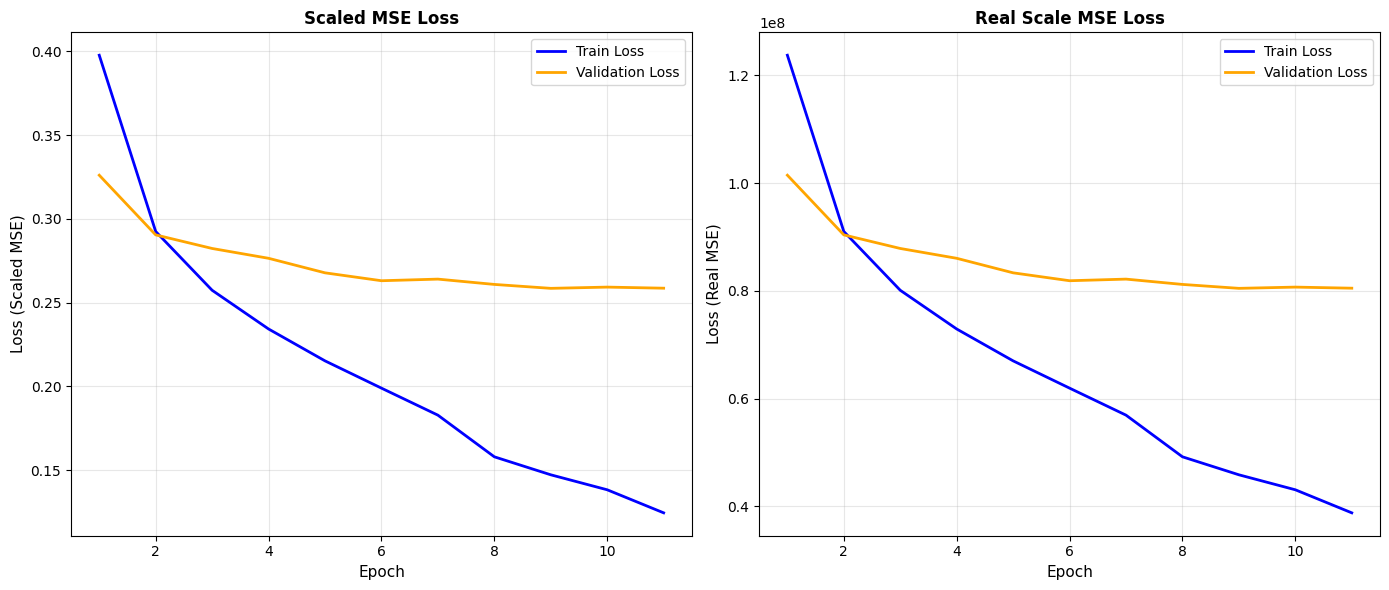

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()

# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20)
logger.info(f"Vocabulary size for model: {len(vocab)}")

max_text_length = 320

X_train_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_train_combined
]
X_valid_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_valid_combined
]
X_test_seq = [
    text_to_sequence(text, vocab, max_length=max_text_length)
    for text in X_test_combined
]

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

embedding_dim = 300
cat_hidden_dim = 128
emb_hidden_dim = 256
dropout_prob = 0.3

model = SelfTaughtNNWithResiduals(
    vocab_size=len(vocab),
    embedding_size=embedding_dim,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_dim,
    emb_hidden_size=emb_hidden_dim,
    dropout=dropout_prob,
    num_residual_blocks=2,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [398]:
model_name = "selftaught_e300_mlen320_mf20_base_res_learn_chid64_rhid128_dr30_lrs_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [399]:
all_models_results["ResidualSelfTaughtModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

##### Simple CNN with Max Pooling

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4493, Real MSE: 139826661.17, Real RMSE: 11824.83
INFO -   Valid - MSE: 0.3534, Real MSE: 109990528.99, Real RMSE: 10487.64
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.353425
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3505, Real MSE: 109072660.75, Real RMSE: 10443.79
INFO -   Valid - MSE: 0.3153, Real MSE: 98119018.53, Real RMSE: 9905.50
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.038146 to 0.315279
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.3133, Real MSE: 97506702.80, Real RMSE: 9874.55
INFO -   Valid - MSE: 0.2978, Real MSE: 92667296.69, Real RM

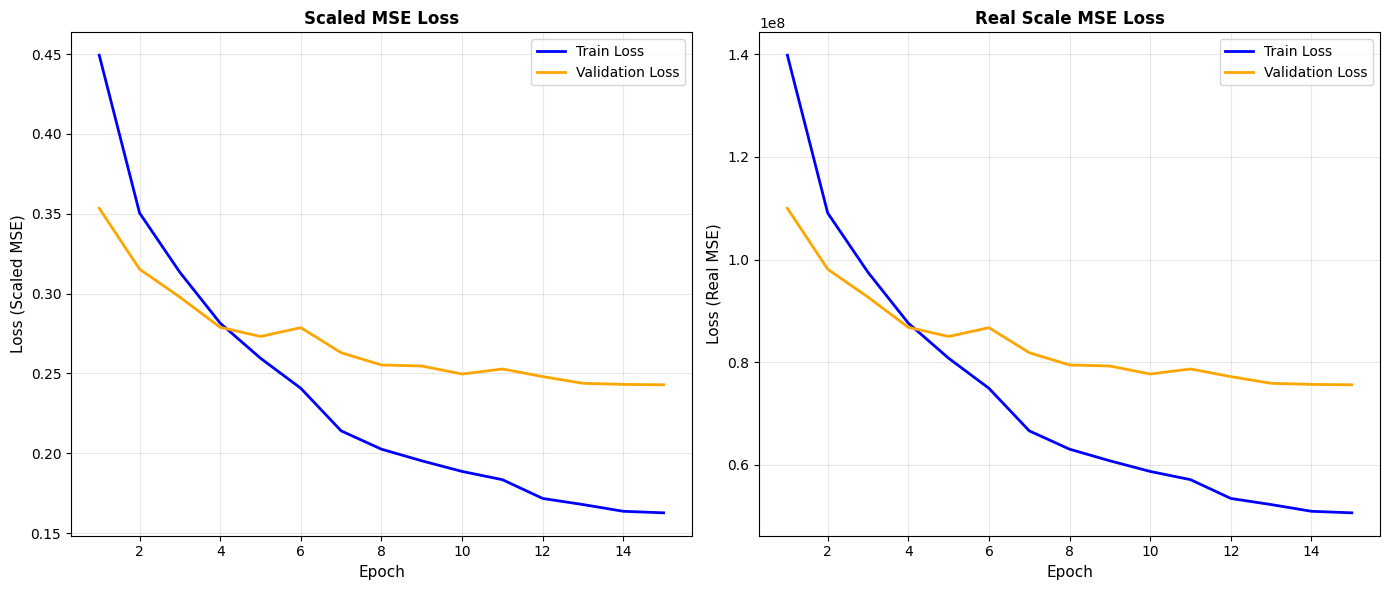

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()

# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20)
# logger.info(f"Vocabulary size for CNN model: {len(vocab)}")

# max_text_length = 250

# X_train_seq = [text_to_sequence(text, vocab, max_length=max_text_length)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab, max_length=max_text_length)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab, max_length=max_text_length)
#               for text in X_test_combined]

# train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
# valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
# test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)

embedding_dim = 300
cat_hidden_dim = 128
emb_hidden_dim = 256
dropout_prob = 0.3

model = CNNModel(
    vocab_size=len(vocab),
    embedding_size=embedding_dim,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_dim,
    emb_hidden_size=emb_hidden_dim,
    num_filters=64,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [403]:
model_name = "selftaught_e300_mlen320_mf20_cnn_learn_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [404]:
all_models_results["CNNSelfTaughtModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

##### CNN with Residual connections

INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 3, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.4233, Real MSE: 131748463.79, Real RMSE: 11478.17
INFO -   Valid - MSE: 0.3629, Real MSE: 112928687.77, Real RMSE: 10626.79
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.362866
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.3112, Real MSE: 96861788.80, Real RMSE: 9841.84
INFO -   Valid - MSE: 0.3038, Real MSE: 94547709.98, Real RMSE: 9723.56
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.059062 to 0.303803
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2705, Real MSE: 84196889.43, Real RMSE: 9175.89
INFO -   Valid - MSE: 0.2855, Real MSE: 88859848.12, Real RMSE

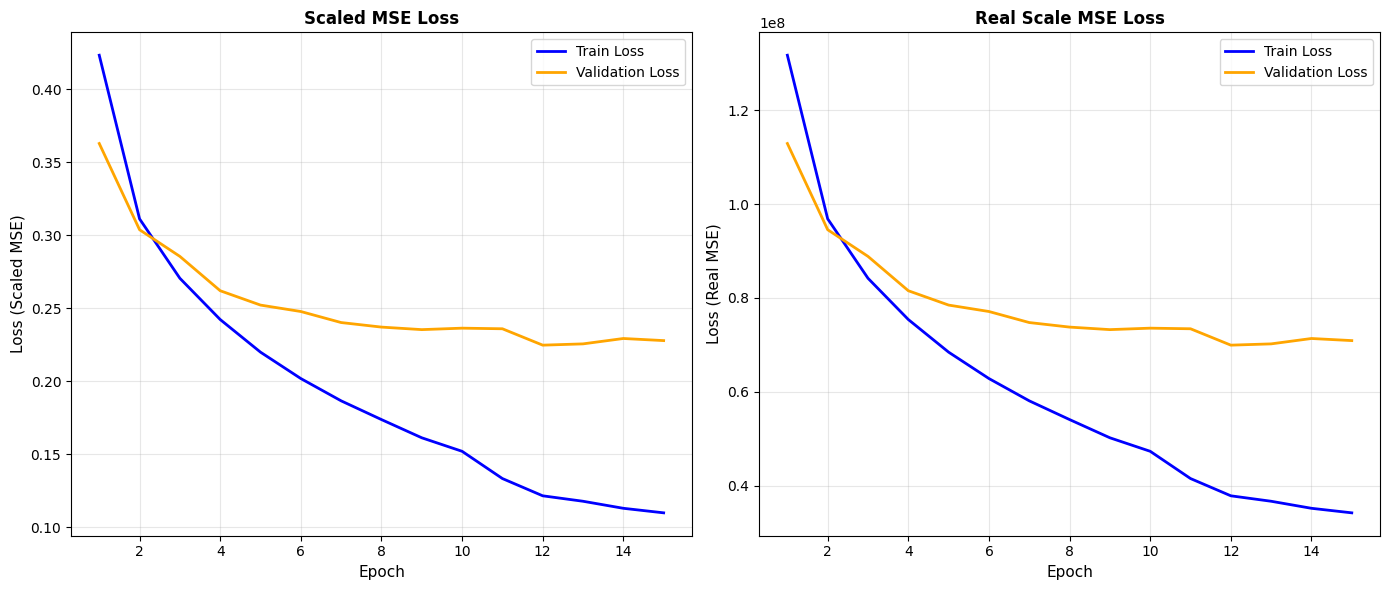

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()

# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20)
# logger.info(f"Vocabulary size for CNN model: {len(vocab)}")

# max_text_length = 320

# X_train_seq = [text_to_sequence(text, vocab, max_length=max_text_length)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab, max_length=max_text_length)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab, max_length=max_text_length)
#               for text in X_test_combined]

# train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
# valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
# test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)

embedding_dim = 300
cat_hidden_dim = 128
emb_hidden_dim = 256
dropout_prob = 0.3

model = CNNModelWithResiduals(
    vocab_size=len(vocab),
    embedding_size=embedding_dim,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_dim,
    emb_hidden_size=emb_hidden_dim,
    num_filters=64,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 3
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [406]:
model_name = "selftaught_e300_mlen320_mf20_cnn_res_learn_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [ ]:
all_models_results["CNNResidualSelfTaughtModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Unfreezed word2vec embedding layer models

##### Base model with residual connections

INFO - Data successfully loaded from Train_rev1.csv. Shape: (244768, 12)
INFO - Data split into train, validation, and test sets.
INFO - Training set shape: (195814, 8), (195814,)
INFO - Validation set shape: (24477, 8), (24477,)
INFO - Test set shape: (24477, 8), (24477,)
INFO - Categorical features preprocessed successfully.
INFO - Target scaler saved to: preprocessors/target_scaler.pkl
INFO - Word2Vec trained with 22925 words
INFO - Vocabulary size for w2v model: 22927
INFO - Embedding matrix created: 22925/22927 words found in Word2Vec.
INFO - Starting training for 20 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/20:
INFO -   Train - MSE: 0.3944, Real MSE: 122753431.03, Real RMSE: 11079.41
INFO -

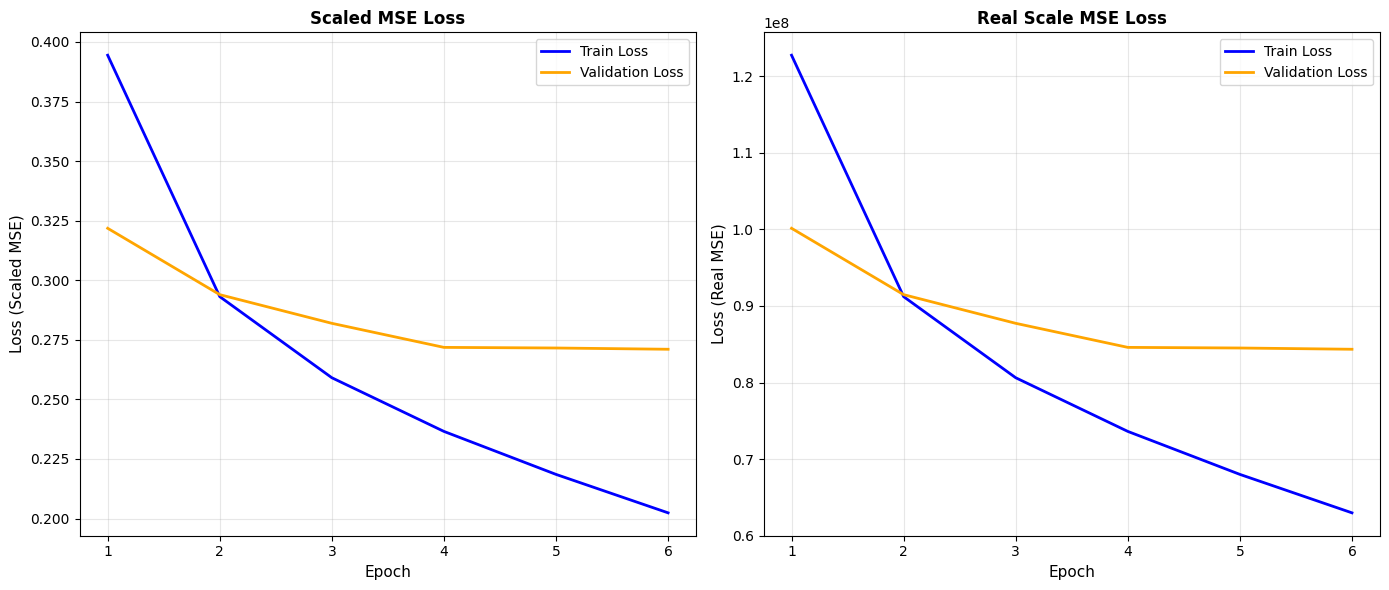

In [ ]:
df = load_data(logger=logger)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
X_train_combined = (X_train["Title"] + " " + X_train["FullDescription"]).tolist()
X_valid_combined = (X_valid["Title"] + " " + X_valid["FullDescription"]).tolist()
X_test_combined = (X_test["Title"] + " " + X_test["FullDescription"]).tolist()
X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
    X_train, X_valid, X_test, y_train, logger=logger
)
y_train_processed, y_valid_processed, y_test_processed, target_scaler = (
    preprocess_target(y_train, y_valid, y_test, logger=logger)
)
embedding_dim = 256
w2v_model = train_word2vec_model(
    X_train_combined,
    vector_size=embedding_dim,
    window=5,
    min_count=20,
    epochs=10,
    logger=logger,
)
vocab_w2v = build_vocab_from_w2v(w2v_model)
logger.info(f"Vocabulary size for w2v model: {len(vocab_w2v)}")
embedding_matrix = create_embedding_matrix_w2v(vocab_w2v, w2v_model, logger=logger)

max_text_length = 320
X_train_seq = [
    text_to_sequence(text, vocab_w2v, max_length=max_text_length)
    for text in X_train_combined
]
X_valid_seq = [
    text_to_sequence(text, vocab_w2v, max_length=max_text_length)
    for text in X_valid_combined
]
X_test_seq = [
    text_to_sequence(text, vocab_w2v, max_length=max_text_length)
    for text in X_test_combined
]

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

cat_hidden_dim = 128
emb_hidden_dim = 256
dropout_prob = 0.3

model = UnfrozenResidualNN(
    vocab_size=len(vocab_w2v),
    embedding_size=embedding_dim,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_dim,
    emb_hidden_size=emb_hidden_dim,
    dropout=dropout_prob,
    num_residual_blocks=2,
).to(device)

loss_fn = "mse"
n_epochs = 20
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "word2vec_e256_mlen320_mf20_base_res_unfroz_tok_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [410]:
all_models_results["ResidualWord2vecModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

##### Simple CNN with Max Pooling

INFO - Starting training for 20 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/20:
INFO -   Train - MSE: 0.3736, Real MSE: 116256041.80, Real RMSE: 10782.21
INFO -   Valid - MSE: 0.2885, Real MSE: 89795437.14, Real RMSE: 9476.05
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.288533
INFO - Epoch 2/20:
INFO -   Train - MSE: 0.2896, Real MSE: 90139291.21, Real RMSE: 9494.17
INFO -   Valid - MSE: 0.2694, Real MSE: 83826691.63, Real RMSE: 9155.69
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.019179 to 0.269354
INFO - Epoch 3/20:
INFO -   Train - MSE: 0.2488, Real MSE: 77441415.54, Real RMSE: 8800.08
INFO -   Valid - MSE: 0.2519, Real MSE: 78405433.51, Real RMSE: 

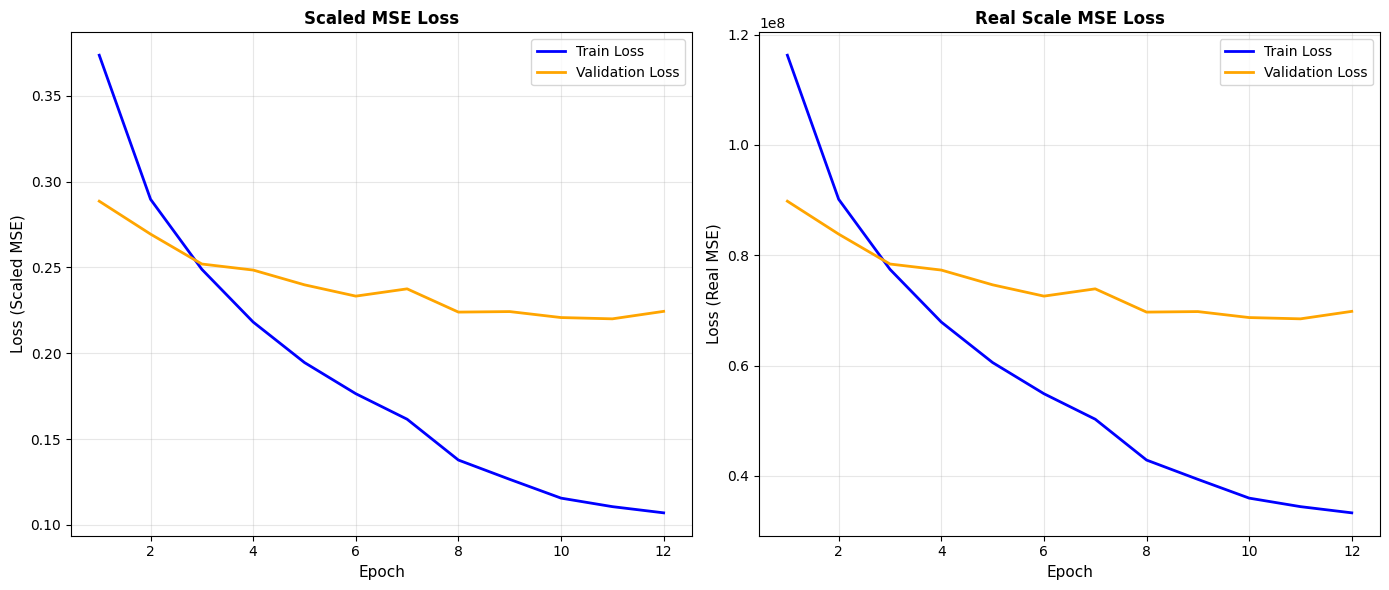

In [ ]:
# df = load_data(logger=logger)
# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )
# embedding_dim = 256
# w2v_model = train_word2vec_model(X_train_combined, vector_size=embedding_dim, window=5, min_count=20, epochs=10, logger=logger)
# vocab_w2v = build_vocab_from_w2v(w2v_model)
# logger.info(f"Vocabulary size for w2v model: {len(vocab_w2v)}")
# embedding_matrix = create_embedding_matrix_w2v(vocab_w2v, w2v_model, logger=logger)

# max_text_length = 320
# X_train_seq = [text_to_sequence(text, vocab_w2v, max_length=max_text_length)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab_w2v, max_length=max_text_length)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab_w2v, max_length=max_text_length)
#               for text in X_test_combined]

# train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
# valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
# test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)

cat_hidden_dim = 128
emb_hidden_dim = 256
dropout_prob = 0.3

model = UnfrozenCNN(
    embedding_matrix=embedding_matrix,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_dim,
    emb_hidden_size=emb_hidden_dim,
    num_filters=64,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 20
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "word2vec_e256_mlen320_mf20_cnn_unfroz_tok_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [413]:
all_models_results["CNNWord2vecModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

##### CNN with Residual connections

INFO - Starting training for 20 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/20:
INFO -   Train - MSE: 0.3490, Real MSE: 108625724.21, Real RMSE: 10422.37
INFO -   Valid - MSE: 0.2899, Real MSE: 90233846.52, Real RMSE: 9499.15
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.289942
INFO - Epoch 2/20:
INFO -   Train - MSE: 0.2588, Real MSE: 80551145.14, Real RMSE: 8975.03
INFO -   Valid - MSE: 0.2557, Real MSE: 79581001.52, Real RMSE: 8920.82
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.034230 to 0.255712
INFO - Epoch 3/20:
INFO -   Train - MSE: 0.2175, Real MSE: 67694793.04, Real RMSE: 8227.68
INFO -   Valid - MSE: 0.2434, Real MSE: 75760382.31, Real RMSE: 

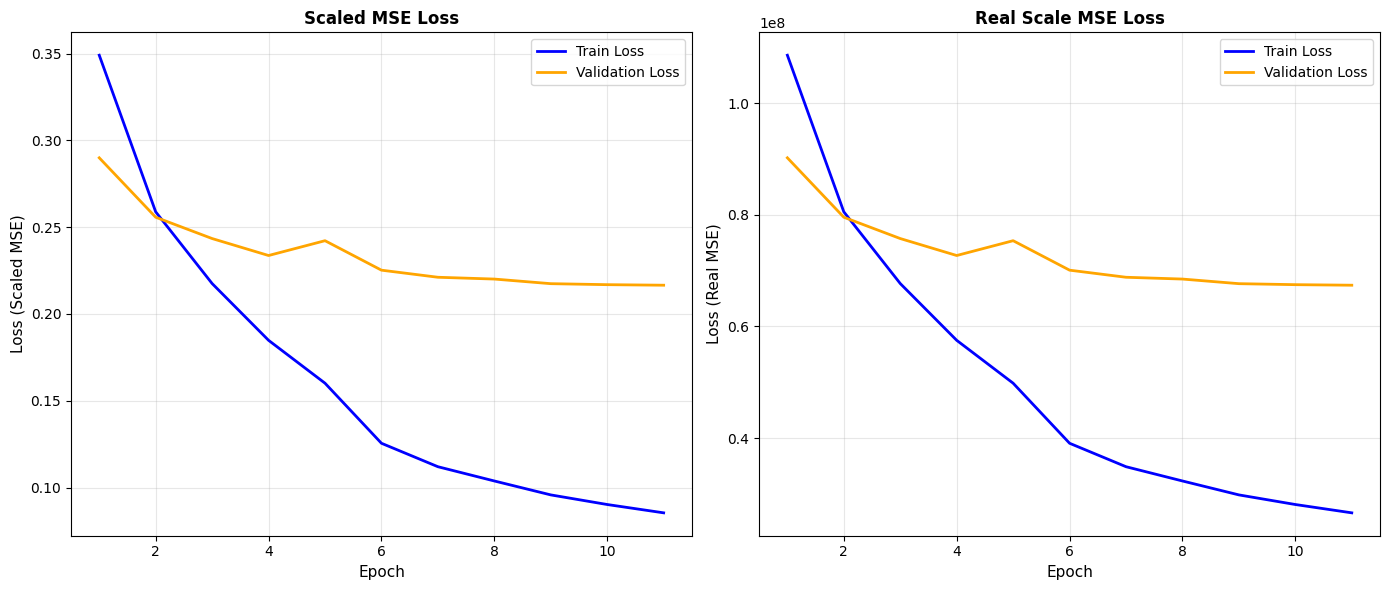

In [ ]:
# df = load_data(logger=logger)
# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)
# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()
# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )
# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )
# embedding_dim = 256
# w2v_model = train_word2vec_model(X_train_combined, vector_size=embedding_dim, window=5, min_count=20, epochs=10, logger=logger)
# vocab_w2v = build_vocab_from_w2v(w2v_model)
# logger.info(f"Vocabulary size for w2v model: {len(vocab_w2v)}")
# embedding_matrix = create_embedding_matrix_w2v(vocab_w2v, w2v_model, logger=logger)

# max_text_length = 320
# X_train_seq = [text_to_sequence(text, vocab_w2v, max_length=max_text_length)
#                for text in X_train_combined]
# X_valid_seq = [text_to_sequence(text, vocab_w2v, max_length=max_text_length)
#                for text in X_valid_combined]
# X_test_seq = [text_to_sequence(text, vocab_w2v, max_length=max_text_length)
#               for text in X_test_combined]

# train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
# valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
# test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g)

cat_hidden_dim = 128
emb_hidden_dim = 256
dropout_prob = 0.3

model = UnfrozenCNNWithResiduals(
    embedding_matrix=embedding_matrix,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_dim,
    emb_hidden_size=emb_hidden_dim,
    num_filters=64,
    dropout=dropout_prob,
).to(device)

loss_fn = "mse"
n_epochs = 20
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [ ]:
model_name = "word2vec_e256_mlen320_mf20_cnn_res_unfroz_tok_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [416]:
all_models_results["CNNResidualWord2vecModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

#### Unfreezed fasttext embedding layer models

##### Base model with residual connections

INFO - Loading fasttext pre-trained embeddings...
INFO - Loaded 999999 words with 300-dimensional vectors
INFO - Starting training for 30 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/30:
INFO -   Train - MSE: 0.3963, Real MSE: 123320412.00, Real RMSE: 11104.97
INFO -   Valid - MSE: 0.3273, Real MSE: 101861005.02, Real RMSE: 10092.62
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.327303
INFO - Epoch 2/30:
INFO -   Train - MSE: 0.2944, Real MSE: 91612299.46, Real RMSE: 9571.43
INFO -   Valid - MSE: 0.2988, Real MSE: 92996131.61, Real RMSE: 9643.45
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.028485 to 0.298818
INFO - Epoch 3/30:
INFO -   Train - MSE: 0.2601

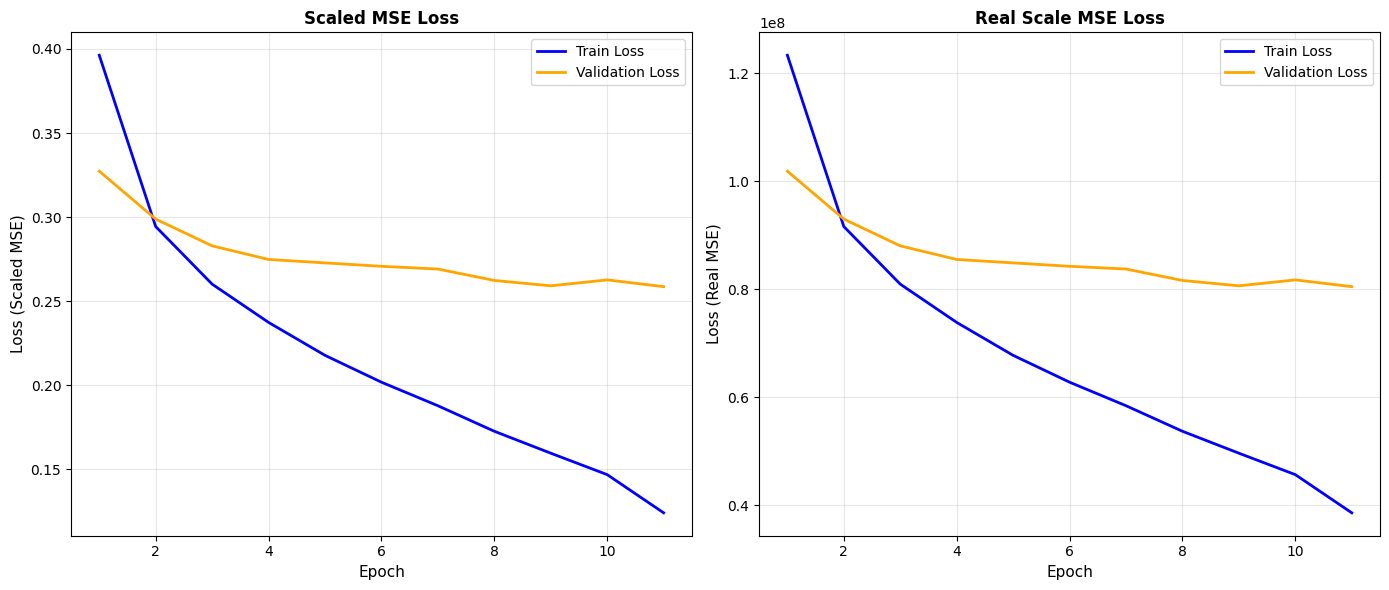

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()

# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )

# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20)

embedding_model = load_pretrained_embeddings("fasttext", logger=logger)

embedding_size = embedding_model.vector_size
embedding_matrix = create_embedding_matrix_from_pretrained(
    vocab, embedding_model, embedding_dim=embedding_size
)

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

cat_hidden_size = 128
emb_hidden_size = 256
dropout_prob = 0.3
model = UnfrozenResidualNN(
    vocab_size=len(vocab),
    embedding_size=embedding_size,
    categorical_dim=X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    emb_hidden_size=emb_hidden_size,
    dropout=dropout_prob,
    num_residual_blocks=2,
).to(device)
loss_fn = "mse"
n_epochs = 30
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [418]:
model_name = "fasttext_e300_mlen320_mf20_res_unfroz_tok_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [419]:
all_models_results["ResidualFasttextModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

##### Simple CNN with Max Pooling 

INFO - Loading fasttext pre-trained embeddings...
INFO - Loaded 999999 words with 300-dimensional vectors
INFO - Starting training for 20 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.5 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/20:
INFO -   Train - MSE: 0.4057, Real MSE: 126252735.80, Real RMSE: 11236.22
INFO -   Valid - MSE: 0.3096, Real MSE: 96363572.98, Real RMSE: 9816.49
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.309638
INFO - Epoch 2/20:
INFO -   Train - MSE: 0.2923, Real MSE: 90962981.22, Real RMSE: 9537.45
INFO -   Valid - MSE: 0.2741, Real MSE: 85317962.66, Real RMSE: 9236.77
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.035492 to 0.274146
INFO - Epoch 3/20:
INFO -   Train - MSE: 0.2442, 

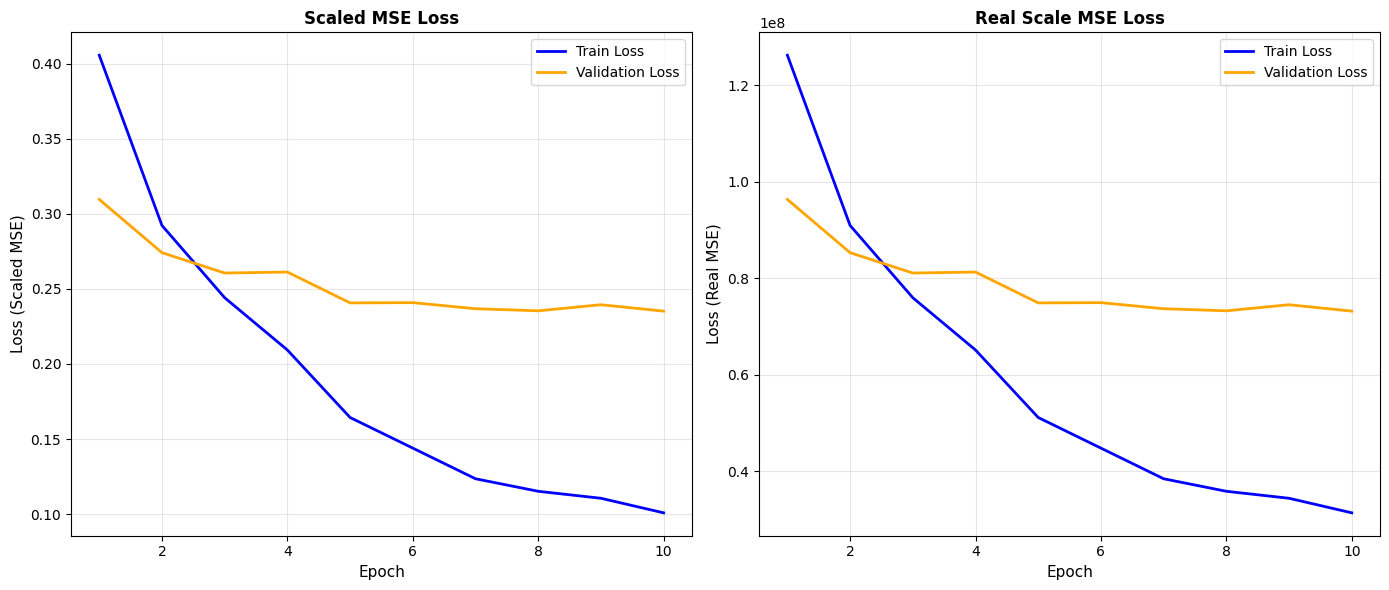

In [ ]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()

# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )

# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20)

embedding_model = load_pretrained_embeddings("fasttext", logger=logger)

embedding_size = embedding_model.vector_size
embedding_matrix = create_embedding_matrix_from_pretrained(
    vocab, embedding_model, embedding_dim=embedding_size
)

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

cat_hidden_size = 128
emb_hidden_size = 256
dropout_prob = 0.3
model = UnfrozenCNN(
    embedding_matrix,
    X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    emb_hidden_size=emb_hidden_size,
    num_filters=64,
    dropout=dropout_prob,
).to(device)
loss_fn = "mse"
n_epochs = 20
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [421]:
model_name = "fasttext_e300_mlen320_mf20_cnn_unfroz_tok_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [422]:
all_models_results["CNNFasttextModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

##### CNN with Residual connections

INFO - Starting training for 20 epochs on device: mps
INFO - Using loss function: mse, optimizer: adam with lr=0.001
INFO - Learning rate scheduler with patience 0 and factor 0.3 enabled.
INFO - Early stopping patience: 2, delta: 0.001
INFO - Real metrics will be computed using target_scaler inverse transform.
INFO - Multi-input architecture detected.
INFO - Epoch 1/20:
INFO -   Train - MSE: 0.3716, Real MSE: 115645945.61, Real RMSE: 10753.88
INFO -   Valid - MSE: 0.3056, Real MSE: 95121649.76, Real RMSE: 9753.03
INFO -   Learning Rate: 0.001000
INFO - Initial validation loss: 0.305648
INFO - Epoch 2/20:
INFO -   Train - MSE: 0.2582, Real MSE: 80345675.22, Real RMSE: 8963.57
INFO -   Valid - MSE: 0.2626, Real MSE: 81718541.90, Real RMSE: 9039.83
INFO -   Learning Rate: 0.001000
INFO - Validation loss improved by 0.043067 to 0.262580
INFO - Epoch 3/20:
INFO -   Train - MSE: 0.2073, Real MSE: 64513284.60, Real RMSE: 8032.02
INFO -   Valid - MSE: 0.2727, Real MSE: 84874682.43, Real RMSE: 

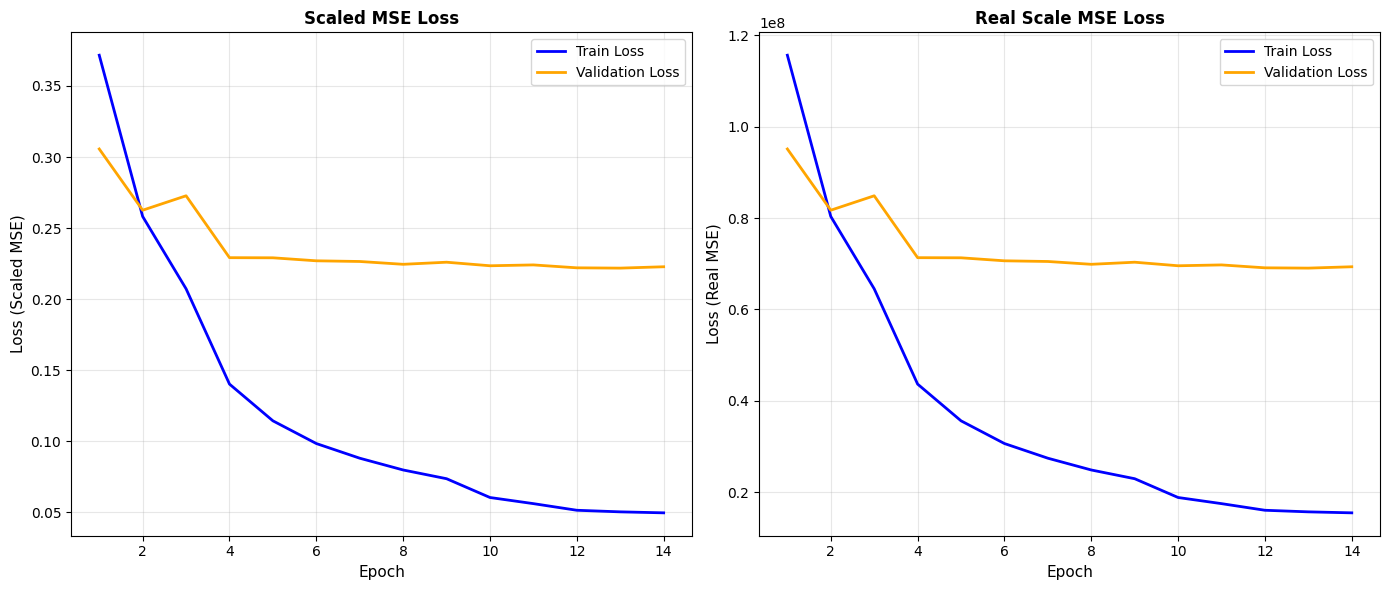

In [423]:
# df = load_data(logger=logger)

# X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, logger=logger)

# X_train_combined = (X_train['Title'] + ' ' + X_train['FullDescription']).tolist()
# X_valid_combined = (X_valid['Title'] + ' ' + X_valid['FullDescription']).tolist()
# X_test_combined = (X_test['Title'] + ' ' + X_test['FullDescription']).tolist()

# X_train_cat, X_valid_cat, X_test_cat, _ = preprocess_categorical_data(
#     X_train, X_valid, X_test, y_train, logger=logger
# )

# y_train_processed, y_valid_processed, y_test_processed, target_scaler = preprocess_target(
#     y_train, y_valid, y_test, logger=logger
# )

# vocab = build_vocab(X_train_combined, min_freq=20)

# embedding_model = load_pretrained_embeddings('fasttext', logger=logger)

# embedding_size = embedding_model.vector_size
# embedding_matrix = create_embedding_matrix_from_pretrained(
#     vocab,
#     embedding_model,
#     embedding_dim=embedding_size
# )

train_dataset = TokensDataset(X_train_seq, X_train_cat, y_train_processed)
valid_dataset = TokensDataset(X_valid_seq, X_valid_cat, y_valid_processed)
test_dataset = TokensDataset(X_test_seq, X_test_cat, y_test_processed)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=g
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=g
)

cat_hidden_size = 128
emb_hidden_size = 256
dropout_prob = 0.35
model = UnfrozenCNNWithResiduals(
    embedding_matrix,
    X_train_cat.shape[1],
    cat_hidden_size=cat_hidden_size,
    emb_hidden_size=emb_hidden_size,
    num_filters=64,
    dropout=dropout_prob,
)
loss_fn = "mse"
n_epochs = 20
lr = 0.001
patience = 2
optimizer_fn = "adam"

model, history, elapsed_time = train_model(
    model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    target_scaler=target_scaler,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.3,
    seed=RANDOM_SEED,
    logger=logger,
    multi_input=True,
    log=False,
)

plot_losses_curves(history, "mse")

In [424]:
model_name = "fasttext_e300_mlen320_mf20_cnn_res_unfroz_tok_chid64_rhid128_dr30_es_2"
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{model_name}.pth"))
test_evaluation_metrics = evaluate_model(
    model,
    test_loader,
    training_time=elapsed_time,
    target_scaler=target_scaler,
    device=device,
    loss_fn_str="mse",
    model_name=model_name,
    results_dict=new_architectures_results,
    log=False,
    multi_input=True,
    logger=logger,
)

INFO - Evaluation metrics stored successfully.


In [425]:
all_models_results["CNNResidualFasttextModelv1"] = collect_model_metrics(
    model=model,
    model_name=model_name,
    history=history,
    test_metrics=new_architectures_results[model_name],
    elapsed_time=elapsed_time,
    loss_fn="mse",
)

### Compare results of new architectures

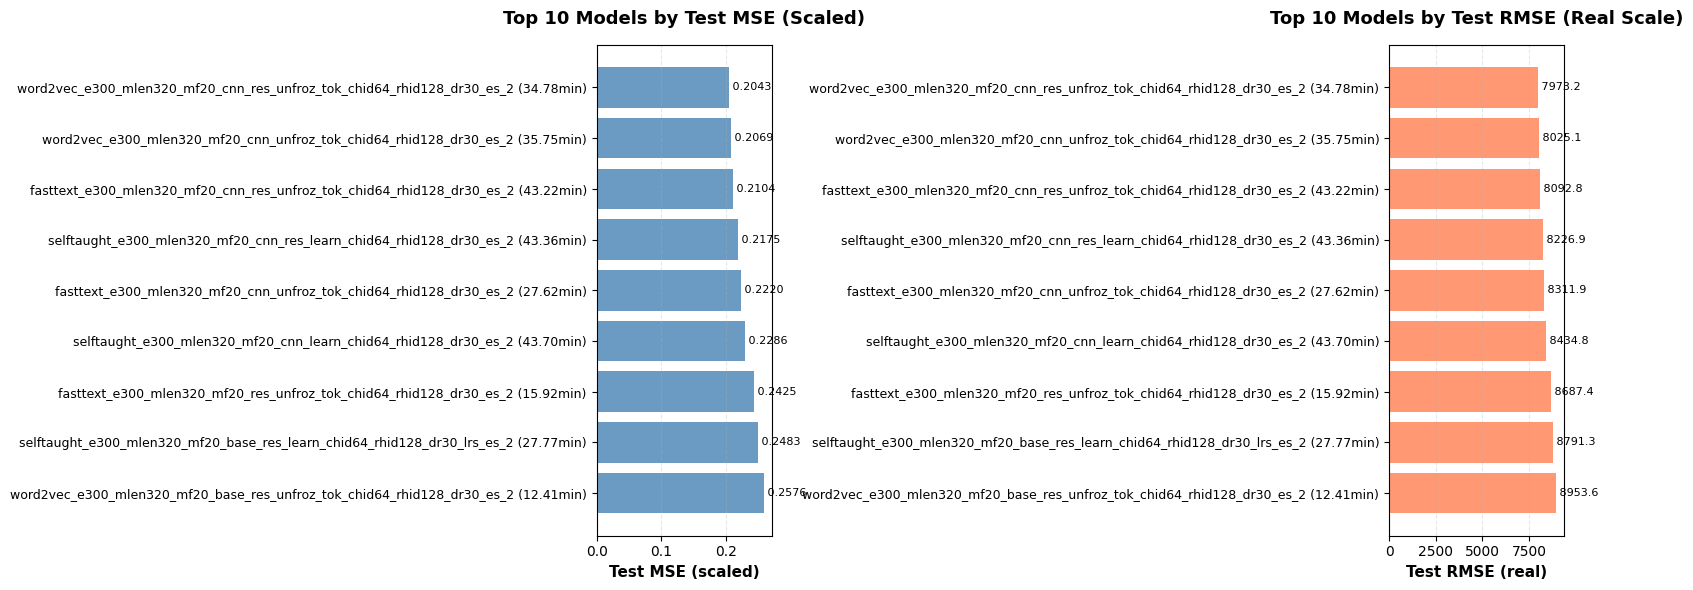

In [426]:
plot_top_models_comparison(new_architectures_results)

### Get all models dataframe

In [54]:
all_models_df = results_to_dataframe(all_models_results)
all_models_df.sort_values(by="Test RMSE")

Model Type  \
46              CNNResidualWord2vecModelv1   
45                      CNNWord2vecModelv1   
49              CNNResidualFasttextModelv1   
43            CNNResidualSelfTaughtModelv1   
48                      CNNFasttextModelv1   
42                    CNNSelfTaughtModelv1   
26                         Word2vecModelv3   
40  SelfTaughtModelOverfittingMitigationv6   
31                       SelfTaughtModelv3   
47                 ResidualFasttextModelv1   
38  SelfTaughtModelOverfittingMitigationv4   
23                       SelfTaughtModelv1   
21                           TfIdfModelv11   
37  SelfTaughtModelOverfittingMitigationv3   
34                       SelfTaughtModelv6   
39  SelfTaughtModelOverfittingMitigationv5   
41               ResidualSelfTaughtModelv1   
32                       SelfTaughtModelv4   
35  SelfTaughtModelOverfittingMitigationv1   
29                         FastTextModelv3   
36  SelfTaughtModelOverfittingMitigationv2   
33                       SelfTaughtModelv5   
30                       SelfTaughtModelv2   
18                            TfIdfModelv8   
44                 ResidualWord2vecModelv1   
22                           TfIdfModelLog   
10                        EmbeddingModelv3   
16                            TfIdfModelv6   
15                            TfIdfModelv5   
12                        EmbeddingModelv5   
24                         Word2vecModelv1   
25                         Word2vecModelv2   
13                            TfIdfModelv3   
6                             TfIdfModelv1   
9                         EmbeddingModelv2   
7                             TfIdfModelv2   
17                            TfIdfModelv7   
8                         EmbeddingModelv1   
14                            TfIdfModelv4   
19                            TfIdfModelv9   
20                           TfIdfModelv10   
27                         FastTextModelv1   
28                         FastTextModelv2   
11                        EmbeddingModelv4   
0                       CategoricalModelv1   
2                       CategoricalModelv3   
5                       CategoricalModelv6   
3                       CategoricalModelv4   
4                       CategoricalModelv5   
1                       CategoricalModelv2   

                                      Full Model Name  Parameters  \
46  word2vec_e256_mlen320_mf20_cnn_res_unfroz_tok_...     6184961   
45  word2vec_e256_mlen320_mf20_cnn_unfroz_tok_chid...     6007105   
49  fasttext_e300_mlen320_mf20_cnn_res_unfroz_tok_...     7202197   
43  selftaught_e300_mlen320_mf20_cnn_res_learn_chi...     7221461   
48  fasttext_e300_mlen320_mf20_cnn_unfroz_tok_chid...     7024341   
42  selftaught_e300_mlen320_mf20_cnn_learn_chid64_...     7024341   
26  word2vec_e256_mlen320_mf20_base_unfroz_tok_chi...     6006913   
40  selftaught_e256_mlen320_mf20_base_learn_chid64...     6006913   
31  selftaught_e300_mlen320_mf20_base_learn_chid12...     7026965   
47  fasttext_e300_mlen320_mf20_res_unfroz_tok_chid...     7252757   
38  selftaught_e256_mlen320_mf10_base_learn_chid64...     8797313   
23  selftaught_e256_mlen320_mf20_base_learn_chid12...     6006913   
21  tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_n...      269697   
37  selftaught_e256_mlen320_mf20_base_learn_chid64...     6006913   
34  selftaught_e256_mlen250_mf20_base_learn_chid12...     6006913   
39  selftaught_e256_mlen320_mf10_base_learn_chid64...     6006913   
41  selftaught_e300_mlen320_mf20_base_res_learn_ch...     7252757   
32  selftaught_e128_mlen320_mf20_base_learn_chid12...     3039489   
35  selftaught_e300_mlen320_mf20_base_learn_chid12...     6006913   
29  fasttext_e300_mlen320_mf20_base_unfroz_tok_chi...     7026965   
36  selftaught_e256_mlen320_mf20_base_learn_chid64...     5921729   
33  selftaught_e300_mlen320_mf15_base_learn_chid12...     3530497   
30  selftaught_e256_mlen320_mf20_base_learn_chid12...     5768321   
18     tfidf_800_50_int_unk_b

In [ ]:
all_models_df.to_csv(os.path.join(REPORTS_DIR, "all_models_results.csv"), index=False)

## Analysis of top 10 best models by Test RMSE

In [93]:
all_models_df

Model Type  \
0                       CategoricalModelv1   
1                       CategoricalModelv2   
2                       CategoricalModelv3   
3                       CategoricalModelv4   
4                       CategoricalModelv5   
5                       CategoricalModelv6   
6                             TfIdfModelv1   
7                             TfIdfModelv2   
8                         EmbeddingModelv1   
9                         EmbeddingModelv2   
10                        EmbeddingModelv3   
11                        EmbeddingModelv4   
12                        EmbeddingModelv5   
13                            TfIdfModelv3   
14                            TfIdfModelv4   
15                            TfIdfModelv5   
16                            TfIdfModelv6   
17                            TfIdfModelv7   
18                            TfIdfModelv8   
19                            TfIdfModelv9   
20                           TfIdfModelv10   
21                           TfIdfModelv11   
22                           TfIdfModelLog   
23                       SelfTaughtModelv1   
24                         Word2vecModelv1   
25                         Word2vecModelv2   
26                         Word2vecModelv3   
27                         FastTextModelv1   
28                         FastTextModelv2   
29                         FastTextModelv3   
30                       SelfTaughtModelv2   
31                       SelfTaughtModelv3   
32                       SelfTaughtModelv4   
33                       SelfTaughtModelv5   
34                       SelfTaughtModelv6   
35  SelfTaughtModelOverfittingMitigationv1   
36  SelfTaughtModelOverfittingMitigationv2   
37  SelfTaughtModelOverfittingMitigationv3   
38  SelfTaughtModelOverfittingMitigationv4   
39  SelfTaughtModelOverfittingMitigationv5   
40  SelfTaughtModelOverfittingMitigationv6   
41               ResidualSelfTaughtModelv1   
42                    CNNSelfTaughtModelv1   
43            CNNResidualSelfTaughtModelv1   
44                 ResidualWord2vecModelv1   
45                      CNNWord2vecModelv1   
46              CNNResidualWord2vecModelv1   
47                 ResidualFasttextModelv1   
48                      CNNFasttextModelv1   
49              CNNResidualFasttextModelv1   

                                      Full Model Name  Parameters  \
0                cat_unk_bs32_adam_lrs_no_hid128_dr20       13185   
1                 cat_mf_bs32_adam_lrs_no_hid128_dr20       12929   
2                cat_unk_bs64_adam_lrs_no_hid128_dr20       13185   
3                 cat_unk_bs64_adam_lrs_no_hid64_dr20        4545   
4                 cat_unk_bs64_sgd_lrs_no_hid128_dr20       13185   
5                   cat_unk_bs64_adam_lrs_hid128_dr20       13185   
6    tfidf_800_50_sr_unk_bs64_adam_lrs_no_hid128_dr30      122113   
7   tfidf_800_50_srbn_unk_bs64_adam_lrs_no_hid128_...      122497   
8             emb_sr_unk_bs64_adam_lrs_no_hid128_dr30      111617   
9           emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30      112001   
10           emb_int_unk_bs64_adam_lrs_no_hid256_dr30      248705   
11  emb_int_unk_bs64_adam_lrs_no_hid256_dr30_batch...      248705   
12         emb_multi_unk_bs64_adam_lrs_no_hid256_dr30      264609   
13  tfidf_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30      269697   
14  tfidf_800_50_multi_unk_bs64_adam_lrs_no_hid256...      129697   
15   tfidf_800_50_int_mf_bs64_adam_lrs_no_hid256_dr30      269697   
16   tfidf_800_50_int_mf_bs64_adam_lrs_no_hid256_dr30       59201   
17  tfidf_800_50_int_unk_bs64_adam_lrs_no_hid128_dr30      124609   
18     tfidf_800_50_int_unk_bs64_adam_lrs_hid256_dr30      269697   
19   tfidf_800_50_int_unk_bs64_sgd_lrs_no_hid256_dr30      269697   
20  tfidf_svd_200_10_int_unk_bs64_adam_lrs_no_hid2...      105857   
21  tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_n...      269697   
22  tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_h...      269697   
23  selftaught_e256_mlen320_m

In [52]:
all_models_df = pd.read_csv(os.path.join(REPORTS_DIR, "all_models_results.csv"))
df_top_models = all_models_df.sort_values(by="Test RMSE").head(10)
df_top_models

Model Type  \
46              CNNResidualWord2vecModelv1   
45                      CNNWord2vecModelv1   
49              CNNResidualFasttextModelv1   
43            CNNResidualSelfTaughtModelv1   
48                      CNNFasttextModelv1   
42                    CNNSelfTaughtModelv1   
26                         Word2vecModelv3   
40  SelfTaughtModelOverfittingMitigationv6   
31                       SelfTaughtModelv3   
47                 ResidualFasttextModelv1   

                                      Full Model Name  Parameters  \
46  word2vec_e256_mlen320_mf20_cnn_res_unfroz_tok_...     6184961   
45  word2vec_e256_mlen320_mf20_cnn_unfroz_tok_chid...     6007105   
49  fasttext_e300_mlen320_mf20_cnn_res_unfroz_tok_...     7202197   
43  selftaught_e300_mlen320_mf20_cnn_res_learn_chi...     7221461   
48  fasttext_e300_mlen320_mf20_cnn_unfroz_tok_chid...     7024341   
42  selftaught_e300_mlen320_mf20_cnn_learn_chid64_...     7024341   
26  word2vec_e256_mlen320_mf20_base_unfroz_tok_chi...     6006913   
40  selftaught_e256_mlen320_mf20_base_learn_chid64...     6006913   
31  selftaught_e300_mlen320_mf20_base_learn_chid12...     7026965   
47  fasttext_e300_mlen320_mf20_res_unfroz_tok_chid...     7252757   

    Training Time (min)  Time per Epoch (s)  Epochs  Best Epoch  Train RMSE  \
46                34.78              189.71      11           9     5156.61   
45                35.75              178.75      12          10     5867.47   
49                43.22              185.21      14          12     3960.91   
43                43.36              173.45      15          13     6150.07   
48                27.62              165.71      10           8     5602.41   
42                43.70              174.81      15          13     7114.90   
26                13.87               55.48      15          12     6401.42   
40                10.04               54.76      11           9     7441.70   
31                18.89               59.65      19          16     6699.15   
47                15.92               86.83      11           9     6215.43   

    Valid RMSE    Test RMSE  
46     8209.49  7973.180176  
45     8274.66  8025.100098  
49     8309.10  8092.770020  
43     8362.97  8226.889648  
48     8555.85  8311.879883  
42     8693.72  8434.769531  
26     8879.48  8518.160156  
40     8917.52  8608.959961  
31     8966.30  8656.929688  
47     8971.63  8687.389648

### Performance metric comparison

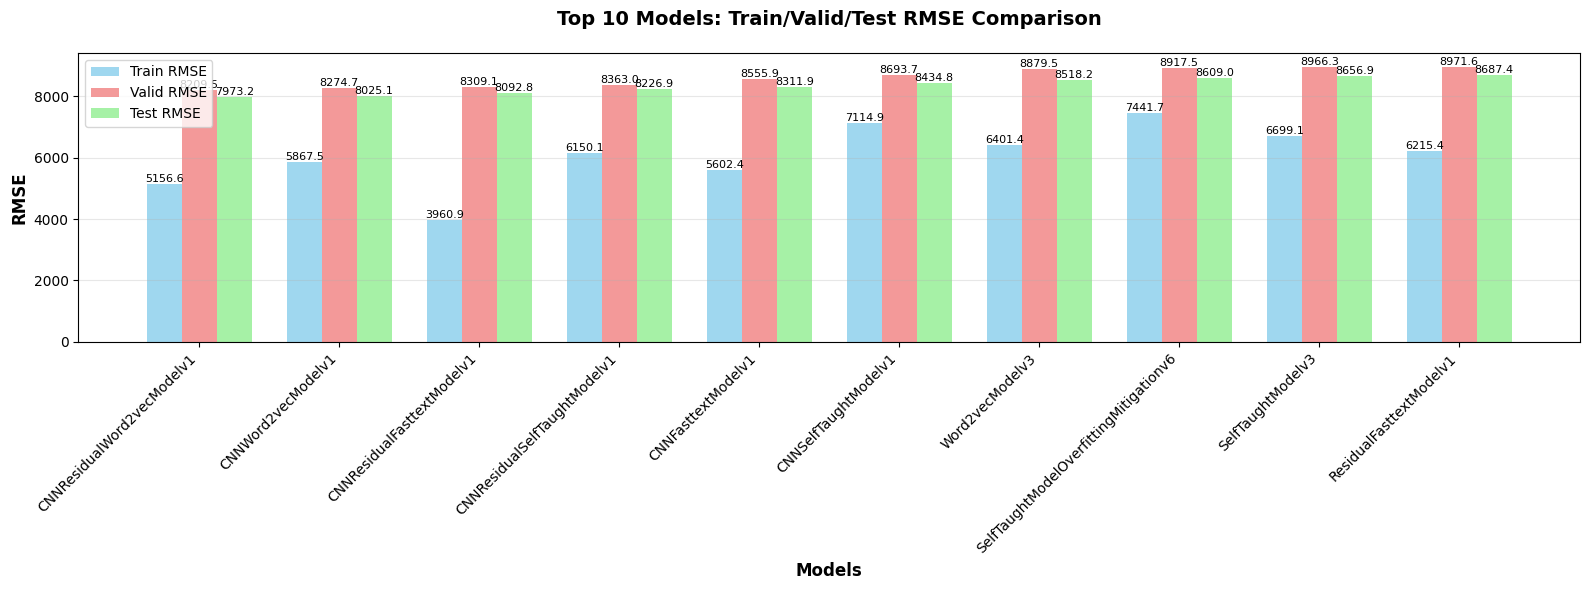

In [55]:
colors = sns.color_palette("husl", 10)
plt.figure(figsize=(16, 6))

x = np.arange(len(df_top_models))
width = 0.25

plt.bar(
    x - width,
    df_top_models["Train RMSE"],
    width,
    label="Train RMSE",
    alpha=0.8,
    color="skyblue",
)
plt.bar(
    x,
    df_top_models["Valid RMSE"],
    width,
    label="Valid RMSE",
    alpha=0.8,
    color="lightcoral",
)
plt.bar(
    x + width,
    df_top_models["Test RMSE"],
    width,
    label="Test RMSE",
    alpha=0.8,
    color="lightgreen",
)

plt.xlabel("Models", fontsize=12, fontweight="bold")
plt.ylabel("RMSE", fontsize=12, fontweight="bold")
plt.title(
    "Top 10 Models: Train/Valid/Test RMSE Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xticks(x, df_top_models["Model Type"], rotation=45, ha="right")
plt.legend(fontsize=10)
plt.grid(axis="y", alpha=0.3)

for i, (train, valid, test) in enumerate(
    zip(
        df_top_models["Train RMSE"],
        df_top_models["Valid RMSE"],
        df_top_models["Test RMSE"],
    )
):
    plt.text(i - width, train, f"{train:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i, valid, f"{valid:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i + width, test, f"{test:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

### Model parameters comparison

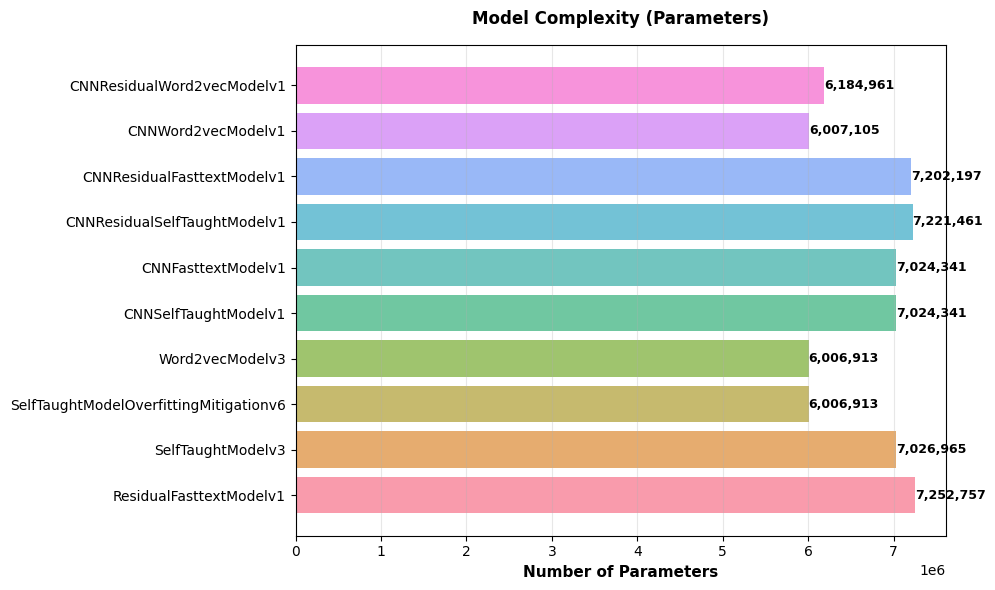

In [56]:
plt.figure(figsize=(10, 6))

df_plot = df_top_models.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

### Training time comparison

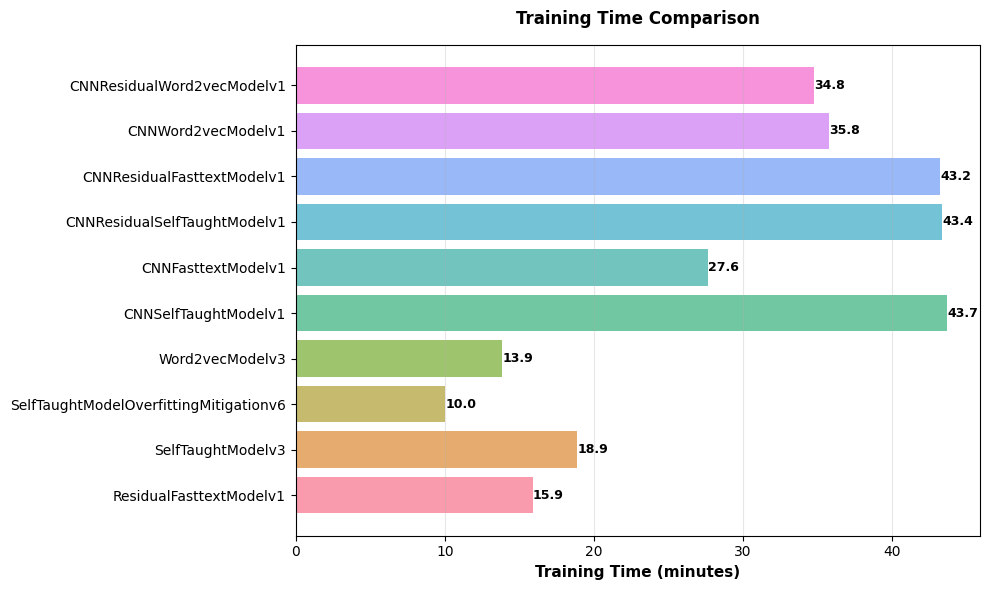

In [57]:
plt.figure(figsize=(10, 6))

df_plot = df_top_models.sort_values("Test RMSE", ascending=False)
bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

### Overfitting analysis

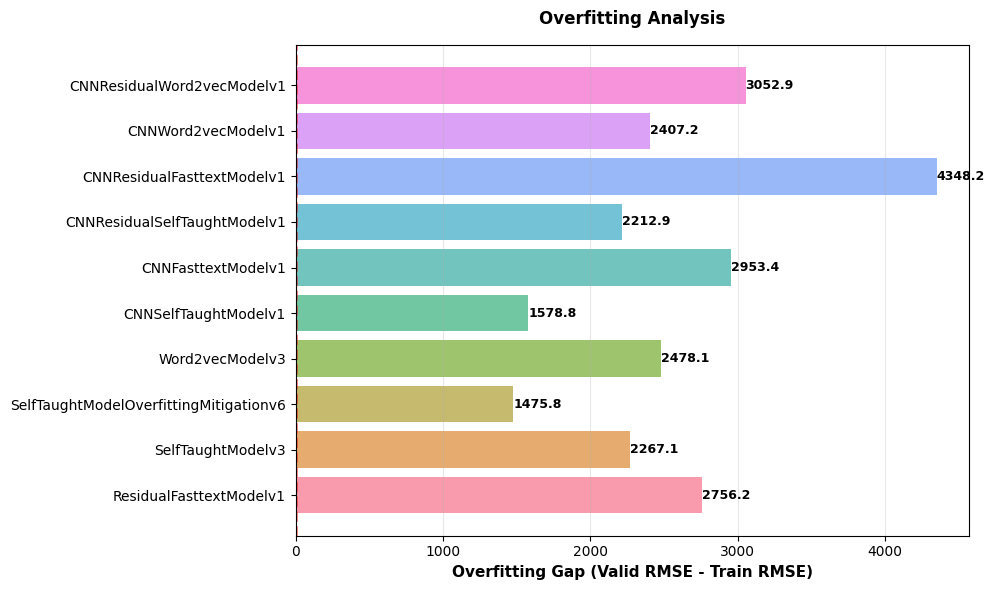

In [58]:
plt.figure(figsize=(10, 6))

df_top_models["Overfit Gap"] = df_top_models["Valid RMSE"] - df_top_models["Train RMSE"]
df_plot = df_top_models.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

## Additional plots for reports

### Categorical models

In [59]:
df_cat = all_models_df[all_models_df["Model Type"].str.contains("CategoricalModel")]
df_cat = df_cat.sort_values(by="Test RMSE")

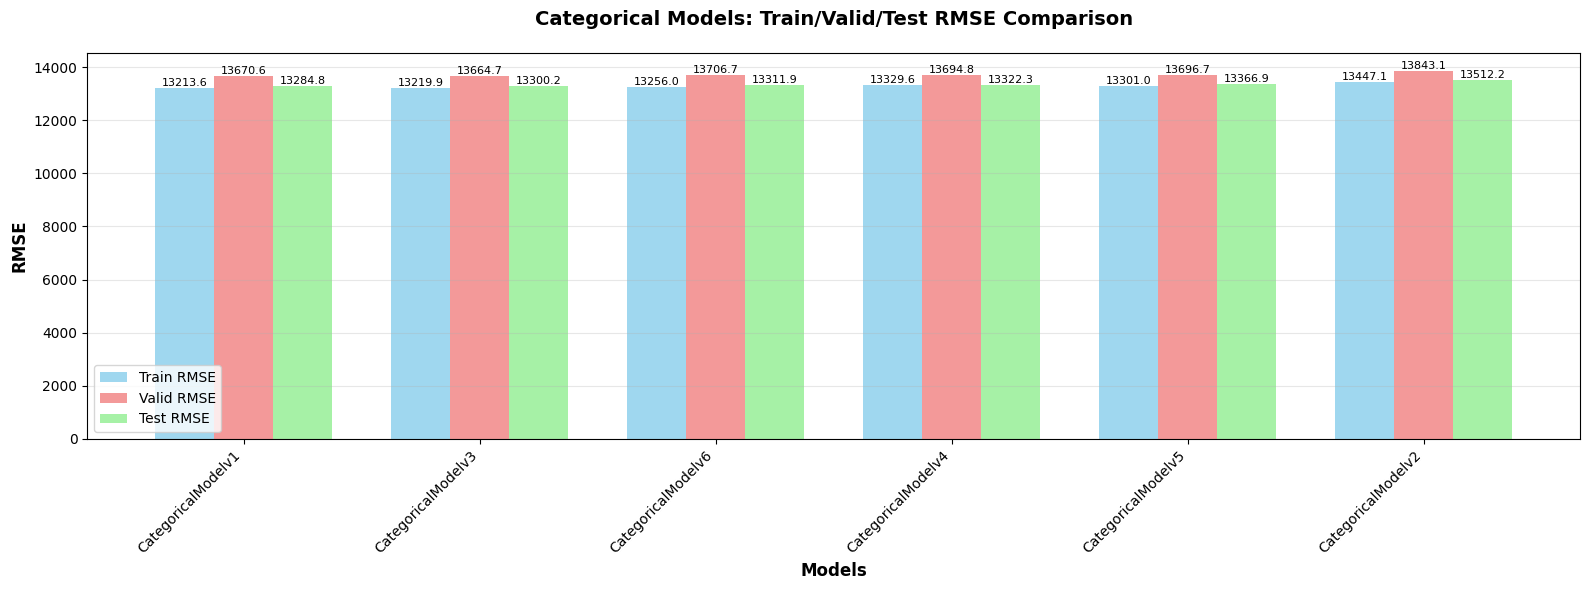

In [60]:
plt.figure(figsize=(16, 6))

x = np.arange(len(df_cat))
width = 0.25

plt.bar(
    x - width,
    df_cat["Train RMSE"],
    width,
    label="Train RMSE",
    alpha=0.8,
    color="skyblue",
)
plt.bar(
    x, df_cat["Valid RMSE"], width, label="Valid RMSE", alpha=0.8, color="lightcoral"
)
plt.bar(
    x + width,
    df_cat["Test RMSE"],
    width,
    label="Test RMSE",
    alpha=0.8,
    color="lightgreen",
)

plt.xlabel("Models", fontsize=12, fontweight="bold")
plt.ylabel("RMSE", fontsize=12, fontweight="bold")
plt.title(
    "Categorical Models: Train/Valid/Test RMSE Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xticks(x, df_cat["Model Type"], rotation=45, ha="right")
plt.legend(fontsize=10)
plt.grid(axis="y", alpha=0.3)

for i, (train, valid, test) in enumerate(
    zip(df_cat["Train RMSE"], df_cat["Valid RMSE"], df_cat["Test RMSE"])
):
    plt.text(i - width, train, f"{train:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i, valid, f"{valid:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i + width, test, f"{test:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

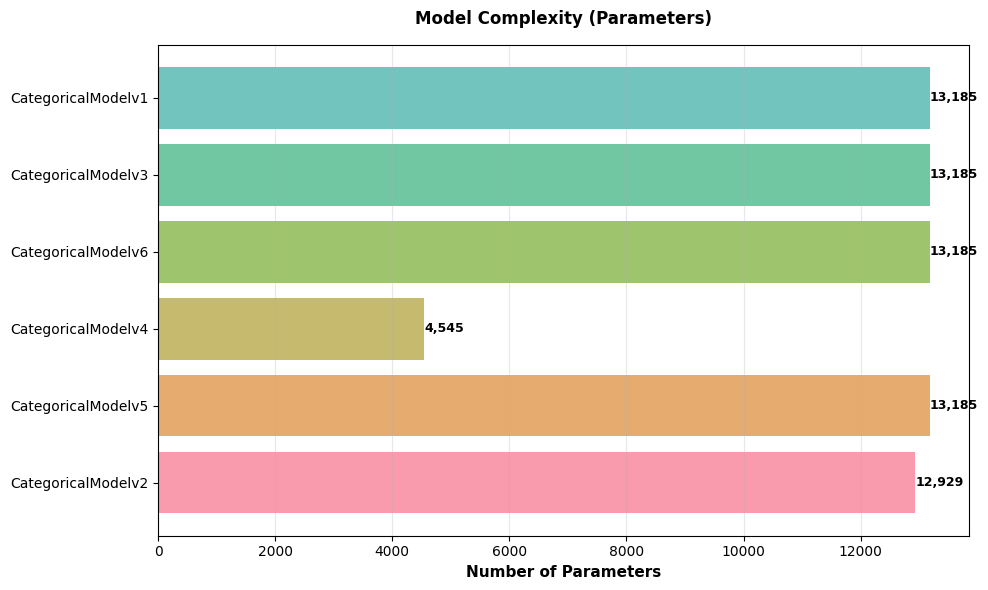

In [61]:
plt.figure(figsize=(10, 6))

df_plot = df_cat.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

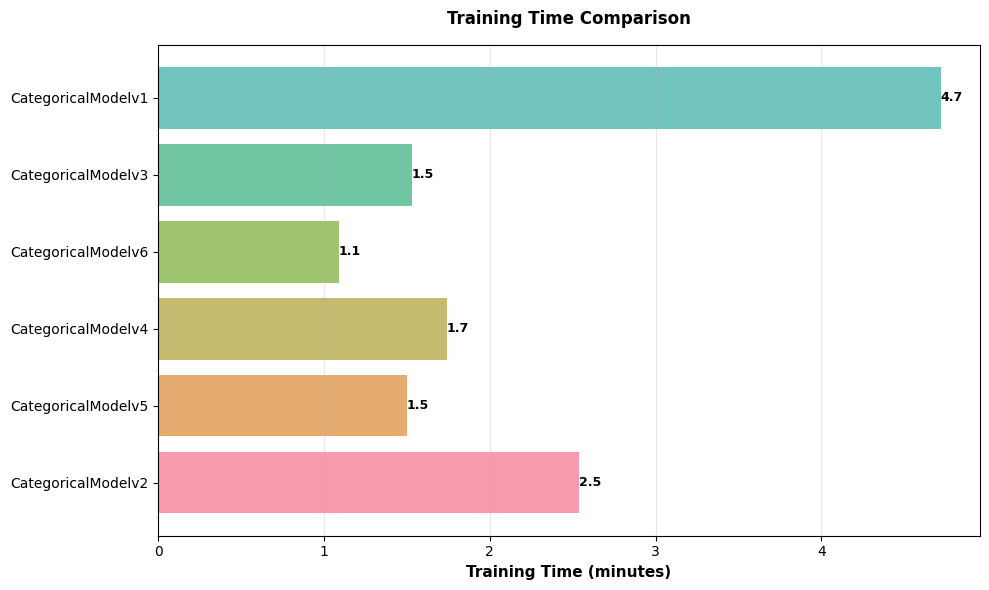

In [62]:
plt.figure(figsize=(10, 6))

bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

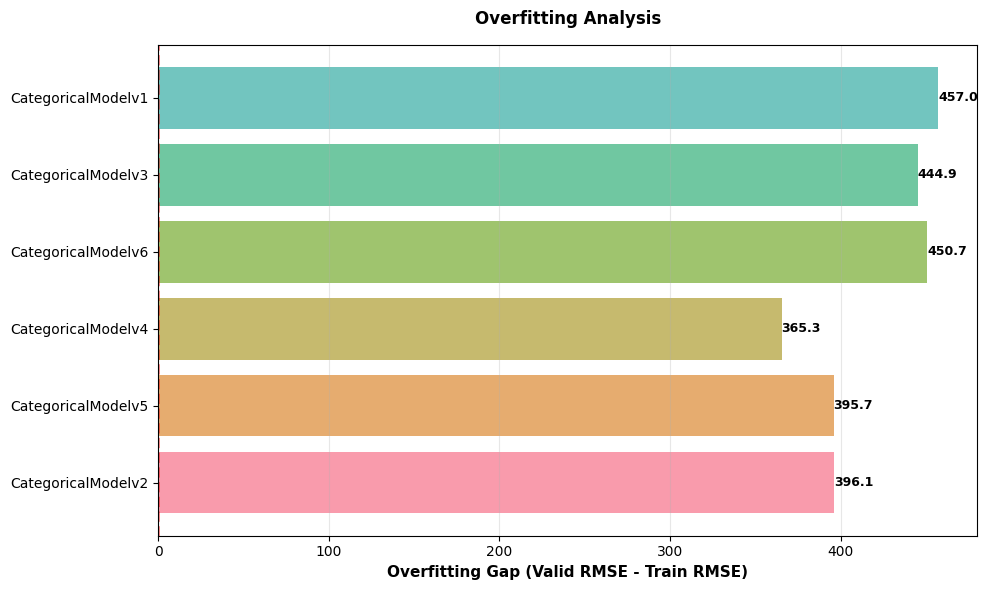

In [63]:
plt.figure(figsize=(10, 6))

df_cat["Overfit Gap"] = df_cat["Valid RMSE"] - df_cat["Train RMSE"]
df_plot = df_cat.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

### TF-IDF models

In [64]:
df_tfidf = all_models_df[all_models_df["Model Type"].str.contains("Tf")]
df_tfidf = df_tfidf.sort_values(by="Test RMSE")

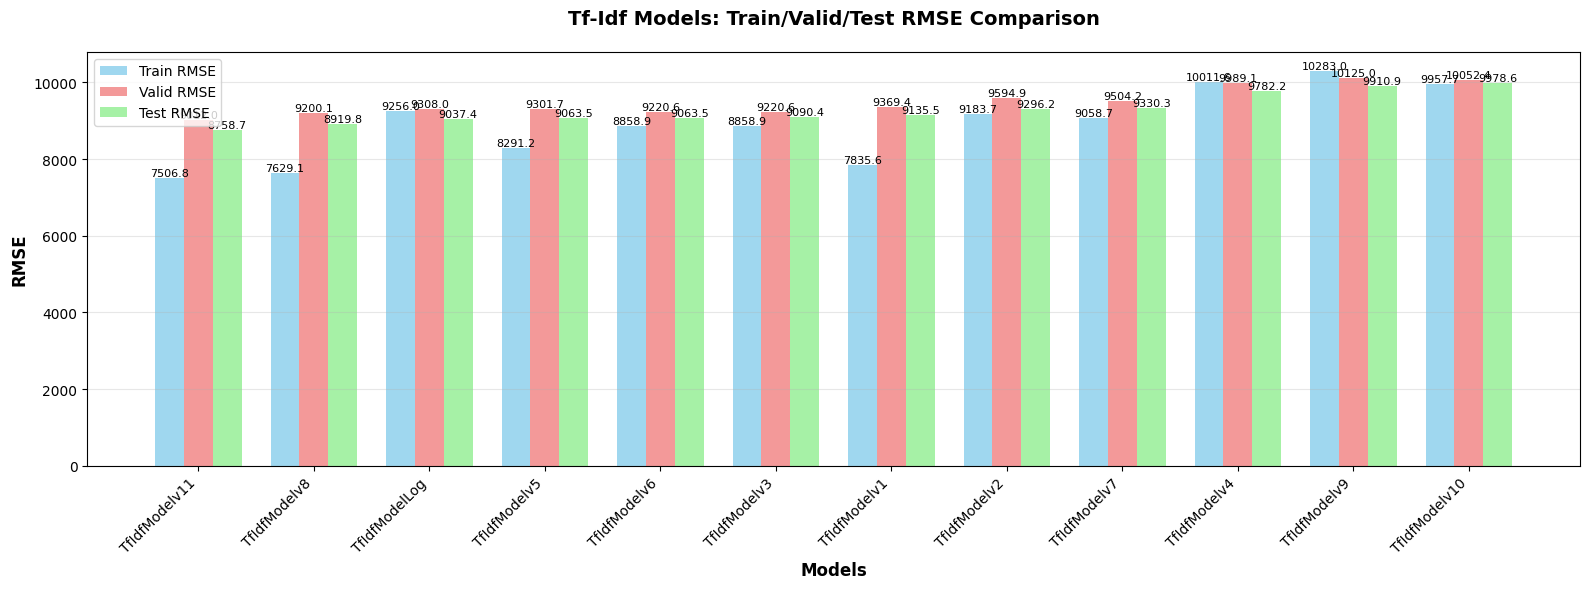

In [65]:
plt.figure(figsize=(16, 6))

x = np.arange(len(df_tfidf))
width = 0.25

plt.bar(
    x - width,
    df_tfidf["Train RMSE"],
    width,
    label="Train RMSE",
    alpha=0.8,
    color="skyblue",
)
plt.bar(
    x, df_tfidf["Valid RMSE"], width, label="Valid RMSE", alpha=0.8, color="lightcoral"
)
plt.bar(
    x + width,
    df_tfidf["Test RMSE"],
    width,
    label="Test RMSE",
    alpha=0.8,
    color="lightgreen",
)

plt.xlabel("Models", fontsize=12, fontweight="bold")
plt.ylabel("RMSE", fontsize=12, fontweight="bold")
plt.title(
    "Tf-Idf Models: Train/Valid/Test RMSE Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xticks(x, df_tfidf["Model Type"], rotation=45, ha="right")
plt.legend(fontsize=10)
plt.grid(axis="y", alpha=0.3)

for i, (train, valid, test) in enumerate(
    zip(df_tfidf["Train RMSE"], df_tfidf["Valid RMSE"], df_tfidf["Test RMSE"])
):
    plt.text(i - width, train, f"{train:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i, valid, f"{valid:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i + width, test, f"{test:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

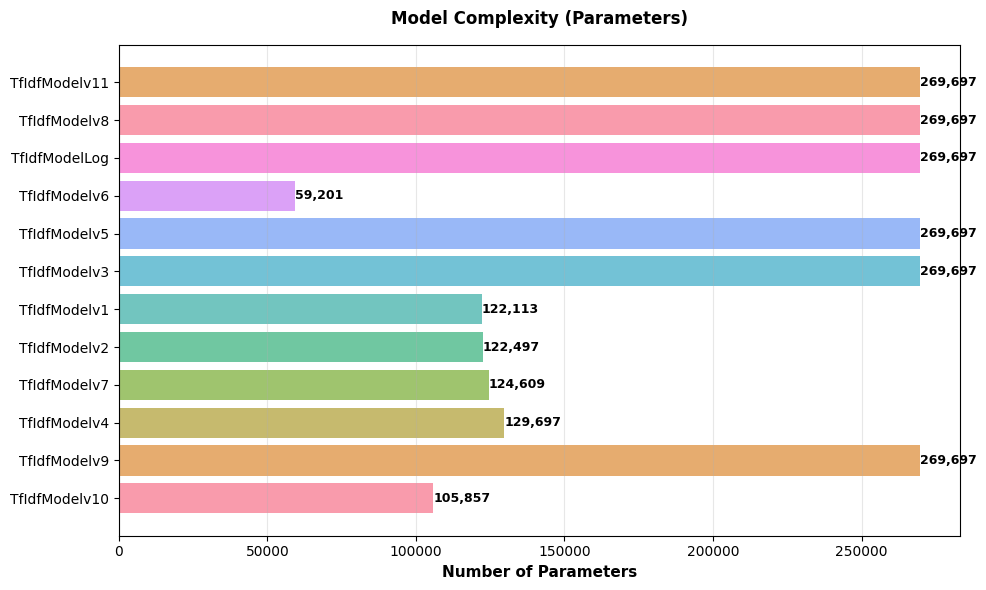

In [66]:
plt.figure(figsize=(10, 6))

df_plot = df_tfidf.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

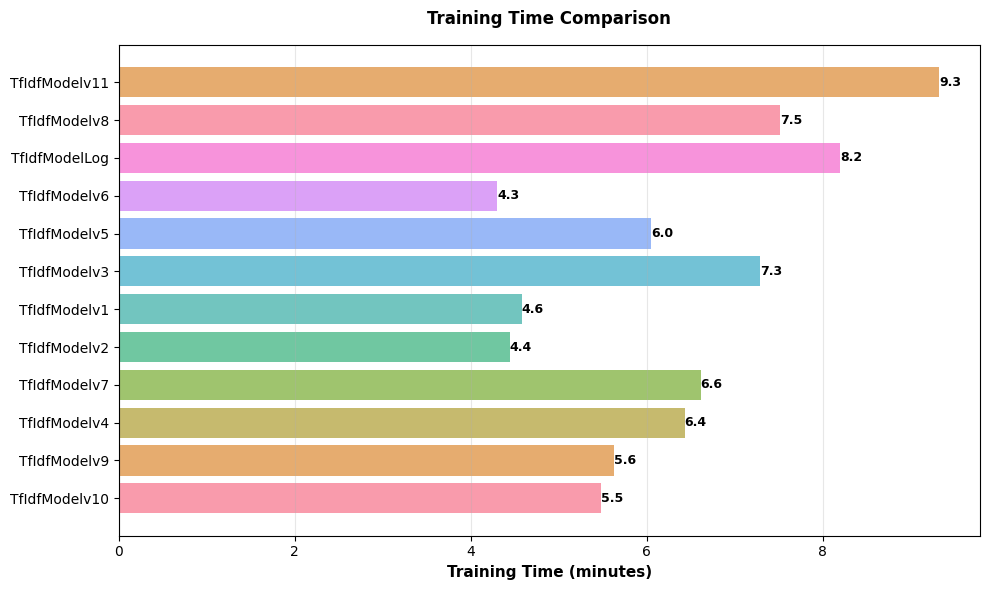

In [67]:
plt.figure(figsize=(10, 6))

bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

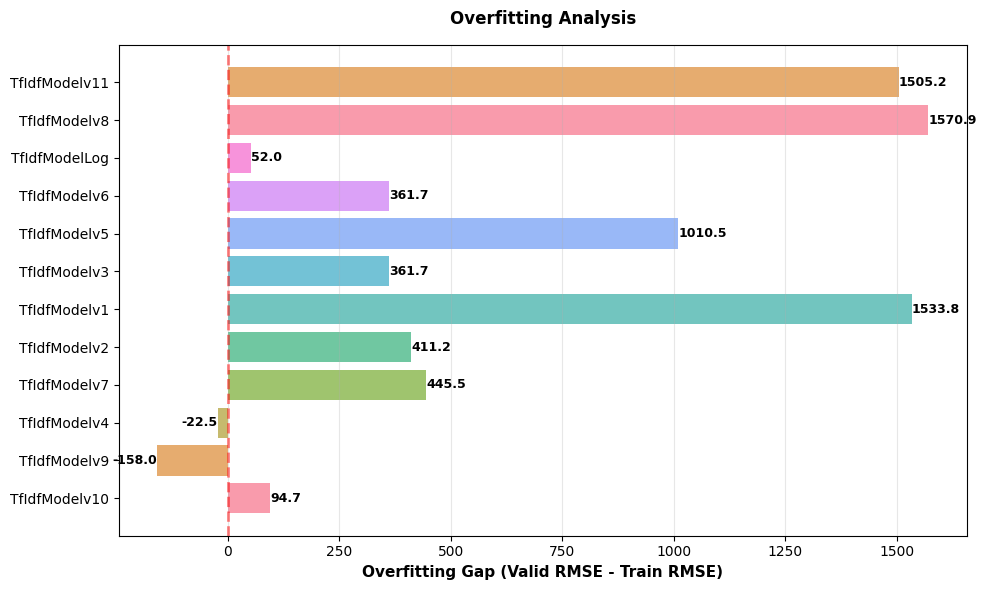

In [68]:
plt.figure(figsize=(10, 6))

df_tfidf["Overfit Gap"] = df_tfidf["Valid RMSE"] - df_tfidf["Train RMSE"]
df_plot = df_tfidf.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

In [69]:
df_sent_emb = all_models_df[all_models_df["Model Type"].str.contains("Embed")]
df_sent_emb = df_sent_emb.sort_values(by="Test RMSE")
df_sent_emb

Model Type                                    Full Model Name  \
10  EmbeddingModelv3           emb_int_unk_bs64_adam_lrs_no_hid256_dr30   
12  EmbeddingModelv5         emb_multi_unk_bs64_adam_lrs_no_hid256_dr30   
9   EmbeddingModelv2          emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30   
8   EmbeddingModelv1            emb_sr_unk_bs64_adam_lrs_no_hid128_dr30   
11  EmbeddingModelv4  emb_int_unk_bs64_adam_lrs_no_hid256_dr30_batch...   

    Parameters  Training Time (min)  Time per Epoch (s)  Epochs  Best Epoch  \
10      248705                 5.58               23.91      14          11   
12      264609                10.79               35.97      18          15   
9       112001                 6.56               19.69      20          17   
8       111617                 2.58               14.06      11           8   
11      248705                 2.91               21.83       8           5   

    Train RMSE  Valid RMSE     Test RMSE  
10     8986.65     9271.01   9051.860000  
12     8858.86     9220.58   9075.089844  
9      9092.38     9366.19   9176.470000  
8      9309.08     9643.54   9384.850000  
11    10163.93     9905.69  10694.220000

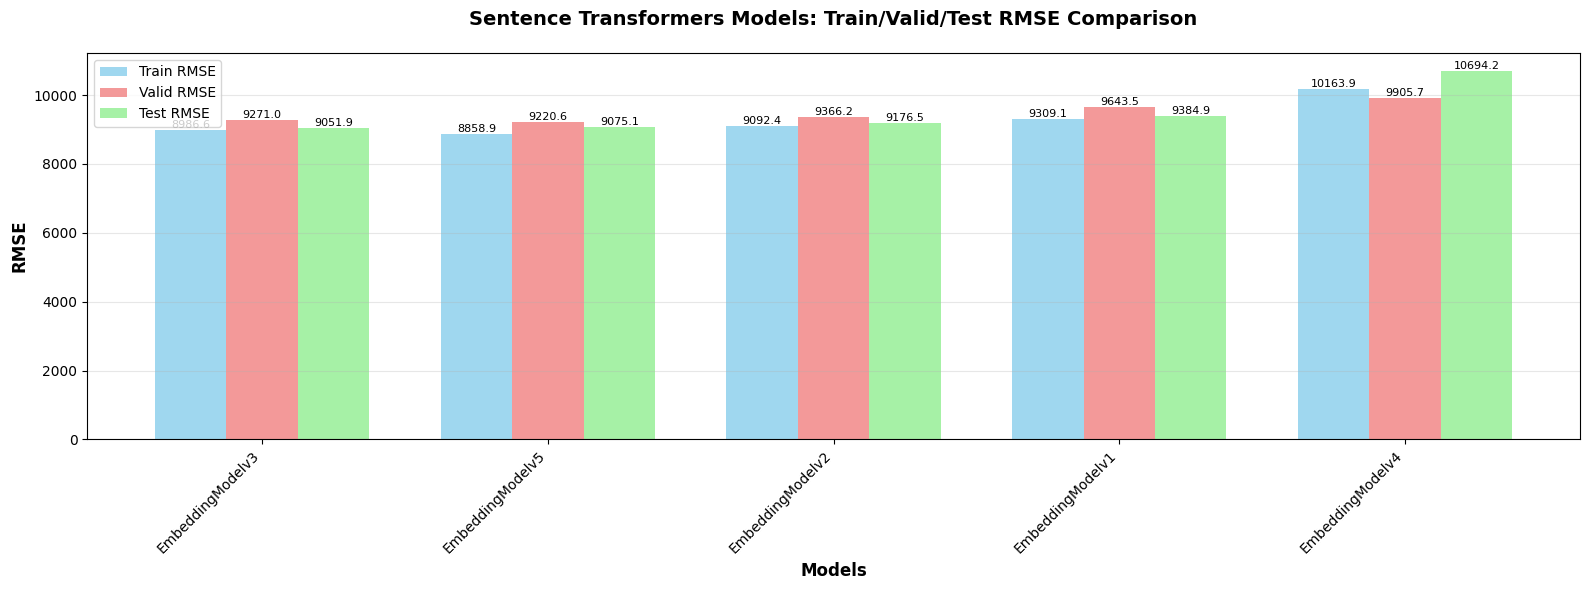

In [70]:
plt.figure(figsize=(16, 6))

x = np.arange(len(df_sent_emb))
width = 0.25

plt.bar(
    x - width,
    df_sent_emb["Train RMSE"],
    width,
    label="Train RMSE",
    alpha=0.8,
    color="skyblue",
)
plt.bar(
    x, df_sent_emb["Valid RMSE"], width, label="Valid RMSE", alpha=0.8, color="lightcoral"
)
plt.bar(
    x + width,
    df_sent_emb["Test RMSE"],
    width,
    label="Test RMSE",
    alpha=0.8,
    color="lightgreen",
)

plt.xlabel("Models", fontsize=12, fontweight="bold")
plt.ylabel("RMSE", fontsize=12, fontweight="bold")
plt.title(
    "Sentence Transformers Models: Train/Valid/Test RMSE Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xticks(x, df_sent_emb["Model Type"], rotation=45, ha="right")
plt.legend(fontsize=10)
plt.grid(axis="y", alpha=0.3)

for i, (train, valid, test) in enumerate(
    zip(df_sent_emb["Train RMSE"], df_sent_emb["Valid RMSE"], df_sent_emb["Test RMSE"])
):
    plt.text(i - width, train, f"{train:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i, valid, f"{valid:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i + width, test, f"{test:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

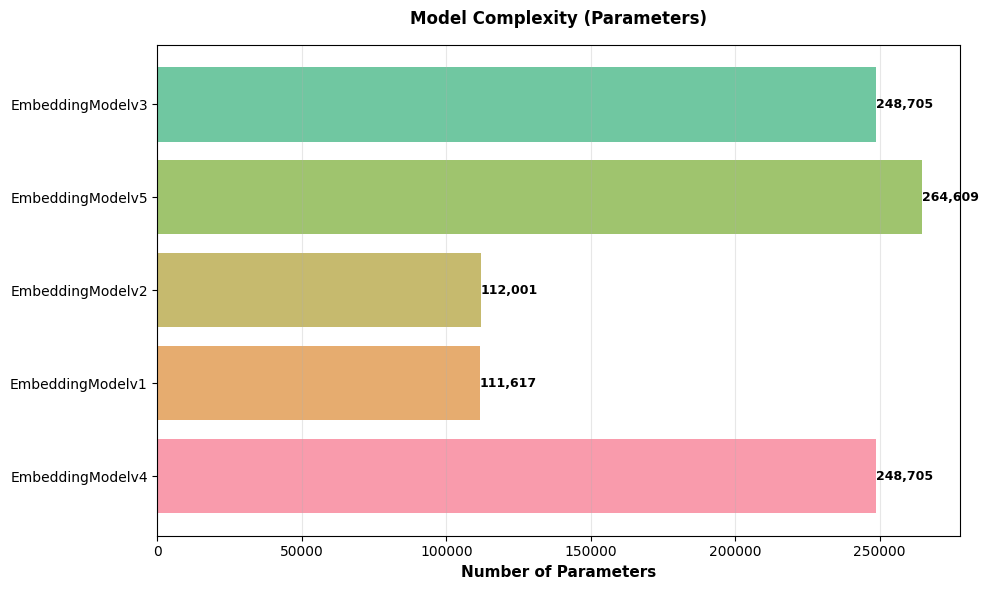

In [71]:
plt.figure(figsize=(10, 6))

df_plot = df_sent_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

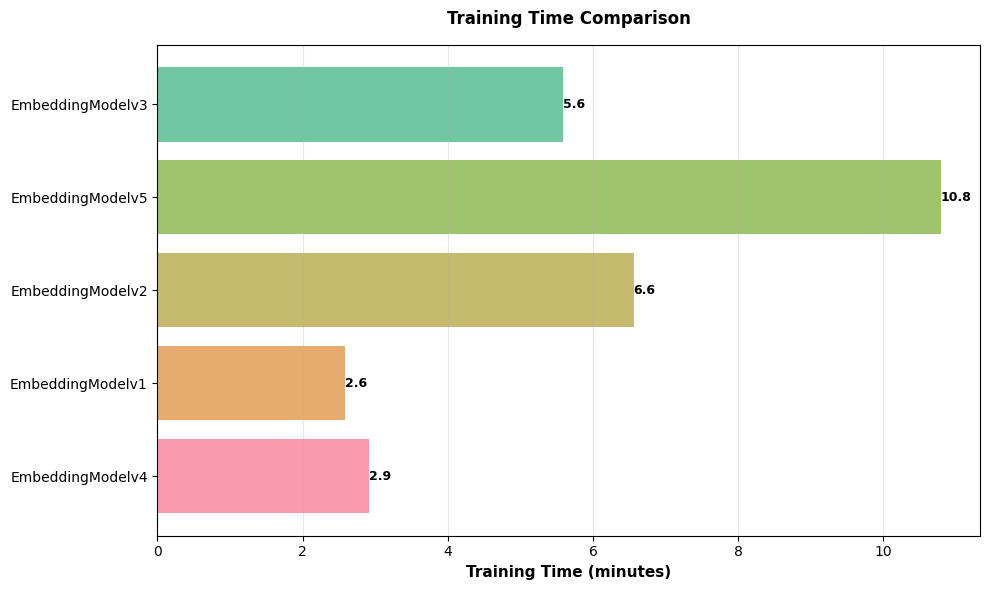

In [72]:
plt.figure(figsize=(10, 6))

bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

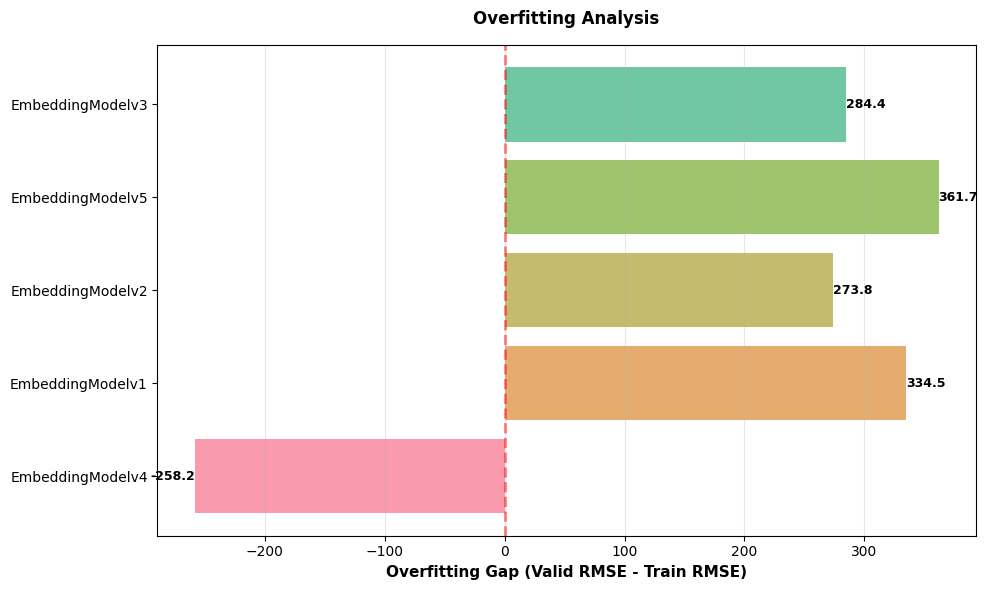

In [73]:
plt.figure(figsize=(10, 6))

df_sent_emb["Overfit Gap"] = df_sent_emb["Valid RMSE"] - df_sent_emb["Train RMSE"]
df_plot = df_sent_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

### Self-taught, Word2Vec and Pretrained fastText Embeddings models

In [74]:
df_emb = all_models_df[all_models_df["Model Type"].str.contains("Word2vec") | all_models_df["Model Type"].str.contains("Fast")| all_models_df["Model Type"].str.contains("SelfTaught")]
df_emb = df_emb[~df_emb["Model Type"].str.contains("Residual")]
df_emb = df_emb[~df_emb["Model Type"].str.contains("CNN")]
df_emb = df_emb.sort_values(by="Test RMSE")
df_emb

Model Type  \
26                         Word2vecModelv3   
40  SelfTaughtModelOverfittingMitigationv6   
31                       SelfTaughtModelv3   
38  SelfTaughtModelOverfittingMitigationv4   
23                       SelfTaughtModelv1   
37  SelfTaughtModelOverfittingMitigationv3   
34                       SelfTaughtModelv6   
39  SelfTaughtModelOverfittingMitigationv5   
32                       SelfTaughtModelv4   
35  SelfTaughtModelOverfittingMitigationv1   
29                         FastTextModelv3   
36  SelfTaughtModelOverfittingMitigationv2   
33                       SelfTaughtModelv5   
30                       SelfTaughtModelv2   
24                         Word2vecModelv1   
25                         Word2vecModelv2   
27                         FastTextModelv1   
28                         FastTextModelv2   

                                      Full Model Name  Parameters  \
26  word2vec_e256_mlen320_mf20_base_unfroz_tok_chi...     6006913   
40  selftaught_e256_mlen320_mf20_base_learn_chid64...     6006913   
31  selftaught_e300_mlen320_mf20_base_learn_chid12...     7026965   
38  selftaught_e256_mlen320_mf10_base_learn_chid64...     8797313   
23  selftaught_e256_mlen320_mf20_base_learn_chid12...     6006913   
37  selftaught_e256_mlen320_mf20_base_learn_chid64...     6006913   
34  selftaught_e256_mlen250_mf20_base_learn_chid12...     6006913   
39  selftaught_e256_mlen320_mf10_base_learn_chid64...     6006913   
32  selftaught_e128_mlen320_mf20_base_learn_chid12...     3039489   
35  selftaught_e300_mlen320_mf20_base_learn_chid12...     6006913   
29  fasttext_e300_mlen320_mf20_base_unfroz_tok_chi...     7026965   
36  selftaught_e256_mlen320_mf20_base_learn_chid64...     5921729   
33  selftaught_e300_mlen320_mf15_base_learn_chid12...     3530497   
30  selftaught_e256_mlen320_mf20_base_learn_chid12...     5768321   
24  word2vec_e256_mlen320_mf20_base_pass_emb_chid1...      137601   
25  word2vec_e256_mlen320_mf20_base_froz_tok_chid1...      137601   
27  fasttext_e300_mlen320_mf20_base_pass_emb_chid1...      148865   
28  fasttext_e300_mlen320_mf20_base_froz_tok_chid1...      148865   

    Training Time (min)  Time per Epoch (s)  Epochs  Best Epoch  Train RMSE  \
26                13.87               55.48      15          12     6401.42   
40                10.04               54.76      11           9     7441.70   
31                18.89               59.65      19          16     6699.15   
38                15.88               56.05      17          14     7449.21   
23                12.08               55.74      13          10     7408.83   
37                10.20               55.64      11           8     7531.22   
34                16.44               70.46      14          11     7332.43   
39                 7.62               57.15       8           6     7766.96   
32                12.21               40.70      18          15     7754.64   
35                13.71               54.84      15          12     7802.23   
29                11.01               60.05      11           8     7823.59   
36                12.03               55.52      13          10     7788.82   
33                11.10               41.63      16          13     8011.45   
30                25.64              139.85      11           8     7625.00   
24                11.76               23.53      30          30     9004.66   
25                13.99               27.98      30          30     9055.38   
27                 6.73               23.75      17          14    10655.36   
28                14.80               29.60      30          30    10769.90   

    Valid RMSE     Test RMSE  
26     8879.48   8518.160156  
40     8917.52   8608.959961  
31     8966.30   8656.929688  
38     8989.41   8746.750000  
23     9057.16   8755.209961  
37     8989.50   8759.540039  
34     9096.32   8781.679688  
39     9104.10   8783.259766  
32     9185.17   8849.589844  
35     9135.86   8872.299805  
29

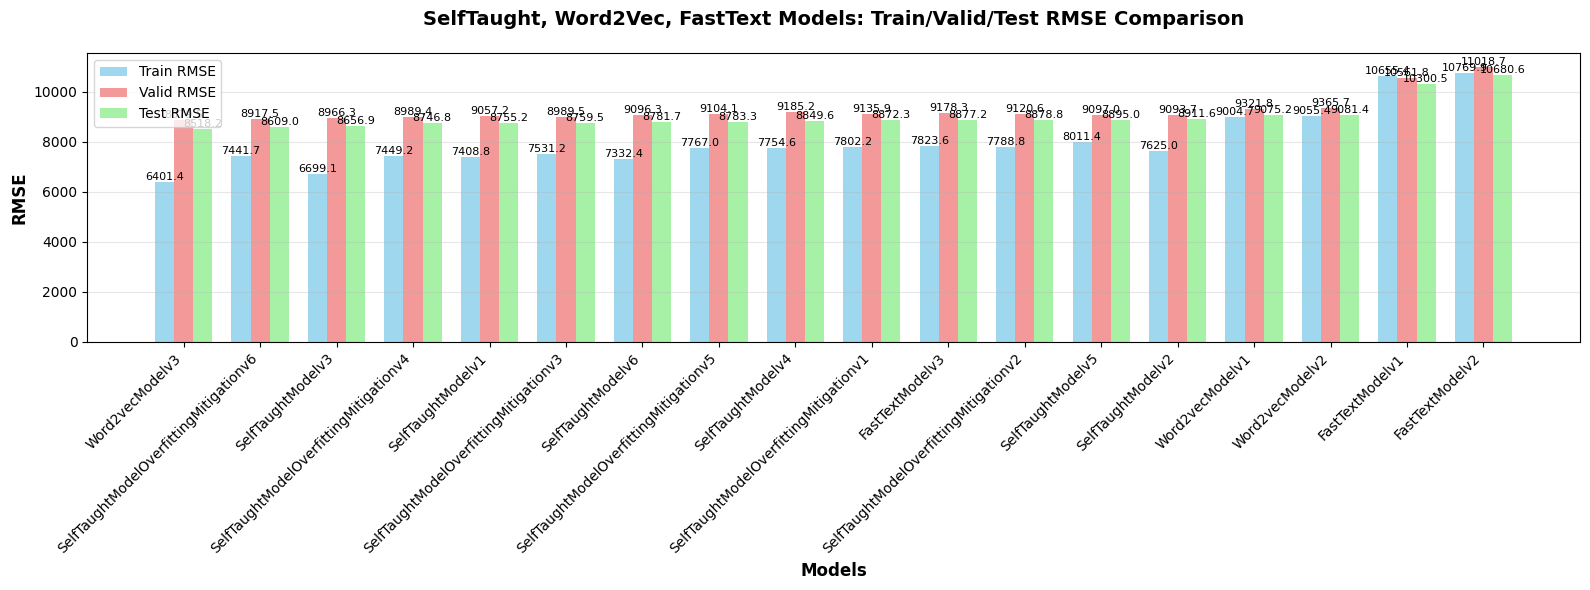

In [75]:
plt.figure(figsize=(16, 6))

x = np.arange(len(df_emb))
width = 0.25

plt.bar(
    x - width,
    df_emb["Train RMSE"],
    width,
    label="Train RMSE",
    alpha=0.8,
    color="skyblue",
)
plt.bar(
    x, df_emb["Valid RMSE"], width, label="Valid RMSE", alpha=0.8, color="lightcoral"
)
plt.bar(
    x + width,
    df_emb["Test RMSE"],
    width,
    label="Test RMSE",
    alpha=0.8,
    color="lightgreen",
)

plt.xlabel("Models", fontsize=12, fontweight="bold")
plt.ylabel("RMSE", fontsize=12, fontweight="bold")
plt.title(
    "SelfTaught, Word2Vec, FastText Models: Train/Valid/Test RMSE Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xticks(x, df_emb["Model Type"], rotation=45, ha="right")
plt.legend(fontsize=10)
plt.grid(axis="y", alpha=0.3)

for i, (train, valid, test) in enumerate(
    zip(df_emb["Train RMSE"], df_emb["Valid RMSE"], df_emb["Test RMSE"])
):
    plt.text(i - width, train, f"{train:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i, valid, f"{valid:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i + width, test, f"{test:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

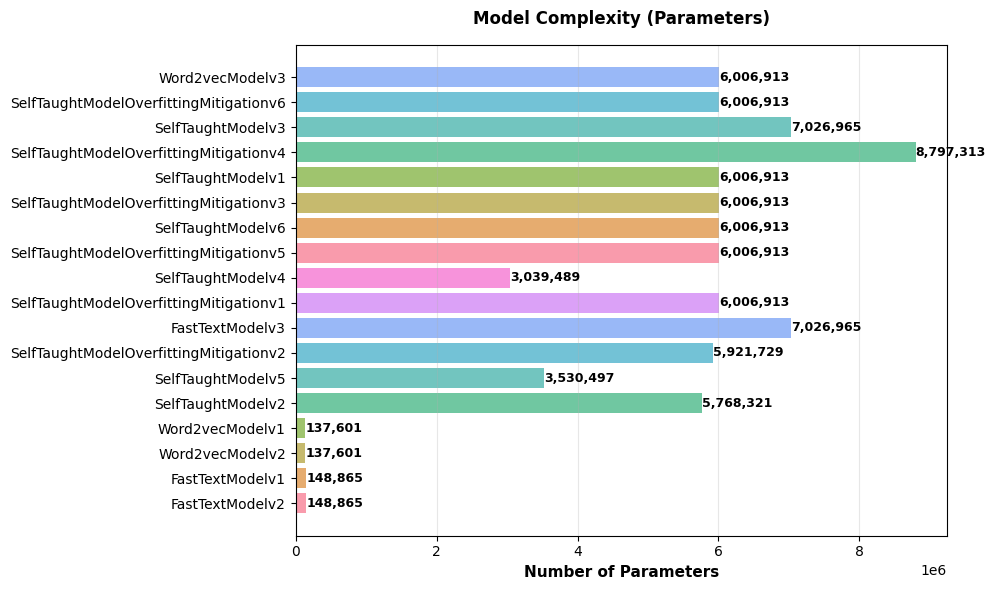

In [78]:
plt.figure(figsize=(10, 6))

df_plot = df_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

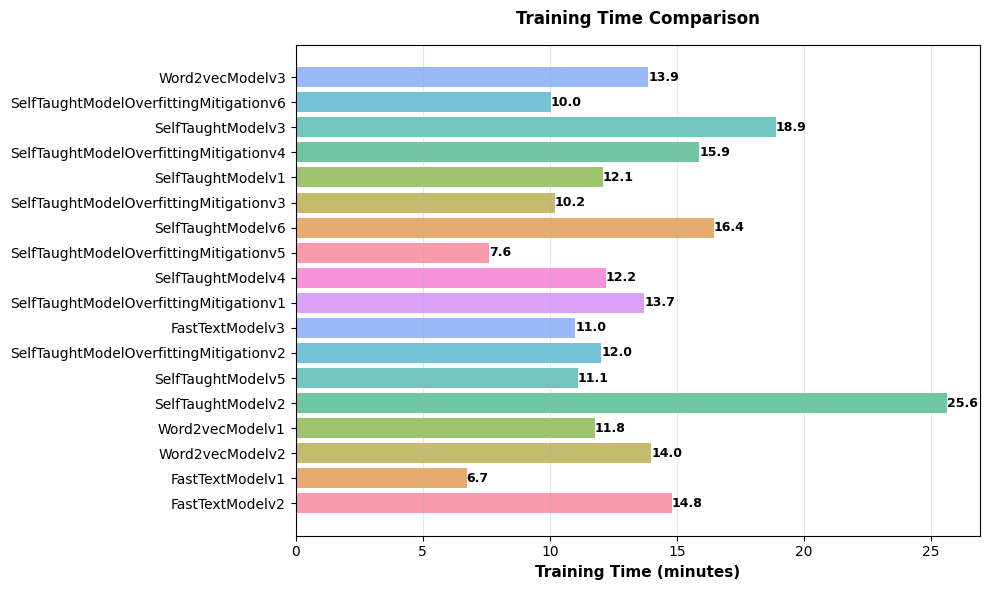

In [79]:
plt.figure(figsize=(10, 6))

bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

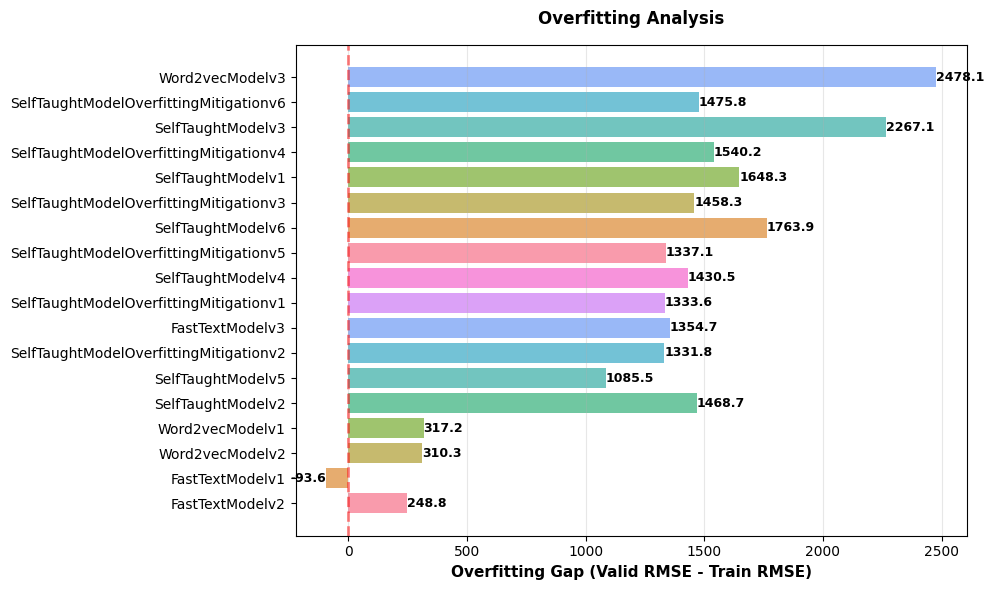

In [80]:
plt.figure(figsize=(10, 6))

df_emb["Overfit Gap"] = df_emb["Valid RMSE"] - df_emb["Train RMSE"]
df_plot = df_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

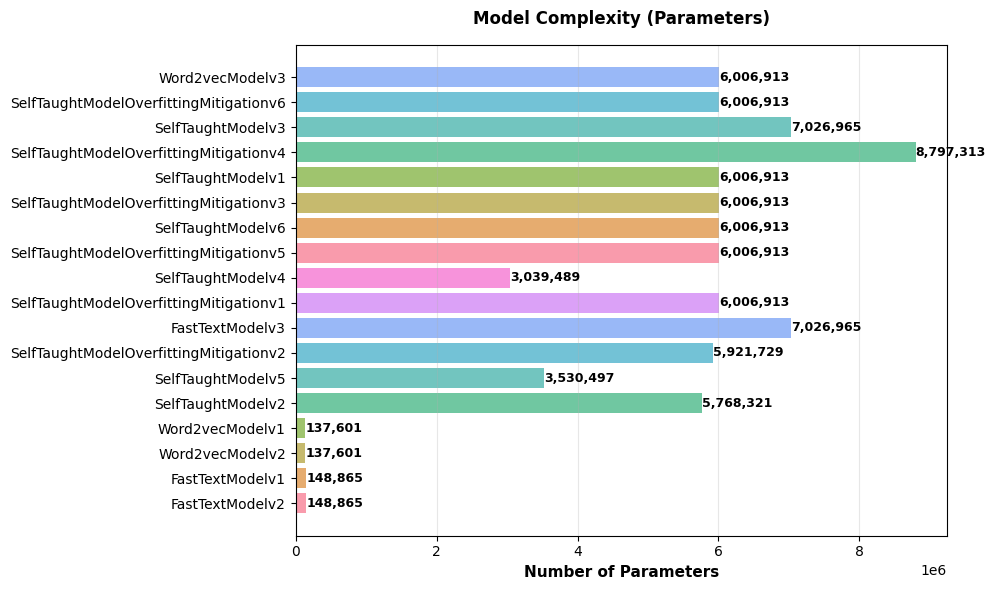

In [81]:
plt.figure(figsize=(10, 6))

df_plot = df_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

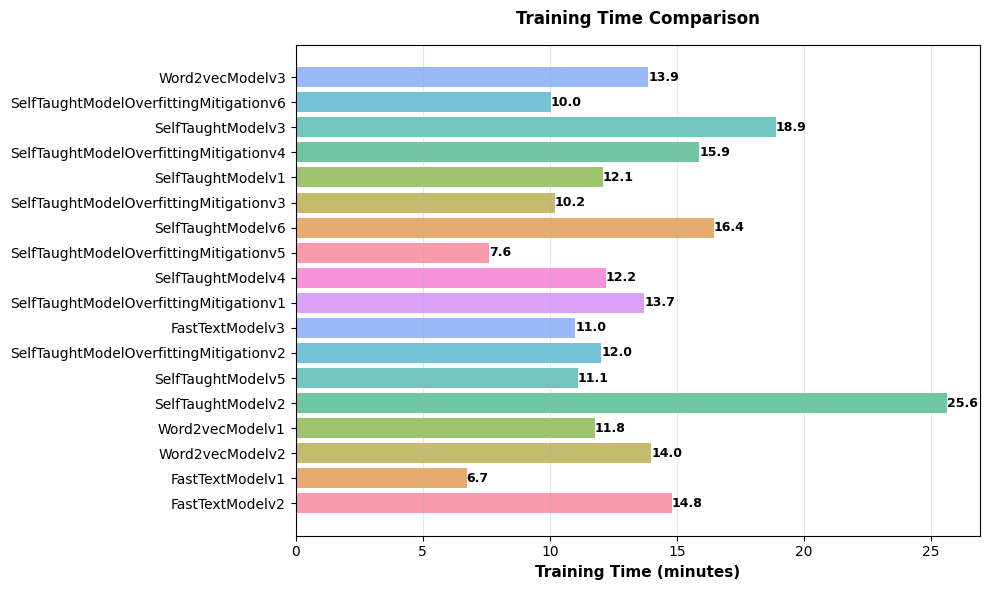

In [82]:
plt.figure(figsize=(10, 6))

bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

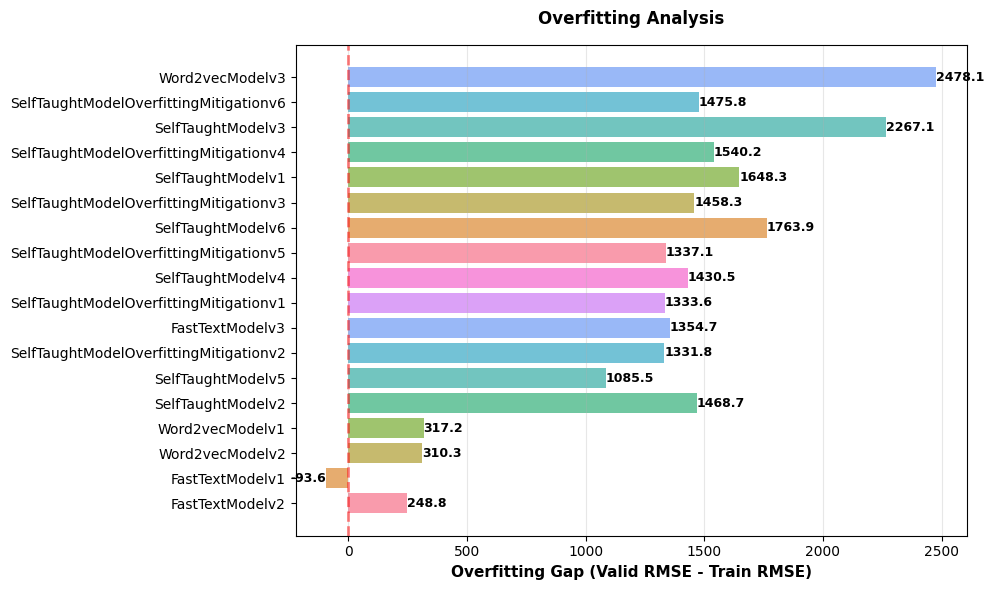

In [83]:
plt.figure(figsize=(10, 6))

df_emb["Overfit Gap"] = df_emb["Valid RMSE"] - df_emb["Train RMSE"]
df_plot = df_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

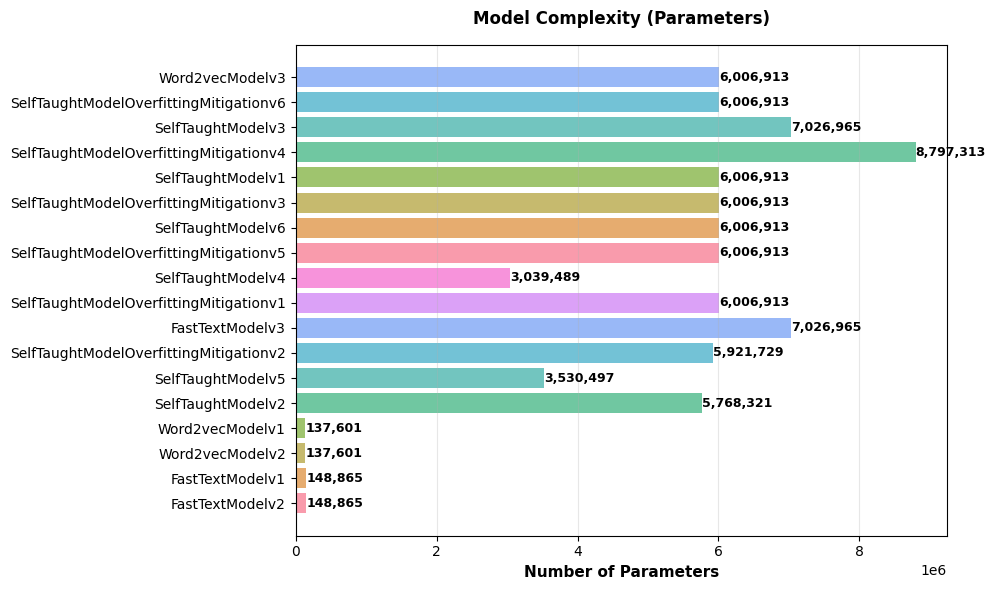

In [84]:
plt.figure(figsize=(10, 6))

df_plot = df_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

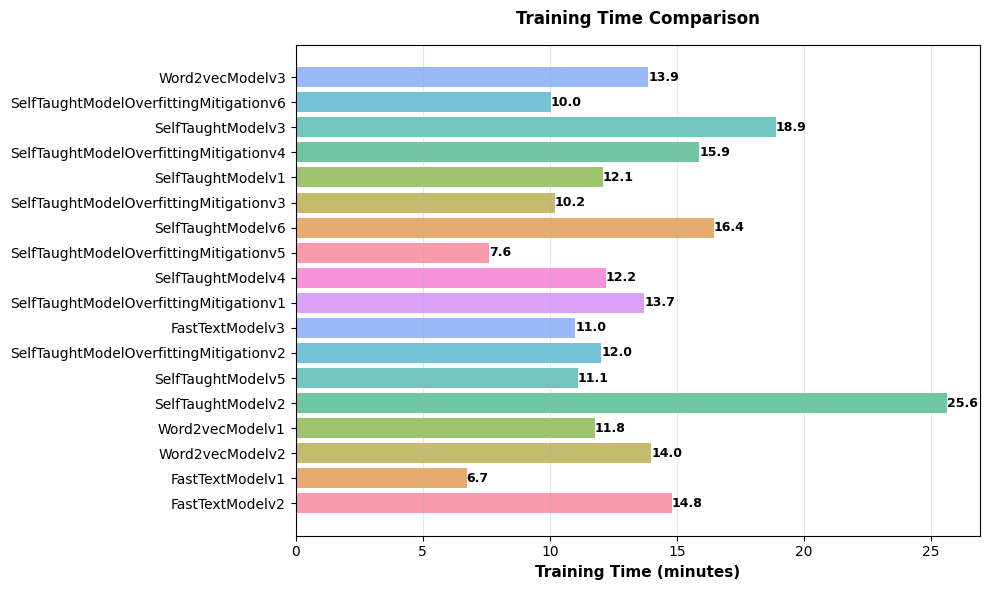

In [85]:
plt.figure(figsize=(10, 6))

bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

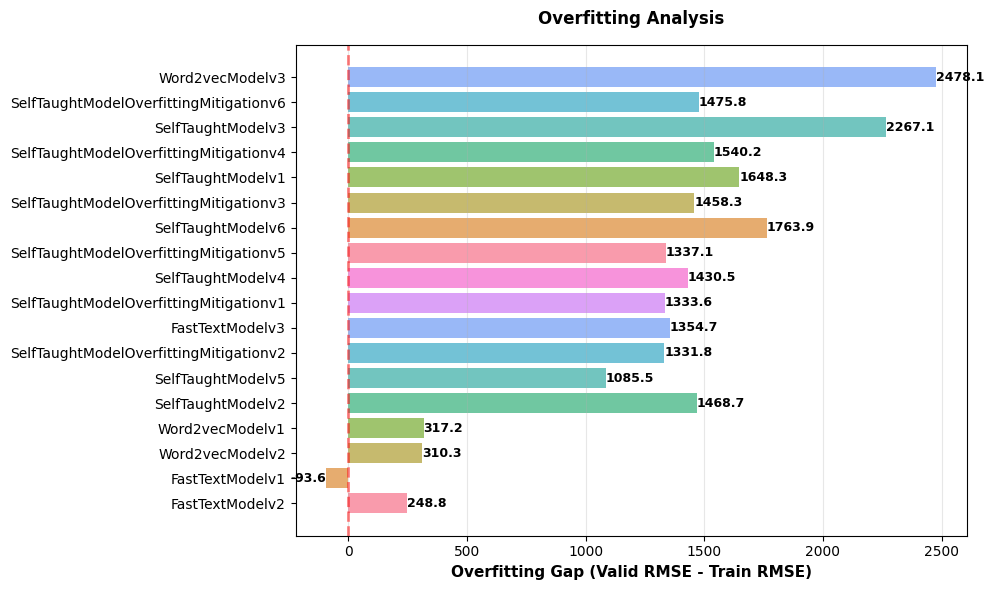

In [86]:
plt.figure(figsize=(10, 6))

df_emb["Overfit Gap"] = df_emb["Valid RMSE"] - df_emb["Train RMSE"]
df_plot = df_emb.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

### More complex architectures models

In [87]:
df_complex = all_models_df[all_models_df["Model Type"].str.contains("Residual") | all_models_df["Model Type"].str.contains("CNN")]
df_complex = df_complex.sort_values(by="Test RMSE")
df_complex

Model Type  \
46    CNNResidualWord2vecModelv1   
45            CNNWord2vecModelv1   
49    CNNResidualFasttextModelv1   
43  CNNResidualSelfTaughtModelv1   
48            CNNFasttextModelv1   
42          CNNSelfTaughtModelv1   
47       ResidualFasttextModelv1   
41     ResidualSelfTaughtModelv1   
44       ResidualWord2vecModelv1   

                                      Full Model Name  Parameters  \
46  word2vec_e256_mlen320_mf20_cnn_res_unfroz_tok_...     6184961   
45  word2vec_e256_mlen320_mf20_cnn_unfroz_tok_chid...     6007105   
49  fasttext_e300_mlen320_mf20_cnn_res_unfroz_tok_...     7202197   
43  selftaught_e300_mlen320_mf20_cnn_res_learn_chi...     7221461   
48  fasttext_e300_mlen320_mf20_cnn_unfroz_tok_chid...     7024341   
42  selftaught_e300_mlen320_mf20_cnn_learn_chid64_...     7024341   
47  fasttext_e300_mlen320_mf20_res_unfroz_tok_chid...     7252757   
41  selftaught_e300_mlen320_mf20_base_res_learn_ch...     7252757   
44  word2vec_e256_mlen320_mf20_base_res_unfroz_tok...     7252757   

    Training Time (min)  Time per Epoch (s)  Epochs  Best Epoch  Train RMSE  \
46                34.78              189.71      11           9     5156.61   
45                35.75              178.75      12          10     5867.47   
49                43.22              185.21      14          12     3960.91   
43                43.36              173.45      15          13     6150.07   
48                27.62              165.71      10           8     5602.41   
42                43.70              174.81      15          13     7114.90   
47                15.92               86.83      11           9     6215.43   
41                27.77              151.46      11           9     6769.92   
44                12.41              124.07       6           4     7936.14   

    Valid RMSE    Test RMSE  
46     8209.49  7973.180176  
45     8274.66  8025.100098  
49     8309.10  8092.770020  
43     8362.97  8226.889648  
48     8555.85  8311.879883  
42     8693.72  8434.769531  
47     8971.63  8687.389648  
41     8969.91  8791.269531  
44     9184.12  8953.620117

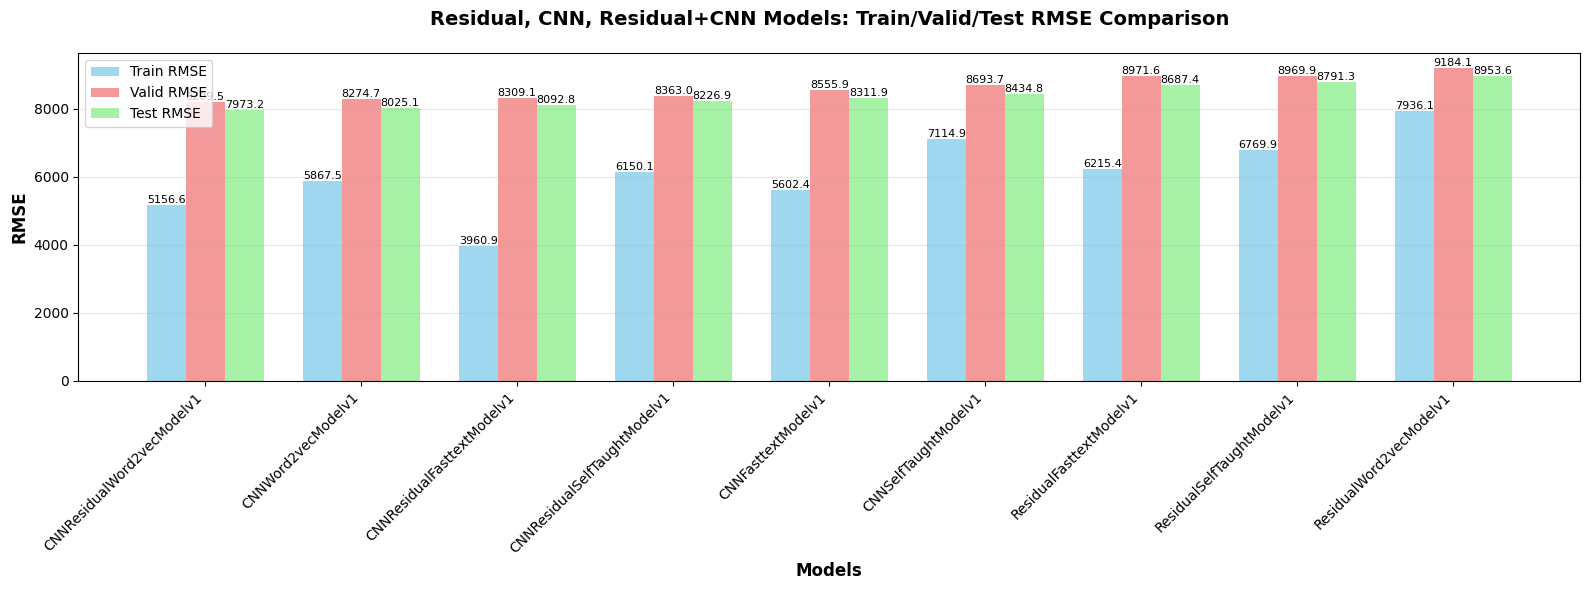

In [88]:
plt.figure(figsize=(16, 6))

x = np.arange(len(df_complex))
width = 0.25

plt.bar(
    x - width,
    df_complex["Train RMSE"],
    width,
    label="Train RMSE",
    alpha=0.8,
    color="skyblue",
)
plt.bar(
    x, df_complex["Valid RMSE"], width, label="Valid RMSE", alpha=0.8, color="lightcoral"
)
plt.bar(
    x + width,
    df_complex["Test RMSE"],
    width,
    label="Test RMSE",
    alpha=0.8,
    color="lightgreen",
)

plt.xlabel("Models", fontsize=12, fontweight="bold")
plt.ylabel("RMSE", fontsize=12, fontweight="bold")
plt.title(
    "Residual, CNN, Residual+CNN Models: Train/Valid/Test RMSE Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xticks(x, df_complex["Model Type"], rotation=45, ha="right")
plt.legend(fontsize=10)
plt.grid(axis="y", alpha=0.3)

for i, (train, valid, test) in enumerate(
    zip(df_complex["Train RMSE"], df_complex["Valid RMSE"], df_complex["Test RMSE"])
):
    plt.text(i - width, train, f"{train:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i, valid, f"{valid:.1f}", ha="center", va="bottom", fontsize=8)
    plt.text(i + width, test, f"{test:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

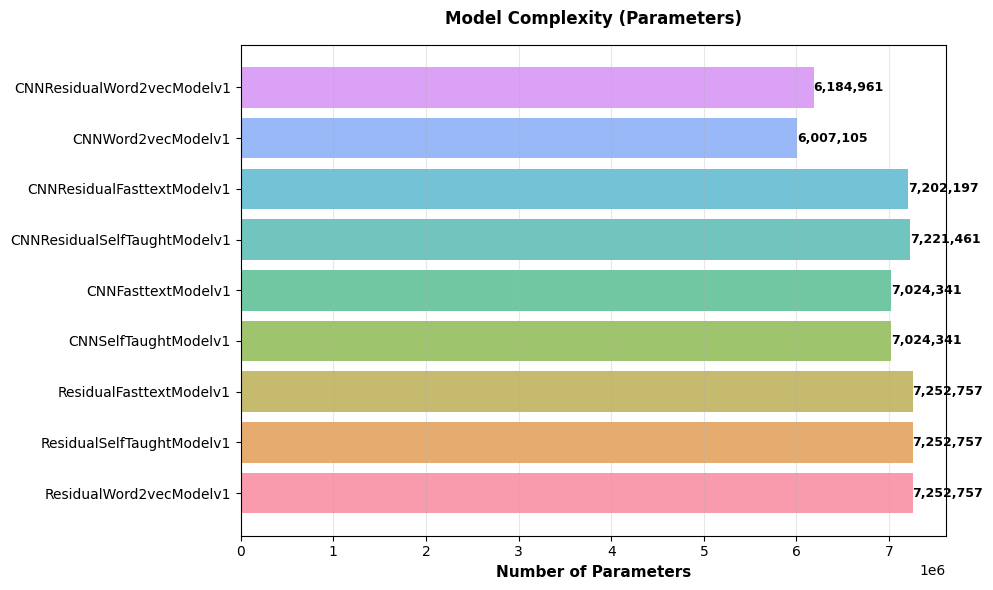

In [89]:
plt.figure(figsize=(10, 6))

df_plot = df_complex.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Parameters"], color=colors, alpha=0.7)
plt.xlabel("Number of Parameters", fontsize=11, fontweight="bold")
plt.title("Model Complexity (Parameters)", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Parameters"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

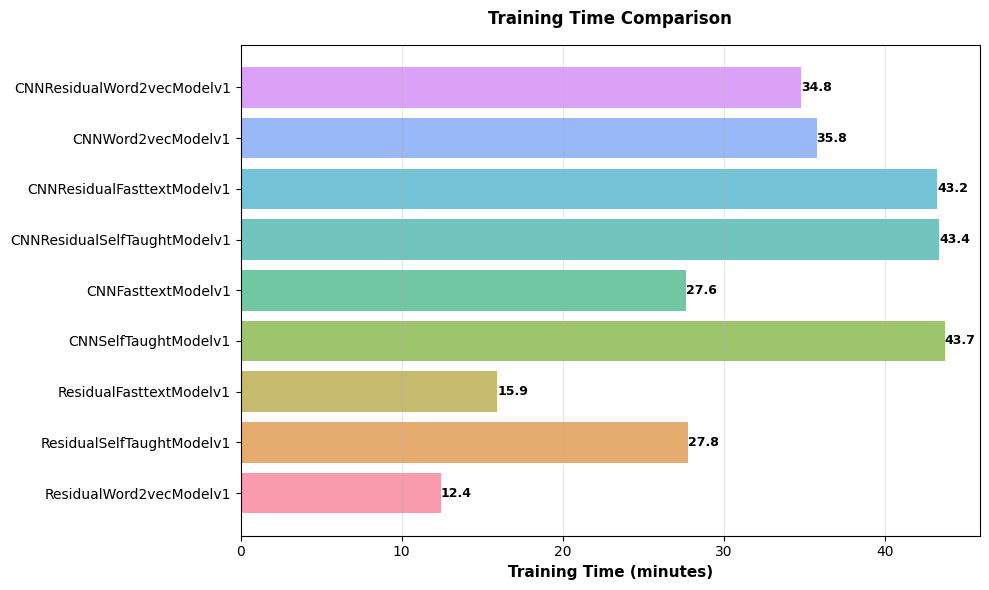

In [90]:
plt.figure(figsize=(10, 6))

bars = plt.barh(
    df_plot["Model Type"], df_plot["Training Time (min)"], color=colors, alpha=0.7
)
plt.xlabel("Training Time (minutes)", fontsize=11, fontweight="bold")
plt.title("Training Time Comparison", fontsize=12, fontweight="bold", pad=15)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Training Time (min)"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

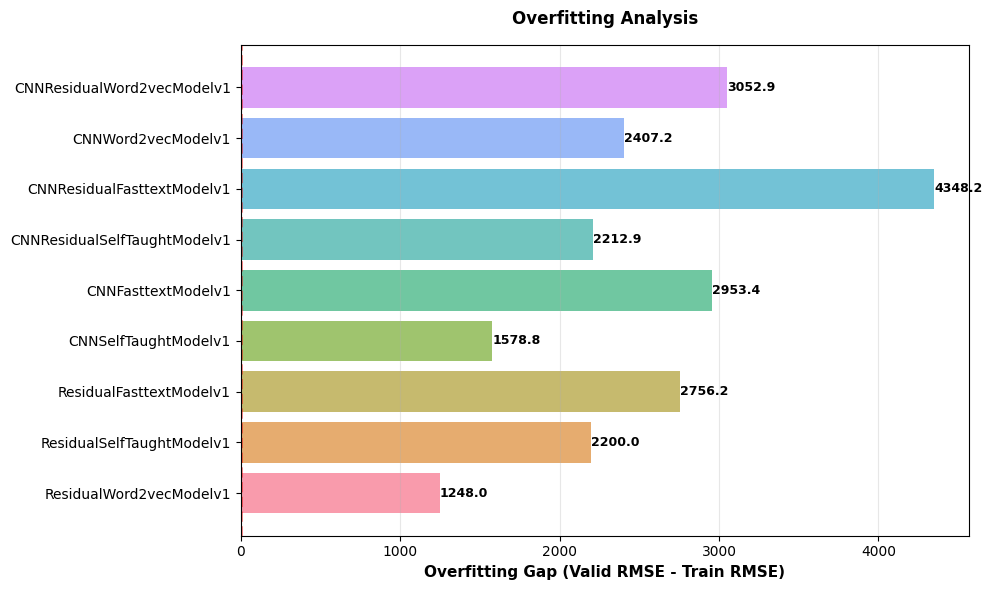

In [91]:
plt.figure(figsize=(10, 6))

df_complex["Overfit Gap"] = df_complex["Valid RMSE"] - df_complex["Train RMSE"]
df_plot = df_complex.sort_values("Test RMSE", ascending=False)
bars = plt.barh(df_plot["Model Type"], df_plot["Overfit Gap"], color=colors, alpha=0.7)
plt.xlabel("Overfitting Gap (Valid RMSE - Train RMSE)", fontsize=11, fontweight="bold")
plt.title("Overfitting Analysis", fontsize=12, fontweight="bold", pad=15)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2, alpha=0.5)
plt.grid(axis="x", alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, df_plot["Overfit Gap"])):
    plt.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()